In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from keras.callbacks import EarlyStopping

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+- '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '+',
 2: '-',
 3: '0',
 4: '1',
 5: '2',
 6: '3',
 7: '4',
 8: '5',
 9: '6',
 10: '7',
 11: '8',
 12: '9'}

In [9]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < 100000:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))
    
while 100000 <= len(questions) < 200000:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    
    big_number = max([a,b])
    small_number = min([a,b])
    q = '{}-{}'.format(big_number, small_number)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(big_number - small_number)
    ans += ' ' * (DIGITS - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 100000
Total addition questions: 200000


In [10]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [12]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:110000]
train_y = y[:110000]
test_x = x[110000:]
test_y = y[110000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(99000, 7, 13)
(99000, 4, 13)
Validation Data:
(11000, 7, 13)
(11000, 4, 13)
Testing Data:
(90000, 7, 13)
(90000, 4, 13)


In [14]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False False False False False False False  True
   False False]
  [False False False False False False False False False False False
    True False]
  [False False False False False False  True False False False False
   False False]
  [False False  True False False False False False False False False
   False False]
  [False False False False False False False  True False False False
   False False]
  [False False False False  True False False False False False False
   False False]
  [False False False False False False False False False False  True
   False False]]

 [[False False False False  True False False False False False False
   False False]
  [False False False False False False False False False  True False
   False False]
  [False False False False  True False False False False False False
   False False]
  [False  True False False False False False False False False False
   False False]
  [False False False False False False False False Fals

In [15]:
print('Build model...')
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72704     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 13)             1677      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 13)             0         
Total params: 205,965
Trainable params: 205,965
Non-trainable params: 0
_________________________________________________________________


In [17]:
# for iteration in range(200):
#     print()
#     print('-' * 50)
#     print('Iteration', iteration)
#     early_stopping_monitor = EarlyStopping(patience=5, mode='auto')
#     model.fit(x_train, y_train,
#               batch_size=BATCH_SIZE,
#               epochs=1,
#               validation_data=(x_val, y_val),
#               callbacks=[early_stopping_monitor])
#     for i in range(10):
#         ind = np.random.randint(0, len(x_val))
#         rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
#         preds = model.predict_classes(rowx, verbose=0)
#         q = ctable.decode(rowx[0])
#         correct = ctable.decode(rowy[0])
#         guess = ctable.decode(preds[0], calc_argmax=False)
#         print('Q', q[::-1] if REVERSE else q, end=' ')
#         print('T', correct, end=' ')
#         if correct == guess:
#             print(colors.ok + '☑' + colors.close, end=' ')
#         else:
#             print(colors.fail + '☒' + colors.close, end=' ')
#         print(guess)
early_stopping_monitor = EarlyStopping(patience=5, mode='auto')
rnn_model = model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=100,
                      validation_data=(x_val, y_val),
                      callbacks=[early_stopping_monitor])

Train on 99000 samples, validate on 11000 samples
Epoch 1/100
99000/99000 [==============================] - 21s 211us/step - loss: 1.7598 - acc: 0.3498 - val_loss: 1.6836 - val_acc: 0.3644
Epoch 2/100
99000/99000 [==============================] - 18s 184us/step - loss: 1.5731 - acc: 0.3761 - val_loss: 1.4733 - val_acc: 0.3893
Epoch 3/100
99000/99000 [==============================] - 19s 191us/step - loss: 1.4017 - acc: 0.4120 - val_loss: 1.3340 - val_acc: 0.4297
Epoch 4/100
99000/99000 [==============================] - 19s 189us/step - loss: 1.2966 - acc: 0.4370 - val_loss: 1.2555 - val_acc: 0.4460
Epoch 5/100
99000/99000 [==============================] - 19s 191us/step - loss: 1.2289 - acc: 0.4554 - val_loss: 1.2045 - val_acc: 0.4641
Epoch 6/100
99000/99000 [==============================] - 18s 183us/step - loss: 1.1631 - acc: 0.4767 - val_loss: 1.1199 - val_acc: 0.4911
Epoch 7/100
99000/99000 [==============================] - 18s 178us/step - loss: 1.0674 - acc: 0.5092 - val_l

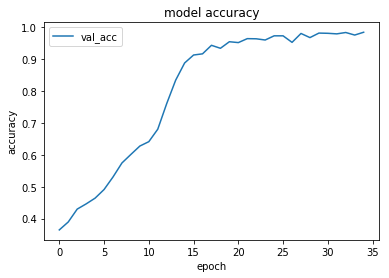

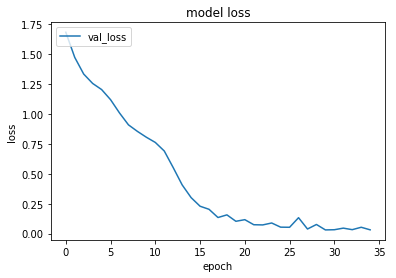

In [21]:
import matplotlib.pyplot as plt
plt.plot(rnn_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_acc'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(rnn_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss'], loc='upper left')
plt.show()

In [18]:
right = 0
preds = model.predict_classes(test_x, verbose=0)
for i in range(len(preds)):
    q = ctable.decode(test_x[i])
    correct = ctable.decode(test_y[i])
    guess = ctable.decode(preds[i], calc_argmax=False)
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        print(colors.ok + '☑' + colors.close, end=' ')
        right += 1
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(guess)
print("MSG : Accuracy is {}".format(right / len(preds)))

Q 8+180   T 188  ☑ 188 
Q 887-876 T 11   ☑ 11  
Q 915+636 T 1551 ☑ 1551
Q 287-73  T 214  ☑ 214 
Q 22+115  T 137  ☑ 137 
Q 180+76  T 256  ☑ 256 
Q 38+635  T 673  ☑ 673 
Q 14+793  T 807  ☑ 807 
Q 591-16  T 575  ☑ 575 
Q 402+420 T 822  ☑ 822 
Q 231+76  T 307  ☑ 307 
Q 969-546 T 423  ☑ 423 
Q 785-77  T 708  ☑ 708 
Q 469-401 T 68   ☑ 68  
Q 535+54  T 589  ☑ 589 
Q 975-19  T 956  ☑ 956 
Q 774-149 T 625  ☑ 625 
Q 838+47  T 885  ☑ 885 
Q 441+95  T 536  ☑ 536 
Q 772-43  T 729  ☑ 729 
Q 917-877 T 40   ☑ 40  
Q 737+939 T 1676 ☑ 1676
Q 416-25  T 391  ☑ 391 
Q 584-68  T 516  ☑ 516 
Q 650-562 T 88   ☑ 88  
Q 865+341 T 1206 ☑ 1206
Q 564-274 T 290  ☑ 290 
Q 861-394 T 467  ☑ 467 
Q 723+97  T 820  ☑ 820 
Q 703-329 T 374  ☑ 374 
Q 120-70  T 50   ☑ 50  
Q 514-58  T 456  ☑ 456 
Q 71+631  T 702  ☑ 702 
Q 970+728 T 1698 ☑ 1698
Q 35+931  T 966  ☑ 966 
Q 256+822 T 1078 ☑ 1078
Q 528+650 T 1178 ☑ 1178
Q 345-202 T 143  ☑ 143 
Q 97+624  T 721  ☑ 721 
Q 410+320 T 730  ☑ 730 
Q 873-686 T 187  ☑ 187 
Q 791-717 T 74  

Q 53+760  T 813  ☑ 813 
Q 289-131 T 158  ☑ 158 
Q 62+474  T 536  ☑ 536 
Q 174+132 T 306  ☒ 206 
Q 342+67  T 409  ☑ 409 
Q 756-483 T 273  ☑ 273 
Q 102-45  T 57   ☑ 57  
Q 444-290 T 154  ☑ 154 
Q 634-211 T 423  ☑ 423 
Q 333-242 T 91   ☑ 91  
Q 868+689 T 1557 ☑ 1557
Q 854-37  T 817  ☑ 817 
Q 873-357 T 516  ☑ 516 
Q 86+137  T 223  ☑ 223 
Q 924+771 T 1695 ☑ 1695
Q 813+80  T 893  ☑ 893 
Q 63+582  T 645  ☑ 645 
Q 72+411  T 483  ☑ 483 
Q 936-499 T 437  ☑ 437 
Q 11+183  T 194  ☑ 194 
Q 878-365 T 513  ☑ 513 
Q 589+758 T 1347 ☑ 1347
Q 916-286 T 630  ☑ 630 
Q 784-524 T 260  ☑ 260 
Q 765-230 T 535  ☑ 535 
Q 311-86  T 225  ☑ 225 
Q 22+958  T 980  ☑ 980 
Q 778-524 T 254  ☑ 254 
Q 81+264  T 345  ☑ 345 
Q 83+681  T 764  ☑ 764 
Q 532-118 T 414  ☑ 414 
Q 553-56  T 497  ☑ 497 
Q 32+307  T 339  ☑ 339 
Q 19+412  T 431  ☑ 431 
Q 56+93   T 149  ☑ 149 
Q 657-80  T 577  ☑ 577 
Q 675-436 T 239  ☑ 239 
Q 42+28   T 70   ☑ 70  
Q 211-78  T 133  ☑ 133 
Q 721-71  T 650  ☑ 650 
Q 52+792  T 844  ☑ 844 
Q 72+468  T 540 

Q 889-319 T 570  ☑ 570 
Q 739+860 T 1599 ☑ 1599
Q 35+950  T 985  ☑ 985 
Q 13+101  T 114  ☑ 114 
Q 260+420 T 680  ☒ 670 
Q 24+330  T 354  ☑ 354 
Q 656-623 T 33   ☑ 33  
Q 585-509 T 76   ☑ 76  
Q 439-344 T 95   ☑ 95  
Q 665-320 T 345  ☑ 345 
Q 32+130  T 162  ☑ 162 
Q 328+461 T 789  ☑ 789 
Q 512-404 T 108  ☑ 108 
Q 680-236 T 444  ☑ 444 
Q 454-96  T 358  ☑ 358 
Q 975-866 T 109  ☑ 109 
Q 49+430  T 479  ☑ 479 
Q 955-773 T 182  ☑ 182 
Q 67+1    T 68   ☑ 68  
Q 828-155 T 673  ☑ 673 
Q 753-154 T 599  ☒ 5999
Q 149+158 T 307  ☑ 307 
Q 656-499 T 157  ☑ 157 
Q 1+683   T 684  ☑ 684 
Q 445+25  T 470  ☑ 470 
Q 853-35  T 818  ☒ 8188
Q 416-168 T 248  ☑ 248 
Q 551+363 T 914  ☑ 914 
Q 591-462 T 129  ☑ 129 
Q 763+55  T 818  ☑ 818 
Q 917-472 T 445  ☑ 445 
Q 884-123 T 761  ☑ 761 
Q 32+901  T 933  ☑ 933 
Q 646-67  T 579  ☑ 579 
Q 746+613 T 1359 ☑ 1359
Q 836-74  T 762  ☑ 762 
Q 498-294 T 204  ☑ 204 
Q 803-736 T 67   ☑ 67  
Q 401+90  T 491  ☑ 491 
Q 412-74  T 338  ☑ 338 
Q 988-665 T 323  ☑ 323 
Q 18+475  T 493 

Q 102-46  T 56   ☑ 56  
Q 97+836  T 933  ☑ 933 
Q 227-50  T 177  ☑ 177 
Q 755-542 T 213  ☑ 213 
Q 373+20  T 393  ☑ 393 
Q 706-103 T 603  ☑ 603 
Q 880-183 T 697  ☑ 697 
Q 688+87  T 775  ☑ 775 
Q 104+375 T 479  ☒ 489 
Q 419-298 T 121  ☑ 121 
Q 17+444  T 461  ☑ 461 
Q 788+876 T 1664 ☑ 1664
Q 679-225 T 454  ☑ 454 
Q 114+438 T 552  ☑ 552 
Q 31+895  T 926  ☑ 926 
Q 767+53  T 820  ☑ 820 
Q 663-662 T 1    ☑ 1   
Q 12+338  T 350  ☑ 350 
Q 3+783   T 786  ☑ 786 
Q 706-233 T 473  ☑ 473 
Q 964-356 T 608  ☒ 6088
Q 605-122 T 483  ☑ 483 
Q 82+630  T 712  ☑ 712 
Q 92+532  T 624  ☑ 624 
Q 138-80  T 58   ☑ 58  
Q 907+48  T 955  ☑ 955 
Q 998+174 T 1172 ☑ 1172
Q 714-283 T 431  ☑ 431 
Q 225+834 T 1059 ☑ 1059
Q 899-526 T 373  ☑ 373 
Q 787-27  T 760  ☑ 760 
Q 874-842 T 32   ☑ 32  
Q 310+33  T 343  ☑ 343 
Q 257+145 T 402  ☒ 302 
Q 634-243 T 391  ☑ 391 
Q 4+123   T 127  ☑ 127 
Q 557-510 T 47   ☑ 47  
Q 994-327 T 667  ☑ 667 
Q 30+712  T 742  ☑ 742 
Q 734-79  T 655  ☑ 655 
Q 727+394 T 1121 ☑ 1121
Q 389-263 T 126 

Q 691-443 T 248  ☒ 2488
Q 6+471   T 477  ☑ 477 
Q 312+605 T 917  ☑ 917 
Q 922-719 T 203  ☑ 203 
Q 552-429 T 123  ☑ 123 
Q 418-69  T 349  ☑ 349 
Q 192+519 T 711  ☑ 711 
Q 707+158 T 865  ☑ 865 
Q 414+99  T 513  ☑ 513 
Q 137+53  T 190  ☑ 190 
Q 680-644 T 36   ☑ 36  
Q 80+841  T 921  ☑ 921 
Q 882-850 T 32   ☑ 32  
Q 52+718  T 770  ☑ 770 
Q 398+24  T 422  ☑ 422 
Q 868-718 T 150  ☑ 150 
Q 588-67  T 521  ☑ 521 
Q 715-608 T 107  ☑ 107 
Q 773-369 T 404  ☑ 404 
Q 558+998 T 1556 ☑ 1556
Q 647+133 T 780  ☑ 780 
Q 615-11  T 604  ☑ 604 
Q 337-77  T 260  ☑ 260 
Q 37+337  T 374  ☑ 374 
Q 706-67  T 639  ☒ 649 
Q 320-298 T 22   ☑ 22  
Q 191-46  T 145  ☑ 145 
Q 617-294 T 323  ☑ 323 
Q 443-425 T 18   ☑ 18  
Q 333+863 T 1196 ☑ 1196
Q 601-161 T 440  ☑ 440 
Q 254-16  T 238  ☑ 238 
Q 494+375 T 869  ☑ 869 
Q 98+688  T 786  ☑ 786 
Q 636-328 T 308  ☑ 308 
Q 548-247 T 301  ☑ 301 
Q 67+635  T 702  ☑ 702 
Q 892-719 T 173  ☑ 173 
Q 729-378 T 351  ☑ 351 
Q 834-628 T 206  ☑ 206 
Q 531+966 T 1497 ☑ 1497
Q 624+462 T 1086

Q 271+446 T 717  ☑ 717 
Q 798-363 T 435  ☑ 435 
Q 468-344 T 124  ☑ 124 
Q 653+88  T 741  ☑ 741 
Q 741+203 T 944  ☑ 944 
Q 45+713  T 758  ☑ 758 
Q 11+115  T 126  ☑ 126 
Q 530+878 T 1408 ☑ 1408
Q 892-11  T 881  ☑ 881 
Q 660-628 T 32   ☑ 32  
Q 313-267 T 46   ☑ 46  
Q 77+78   T 155  ☑ 155 
Q 677+390 T 1067 ☑ 1067
Q 601-505 T 96   ☑ 96  
Q 44+535  T 579  ☑ 579 
Q 919-886 T 33   ☒ 32  
Q 658-237 T 421  ☑ 421 
Q 797+156 T 953  ☑ 953 
Q 552+689 T 1241 ☑ 1241
Q 55+241  T 296  ☑ 296 
Q 396-13  T 383  ☑ 383 
Q 785+57  T 842  ☑ 842 
Q 957-66  T 891  ☑ 891 
Q 16+941  T 957  ☑ 957 
Q 96+186  T 282  ☑ 282 
Q 325-220 T 105  ☑ 105 
Q 704+999 T 1703 ☒ 1603
Q 807-717 T 90   ☑ 90  
Q 990-894 T 96   ☑ 96  
Q 272+47  T 319  ☑ 319 
Q 859-530 T 329  ☑ 329 
Q 779-560 T 219  ☑ 219 
Q 82+386  T 468  ☑ 468 
Q 916+481 T 1397 ☑ 1397
Q 795+102 T 897  ☑ 897 
Q 712+69  T 781  ☑ 781 
Q 96+703  T 799  ☑ 799 
Q 725-581 T 144  ☑ 144 
Q 418+51  T 469  ☑ 469 
Q 128+252 T 380  ☑ 380 
Q 906-83  T 823  ☑ 823 
Q 278-44  T 234 

Q 735-370 T 365  ☑ 365 
Q 809-273 T 536  ☑ 536 
Q 856+970 T 1826 ☑ 1826
Q 474+58  T 532  ☑ 532 
Q 348+860 T 1208 ☑ 1208
Q 971+748 T 1719 ☑ 1719
Q 739-468 T 271  ☑ 271 
Q 809-707 T 102  ☑ 102 
Q 1+938   T 939  ☑ 939 
Q 60+656  T 716  ☑ 716 
Q 873+286 T 1159 ☑ 1159
Q 573-189 T 384  ☑ 384 
Q 784-241 T 543  ☑ 543 
Q 469-129 T 340  ☑ 340 
Q 764-488 T 276  ☑ 276 
Q 540+84  T 624  ☑ 624 
Q 955-794 T 161  ☑ 161 
Q 673-75  T 598  ☑ 598 
Q 398-202 T 196  ☑ 196 
Q 548+35  T 583  ☑ 583 
Q 873-809 T 64   ☑ 64  
Q 536-434 T 102  ☑ 102 
Q 518+1   T 519  ☑ 519 
Q 958-901 T 57   ☑ 57  
Q 697-146 T 551  ☑ 551 
Q 996-339 T 657  ☑ 657 
Q 761-49  T 712  ☑ 712 
Q 12+516  T 528  ☑ 528 
Q 313+837 T 1150 ☑ 1150
Q 754-52  T 702  ☑ 702 
Q 915-692 T 223  ☑ 223 
Q 654-415 T 239  ☑ 239 
Q 286-82  T 204  ☑ 204 
Q 727-491 T 236  ☑ 236 
Q 829+425 T 1254 ☑ 1254
Q 904-663 T 241  ☑ 241 
Q 37+673  T 710  ☑ 710 
Q 39+524  T 563  ☑ 563 
Q 946-850 T 96   ☑ 96  
Q 53+65   T 118  ☑ 118 
Q 835-66  T 769  ☑ 769 
Q 636-514 T 122 

Q 94+444  T 538  ☑ 538 
Q 67+933  T 1000 ☑ 1000
Q 555+228 T 783  ☑ 783 
Q 213-60  T 153  ☑ 153 
Q 274+90  T 364  ☑ 364 
Q 778-733 T 45   ☑ 45  
Q 19+531  T 550  ☑ 550 
Q 900-732 T 168  ☑ 168 
Q 70+580  T 650  ☑ 650 
Q 384-259 T 125  ☑ 125 
Q 607+38  T 645  ☑ 645 
Q 361+687 T 1048 ☑ 1048
Q 323-54  T 269  ☑ 269 
Q 724+906 T 1630 ☑ 1630
Q 78+691  T 769  ☑ 769 
Q 468-79  T 389  ☑ 389 
Q 806-527 T 279  ☑ 279 
Q 242-206 T 36   ☑ 36  
Q 972-765 T 207  ☒ 2077
Q 111+482 T 593  ☑ 593 
Q 85+46   T 131  ☑ 131 
Q 591+9   T 600  ☒ 590 
Q 274+68  T 342  ☑ 342 
Q 373-281 T 92   ☑ 92  
Q 682-86  T 596  ☑ 596 
Q 927-662 T 265  ☑ 265 
Q 973-602 T 371  ☑ 371 
Q 80+433  T 513  ☑ 513 
Q 714-671 T 43   ☑ 43  
Q 13+282  T 295  ☑ 295 
Q 915-390 T 525  ☑ 525 
Q 517+357 T 874  ☑ 874 
Q 13+21   T 34   ☑ 34  
Q 61+31   T 92   ☑ 92  
Q 250+60  T 310  ☑ 310 
Q 225+315 T 540  ☑ 540 
Q 295-289 T 6    ☒ 7   
Q 264+764 T 1028 ☑ 1028
Q 417+235 T 652  ☑ 652 
Q 825+821 T 1646 ☑ 1646
Q 802-28  T 774  ☑ 774 
Q 920+620 T 1540

Q 446-380 T 66   ☑ 66  
Q 784-176 T 608  ☒ 6088
Q 11+987  T 998  ☑ 998 
Q 933-63  T 870  ☒ 879 
Q 855+638 T 1493 ☑ 1493
Q 782-771 T 11   ☑ 11  
Q 85+412  T 497  ☑ 497 
Q 48+382  T 430  ☑ 430 
Q 80+135  T 215  ☑ 215 
Q 710+931 T 1641 ☑ 1641
Q 670+422 T 1092 ☑ 1092
Q 90+6    T 96   ☑ 96  
Q 697-416 T 281  ☑ 281 
Q 1+658   T 659  ☑ 659 
Q 228-49  T 179  ☑ 179 
Q 493-170 T 323  ☑ 323 
Q 222-10  T 212  ☑ 212 
Q 21+824  T 845  ☑ 845 
Q 991-103 T 888  ☒ 8887
Q 927-918 T 9    ☑ 9   
Q 760-285 T 475  ☑ 475 
Q 535+89  T 624  ☑ 624 
Q 49+815  T 864  ☑ 864 
Q 256+625 T 881  ☑ 881 
Q 51+543  T 594  ☑ 594 
Q 692-277 T 415  ☑ 415 
Q 924-386 T 538  ☒ 5387
Q 659+449 T 1108 ☑ 1108
Q 570-378 T 192  ☑ 192 
Q 332-307 T 25   ☑ 25  
Q 398+870 T 1268 ☑ 1268
Q 867-685 T 182  ☑ 182 
Q 472-266 T 206  ☑ 206 
Q 460-39  T 421  ☑ 421 
Q 609-149 T 460  ☑ 460 
Q 333-127 T 206  ☑ 206 
Q 560-292 T 268  ☑ 268 
Q 45+196  T 241  ☑ 241 
Q 319-147 T 172  ☑ 172 
Q 900-519 T 381  ☑ 381 
Q 512-28  T 484  ☑ 484 
Q 720-33  T 687 

Q 12+557  T 569  ☑ 569 
Q 806-762 T 44   ☑ 44  
Q 168+424 T 592  ☑ 592 
Q 989+89  T 1078 ☑ 1078
Q 583+65  T 648  ☑ 648 
Q 833-102 T 731  ☑ 731 
Q 21+627  T 648  ☑ 648 
Q 67+712  T 779  ☑ 779 
Q 324-297 T 27   ☑ 27  
Q 985-681 T 304  ☑ 304 
Q 730-75  T 655  ☑ 655 
Q 993-603 T 390  ☑ 390 
Q 846-118 T 728  ☑ 728 
Q 859+19  T 878  ☑ 878 
Q 558-519 T 39   ☑ 39  
Q 326-75  T 251  ☑ 251 
Q 723-456 T 267  ☑ 267 
Q 34+57   T 91   ☑ 91  
Q 882-840 T 42   ☑ 42  
Q 19+57   T 76   ☑ 76  
Q 587+857 T 1444 ☑ 1444
Q 331+46  T 377  ☑ 377 
Q 682+743 T 1425 ☑ 1425
Q 867-710 T 157  ☑ 157 
Q 741-59  T 682  ☑ 682 
Q 146+27  T 173  ☑ 173 
Q 267+92  T 359  ☑ 359 
Q 718+99  T 817  ☑ 817 
Q 366+42  T 408  ☑ 408 
Q 974-63  T 911  ☑ 911 
Q 840-292 T 548  ☒ 5488
Q 341-88  T 253  ☑ 253 
Q 196-69  T 127  ☑ 127 
Q 580+653 T 1233 ☑ 1233
Q 949-661 T 288  ☑ 288 
Q 564+55  T 619  ☑ 619 
Q 299-51  T 248  ☑ 248 
Q 516-280 T 236  ☑ 236 
Q 731+95  T 826  ☑ 826 
Q 89+775  T 864  ☑ 864 
Q 265+446 T 711  ☑ 711 
Q 949-483 T 466 

Q 404+7   T 411  ☑ 411 
Q 925+213 T 1138 ☑ 1138
Q 748-55  T 693  ☑ 693 
Q 23+14   T 37   ☑ 37  
Q 238+50  T 288  ☑ 288 
Q 48+639  T 687  ☑ 687 
Q 67+662  T 729  ☑ 729 
Q 261-196 T 65   ☑ 65  
Q 703-78  T 625  ☑ 625 
Q 868-58  T 810  ☑ 810 
Q 814-155 T 659  ☒ 6599
Q 608+189 T 797  ☑ 797 
Q 11+971  T 982  ☑ 982 
Q 937-863 T 74   ☑ 74  
Q 697+662 T 1359 ☑ 1359
Q 253+15  T 268  ☑ 268 
Q 225+75  T 300  ☒ 200 
Q 975+803 T 1778 ☑ 1778
Q 147+39  T 186  ☑ 186 
Q 978+185 T 1163 ☑ 1163
Q 585+76  T 661  ☑ 661 
Q 79+51   T 130  ☑ 130 
Q 715-262 T 453  ☑ 453 
Q 943-245 T 698  ☑ 698 
Q 783+803 T 1586 ☑ 1586
Q 2+976   T 978  ☑ 978 
Q 853-533 T 320  ☑ 320 
Q 824-82  T 742  ☑ 742 
Q 580+377 T 957  ☑ 957 
Q 990-668 T 322  ☑ 322 
Q 945-528 T 417  ☑ 417 
Q 975-265 T 710  ☑ 710 
Q 686-26  T 660  ☑ 660 
Q 712-311 T 401  ☑ 401 
Q 396-33  T 363  ☑ 363 
Q 21+463  T 484  ☑ 484 
Q 921-52  T 869  ☑ 869 
Q 954+809 T 1763 ☑ 1763
Q 913-863 T 50   ☑ 50  
Q 822+556 T 1378 ☑ 1378
Q 626-292 T 334  ☑ 334 
Q 936+25  T 961 

Q 519-335 T 184  ☑ 184 
Q 150+74  T 224  ☑ 224 
Q 963-743 T 220  ☑ 220 
Q 769+38  T 807  ☑ 807 
Q 257-257 T 0    ☑ 0   
Q 476-58  T 418  ☑ 418 
Q 355+66  T 421  ☑ 421 
Q 58+267  T 325  ☑ 325 
Q 768-766 T 2    ☒ 1   
Q 817-230 T 587  ☑ 587 
Q 345-81  T 264  ☑ 264 
Q 315-140 T 175  ☑ 175 
Q 121-44  T 77   ☑ 77  
Q 966+316 T 1282 ☑ 1282
Q 538+73  T 611  ☑ 611 
Q 829-339 T 490  ☑ 490 
Q 890+93  T 983  ☑ 983 
Q 634-447 T 187  ☑ 187 
Q 560-80  T 480  ☑ 480 
Q 910-646 T 264  ☑ 264 
Q 200-61  T 139  ☑ 139 
Q 225+166 T 391  ☑ 391 
Q 493+646 T 1139 ☑ 1139
Q 821+400 T 1221 ☑ 1221
Q 142+797 T 939  ☑ 939 
Q 680-613 T 67   ☑ 67  
Q 116+321 T 437  ☑ 437 
Q 954-15  T 939  ☒ 9399
Q 930-747 T 183  ☑ 183 
Q 571+73  T 644  ☑ 644 
Q 971-175 T 796  ☑ 796 
Q 630-450 T 180  ☑ 180 
Q 480-238 T 242  ☑ 242 
Q 654-118 T 536  ☑ 536 
Q 5+982   T 987  ☒ 986 
Q 712-85  T 627  ☒ 6277
Q 574+184 T 758  ☒ 759 
Q 894+848 T 1742 ☑ 1742
Q 989-762 T 227  ☑ 227 
Q 338+99  T 437  ☑ 437 
Q 25+801  T 826  ☑ 826 
Q 330-199 T 131 

Q 334+80  T 414  ☑ 414 
Q 35+435  T 470  ☑ 470 
Q 965-460 T 505  ☑ 505 
Q 904-321 T 583  ☑ 583 
Q 388+82  T 470  ☑ 470 
Q 445-424 T 21   ☑ 21  
Q 970-114 T 856  ☑ 856 
Q 624+66  T 690  ☑ 690 
Q 959-393 T 566  ☑ 566 
Q 557+957 T 1514 ☑ 1514
Q 168+47  T 215  ☑ 215 
Q 914-821 T 93   ☑ 93  
Q 842+145 T 987  ☑ 987 
Q 839+76  T 915  ☑ 915 
Q 624-161 T 463  ☑ 463 
Q 49+592  T 641  ☑ 641 
Q 603+204 T 807  ☑ 807 
Q 569-61  T 508  ☑ 508 
Q 464+4   T 468  ☑ 468 
Q 865-500 T 365  ☑ 365 
Q 411-99  T 312  ☑ 312 
Q 693-169 T 524  ☑ 524 
Q 646-399 T 247  ☑ 247 
Q 44+328  T 372  ☑ 372 
Q 44+852  T 896  ☑ 896 
Q 483-146 T 337  ☑ 337 
Q 835+62  T 897  ☑ 897 
Q 175+7   T 182  ☑ 182 
Q 988-89  T 899  ☑ 899 
Q 916-539 T 377  ☑ 377 
Q 816-513 T 303  ☑ 303 
Q 467-407 T 60   ☒ 50  
Q 532+465 T 997  ☒ 197 
Q 532-59  T 473  ☑ 473 
Q 441-90  T 351  ☑ 351 
Q 909+405 T 1314 ☑ 1314
Q 691-54  T 637  ☑ 637 
Q 426-39  T 387  ☑ 387 
Q 967-426 T 541  ☑ 541 
Q 447-222 T 225  ☑ 225 
Q 314-17  T 297  ☑ 297 
Q 558+40  T 598 

Q 253+716 T 969  ☑ 969 
Q 838-78  T 760  ☑ 760 
Q 9+541   T 550  ☑ 550 
Q 795+29  T 824  ☑ 824 
Q 225-46  T 179  ☑ 179 
Q 802-73  T 729  ☑ 729 
Q 72+173  T 245  ☑ 245 
Q 697-52  T 645  ☑ 645 
Q 937-63  T 874  ☑ 874 
Q 850-176 T 674  ☑ 674 
Q 905-594 T 311  ☑ 311 
Q 785-539 T 246  ☑ 246 
Q 150-125 T 25   ☑ 25  
Q 589-372 T 217  ☑ 217 
Q 25+426  T 451  ☑ 451 
Q 667-553 T 114  ☑ 114 
Q 660-90  T 570  ☒ 560 
Q 934+868 T 1802 ☑ 1802
Q 396-74  T 322  ☑ 322 
Q 652+605 T 1257 ☑ 1257
Q 995-786 T 209  ☑ 209 
Q 923-536 T 387  ☑ 387 
Q 633-341 T 292  ☑ 292 
Q 929-859 T 70   ☑ 70  
Q 633-282 T 351  ☒ 3510
Q 85+210  T 295  ☑ 295 
Q 822-576 T 246  ☑ 246 
Q 762-98  T 664  ☑ 664 
Q 613-135 T 478  ☒ 4787
Q 891+420 T 1311 ☑ 1311
Q 834-447 T 387  ☑ 387 
Q 433-131 T 302  ☑ 302 
Q 699-168 T 531  ☑ 531 
Q 718+29  T 747  ☑ 747 
Q 679-627 T 52   ☑ 52  
Q 653-333 T 320  ☑ 320 
Q 658+75  T 733  ☑ 733 
Q 710-603 T 107  ☑ 107 
Q 633-518 T 115  ☑ 115 
Q 814+28  T 842  ☑ 842 
Q 701-582 T 119  ☑ 119 
Q 214+146 T 360 

Q 333+20  T 353  ☑ 353 
Q 956-147 T 809  ☒ 8099
Q 256-174 T 82   ☑ 82  
Q 698-125 T 573  ☑ 573 
Q 689-158 T 531  ☑ 531 
Q 253-241 T 12   ☑ 12  
Q 23+233  T 256  ☑ 256 
Q 647-236 T 411  ☑ 411 
Q 764-594 T 170  ☑ 170 
Q 485+3   T 488  ☑ 488 
Q 844-679 T 165  ☑ 165 
Q 232+92  T 324  ☑ 324 
Q 628-69  T 559  ☒ 569 
Q 59+835  T 894  ☒ 994 
Q 650+0   T 650  ☑ 650 
Q 689-362 T 327  ☑ 327 
Q 632-251 T 381  ☑ 381 
Q 624-160 T 464  ☑ 464 
Q 515+538 T 1053 ☑ 1053
Q 239+170 T 409  ☑ 409 
Q 15+543  T 558  ☑ 558 
Q 768-91  T 677  ☑ 677 
Q 655+38  T 693  ☑ 693 
Q 827-432 T 395  ☑ 395 
Q 954-65  T 889  ☑ 889 
Q 8+701   T 709  ☑ 709 
Q 835-748 T 87   ☑ 87  
Q 81+888  T 969  ☑ 969 
Q 652+441 T 1093 ☑ 1093
Q 441+189 T 630  ☒ 620 
Q 221+14  T 235  ☑ 235 
Q 839-839 T 0    ☒ 9   
Q 177-18  T 159  ☑ 159 
Q 764+3   T 767  ☑ 767 
Q 98+780  T 878  ☑ 878 
Q 71+613  T 684  ☑ 684 
Q 913-501 T 412  ☑ 412 
Q 861+999 T 1860 ☑ 1860
Q 884-64  T 820  ☑ 820 
Q 433+3   T 436  ☑ 436 
Q 4+764   T 768  ☑ 768 
Q 131+98  T 229 

Q 771-248 T 523  ☑ 523 
Q 1+96    T 97   ☑ 97  
Q 356+441 T 797  ☑ 797 
Q 16+910  T 926  ☑ 926 
Q 76+800  T 876  ☑ 876 
Q 407-34  T 373  ☑ 373 
Q 162+549 T 711  ☑ 711 
Q 665-114 T 551  ☒ 5511
Q 343-301 T 42   ☑ 42  
Q 864+62  T 926  ☑ 926 
Q 29+702  T 731  ☑ 731 
Q 461+19  T 480  ☑ 480 
Q 15+143  T 158  ☑ 158 
Q 31+19   T 50   ☑ 50  
Q 395-167 T 228  ☑ 228 
Q 237-64  T 173  ☑ 173 
Q 784-42  T 742  ☑ 742 
Q 141+998 T 1139 ☑ 1139
Q 599-419 T 180  ☑ 180 
Q 119-65  T 54   ☑ 54  
Q 235+82  T 317  ☑ 317 
Q 42+314  T 356  ☑ 356 
Q 757-631 T 126  ☑ 126 
Q 441-71  T 370  ☑ 370 
Q 622-584 T 38   ☑ 38  
Q 42+929  T 971  ☑ 971 
Q 217-125 T 92   ☑ 92  
Q 327+845 T 1172 ☑ 1172
Q 817-735 T 82   ☑ 82  
Q 69+33   T 102  ☑ 102 
Q 855-33  T 822  ☑ 822 
Q 346-173 T 173  ☑ 173 
Q 930+262 T 1192 ☑ 1192
Q 191+1   T 192  ☑ 192 
Q 78+787  T 865  ☑ 865 
Q 947-441 T 506  ☒ 406 
Q 783-535 T 248  ☒ 2488
Q 175-50  T 125  ☑ 125 
Q 673+477 T 1150 ☑ 1150
Q 975+73  T 1048 ☑ 1048
Q 893-226 T 667  ☑ 667 
Q 763-468 T 295 

Q 287+42  T 329  ☑ 329 
Q 835-328 T 507  ☑ 507 
Q 796-184 T 612  ☑ 612 
Q 337-20  T 317  ☑ 317 
Q 16+997  T 1013 ☑ 1013
Q 927+774 T 1701 ☑ 1701
Q 29+882  T 911  ☑ 911 
Q 117+83  T 200  ☑ 200 
Q 832-39  T 793  ☑ 793 
Q 607-61  T 546  ☑ 546 
Q 43+199  T 242  ☑ 242 
Q 822-464 T 358  ☒ 3588
Q 686+728 T 1414 ☑ 1414
Q 671+319 T 990  ☑ 990 
Q 237-60  T 177  ☑ 177 
Q 615-140 T 475  ☑ 475 
Q 512+16  T 528  ☑ 528 
Q 390-226 T 164  ☑ 164 
Q 62+2    T 64   ☑ 64  
Q 5+677   T 682  ☑ 682 
Q 38+886  T 924  ☑ 924 
Q 912-558 T 354  ☑ 354 
Q 962-812 T 150  ☑ 150 
Q 89+663  T 752  ☑ 752 
Q 528-345 T 183  ☑ 183 
Q 384+4   T 388  ☑ 388 
Q 332-228 T 104  ☑ 104 
Q 177-96  T 81   ☑ 81  
Q 1+328   T 329  ☑ 329 
Q 893-82  T 811  ☑ 811 
Q 662-402 T 260  ☑ 260 
Q 933-712 T 221  ☑ 221 
Q 749-495 T 254  ☑ 254 
Q 873-124 T 749  ☑ 749 
Q 346+233 T 579  ☑ 579 
Q 672-111 T 561  ☑ 561 
Q 678+8   T 686  ☑ 686 
Q 688-524 T 164  ☑ 164 
Q 479+66  T 545  ☑ 545 
Q 544-82  T 462  ☑ 462 
Q 34+408  T 442  ☑ 442 
Q 989-81  T 908 

Q 24+24   T 48   ☑ 48  
Q 268-251 T 17   ☑ 17  
Q 497-325 T 172  ☑ 172 
Q 498-354 T 144  ☑ 144 
Q 870+7   T 877  ☑ 877 
Q 196+549 T 745  ☑ 745 
Q 525+741 T 1266 ☑ 1266
Q 30+860  T 890  ☑ 890 
Q 794-448 T 346  ☑ 346 
Q 682-341 T 341  ☑ 341 
Q 863-135 T 728  ☒ 7288
Q 5+183   T 188  ☑ 188 
Q 508-402 T 106  ☑ 106 
Q 118-55  T 63   ☑ 63  
Q 89+595  T 684  ☑ 684 
Q 352-169 T 183  ☑ 183 
Q 911-19  T 892  ☑ 892 
Q 330-295 T 35   ☑ 35  
Q 876+835 T 1711 ☑ 1711
Q 986-537 T 449  ☑ 449 
Q 697-526 T 171  ☑ 171 
Q 535-74  T 461  ☑ 461 
Q 728-61  T 667  ☑ 667 
Q 433-389 T 44   ☑ 44  
Q 440+875 T 1315 ☑ 1315
Q 342-68  T 274  ☑ 274 
Q 659+907 T 1566 ☑ 1566
Q 675+762 T 1437 ☑ 1437
Q 51+812  T 863  ☑ 863 
Q 585-225 T 360  ☑ 360 
Q 76+374  T 450  ☑ 450 
Q 533-395 T 138  ☑ 138 
Q 386+982 T 1368 ☑ 1368
Q 412-128 T 284  ☑ 284 
Q 61+14   T 75   ☑ 75  
Q 834+91  T 925  ☑ 925 
Q 818-396 T 422  ☑ 422 
Q 708-242 T 466  ☑ 466 
Q 731-13  T 718  ☒ 7188
Q 360+33  T 393  ☑ 393 
Q 94+270  T 364  ☑ 364 
Q 442-407 T 35  

Q 353+17  T 370  ☑ 370 
Q 225+409 T 634  ☑ 634 
Q 967-909 T 58   ☑ 58  
Q 759-228 T 531  ☑ 531 
Q 489-196 T 293  ☑ 293 
Q 298-215 T 83   ☑ 83  
Q 749-236 T 513  ☑ 513 
Q 886-247 T 639  ☒ 6399
Q 217+456 T 673  ☑ 673 
Q 719+767 T 1486 ☑ 1486
Q 428+598 T 1026 ☑ 1026
Q 976-566 T 410  ☑ 410 
Q 817-145 T 672  ☑ 672 
Q 475-348 T 127  ☑ 127 
Q 27+39   T 66   ☑ 66  
Q 69+842  T 911  ☑ 911 
Q 7+991   T 998  ☑ 998 
Q 776+456 T 1232 ☑ 1232
Q 457-157 T 300  ☒ 200 
Q 913-262 T 651  ☑ 651 
Q 869+532 T 1401 ☑ 1401
Q 404+936 T 1340 ☑ 1340
Q 366+463 T 829  ☑ 829 
Q 140-74  T 66   ☑ 66  
Q 6+469   T 475  ☑ 475 
Q 542+478 T 1020 ☑ 1020
Q 398-322 T 76   ☑ 76  
Q 969-168 T 801  ☑ 801 
Q 791+40  T 831  ☑ 831 
Q 67+72   T 139  ☑ 139 
Q 407+37  T 444  ☑ 444 
Q 987-904 T 83   ☒ 82  
Q 867-567 T 300  ☑ 300 
Q 888+310 T 1198 ☑ 1198
Q 247+305 T 552  ☑ 552 
Q 676+89  T 765  ☑ 765 
Q 869+489 T 1358 ☑ 1358
Q 28+74   T 102  ☑ 102 
Q 768-624 T 144  ☑ 144 
Q 223+182 T 405  ☑ 405 
Q 998-988 T 10   ☑ 10  
Q 311+9   T 320 

Q 94+741  T 835  ☑ 835 
Q 116+71  T 187  ☑ 187 
Q 226-54  T 172  ☑ 172 
Q 251+380 T 631  ☑ 631 
Q 406-82  T 324  ☑ 324 
Q 981-106 T 875  ☑ 875 
Q 398+7   T 405  ☑ 405 
Q 508+79  T 587  ☑ 587 
Q 857+828 T 1685 ☑ 1685
Q 739-593 T 146  ☑ 146 
Q 79+719  T 798  ☑ 798 
Q 54+296  T 350  ☑ 350 
Q 774+450 T 1224 ☑ 1224
Q 717+3   T 720  ☑ 720 
Q 358+14  T 372  ☑ 372 
Q 664+186 T 850  ☑ 850 
Q 64+790  T 854  ☑ 854 
Q 72+902  T 974  ☑ 974 
Q 721-32  T 689  ☑ 689 
Q 939-155 T 784  ☑ 784 
Q 47+714  T 761  ☑ 761 
Q 616+390 T 1006 ☑ 1006
Q 626-418 T 208  ☑ 208 
Q 936+779 T 1715 ☑ 1715
Q 24+528  T 552  ☑ 552 
Q 485+890 T 1375 ☑ 1375
Q 755+190 T 945  ☑ 945 
Q 376+955 T 1331 ☑ 1331
Q 16+567  T 583  ☑ 583 
Q 919-428 T 491  ☑ 491 
Q 988-216 T 772  ☑ 772 
Q 469-182 T 287  ☑ 287 
Q 116+269 T 385  ☑ 385 
Q 7+839   T 846  ☑ 846 
Q 891-432 T 459  ☒ 4599
Q 825+0   T 825  ☑ 825 
Q 933-340 T 593  ☑ 593 
Q 948-745 T 203  ☑ 203 
Q 523+742 T 1265 ☑ 1265
Q 50+330  T 380  ☑ 380 
Q 863+448 T 1311 ☑ 1311
Q 941+339 T 1280

Q 662+0   T 662  ☑ 662 
Q 287-37  T 250  ☑ 250 
Q 460-134 T 326  ☑ 326 
Q 533-390 T 143  ☑ 143 
Q 446-84  T 362  ☑ 362 
Q 109+268 T 377  ☑ 377 
Q 25+85   T 110  ☑ 110 
Q 966-796 T 170  ☑ 170 
Q 806-26  T 780  ☒ 770 
Q 35+343  T 378  ☑ 378 
Q 259+327 T 586  ☑ 586 
Q 2+401   T 403  ☑ 403 
Q 954-480 T 474  ☑ 474 
Q 987-639 T 348  ☑ 348 
Q 951-838 T 113  ☑ 113 
Q 285-72  T 213  ☑ 213 
Q 20+462  T 482  ☑ 482 
Q 58+898  T 956  ☑ 956 
Q 32+655  T 687  ☑ 687 
Q 307-19  T 288  ☑ 288 
Q 572+158 T 730  ☑ 730 
Q 381+41  T 422  ☑ 422 
Q 83+973  T 1056 ☑ 1056
Q 800-574 T 226  ☑ 226 
Q 948-24  T 924  ☑ 924 
Q 962-669 T 293  ☑ 293 
Q 794+490 T 1284 ☑ 1284
Q 633-546 T 87   ☑ 87  
Q 0+604   T 604  ☑ 604 
Q 730+93  T 823  ☑ 823 
Q 933-84  T 849  ☑ 849 
Q 630-96  T 534  ☑ 534 
Q 350-93  T 257  ☑ 257 
Q 631+92  T 723  ☑ 723 
Q 413-79  T 334  ☑ 334 
Q 986-15  T 971  ☑ 971 
Q 991-793 T 198  ☑ 198 
Q 750-53  T 697  ☑ 697 
Q 669+31  T 700  ☑ 700 
Q 757+991 T 1748 ☑ 1748
Q 39+784  T 823  ☑ 823 
Q 752-68  T 684 

Q 751-377 T 374  ☑ 374 
Q 28+269  T 297  ☑ 297 
Q 643-54  T 589  ☑ 589 
Q 20+348  T 368  ☑ 368 
Q 185-77  T 108  ☑ 108 
Q 67+80   T 147  ☑ 147 
Q 593+43  T 636  ☑ 636 
Q 986-715 T 271  ☑ 271 
Q 805-442 T 363  ☑ 363 
Q 331-59  T 272  ☑ 272 
Q 655-370 T 285  ☑ 285 
Q 536-31  T 505  ☒ 405 
Q 400-335 T 65   ☑ 65  
Q 436+404 T 840  ☑ 840 
Q 654+53  T 707  ☑ 707 
Q 485+357 T 842  ☑ 842 
Q 629-436 T 193  ☑ 193 
Q 975+234 T 1209 ☑ 1209
Q 970-409 T 561  ☑ 561 
Q 534-232 T 302  ☑ 302 
Q 838+34  T 872  ☑ 872 
Q 823+52  T 875  ☑ 875 
Q 481+125 T 606  ☒ 506 
Q 808-453 T 355  ☑ 355 
Q 609-257 T 352  ☑ 352 
Q 935-345 T 590  ☑ 590 
Q 46+489  T 535  ☑ 535 
Q 645-528 T 117  ☑ 117 
Q 41+383  T 424  ☑ 424 
Q 87+976  T 1063 ☑ 1063
Q 154-95  T 59   ☒ 69  
Q 790-732 T 58   ☑ 58  
Q 109+140 T 249  ☑ 249 
Q 372-134 T 238  ☑ 238 
Q 6+879   T 885  ☑ 885 
Q 126+561 T 687  ☑ 687 
Q 804-685 T 119  ☑ 119 
Q 681-17  T 664  ☑ 664 
Q 950-28  T 922  ☑ 922 
Q 319-12  T 307  ☑ 307 
Q 40+431  T 471  ☑ 471 
Q 10+36   T 46  

Q 688-21  T 667  ☑ 667 
Q 386+870 T 1256 ☑ 1256
Q 509+20  T 529  ☑ 529 
Q 42+319  T 361  ☑ 361 
Q 827+944 T 1771 ☑ 1771
Q 23+293  T 316  ☑ 316 
Q 839+9   T 848  ☑ 848 
Q 43+26   T 69   ☑ 69  
Q 37+977  T 1014 ☑ 1014
Q 201-48  T 153  ☑ 153 
Q 913+27  T 940  ☑ 940 
Q 996-285 T 711  ☑ 711 
Q 199+27  T 226  ☑ 226 
Q 37+149  T 186  ☑ 186 
Q 958+579 T 1537 ☑ 1537
Q 901+120 T 1021 ☑ 1021
Q 40+315  T 355  ☑ 355 
Q 725-83  T 642  ☑ 642 
Q 874-13  T 861  ☑ 861 
Q 831-663 T 168  ☑ 168 
Q 431+120 T 551  ☑ 551 
Q 932-650 T 282  ☑ 282 
Q 72+820  T 892  ☒ 992 
Q 788-229 T 559  ☑ 559 
Q 56+36   T 92   ☑ 92  
Q 990-230 T 760  ☑ 760 
Q 930-376 T 554  ☑ 554 
Q 456-214 T 242  ☑ 242 
Q 639+9   T 648  ☑ 648 
Q 620-346 T 274  ☑ 274 
Q 254-29  T 225  ☑ 225 
Q 562+438 T 1000 ☑ 1000
Q 544+5   T 549  ☑ 549 
Q 727-273 T 454  ☑ 454 
Q 819-433 T 386  ☑ 386 
Q 23+38   T 61   ☑ 61  
Q 784-464 T 320  ☑ 320 
Q 441-113 T 328  ☑ 328 
Q 629+878 T 1507 ☑ 1507
Q 519-129 T 390  ☑ 390 
Q 700+758 T 1458 ☑ 1458
Q 760+745 T 1505

Q 17+479  T 496  ☑ 496 
Q 943-521 T 422  ☒ 4222
Q 394-305 T 89   ☒ 99  
Q 558+662 T 1220 ☑ 1220
Q 829-132 T 697  ☑ 697 
Q 913+51  T 964  ☑ 964 
Q 581-353 T 228  ☑ 228 
Q 908-545 T 363  ☑ 363 
Q 783-403 T 380  ☑ 380 
Q 141+0   T 141  ☑ 141 
Q 663-596 T 67   ☑ 67  
Q 273-223 T 50   ☒ 40  
Q 0+889   T 889  ☒ 899 
Q 365+358 T 723  ☑ 723 
Q 329+99  T 428  ☑ 428 
Q 959-195 T 764  ☑ 764 
Q 524-361 T 163  ☑ 163 
Q 457+46  T 503  ☑ 503 
Q 99+79   T 178  ☑ 178 
Q 67+648  T 715  ☑ 715 
Q 769+281 T 1050 ☑ 1050
Q 280-174 T 106  ☑ 106 
Q 463-84  T 379  ☑ 379 
Q 449-95  T 354  ☑ 354 
Q 182-134 T 48   ☑ 48  
Q 846-17  T 829  ☒ 8299
Q 746+82  T 828  ☑ 828 
Q 339-293 T 46   ☑ 46  
Q 302-82  T 220  ☑ 220 
Q 516-92  T 424  ☑ 424 
Q 1+275   T 276  ☑ 276 
Q 227+178 T 405  ☑ 405 
Q 686+578 T 1264 ☑ 1264
Q 661-94  T 567  ☑ 567 
Q 652-56  T 596  ☑ 596 
Q 829+749 T 1578 ☑ 1578
Q 486+509 T 995  ☑ 995 
Q 4+4     T 8    ☑ 8   
Q 987-275 T 712  ☑ 712 
Q 54+632  T 686  ☑ 686 
Q 548-444 T 104  ☑ 104 
Q 523-349 T 174 

Q 944-892 T 52   ☑ 52  
Q 874-99  T 775  ☑ 775 
Q 169+92  T 261  ☑ 261 
Q 878-498 T 380  ☑ 380 
Q 542+410 T 952  ☑ 952 
Q 504+4   T 508  ☑ 508 
Q 865-439 T 426  ☑ 426 
Q 649-619 T 30   ☒ 20  
Q 398+92  T 490  ☑ 490 
Q 804-707 T 97   ☑ 97  
Q 53+649  T 702  ☑ 702 
Q 292+88  T 380  ☑ 380 
Q 810+362 T 1172 ☑ 1172
Q 52+185  T 237  ☑ 237 
Q 808-137 T 671  ☑ 671 
Q 820-512 T 308  ☑ 308 
Q 763-670 T 93   ☑ 93  
Q 490+207 T 697  ☑ 697 
Q 143+35  T 178  ☑ 178 
Q 23+879  T 902  ☑ 902 
Q 395+145 T 540  ☑ 540 
Q 746-54  T 692  ☑ 692 
Q 723+73  T 796  ☑ 796 
Q 562+43  T 605  ☑ 605 
Q 610-440 T 170  ☑ 170 
Q 892+97  T 989  ☑ 989 
Q 630-393 T 237  ☑ 237 
Q 291+808 T 1099 ☒ 1199
Q 28+13   T 41   ☑ 41  
Q 766+27  T 793  ☑ 793 
Q 47+423  T 470  ☑ 470 
Q 49+674  T 723  ☑ 723 
Q 974-833 T 141  ☑ 141 
Q 217-24  T 193  ☒ 293 
Q 734+792 T 1526 ☑ 1526
Q 434+46  T 480  ☑ 480 
Q 827-153 T 674  ☑ 674 
Q 920-98  T 822  ☑ 822 
Q 141+60  T 201  ☑ 201 
Q 742-709 T 33   ☑ 33  
Q 821-360 T 461  ☑ 461 
Q 977-700 T 277 

Q 466-340 T 126  ☑ 126 
Q 995-479 T 516  ☑ 516 
Q 633+93  T 726  ☑ 726 
Q 999-85  T 914  ☑ 914 
Q 759+898 T 1657 ☑ 1657
Q 92+300  T 392  ☑ 392 
Q 12+222  T 234  ☑ 234 
Q 283-280 T 3    ☒ 1   
Q 65+118  T 183  ☑ 183 
Q 39+833  T 872  ☑ 872 
Q 38+222  T 260  ☑ 260 
Q 68+481  T 549  ☑ 549 
Q 973-334 T 639  ☒ 6399
Q 880-637 T 243  ☑ 243 
Q 821-552 T 269  ☑ 269 
Q 257-27  T 230  ☑ 230 
Q 783+608 T 1391 ☑ 1391
Q 923-223 T 700  ☑ 700 
Q 168+430 T 598  ☑ 598 
Q 834-781 T 53   ☑ 53  
Q 196-115 T 81   ☒ 71  
Q 55+417  T 472  ☑ 472 
Q 492-223 T 269  ☒ 2699
Q 201-95  T 106  ☑ 106 
Q 964+86  T 1050 ☑ 1050
Q 967+52  T 1019 ☑ 1019
Q 748+374 T 1122 ☑ 1122
Q 742-180 T 562  ☑ 562 
Q 51+361  T 412  ☑ 412 
Q 945+0   T 945  ☑ 945 
Q 279-228 T 51   ☑ 51  
Q 575+314 T 889  ☒ 899 
Q 389+329 T 718  ☑ 718 
Q 149-51  T 98   ☑ 98  
Q 157+958 T 1115 ☑ 1115
Q 682-471 T 211  ☒ 2111
Q 585-55  T 530  ☑ 530 
Q 471+833 T 1304 ☑ 1304
Q 836+50  T 886  ☑ 886 
Q 68+852  T 920  ☑ 920 
Q 909-853 T 56   ☑ 56  
Q 772-121 T 651 

Q 642+214 T 856  ☑ 856 
Q 87+348  T 435  ☑ 435 
Q 878-632 T 246  ☑ 246 
Q 855-296 T 559  ☑ 559 
Q 251-54  T 197  ☑ 197 
Q 650-224 T 426  ☑ 426 
Q 484+536 T 1020 ☑ 1020
Q 788-187 T 601  ☒ 501 
Q 786-455 T 331  ☒ 3310
Q 35+341  T 376  ☑ 376 
Q 637-411 T 226  ☑ 226 
Q 983+0   T 983  ☑ 983 
Q 347-154 T 193  ☑ 193 
Q 975+1   T 976  ☑ 976 
Q 565-487 T 78   ☑ 78  
Q 657+251 T 908  ☑ 908 
Q 181-151 T 30   ☒ 29  
Q 329-78  T 251  ☑ 251 
Q 236-88  T 148  ☑ 148 
Q 620+892 T 1512 ☑ 1512
Q 315-42  T 273  ☑ 273 
Q 892-710 T 182  ☑ 182 
Q 746-585 T 161  ☑ 161 
Q 626+659 T 1285 ☑ 1285
Q 472-337 T 135  ☑ 135 
Q 336-89  T 247  ☑ 247 
Q 274+322 T 596  ☑ 596 
Q 897+523 T 1420 ☑ 1420
Q 476-444 T 32   ☑ 32  
Q 871-420 T 451  ☑ 451 
Q 591-488 T 103  ☑ 103 
Q 69+413  T 482  ☑ 482 
Q 831-507 T 324  ☑ 324 
Q 901+890 T 1791 ☒ 1792
Q 668-462 T 206  ☑ 206 
Q 388+24  T 412  ☑ 412 
Q 960-113 T 847  ☑ 847 
Q 55+733  T 788  ☑ 788 
Q 467+43  T 510  ☑ 510 
Q 82+277  T 359  ☑ 359 
Q 427-245 T 182  ☑ 182 
Q 227-63  T 164 

Q 234-25  T 209  ☑ 209 
Q 387+331 T 718  ☑ 718 
Q 926+938 T 1864 ☑ 1864
Q 132+47  T 179  ☑ 179 
Q 640+16  T 656  ☑ 656 
Q 617-298 T 319  ☑ 319 
Q 37+571  T 608  ☑ 608 
Q 964-603 T 361  ☑ 361 
Q 136+348 T 484  ☑ 484 
Q 7+267   T 274  ☑ 274 
Q 36+538  T 574  ☑ 574 
Q 902+622 T 1524 ☑ 1524
Q 76+120  T 196  ☑ 196 
Q 631+420 T 1051 ☑ 1051
Q 474+998 T 1472 ☑ 1472
Q 990-647 T 343  ☑ 343 
Q 138-10  T 128  ☑ 128 
Q 305-160 T 145  ☑ 145 
Q 29+70   T 99   ☑ 99  
Q 64+768  T 832  ☑ 832 
Q 123+470 T 593  ☑ 593 
Q 67+3    T 70   ☑ 70  
Q 806-422 T 384  ☑ 384 
Q 464-117 T 347  ☑ 347 
Q 981+0   T 981  ☑ 981 
Q 430+2   T 432  ☑ 432 
Q 831-178 T 653  ☑ 653 
Q 506-482 T 24   ☑ 24  
Q 61+351  T 412  ☑ 412 
Q 36+722  T 758  ☑ 758 
Q 75+322  T 397  ☑ 397 
Q 170+685 T 855  ☑ 855 
Q 499+614 T 1113 ☑ 1113
Q 21+74   T 95   ☑ 95  
Q 686-569 T 117  ☑ 117 
Q 743-562 T 181  ☑ 181 
Q 448-100 T 348  ☑ 348 
Q 139+632 T 771  ☑ 771 
Q 101+162 T 263  ☑ 263 
Q 420+91  T 511  ☑ 511 
Q 720-144 T 576  ☑ 576 
Q 62+860  T 922 

Q 58+981  T 1039 ☑ 1039
Q 626+95  T 721  ☑ 721 
Q 961-363 T 598  ☒ 5988
Q 351+871 T 1222 ☑ 1222
Q 822-722 T 100  ☑ 100 
Q 940-565 T 375  ☑ 375 
Q 754-121 T 633  ☑ 633 
Q 84+586  T 670  ☑ 670 
Q 48+789  T 837  ☑ 837 
Q 25+7    T 32   ☑ 32  
Q 993-255 T 738  ☒ 7388
Q 685-107 T 578  ☒ 579 
Q 785-182 T 603  ☑ 603 
Q 665-492 T 173  ☑ 173 
Q 416-22  T 394  ☑ 394 
Q 247+473 T 720  ☒ 710 
Q 762-697 T 65   ☑ 65  
Q 725-355 T 370  ☑ 370 
Q 203-25  T 178  ☑ 178 
Q 827+47  T 874  ☑ 874 
Q 702+723 T 1425 ☑ 1425
Q 472-234 T 238  ☒ 2388
Q 436+470 T 906  ☑ 906 
Q 945+58  T 1003 ☑ 1003
Q 222+75  T 297  ☑ 297 
Q 215+185 T 400  ☑ 400 
Q 208+993 T 1201 ☑ 1201
Q 977-791 T 186  ☑ 186 
Q 818-747 T 71   ☑ 71  
Q 779+902 T 1681 ☑ 1681
Q 764-612 T 152  ☑ 152 
Q 705-74  T 631  ☑ 631 
Q 720-10  T 710  ☑ 710 
Q 642+723 T 1365 ☑ 1365
Q 749+22  T 771  ☑ 771 
Q 63+569  T 632  ☑ 632 
Q 42+842  T 884  ☑ 884 
Q 40+649  T 689  ☑ 689 
Q 433-112 T 321  ☑ 321 
Q 735-276 T 459  ☑ 459 
Q 718-423 T 295  ☑ 295 
Q 733-728 T 5   

Q 664-616 T 48   ☑ 48  
Q 616+504 T 1120 ☑ 1120
Q 972+403 T 1375 ☑ 1375
Q 630-210 T 420  ☑ 420 
Q 231-32  T 199  ☒ 299 
Q 717-160 T 557  ☑ 557 
Q 74+969  T 1043 ☑ 1043
Q 802-343 T 459  ☒ 4599
Q 888-527 T 361  ☑ 361 
Q 609-89  T 520  ☑ 520 
Q 664-370 T 294  ☑ 294 
Q 407+369 T 776  ☑ 776 
Q 724-409 T 315  ☑ 315 
Q 694+6   T 700  ☑ 700 
Q 196+578 T 774  ☑ 774 
Q 770-207 T 563  ☑ 563 
Q 745+717 T 1462 ☑ 1462
Q 796-790 T 6    ☑ 6   
Q 836+360 T 1196 ☑ 1196
Q 668-463 T 205  ☑ 205 
Q 288-143 T 145  ☑ 145 
Q 281+577 T 858  ☑ 858 
Q 716-469 T 247  ☑ 247 
Q 80+669  T 749  ☑ 749 
Q 882+7   T 889  ☒ 899 
Q 678-79  T 599  ☑ 599 
Q 516+27  T 543  ☑ 543 
Q 910-722 T 188  ☑ 188 
Q 347+627 T 974  ☑ 974 
Q 865+879 T 1744 ☑ 1744
Q 681-96  T 585  ☑ 585 
Q 1+15    T 16   ☑ 16  
Q 676+22  T 698  ☑ 698 
Q 759+681 T 1440 ☑ 1440
Q 61+955  T 1016 ☑ 1016
Q 845-498 T 347  ☑ 347 
Q 216+684 T 900  ☑ 900 
Q 457-259 T 198  ☑ 198 
Q 1+667   T 668  ☑ 668 
Q 49+223  T 272  ☑ 272 
Q 595-76  T 519  ☑ 519 
Q 355+901 T 1256

Q 260+86  T 346  ☑ 346 
Q 726-149 T 577  ☑ 577 
Q 42+130  T 172  ☑ 172 
Q 608-64  T 544  ☑ 544 
Q 6+706   T 712  ☑ 712 
Q 613-184 T 429  ☒ 4299
Q 54+589  T 643  ☑ 643 
Q 190-158 T 32   ☑ 32  
Q 124-40  T 84   ☑ 84  
Q 635+695 T 1330 ☑ 1330
Q 36+13   T 49   ☑ 49  
Q 871+7   T 878  ☑ 878 
Q 15+152  T 167  ☑ 167 
Q 775-18  T 757  ☑ 757 
Q 914+335 T 1249 ☑ 1249
Q 259+24  T 283  ☑ 283 
Q 71+390  T 461  ☑ 461 
Q 81+920  T 1001 ☑ 1001
Q 733+658 T 1391 ☑ 1391
Q 637-549 T 88   ☑ 88  
Q 768+27  T 795  ☑ 795 
Q 792-131 T 661  ☑ 661 
Q 855-599 T 256  ☑ 256 
Q 532+477 T 1009 ☑ 1009
Q 345+869 T 1214 ☑ 1214
Q 849+63  T 912  ☑ 912 
Q 738-232 T 506  ☑ 506 
Q 26+27   T 53   ☑ 53  
Q 42+979  T 1021 ☑ 1021
Q 513-492 T 21   ☒ 11  
Q 498+788 T 1286 ☑ 1286
Q 469-41  T 428  ☑ 428 
Q 913+49  T 962  ☑ 962 
Q 329-17  T 312  ☑ 312 
Q 44+679  T 723  ☑ 723 
Q 475-307 T 168  ☑ 168 
Q 719+784 T 1503 ☑ 1503
Q 282+56  T 338  ☑ 338 
Q 449+81  T 530  ☑ 530 
Q 348+79  T 427  ☑ 427 
Q 780-612 T 168  ☑ 168 
Q 22+940  T 962 

Q 992-212 T 780  ☑ 780 
Q 33+671  T 704  ☑ 704 
Q 745+850 T 1595 ☑ 1595
Q 740-686 T 54   ☑ 54  
Q 97+526  T 623  ☑ 623 
Q 872-363 T 509  ☒ 5099
Q 0+124   T 124  ☑ 124 
Q 193-45  T 148  ☑ 148 
Q 82+903  T 985  ☑ 985 
Q 374+23  T 397  ☑ 397 
Q 808-20  T 788  ☑ 788 
Q 823-429 T 394  ☑ 394 
Q 564-318 T 246  ☑ 246 
Q 819-566 T 253  ☑ 253 
Q 973+928 T 1901 ☒ 1801
Q 819-125 T 694  ☑ 694 
Q 151+21  T 172  ☑ 172 
Q 378+944 T 1322 ☑ 1322
Q 237+365 T 602  ☑ 602 
Q 985-982 T 3    ☒ 1   
Q 659-160 T 499  ☑ 499 
Q 33+570  T 603  ☑ 603 
Q 528-285 T 243  ☑ 243 
Q 576+494 T 1070 ☑ 1070
Q 799-47  T 752  ☒ 753 
Q 229-156 T 73   ☑ 73  
Q 99+891  T 990  ☑ 990 
Q 853+363 T 1216 ☑ 1216
Q 827-140 T 687  ☑ 687 
Q 208+438 T 646  ☑ 646 
Q 764-306 T 458  ☑ 458 
Q 7+847   T 854  ☑ 854 
Q 167+57  T 224  ☑ 224 
Q 546-444 T 102  ☑ 102 
Q 96+43   T 139  ☑ 139 
Q 892+666 T 1558 ☑ 1558
Q 41+358  T 399  ☑ 399 
Q 470-44  T 426  ☑ 426 
Q 891-98  T 793  ☑ 793 
Q 460+432 T 892  ☑ 892 
Q 394-311 T 83   ☑ 83  
Q 916+87  T 1003

Q 614-221 T 393  ☑ 393 
Q 821-348 T 473  ☑ 473 
Q 462-178 T 284  ☑ 284 
Q 815-160 T 655  ☑ 655 
Q 631-146 T 485  ☑ 485 
Q 360-44  T 316  ☑ 316 
Q 578+38  T 616  ☑ 616 
Q 555+78  T 633  ☑ 633 
Q 988-367 T 621  ☒ 6211
Q 730-16  T 714  ☑ 714 
Q 93+698  T 791  ☑ 791 
Q 321-311 T 10   ☑ 10  
Q 750-422 T 328  ☒ 3288
Q 829+26  T 855  ☑ 855 
Q 721-665 T 56   ☑ 56  
Q 799+59  T 858  ☑ 858 
Q 781-99  T 682  ☑ 682 
Q 328-53  T 275  ☑ 275 
Q 245-42  T 203  ☑ 203 
Q 803-542 T 261  ☑ 261 
Q 934-699 T 235  ☑ 235 
Q 854-289 T 565  ☑ 565 
Q 734-595 T 139  ☑ 139 
Q 340+119 T 459  ☑ 459 
Q 933-382 T 551  ☒ 5510
Q 54+592  T 646  ☑ 646 
Q 495+267 T 762  ☑ 762 
Q 566+799 T 1365 ☑ 1365
Q 8+342   T 350  ☑ 350 
Q 666+834 T 1500 ☑ 1500
Q 870-730 T 140  ☑ 140 
Q 847+614 T 1461 ☑ 1461
Q 53+189  T 242  ☑ 242 
Q 866-741 T 125  ☑ 125 
Q 769-767 T 2    ☒ 1   
Q 365-234 T 131  ☑ 131 
Q 752-224 T 528  ☒ 5288
Q 635-166 T 469  ☑ 469 
Q 619-15  T 604  ☒ 504 
Q 997+668 T 1665 ☑ 1665
Q 367+6   T 373  ☑ 373 
Q 559-189 T 370 

Q 14+39   T 53   ☑ 53  
Q 68+383  T 451  ☑ 451 
Q 46+18   T 64   ☑ 64  
Q 692-594 T 98   ☑ 98  
Q 677-670 T 7    ☒ 8   
Q 843+71  T 914  ☑ 914 
Q 515+35  T 550  ☑ 550 
Q 628-52  T 576  ☑ 576 
Q 488-326 T 162  ☑ 162 
Q 825-492 T 333  ☑ 333 
Q 854-35  T 819  ☒ 8199
Q 16+315  T 331  ☑ 331 
Q 37+648  T 685  ☑ 685 
Q 574+488 T 1062 ☑ 1062
Q 655-94  T 561  ☑ 561 
Q 739+3   T 742  ☑ 742 
Q 363+595 T 958  ☑ 958 
Q 953-15  T 938  ☒ 9388
Q 461-138 T 323  ☑ 323 
Q 815-575 T 240  ☑ 240 
Q 236-81  T 155  ☑ 155 
Q 567-200 T 367  ☑ 367 
Q 725-81  T 644  ☑ 644 
Q 169+30  T 199  ☑ 199 
Q 89+721  T 810  ☑ 810 
Q 903+21  T 924  ☑ 924 
Q 357-275 T 82   ☑ 82  
Q 898+19  T 917  ☑ 917 
Q 798-36  T 762  ☑ 762 
Q 473-54  T 419  ☑ 419 
Q 717-575 T 142  ☑ 142 
Q 751+576 T 1327 ☑ 1327
Q 967-64  T 903  ☑ 903 
Q 490-138 T 352  ☑ 352 
Q 175-82  T 93   ☑ 93  
Q 157-122 T 35   ☑ 35  
Q 800+45  T 845  ☑ 845 
Q 661-581 T 80   ☑ 80  
Q 20+476  T 496  ☑ 496 
Q 891-482 T 409  ☑ 409 
Q 757+75  T 832  ☑ 832 
Q 338-209 T 129 

Q 733-692 T 41   ☑ 41  
Q 532-472 T 60   ☑ 60  
Q 708-303 T 405  ☑ 405 
Q 211+556 T 767  ☑ 767 
Q 646-189 T 457  ☑ 457 
Q 779+62  T 841  ☑ 841 
Q 963-766 T 197  ☑ 197 
Q 673-527 T 146  ☑ 146 
Q 410-209 T 201  ☑ 201 
Q 703+394 T 1097 ☑ 1097
Q 742-488 T 254  ☑ 254 
Q 324-106 T 218  ☑ 218 
Q 85+5    T 90   ☑ 90  
Q 879+545 T 1424 ☑ 1424
Q 83+437  T 520  ☑ 520 
Q 953+35  T 988  ☑ 988 
Q 632-93  T 539  ☑ 539 
Q 295+421 T 716  ☑ 716 
Q 59+68   T 127  ☑ 127 
Q 38+464  T 502  ☑ 502 
Q 613-571 T 42   ☑ 42  
Q 489-249 T 240  ☑ 240 
Q 702+186 T 888  ☑ 888 
Q 86+872  T 958  ☑ 958 
Q 791+98  T 889  ☑ 889 
Q 948-866 T 82   ☑ 82  
Q 26+452  T 478  ☑ 478 
Q 983-702 T 281  ☑ 281 
Q 114+54  T 168  ☑ 168 
Q 8+810   T 818  ☑ 818 
Q 34+922  T 956  ☑ 956 
Q 3+753   T 756  ☑ 756 
Q 417-131 T 286  ☑ 286 
Q 8+147   T 155  ☑ 155 
Q 540-301 T 239  ☑ 239 
Q 883-624 T 259  ☒ 2599
Q 173-39  T 134  ☑ 134 
Q 444-428 T 16   ☑ 16  
Q 707-636 T 71   ☑ 71  
Q 190-165 T 25   ☑ 25  
Q 966-321 T 645  ☑ 645 
Q 75+486  T 561 

Q 345-10  T 335  ☒ 3355
Q 984+98  T 1082 ☑ 1082
Q 392-152 T 240  ☑ 240 
Q 48+902  T 950  ☑ 950 
Q 907+792 T 1699 ☑ 1699
Q 12+90   T 102  ☑ 102 
Q 608-588 T 20   ☑ 20  
Q 607+52  T 659  ☑ 659 
Q 677-430 T 247  ☑ 247 
Q 692+670 T 1362 ☑ 1362
Q 677-537 T 140  ☑ 140 
Q 119+22  T 141  ☑ 141 
Q 668-567 T 101  ☑ 101 
Q 317-280 T 37   ☑ 37  
Q 903-31  T 872  ☑ 872 
Q 951-34  T 917  ☒ 9177
Q 908+12  T 920  ☑ 920 
Q 340-36  T 304  ☑ 304 
Q 503+7   T 510  ☑ 510 
Q 279+35  T 314  ☑ 314 
Q 499-466 T 33   ☑ 33  
Q 736-319 T 417  ☑ 417 
Q 788-373 T 415  ☑ 415 
Q 302+55  T 357  ☑ 357 
Q 260-31  T 229  ☑ 229 
Q 995-62  T 933  ☑ 933 
Q 81+619  T 700  ☑ 700 
Q 128-86  T 42   ☑ 42  
Q 532-404 T 128  ☑ 128 
Q 673-332 T 341  ☑ 341 
Q 950-369 T 581  ☑ 581 
Q 467+483 T 950  ☑ 950 
Q 865-493 T 372  ☑ 372 
Q 728+572 T 1300 ☒ 1200
Q 293-206 T 87   ☑ 87  
Q 392-42  T 350  ☑ 350 
Q 511-119 T 392  ☑ 392 
Q 651-582 T 69   ☑ 69  
Q 897-649 T 248  ☑ 248 
Q 629-221 T 408  ☑ 408 
Q 71+461  T 532  ☑ 532 
Q 374+40  T 414 

Q 282+766 T 1048 ☑ 1048
Q 803-116 T 687  ☑ 687 
Q 109+939 T 1048 ☑ 1048
Q 983-966 T 17   ☑ 17  
Q 399-191 T 208  ☑ 208 
Q 559-308 T 251  ☑ 251 
Q 808+51  T 859  ☑ 859 
Q 773-552 T 221  ☑ 221 
Q 72+539  T 611  ☑ 611 
Q 23+245  T 268  ☑ 268 
Q 991-660 T 331  ☑ 331 
Q 974-75  T 899  ☑ 899 
Q 970-336 T 634  ☑ 634 
Q 460-104 T 356  ☑ 356 
Q 78+225  T 303  ☑ 303 
Q 995-523 T 472  ☑ 472 
Q 741-388 T 353  ☑ 353 
Q 57+900  T 957  ☑ 957 
Q 808-30  T 778  ☑ 778 
Q 81+643  T 724  ☑ 724 
Q 380-10  T 370  ☒ 360 
Q 825+32  T 857  ☑ 857 
Q 896-757 T 139  ☑ 139 
Q 685-577 T 108  ☑ 108 
Q 907-831 T 76   ☑ 76  
Q 782+809 T 1591 ☑ 1591
Q 632-183 T 449  ☒ 4499
Q 485-145 T 340  ☑ 340 
Q 869+32  T 901  ☑ 901 
Q 50+393  T 443  ☑ 443 
Q 128-23  T 105  ☑ 105 
Q 824+40  T 864  ☑ 864 
Q 879-692 T 187  ☑ 187 
Q 944+579 T 1523 ☑ 1523
Q 156+906 T 1062 ☑ 1062
Q 188+97  T 285  ☑ 285 
Q 0+892   T 892  ☑ 892 
Q 844-370 T 474  ☑ 474 
Q 64+786  T 850  ☑ 850 
Q 555-122 T 433  ☑ 433 
Q 88+385  T 473  ☑ 473 
Q 948-560 T 388 

Q 437+56  T 493  ☑ 493 
Q 16+853  T 869  ☑ 869 
Q 193+487 T 680  ☑ 680 
Q 874-537 T 337  ☑ 337 
Q 82+182  T 264  ☑ 264 
Q 289-156 T 133  ☑ 133 
Q 768-498 T 270  ☑ 270 
Q 67+521  T 588  ☑ 588 
Q 968-320 T 648  ☑ 648 
Q 91+845  T 936  ☑ 936 
Q 878+170 T 1048 ☑ 1048
Q 439+788 T 1227 ☑ 1227
Q 465-427 T 38   ☑ 38  
Q 10+536  T 546  ☑ 546 
Q 689+22  T 711  ☑ 711 
Q 453-216 T 237  ☑ 237 
Q 459+484 T 943  ☑ 943 
Q 111+68  T 179  ☒ 189 
Q 219+152 T 371  ☑ 371 
Q 35+456  T 491  ☑ 491 
Q 428+92  T 520  ☑ 520 
Q 786-494 T 292  ☑ 292 
Q 70+565  T 635  ☑ 635 
Q 873-850 T 23   ☑ 23  
Q 913+615 T 1528 ☑ 1528
Q 71+392  T 463  ☑ 463 
Q 917-22  T 895  ☑ 895 
Q 878+25  T 903  ☑ 903 
Q 765+169 T 934  ☑ 934 
Q 543-518 T 25   ☑ 25  
Q 533-97  T 436  ☑ 436 
Q 984+272 T 1256 ☑ 1256
Q 999+667 T 1666 ☑ 1666
Q 266-26  T 240  ☒ 230 
Q 653-76  T 577  ☑ 577 
Q 440-85  T 355  ☑ 355 
Q 719+12  T 731  ☑ 731 
Q 719+37  T 756  ☑ 756 
Q 630+697 T 1327 ☑ 1327
Q 596-285 T 311  ☑ 311 
Q 42+758  T 800  ☑ 800 
Q 325-185 T 140 

Q 706-75  T 631  ☑ 631 
Q 294-183 T 111  ☑ 111 
Q 915+542 T 1457 ☑ 1457
Q 548-431 T 117  ☑ 117 
Q 17+596  T 613  ☑ 613 
Q 82+310  T 392  ☑ 392 
Q 2+471   T 473  ☑ 473 
Q 973+657 T 1630 ☑ 1630
Q 68+223  T 291  ☑ 291 
Q 285+614 T 899  ☒ 999 
Q 659-329 T 330  ☑ 330 
Q 478-96  T 382  ☑ 382 
Q 802+919 T 1721 ☑ 1721
Q 220+564 T 784  ☑ 784 
Q 516-82  T 434  ☑ 434 
Q 857-24  T 833  ☑ 833 
Q 424+52  T 476  ☑ 476 
Q 233-167 T 66   ☑ 66  
Q 282-11  T 271  ☑ 271 
Q 304-259 T 45   ☑ 45  
Q 334+1   T 335  ☑ 335 
Q 803-15  T 788  ☑ 788 
Q 895+799 T 1694 ☑ 1694
Q 300-199 T 101  ☑ 101 
Q 346-58  T 288  ☑ 288 
Q 459-363 T 96   ☑ 96  
Q 896-632 T 264  ☑ 264 
Q 797-151 T 646  ☑ 646 
Q 589-354 T 235  ☑ 235 
Q 588-15  T 573  ☑ 573 
Q 850-657 T 193  ☑ 193 
Q 529-471 T 58   ☑ 58  
Q 546-380 T 166  ☑ 166 
Q 914-613 T 301  ☑ 301 
Q 502+77  T 579  ☑ 579 
Q 750-99  T 651  ☑ 651 
Q 132+80  T 212  ☑ 212 
Q 952-59  T 893  ☑ 893 
Q 378-290 T 88   ☑ 88  
Q 684-354 T 330  ☑ 330 
Q 559+15  T 574  ☑ 574 
Q 944-576 T 368 

Q 87+725  T 812  ☑ 812 
Q 977-912 T 65   ☑ 65  
Q 37+878  T 915  ☑ 915 
Q 750-229 T 521  ☑ 521 
Q 787-344 T 443  ☑ 443 
Q 896+533 T 1429 ☑ 1429
Q 377+619 T 996  ☑ 996 
Q 821-145 T 676  ☑ 676 
Q 910-565 T 345  ☑ 345 
Q 39+529  T 568  ☑ 568 
Q 21+349  T 370  ☑ 370 
Q 193+291 T 484  ☑ 484 
Q 46+533  T 579  ☑ 579 
Q 563-248 T 315  ☑ 315 
Q 941-518 T 423  ☑ 423 
Q 886-695 T 191  ☒ 1911
Q 946-344 T 602  ☑ 602 
Q 20+631  T 651  ☑ 651 
Q 747-709 T 38   ☑ 38  
Q 748+29  T 777  ☑ 777 
Q 871+486 T 1357 ☑ 1357
Q 812+145 T 957  ☑ 957 
Q 13+795  T 808  ☑ 808 
Q 65+260  T 325  ☑ 325 
Q 750-670 T 80   ☑ 80  
Q 157-77  T 80   ☑ 80  
Q 364-273 T 91   ☑ 91  
Q 641-494 T 147  ☑ 147 
Q 120+671 T 791  ☑ 791 
Q 898+606 T 1504 ☑ 1504
Q 290+85  T 375  ☑ 375 
Q 803+562 T 1365 ☑ 1365
Q 829-505 T 324  ☑ 324 
Q 641+270 T 911  ☑ 911 
Q 559+318 T 877  ☑ 877 
Q 505-55  T 450  ☑ 450 
Q 760-668 T 92   ☑ 92  
Q 178+24  T 202  ☑ 202 
Q 134+211 T 345  ☑ 345 
Q 766-67  T 699  ☒ 799 
Q 167-44  T 123  ☑ 123 
Q 79+537  T 616 

Q 740+33  T 773  ☑ 773 
Q 99+694  T 793  ☑ 793 
Q 698-91  T 607  ☑ 607 
Q 262-12  T 250  ☑ 250 
Q 519+48  T 567  ☑ 567 
Q 885-184 T 701  ☑ 701 
Q 259+621 T 880  ☑ 880 
Q 109-42  T 67   ☑ 67  
Q 59+69   T 128  ☑ 128 
Q 759+8   T 767  ☑ 767 
Q 736+30  T 766  ☑ 766 
Q 117-10  T 107  ☑ 107 
Q 981-264 T 717  ☒ 7177
Q 381-222 T 159  ☑ 159 
Q 957-516 T 441  ☑ 441 
Q 26+339  T 365  ☑ 365 
Q 29+435  T 464  ☑ 464 
Q 43+842  T 885  ☑ 885 
Q 895-607 T 288  ☑ 288 
Q 25+30   T 55   ☑ 55  
Q 159-109 T 50   ☑ 50  
Q 600-179 T 421  ☑ 421 
Q 64+97   T 161  ☑ 161 
Q 745-657 T 88   ☑ 88  
Q 909-625 T 284  ☑ 284 
Q 275-210 T 65   ☑ 65  
Q 598-331 T 267  ☑ 267 
Q 335+75  T 410  ☑ 410 
Q 356+85  T 441  ☑ 441 
Q 935+5   T 940  ☑ 940 
Q 314-192 T 122  ☑ 122 
Q 150-69  T 81   ☑ 81  
Q 55+822  T 877  ☑ 877 
Q 851-532 T 319  ☑ 319 
Q 672+56  T 728  ☑ 728 
Q 647-14  T 633  ☑ 633 
Q 40+685  T 725  ☑ 725 
Q 592+786 T 1378 ☑ 1378
Q 820+329 T 1149 ☑ 1149
Q 259+922 T 1181 ☑ 1181
Q 864-654 T 210  ☑ 210 
Q 644-548 T 96  

Q 447-212 T 235  ☑ 235 
Q 972-136 T 836  ☑ 836 
Q 484+582 T 1066 ☑ 1066
Q 990-962 T 28   ☑ 28  
Q 659-428 T 231  ☑ 231 
Q 504-330 T 174  ☑ 174 
Q 792-28  T 764  ☑ 764 
Q 901-637 T 264  ☑ 264 
Q 42+71   T 113  ☑ 113 
Q 40+987  T 1027 ☑ 1027
Q 470-451 T 19   ☑ 19  
Q 98+761  T 859  ☒ 869 
Q 834-683 T 151  ☑ 151 
Q 58+881  T 939  ☑ 939 
Q 263+50  T 313  ☑ 313 
Q 756+812 T 1568 ☑ 1568
Q 400-317 T 83   ☑ 83  
Q 485-100 T 385  ☑ 385 
Q 16+142  T 158  ☑ 158 
Q 28+517  T 545  ☑ 545 
Q 66+822  T 888  ☑ 888 
Q 123+98  T 221  ☑ 221 
Q 139-59  T 80   ☑ 80  
Q 23+937  T 960  ☑ 960 
Q 116-56  T 60   ☑ 60  
Q 31+993  T 1024 ☑ 1024
Q 853+679 T 1532 ☑ 1532
Q 564-382 T 182  ☑ 182 
Q 986-479 T 507  ☑ 507 
Q 631-85  T 546  ☑ 546 
Q 712+12  T 724  ☑ 724 
Q 561+54  T 615  ☑ 615 
Q 545+941 T 1486 ☑ 1486
Q 891-639 T 252  ☑ 252 
Q 104-32  T 72   ☑ 72  
Q 538+49  T 587  ☑ 587 
Q 981-884 T 97   ☑ 97  
Q 962-454 T 508  ☒ 5088
Q 503+33  T 536  ☑ 536 
Q 36+902  T 938  ☑ 938 
Q 801-738 T 63   ☑ 63  
Q 579+35  T 614 

Q 689-118 T 571  ☑ 571 
Q 2+307   T 309  ☑ 309 
Q 573-398 T 175  ☑ 175 
Q 401-223 T 178  ☑ 178 
Q 7+992   T 999  ☒ 998 
Q 944+81  T 1025 ☑ 1025
Q 327-101 T 226  ☑ 226 
Q 973-92  T 881  ☑ 881 
Q 2+342   T 344  ☑ 344 
Q 962-79  T 883  ☑ 883 
Q 811+163 T 974  ☑ 974 
Q 641-366 T 275  ☑ 275 
Q 6+678   T 684  ☑ 684 
Q 205+343 T 548  ☑ 548 
Q 361+541 T 902  ☑ 902 
Q 239+56  T 295  ☑ 295 
Q 114+87  T 201  ☑ 201 
Q 208+136 T 344  ☒ 334 
Q 948-322 T 626  ☑ 626 
Q 145+1   T 146  ☑ 146 
Q 890+24  T 914  ☑ 914 
Q 165-113 T 52   ☑ 52  
Q 851+604 T 1455 ☑ 1455
Q 904-813 T 91   ☑ 91  
Q 763-224 T 539  ☒ 5399
Q 958-504 T 454  ☑ 454 
Q 948-410 T 538  ☑ 538 
Q 508+29  T 537  ☑ 537 
Q 833-497 T 336  ☑ 336 
Q 22+397  T 419  ☑ 419 
Q 48+666  T 714  ☑ 714 
Q 478-238 T 240  ☑ 240 
Q 927+9   T 936  ☑ 936 
Q 669-651 T 18   ☑ 18  
Q 556-323 T 233  ☑ 233 
Q 672-40  T 632  ☑ 632 
Q 941+11  T 952  ☑ 952 
Q 470+107 T 577  ☒ 567 
Q 703+596 T 1299 ☑ 1299
Q 679+20  T 699  ☑ 699 
Q 615+24  T 639  ☑ 639 
Q 17+639  T 656 

Q 404+19  T 423  ☑ 423 
Q 407-97  T 310  ☑ 310 
Q 55+799  T 854  ☑ 854 
Q 455-178 T 277  ☑ 277 
Q 378+766 T 1144 ☑ 1144
Q 23+2    T 25   ☑ 25  
Q 579-370 T 209  ☑ 209 
Q 636-292 T 344  ☑ 344 
Q 915-283 T 632  ☑ 632 
Q 802-707 T 95   ☑ 95  
Q 529+682 T 1211 ☑ 1211
Q 697-470 T 227  ☑ 227 
Q 822+587 T 1409 ☑ 1409
Q 994-326 T 668  ☑ 668 
Q 61+251  T 312  ☑ 312 
Q 612+556 T 1168 ☑ 1168
Q 839-431 T 408  ☑ 408 
Q 861-81  T 780  ☑ 780 
Q 26+88   T 114  ☑ 114 
Q 717-513 T 204  ☑ 204 
Q 987+70  T 1057 ☑ 1057
Q 814+78  T 892  ☑ 892 
Q 32+822  T 854  ☑ 854 
Q 908+99  T 1007 ☑ 1007
Q 677-458 T 219  ☑ 219 
Q 185+61  T 246  ☑ 246 
Q 365+41  T 406  ☒ 306 
Q 831-351 T 480  ☑ 480 
Q 841-664 T 177  ☑ 177 
Q 784-613 T 171  ☑ 171 
Q 735-84  T 651  ☑ 651 
Q 876-372 T 504  ☑ 504 
Q 685-343 T 342  ☑ 342 
Q 961-125 T 836  ☑ 836 
Q 305-212 T 93   ☑ 93  
Q 53+782  T 835  ☑ 835 
Q 178+218 T 396  ☑ 396 
Q 896-582 T 314  ☑ 314 
Q 831-672 T 159  ☑ 159 
Q 936-701 T 235  ☑ 235 
Q 37+157  T 194  ☑ 194 
Q 81+0    T 81  

Q 204-176 T 28   ☑ 28  
Q 377+37  T 414  ☑ 414 
Q 448-434 T 14   ☑ 14  
Q 957-916 T 41   ☑ 41  
Q 559-238 T 321  ☑ 321 
Q 190-19  T 171  ☑ 171 
Q 74+1    T 75   ☑ 75  
Q 469-32  T 437  ☑ 437 
Q 944-898 T 46   ☑ 46  
Q 7+661   T 668  ☑ 668 
Q 218-31  T 187  ☑ 187 
Q 121+355 T 476  ☑ 476 
Q 415-53  T 362  ☑ 362 
Q 779-338 T 441  ☑ 441 
Q 53+106  T 159  ☑ 159 
Q 906-593 T 313  ☑ 313 
Q 273+25  T 298  ☑ 298 
Q 268+10  T 278  ☑ 278 
Q 620+94  T 714  ☑ 714 
Q 658-377 T 281  ☑ 281 
Q 727+56  T 783  ☑ 783 
Q 578-112 T 466  ☑ 466 
Q 26+905  T 931  ☑ 931 
Q 240+85  T 325  ☑ 325 
Q 323-71  T 252  ☑ 252 
Q 566-129 T 437  ☑ 437 
Q 12+390  T 402  ☑ 402 
Q 32+837  T 869  ☑ 869 
Q 882-551 T 331  ☑ 331 
Q 275+12  T 287  ☑ 287 
Q 969+202 T 1171 ☑ 1171
Q 964+53  T 1017 ☑ 1017
Q 975-951 T 24   ☑ 24  
Q 41+764  T 805  ☑ 805 
Q 902+541 T 1443 ☑ 1443
Q 124+36  T 160  ☑ 160 
Q 904-222 T 682  ☑ 682 
Q 439-101 T 338  ☑ 338 
Q 40+521  T 561  ☑ 561 
Q 201-51  T 150  ☑ 150 
Q 40+882  T 922  ☑ 922 
Q 47+156  T 203 

Q 773+851 T 1624 ☑ 1624
Q 27+729  T 756  ☑ 756 
Q 305+62  T 367  ☑ 367 
Q 44+572  T 616  ☑ 616 
Q 392-148 T 244  ☑ 244 
Q 404-45  T 359  ☑ 359 
Q 669+13  T 682  ☑ 682 
Q 384-332 T 52   ☑ 52  
Q 113+31  T 144  ☑ 144 
Q 26+103  T 129  ☑ 129 
Q 520+61  T 581  ☑ 581 
Q 895+922 T 1817 ☑ 1817
Q 928+31  T 959  ☑ 959 
Q 488-231 T 257  ☑ 257 
Q 271+36  T 307  ☑ 307 
Q 63+580  T 643  ☑ 643 
Q 837+129 T 966  ☑ 966 
Q 837-108 T 729  ☑ 729 
Q 882+83  T 965  ☑ 965 
Q 73+386  T 459  ☑ 459 
Q 731+97  T 828  ☑ 828 
Q 883-641 T 242  ☑ 242 
Q 38+167  T 205  ☑ 205 
Q 623+97  T 720  ☑ 720 
Q 57+815  T 872  ☑ 872 
Q 857-412 T 445  ☑ 445 
Q 479+4   T 483  ☑ 483 
Q 810-802 T 8    ☒ 0   
Q 506-73  T 433  ☑ 433 
Q 602-305 T 297  ☑ 297 
Q 565-121 T 444  ☑ 444 
Q 342-129 T 213  ☑ 213 
Q 53+84   T 137  ☑ 137 
Q 634-511 T 123  ☑ 123 
Q 92+775  T 867  ☑ 867 
Q 782-674 T 108  ☑ 108 
Q 8+648   T 656  ☑ 656 
Q 890+749 T 1639 ☑ 1639
Q 4+694   T 698  ☑ 698 
Q 28+788  T 816  ☑ 816 
Q 343-21  T 322  ☑ 322 
Q 860+50  T 910 

Q 635+18  T 653  ☑ 653 
Q 114+986 T 1100 ☑ 1100
Q 519+113 T 632  ☑ 632 
Q 768-250 T 518  ☑ 518 
Q 877-435 T 442  ☑ 442 
Q 421-294 T 127  ☑ 127 
Q 988-630 T 358  ☑ 358 
Q 583-93  T 490  ☑ 490 
Q 997+63  T 1060 ☑ 1060
Q 444-117 T 327  ☑ 327 
Q 103+47  T 150  ☑ 150 
Q 126-125 T 1    ☑ 1   
Q 29+585  T 614  ☑ 614 
Q 997-279 T 718  ☑ 718 
Q 92+17   T 109  ☑ 109 
Q 476+695 T 1171 ☑ 1171
Q 948-509 T 439  ☑ 439 
Q 312-142 T 170  ☑ 170 
Q 25+157  T 182  ☑ 182 
Q 863-849 T 14   ☑ 14  
Q 121+757 T 878  ☑ 878 
Q 551+930 T 1481 ☑ 1481
Q 659-600 T 59   ☑ 59  
Q 595+773 T 1368 ☑ 1368
Q 280+22  T 302  ☑ 302 
Q 189+51  T 240  ☑ 240 
Q 594+40  T 634  ☑ 634 
Q 301+893 T 1194 ☑ 1194
Q 329-182 T 147  ☑ 147 
Q 702-270 T 432  ☑ 432 
Q 365-37  T 328  ☑ 328 
Q 537-39  T 498  ☑ 498 
Q 163-67  T 96   ☑ 96  
Q 154+231 T 385  ☒ 375 
Q 114-41  T 73   ☑ 73  
Q 358+817 T 1175 ☑ 1175
Q 522-492 T 30   ☑ 30  
Q 699-48  T 651  ☑ 651 
Q 166+37  T 203  ☑ 203 
Q 759+16  T 775  ☑ 775 
Q 864-825 T 39   ☑ 39  
Q 985-799 T 186 

Q 837-192 T 645  ☑ 645 
Q 673-74  T 599  ☑ 599 
Q 628+49  T 677  ☑ 677 
Q 412-212 T 200  ☑ 200 
Q 10+937  T 947  ☑ 947 
Q 186-94  T 92   ☑ 92  
Q 741+125 T 866  ☑ 866 
Q 64+784  T 848  ☑ 848 
Q 924+108 T 1032 ☑ 1032
Q 193+365 T 558  ☑ 558 
Q 287+23  T 310  ☑ 310 
Q 233+61  T 294  ☑ 294 
Q 162-47  T 115  ☑ 115 
Q 736-336 T 400  ☒ 300 
Q 294+439 T 733  ☑ 733 
Q 979+49  T 1028 ☑ 1028
Q 92+207  T 299  ☑ 299 
Q 625+22  T 647  ☑ 647 
Q 888+600 T 1488 ☑ 1488
Q 91+267  T 358  ☑ 358 
Q 88+820  T 908  ☑ 908 
Q 631+535 T 1166 ☑ 1166
Q 969-720 T 249  ☑ 249 
Q 163+40  T 203  ☑ 203 
Q 31+479  T 510  ☒ 511 
Q 807-504 T 303  ☑ 303 
Q 624-334 T 290  ☑ 290 
Q 211-126 T 85   ☑ 85  
Q 315+310 T 625  ☑ 625 
Q 88+463  T 551  ☑ 551 
Q 845+710 T 1555 ☑ 1555
Q 677-487 T 190  ☑ 190 
Q 82+621  T 703  ☑ 703 
Q 292+83  T 375  ☑ 375 
Q 542+858 T 1400 ☑ 1400
Q 918-291 T 627  ☑ 627 
Q 137-91  T 46   ☑ 46  
Q 14+90   T 104  ☑ 104 
Q 884+88  T 972  ☑ 972 
Q 147-33  T 114  ☑ 114 
Q 935+42  T 977  ☑ 977 
Q 880-152 T 728 

Q 442-32  T 410  ☑ 410 
Q 23+622  T 645  ☑ 645 
Q 715-233 T 482  ☑ 482 
Q 35+611  T 646  ☑ 646 
Q 934-795 T 139  ☑ 139 
Q 710-665 T 45   ☑ 45  
Q 79+424  T 503  ☑ 503 
Q 386-143 T 243  ☑ 243 
Q 680+50  T 730  ☑ 730 
Q 664-563 T 101  ☑ 101 
Q 143-81  T 62   ☒ 63  
Q 492-406 T 86   ☑ 86  
Q 50+628  T 678  ☒ 668 
Q 544+409 T 953  ☑ 953 
Q 848-98  T 750  ☑ 750 
Q 848-200 T 648  ☑ 648 
Q 197+538 T 735  ☑ 735 
Q 344+776 T 1120 ☑ 1120
Q 369+924 T 1293 ☑ 1293
Q 758+550 T 1308 ☑ 1308
Q 4+246   T 250  ☑ 250 
Q 433-31  T 402  ☑ 402 
Q 820-200 T 620  ☑ 620 
Q 699+642 T 1341 ☑ 1341
Q 13+256  T 269  ☑ 269 
Q 971-241 T 730  ☑ 730 
Q 527-517 T 10   ☑ 10  
Q 440-225 T 215  ☑ 215 
Q 982-861 T 121  ☒ 1210
Q 107+72  T 179  ☑ 179 
Q 504-26  T 478  ☑ 478 
Q 825-644 T 181  ☑ 181 
Q 478+22  T 500  ☒ 400 
Q 914-591 T 323  ☑ 323 
Q 928-734 T 194  ☑ 194 
Q 878-611 T 267  ☑ 267 
Q 75+682  T 757  ☑ 757 
Q 33+965  T 998  ☑ 998 
Q 878+205 T 1083 ☑ 1083
Q 67+21   T 88   ☑ 88  
Q 809-644 T 165  ☑ 165 
Q 701-89  T 612 

Q 661-27  T 634  ☑ 634 
Q 801+434 T 1235 ☑ 1235
Q 369-30  T 339  ☑ 339 
Q 130-116 T 14   ☑ 14  
Q 508-152 T 356  ☑ 356 
Q 46+86   T 132  ☑ 132 
Q 54+1    T 55   ☑ 55  
Q 680+623 T 1303 ☑ 1303
Q 97+891  T 988  ☑ 988 
Q 54+888  T 942  ☑ 942 
Q 429+983 T 1412 ☑ 1412
Q 976-82  T 894  ☑ 894 
Q 62+708  T 770  ☑ 770 
Q 934-255 T 679  ☒ 6799
Q 630-464 T 166  ☑ 166 
Q 832-88  T 744  ☑ 744 
Q 862-545 T 317  ☑ 317 
Q 190-167 T 23   ☑ 23  
Q 40+8    T 48   ☑ 48  
Q 711-19  T 692  ☑ 692 
Q 810-75  T 735  ☑ 735 
Q 729-447 T 282  ☑ 282 
Q 668+427 T 1095 ☑ 1095
Q 79+627  T 706  ☑ 706 
Q 21+529  T 550  ☑ 550 
Q 494+84  T 578  ☑ 578 
Q 494-227 T 267  ☑ 267 
Q 8+773   T 781  ☑ 781 
Q 511-233 T 278  ☒ 2788
Q 456-219 T 237  ☑ 237 
Q 411+312 T 723  ☑ 723 
Q 744-508 T 236  ☑ 236 
Q 191+85  T 276  ☑ 276 
Q 655-336 T 319  ☒ 3199
Q 991+741 T 1732 ☑ 1732
Q 573-226 T 347  ☑ 347 
Q 196+4   T 200  ☒ 100 
Q 574-322 T 252  ☑ 252 
Q 508-43  T 465  ☑ 465 
Q 856-522 T 334  ☑ 334 
Q 24+371  T 395  ☑ 395 
Q 20+129  T 149 

Q 712-253 T 459  ☒ 4599
Q 384+45  T 429  ☑ 429 
Q 736+63  T 799  ☑ 799 
Q 85+74   T 159  ☑ 159 
Q 504+34  T 538  ☑ 538 
Q 903-159 T 744  ☑ 744 
Q 970-339 T 631  ☑ 631 
Q 248+68  T 316  ☑ 316 
Q 185+40  T 225  ☑ 225 
Q 85+813  T 898  ☑ 898 
Q 514+974 T 1488 ☑ 1488
Q 218+83  T 301  ☑ 301 
Q 827-11  T 816  ☑ 816 
Q 978-756 T 222  ☑ 222 
Q 530+564 T 1094 ☑ 1094
Q 796-77  T 719  ☑ 719 
Q 744+11  T 755  ☑ 755 
Q 139-36  T 103  ☒ 104 
Q 48+101  T 149  ☑ 149 
Q 591+34  T 625  ☑ 625 
Q 331-175 T 156  ☑ 156 
Q 11+555  T 566  ☑ 566 
Q 69+591  T 660  ☑ 660 
Q 690-244 T 446  ☑ 446 
Q 545-299 T 246  ☑ 246 
Q 985-914 T 71   ☑ 71  
Q 473-282 T 191  ☑ 191 
Q 88+79   T 167  ☑ 167 
Q 294-277 T 17   ☑ 17  
Q 212+341 T 553  ☑ 553 
Q 626+446 T 1072 ☑ 1072
Q 539+341 T 880  ☑ 880 
Q 784-91  T 693  ☑ 693 
Q 275+26  T 301  ☑ 301 
Q 0+980   T 980  ☑ 980 
Q 647-511 T 136  ☑ 136 
Q 995-811 T 184  ☑ 184 
Q 451+878 T 1329 ☑ 1329
Q 273+608 T 881  ☑ 881 
Q 780-567 T 213  ☑ 213 
Q 639-462 T 177  ☑ 177 
Q 870+261 T 1131

Q 281+599 T 880  ☑ 880 
Q 606+662 T 1268 ☑ 1268
Q 597-103 T 494  ☑ 494 
Q 829-762 T 67   ☑ 67  
Q 543-191 T 352  ☑ 352 
Q 542-130 T 412  ☒ 4122
Q 909-786 T 123  ☑ 123 
Q 909+89  T 998  ☑ 998 
Q 567-239 T 328  ☑ 328 
Q 786-255 T 531  ☒ 5310
Q 965-280 T 685  ☑ 685 
Q 660-271 T 389  ☑ 389 
Q 528-318 T 210  ☑ 210 
Q 557+4   T 561  ☑ 561 
Q 164-134 T 30   ☒ 20  
Q 993+3   T 996  ☑ 996 
Q 83+900  T 983  ☑ 983 
Q 559-434 T 125  ☑ 125 
Q 323+361 T 684  ☑ 684 
Q 935+907 T 1842 ☑ 1842
Q 547-443 T 104  ☑ 104 
Q 788-78  T 710  ☑ 710 
Q 674-619 T 55   ☑ 55  
Q 539+5   T 544  ☑ 544 
Q 296-60  T 236  ☑ 236 
Q 892-386 T 506  ☑ 506 
Q 786-250 T 536  ☑ 536 
Q 37+81   T 118  ☑ 118 
Q 285-60  T 225  ☑ 225 
Q 209+954 T 1163 ☑ 1163
Q 76+266  T 342  ☑ 342 
Q 826-763 T 63   ☑ 63  
Q 597-450 T 147  ☑ 147 
Q 882-204 T 678  ☑ 678 
Q 261-173 T 88   ☑ 88  
Q 283-188 T 95   ☑ 95  
Q 427+82  T 509  ☑ 509 
Q 888-12  T 876  ☑ 876 
Q 433+852 T 1285 ☑ 1285
Q 890-150 T 740  ☑ 740 
Q 798+99  T 897  ☑ 897 
Q 155+298 T 453 

Q 680+986 T 1666 ☑ 1666
Q 542-506 T 36   ☑ 36  
Q 193-97  T 96   ☒ 186 
Q 347-345 T 2    ☒ 1   
Q 266-16  T 250  ☒ 240 
Q 412-189 T 223  ☑ 223 
Q 652-81  T 571  ☑ 571 
Q 675+94  T 769  ☑ 769 
Q 61+134  T 195  ☑ 195 
Q 395+81  T 476  ☑ 476 
Q 868-236 T 632  ☑ 632 
Q 352-87  T 265  ☑ 265 
Q 390+41  T 431  ☑ 431 
Q 995-29  T 966  ☑ 966 
Q 561+450 T 1011 ☑ 1011
Q 507+835 T 1342 ☑ 1342
Q 592-508 T 84   ☑ 84  
Q 775+72  T 847  ☑ 847 
Q 7+426   T 433  ☑ 433 
Q 356-58  T 298  ☑ 298 
Q 489+984 T 1473 ☑ 1473
Q 641+77  T 718  ☑ 718 
Q 662-519 T 143  ☑ 143 
Q 806+51  T 857  ☑ 857 
Q 558+864 T 1422 ☑ 1422
Q 118-118 T 0    ☒ 8   
Q 918-144 T 774  ☑ 774 
Q 429-320 T 109  ☑ 109 
Q 191+22  T 213  ☑ 213 
Q 585+91  T 676  ☑ 676 
Q 706+824 T 1530 ☑ 1530
Q 750+60  T 810  ☑ 810 
Q 755+20  T 775  ☑ 775 
Q 697-95  T 602  ☑ 602 
Q 743-724 T 19   ☑ 19  
Q 59+182  T 241  ☑ 241 
Q 865+167 T 1032 ☑ 1032
Q 298-167 T 131  ☑ 131 
Q 483-82  T 401  ☑ 401 
Q 825-574 T 251  ☑ 251 
Q 492-79  T 413  ☑ 413 
Q 199+687 T 886 

Q 249+748 T 997  ☑ 997 
Q 354+353 T 707  ☑ 707 
Q 596+757 T 1353 ☑ 1353
Q 714+330 T 1044 ☑ 1044
Q 391+69  T 460  ☑ 460 
Q 878-91  T 787  ☑ 787 
Q 682-82  T 600  ☑ 600 
Q 912-449 T 463  ☑ 463 
Q 545-373 T 172  ☑ 172 
Q 350-293 T 57   ☑ 57  
Q 310-223 T 87   ☑ 87  
Q 25+53   T 78   ☑ 78  
Q 704-163 T 541  ☑ 541 
Q 85+882  T 967  ☑ 967 
Q 269+37  T 306  ☑ 306 
Q 286-195 T 91   ☑ 91  
Q 996-94  T 902  ☑ 902 
Q 557-493 T 64   ☑ 64  
Q 972-344 T 628  ☒ 6288
Q 394+0   T 394  ☑ 394 
Q 345+75  T 420  ☑ 420 
Q 818-274 T 544  ☑ 544 
Q 673+938 T 1611 ☑ 1611
Q 299-181 T 118  ☑ 118 
Q 51+36   T 87   ☑ 87  
Q 216-171 T 45   ☑ 45  
Q 14+15   T 29   ☑ 29  
Q 20+695  T 715  ☑ 715 
Q 516-485 T 31   ☑ 31  
Q 463-39  T 424  ☑ 424 
Q 40+478  T 518  ☑ 518 
Q 95+442  T 537  ☑ 537 
Q 408+39  T 447  ☑ 447 
Q 178-121 T 57   ☑ 57  
Q 784+620 T 1404 ☑ 1404
Q 987-141 T 846  ☑ 846 
Q 591+57  T 648  ☑ 648 
Q 755+8   T 763  ☑ 763 
Q 876-855 T 21   ☑ 21  
Q 862-254 T 608  ☒ 6088
Q 101-40  T 61   ☑ 61  
Q 969-904 T 65  

Q 302-160 T 142  ☑ 142 
Q 58+205  T 263  ☑ 263 
Q 69+853  T 922  ☑ 922 
Q 312+454 T 766  ☑ 766 
Q 154+929 T 1083 ☑ 1083
Q 585-171 T 414  ☑ 414 
Q 610+515 T 1125 ☑ 1125
Q 493-68  T 425  ☑ 425 
Q 648-369 T 279  ☑ 279 
Q 94+713  T 807  ☑ 807 
Q 631+138 T 769  ☑ 769 
Q 973-25  T 948  ☑ 948 
Q 0+305   T 305  ☑ 305 
Q 584-216 T 368  ☒ 3688
Q 981+528 T 1509 ☑ 1509
Q 792-384 T 408  ☑ 408 
Q 537+82  T 619  ☑ 619 
Q 777-325 T 452  ☑ 452 
Q 374-310 T 64   ☑ 64  
Q 468-287 T 181  ☑ 181 
Q 309-147 T 162  ☑ 162 
Q 841-64  T 777  ☑ 777 
Q 811-226 T 585  ☑ 585 
Q 945-454 T 491  ☑ 491 
Q 88+116  T 204  ☑ 204 
Q 265+612 T 877  ☑ 877 
Q 978-446 T 532  ☑ 532 
Q 842-334 T 508  ☒ 5088
Q 289+43  T 332  ☑ 332 
Q 72+558  T 630  ☑ 630 
Q 508+815 T 1323 ☑ 1323
Q 531-13  T 518  ☑ 518 
Q 339-318 T 21   ☑ 21  
Q 356-73  T 283  ☑ 283 
Q 285-21  T 264  ☑ 264 
Q 645-142 T 503  ☑ 503 
Q 553+353 T 906  ☑ 906 
Q 654-86  T 568  ☑ 568 
Q 644-13  T 631  ☑ 631 
Q 16+533  T 549  ☑ 549 
Q 464-247 T 217  ☑ 217 
Q 685-652 T 33  

Q 991-493 T 498  ☑ 498 
Q 926+3   T 929  ☑ 929 
Q 597-380 T 217  ☑ 217 
Q 354-41  T 313  ☑ 313 
Q 367-13  T 354  ☑ 354 
Q 575+17  T 592  ☑ 592 
Q 864-134 T 730  ☒ 7300
Q 877-361 T 516  ☑ 516 
Q 915+40  T 955  ☑ 955 
Q 65+482  T 547  ☑ 547 
Q 934+0   T 934  ☑ 934 
Q 60+157  T 217  ☑ 217 
Q 945-723 T 222  ☑ 222 
Q 818-515 T 303  ☑ 303 
Q 224+64  T 288  ☑ 288 
Q 461-439 T 22   ☑ 22  
Q 914-96  T 818  ☑ 818 
Q 466-217 T 249  ☑ 249 
Q 541+549 T 1090 ☑ 1090
Q 944+670 T 1614 ☑ 1614
Q 907+396 T 1303 ☑ 1303
Q 27+671  T 698  ☑ 698 
Q 521-98  T 423  ☑ 423 
Q 358-84  T 274  ☑ 274 
Q 397+441 T 838  ☑ 838 
Q 398-385 T 13   ☑ 13  
Q 538-394 T 144  ☑ 144 
Q 156+742 T 898  ☒ 998 
Q 331+74  T 405  ☑ 405 
Q 873+321 T 1194 ☑ 1194
Q 671-627 T 44   ☑ 44  
Q 91+597  T 688  ☑ 688 
Q 94+884  T 978  ☑ 978 
Q 317-81  T 236  ☑ 236 
Q 160-122 T 38   ☑ 38  
Q 177-48  T 129  ☑ 129 
Q 811-198 T 613  ☑ 613 
Q 407-64  T 343  ☑ 343 
Q 453-34  T 419  ☑ 419 
Q 944+214 T 1158 ☑ 1158
Q 918+998 T 1916 ☑ 1916
Q 582-70  T 512 

Q 577+900 T 1477 ☑ 1477
Q 327-108 T 219  ☑ 219 
Q 27+191  T 218  ☑ 218 
Q 882-276 T 606  ☑ 606 
Q 6+604   T 610  ☑ 610 
Q 599-212 T 387  ☑ 387 
Q 548-153 T 395  ☑ 395 
Q 293-68  T 225  ☑ 225 
Q 969-674 T 295  ☑ 295 
Q 740+938 T 1678 ☑ 1678
Q 329+246 T 575  ☑ 575 
Q 752-548 T 204  ☑ 204 
Q 4+16    T 20   ☑ 20  
Q 811+268 T 1079 ☑ 1079
Q 905-53  T 852  ☑ 852 
Q 806+14  T 820  ☑ 820 
Q 835-112 T 723  ☑ 723 
Q 514+585 T 1099 ☑ 1099
Q 43+563  T 606  ☑ 606 
Q 358+44  T 402  ☑ 402 
Q 958+635 T 1593 ☑ 1593
Q 44+11   T 55   ☑ 55  
Q 286+37  T 323  ☑ 323 
Q 586+888 T 1474 ☑ 1474
Q 698-369 T 329  ☑ 329 
Q 306+398 T 704  ☑ 704 
Q 960-819 T 141  ☑ 141 
Q 567+477 T 1044 ☑ 1044
Q 864-107 T 757  ☑ 757 
Q 38+201  T 239  ☑ 239 
Q 974-498 T 476  ☑ 476 
Q 119-90  T 29   ☒ 39  
Q 741-522 T 219  ☑ 219 
Q 4+945   T 949  ☑ 949 
Q 844-743 T 101  ☑ 101 
Q 47+942  T 989  ☑ 989 
Q 210-118 T 92   ☑ 92  
Q 53+970  T 1023 ☑ 1023
Q 930-620 T 310  ☑ 310 
Q 583+26  T 609  ☑ 609 
Q 39+285  T 324  ☑ 324 
Q 9+516   T 525 

Q 801+42  T 843  ☑ 843 
Q 219+596 T 815  ☑ 815 
Q 87+458  T 545  ☑ 545 
Q 856-222 T 634  ☑ 634 
Q 898-412 T 486  ☑ 486 
Q 91+885  T 976  ☑ 976 
Q 12+568  T 580  ☑ 580 
Q 959-782 T 177  ☑ 177 
Q 787-32  T 755  ☑ 755 
Q 660+357 T 1017 ☑ 1017
Q 722+42  T 764  ☑ 764 
Q 938-789 T 149  ☑ 149 
Q 902-435 T 467  ☑ 467 
Q 424+35  T 459  ☑ 459 
Q 818-239 T 579  ☑ 579 
Q 290-41  T 249  ☑ 249 
Q 765-36  T 729  ☒ 7299
Q 627-114 T 513  ☑ 513 
Q 660+143 T 803  ☑ 803 
Q 770-231 T 539  ☑ 539 
Q 653-530 T 123  ☑ 123 
Q 753-324 T 429  ☒ 4299
Q 207+53  T 260  ☑ 260 
Q 680-259 T 421  ☑ 421 
Q 491+587 T 1078 ☑ 1078
Q 707-448 T 259  ☑ 259 
Q 839-736 T 103  ☑ 103 
Q 297-226 T 71   ☑ 71  
Q 577-20  T 557  ☑ 557 
Q 190-43  T 147  ☑ 147 
Q 984-807 T 177  ☑ 177 
Q 452-44  T 408  ☑ 408 
Q 784-320 T 464  ☑ 464 
Q 168-44  T 124  ☑ 124 
Q 850+695 T 1545 ☑ 1545
Q 916+79  T 995  ☑ 995 
Q 705-41  T 664  ☑ 664 
Q 27+856  T 883  ☑ 883 
Q 355-238 T 117  ☑ 117 
Q 849-765 T 84   ☑ 84  
Q 357+28  T 385  ☑ 385 
Q 73+994  T 1067

Q 280-117 T 163  ☑ 163 
Q 948+916 T 1864 ☑ 1864
Q 786-305 T 481  ☑ 481 
Q 0+948   T 948  ☑ 948 
Q 505-399 T 106  ☑ 106 
Q 908-821 T 87   ☑ 87  
Q 819+177 T 996  ☑ 996 
Q 924-768 T 156  ☑ 156 
Q 299+992 T 1291 ☑ 1291
Q 349+440 T 789  ☑ 789 
Q 408-271 T 137  ☑ 137 
Q 903+985 T 1888 ☑ 1888
Q 684-198 T 486  ☑ 486 
Q 436+41  T 477  ☑ 477 
Q 367-182 T 185  ☑ 185 
Q 17+218  T 235  ☑ 235 
Q 802+60  T 862  ☑ 862 
Q 496+376 T 872  ☑ 872 
Q 634-614 T 20   ☒ 10  
Q 34+457  T 491  ☑ 491 
Q 83+219  T 302  ☑ 302 
Q 985-351 T 634  ☑ 634 
Q 873-165 T 708  ☒ 7088
Q 854-105 T 749  ☑ 749 
Q 942-789 T 153  ☑ 153 
Q 921-97  T 824  ☑ 824 
Q 649+0   T 649  ☑ 649 
Q 848+874 T 1722 ☑ 1722
Q 766+8   T 774  ☑ 774 
Q 382-179 T 203  ☑ 203 
Q 326+80  T 406  ☑ 406 
Q 472+472 T 944  ☑ 944 
Q 362+315 T 677  ☑ 677 
Q 574+667 T 1241 ☑ 1241
Q 752-698 T 54   ☑ 54  
Q 37+11   T 48   ☑ 48  
Q 671-227 T 444  ☑ 444 
Q 789+265 T 1054 ☑ 1054
Q 71+921  T 992  ☑ 992 
Q 33+677  T 710  ☑ 710 
Q 846-652 T 194  ☑ 194 
Q 30+464  T 494 

Q 316+26  T 342  ☑ 342 
Q 829-184 T 645  ☑ 645 
Q 266+82  T 348  ☑ 348 
Q 270+93  T 363  ☑ 363 
Q 841-299 T 542  ☑ 542 
Q 996-215 T 781  ☑ 781 
Q 625-382 T 243  ☑ 243 
Q 8+567   T 575  ☑ 575 
Q 965-350 T 615  ☒ 6155
Q 757-106 T 651  ☑ 651 
Q 847-634 T 213  ☑ 213 
Q 637-542 T 95   ☑ 95  
Q 977-22  T 955  ☑ 955 
Q 761-705 T 56   ☑ 56  
Q 53+863  T 916  ☑ 916 
Q 819-270 T 549  ☑ 549 
Q 358-253 T 105  ☑ 105 
Q 481+22  T 503  ☑ 503 
Q 871-487 T 384  ☑ 384 
Q 968-531 T 437  ☑ 437 
Q 885+25  T 910  ☑ 910 
Q 955-896 T 59   ☑ 59  
Q 23+36   T 59   ☑ 59  
Q 880-297 T 583  ☑ 583 
Q 573+94  T 667  ☑ 667 
Q 73+0    T 73   ☑ 73  
Q 755-66  T 689  ☑ 689 
Q 67+876  T 943  ☑ 943 
Q 976+300 T 1276 ☑ 1276
Q 40+485  T 525  ☑ 525 
Q 374+157 T 531  ☑ 531 
Q 79+454  T 533  ☑ 533 
Q 301+2   T 303  ☑ 303 
Q 643+279 T 922  ☑ 922 
Q 500-115 T 385  ☑ 385 
Q 891-133 T 758  ☒ 7587
Q 83+68   T 151  ☑ 151 
Q 951-177 T 774  ☑ 774 
Q 791+185 T 976  ☑ 976 
Q 11+965  T 976  ☑ 976 
Q 63+496  T 559  ☑ 559 
Q 482-458 T 24  

Q 93+201  T 294  ☑ 294 
Q 62+638  T 700  ☑ 700 
Q 653-48  T 605  ☑ 605 
Q 960-531 T 429  ☑ 429 
Q 293-218 T 75   ☑ 75  
Q 707+32  T 739  ☑ 739 
Q 868+249 T 1117 ☑ 1117
Q 618+864 T 1482 ☑ 1482
Q 486+764 T 1250 ☑ 1250
Q 857-835 T 22   ☑ 22  
Q 63+26   T 89   ☑ 89  
Q 815+0   T 815  ☑ 815 
Q 395-199 T 196  ☑ 196 
Q 153-25  T 128  ☑ 128 
Q 60+733  T 793  ☑ 793 
Q 546+17  T 563  ☑ 563 
Q 385+573 T 958  ☑ 958 
Q 705-252 T 453  ☑ 453 
Q 540+251 T 791  ☑ 791 
Q 778-469 T 309  ☑ 309 
Q 302+10  T 312  ☑ 312 
Q 40+208  T 248  ☑ 248 
Q 117+453 T 570  ☑ 570 
Q 415+462 T 877  ☑ 877 
Q 387+59  T 446  ☑ 446 
Q 918-170 T 748  ☑ 748 
Q 799+93  T 892  ☑ 892 
Q 86+85   T 171  ☑ 171 
Q 853-298 T 555  ☑ 555 
Q 587-56  T 531  ☑ 531 
Q 860-811 T 49   ☑ 49  
Q 448-11  T 437  ☑ 437 
Q 435+591 T 1026 ☑ 1026
Q 58+605  T 663  ☑ 663 
Q 949+55  T 1004 ☑ 1004
Q 631-16  T 615  ☑ 615 
Q 503+99  T 602  ☑ 602 
Q 964+169 T 1133 ☑ 1133
Q 826-307 T 519  ☑ 519 
Q 37+736  T 773  ☑ 773 
Q 817+60  T 877  ☑ 877 
Q 869-47  T 822 

Q 117+70  T 187  ☑ 187 
Q 977-977 T 0    ☑ 0   
Q 593-554 T 39   ☑ 39  
Q 623+803 T 1426 ☑ 1426
Q 493+83  T 576  ☑ 576 
Q 390+81  T 471  ☑ 471 
Q 141+41  T 182  ☑ 182 
Q 89+49   T 138  ☑ 138 
Q 313-268 T 45   ☑ 45  
Q 396+96  T 492  ☑ 492 
Q 152+856 T 1008 ☑ 1008
Q 430-138 T 292  ☑ 292 
Q 109+41  T 150  ☑ 150 
Q 592-373 T 219  ☑ 219 
Q 544+586 T 1130 ☑ 1130
Q 537-52  T 485  ☑ 485 
Q 243-36  T 207  ☑ 207 
Q 855+66  T 921  ☑ 921 
Q 700-698 T 2    ☒ 1   
Q 694-199 T 495  ☑ 495 
Q 65+444  T 509  ☑ 509 
Q 882-528 T 354  ☑ 354 
Q 502-34  T 468  ☑ 468 
Q 879+331 T 1210 ☑ 1210
Q 627+867 T 1494 ☑ 1494
Q 866-206 T 660  ☑ 660 
Q 834-568 T 266  ☑ 266 
Q 880-341 T 539  ☑ 539 
Q 255+253 T 508  ☒ 509 
Q 697+710 T 1407 ☑ 1407
Q 5+528   T 533  ☑ 533 
Q 752-127 T 625  ☑ 625 
Q 176-157 T 19   ☑ 19  
Q 448+73  T 521  ☑ 521 
Q 834+333 T 1167 ☑ 1167
Q 645+748 T 1393 ☑ 1393
Q 884-73  T 811  ☑ 811 
Q 82+543  T 625  ☑ 625 
Q 440+48  T 488  ☑ 488 
Q 589-292 T 297  ☑ 297 
Q 918-149 T 769  ☑ 769 
Q 214+184 T 398 

Q 969-797 T 172  ☑ 172 
Q 291-22  T 269  ☒ 279 
Q 415+13  T 428  ☑ 428 
Q 445+9   T 454  ☑ 454 
Q 36+906  T 942  ☑ 942 
Q 555-76  T 479  ☑ 479 
Q 595-383 T 212  ☑ 212 
Q 364+32  T 396  ☑ 396 
Q 684-288 T 396  ☑ 396 
Q 184-77  T 107  ☑ 107 
Q 924-636 T 288  ☑ 288 
Q 799+85  T 884  ☑ 884 
Q 900+877 T 1777 ☑ 1777
Q 814-759 T 55   ☑ 55  
Q 129-61  T 68   ☑ 68  
Q 306+173 T 479  ☒ 489 
Q 911-31  T 880  ☑ 880 
Q 447+96  T 543  ☑ 543 
Q 303-141 T 162  ☑ 162 
Q 94+503  T 597  ☑ 597 
Q 465-413 T 52   ☑ 52  
Q 26+229  T 255  ☑ 255 
Q 294+221 T 515  ☑ 515 
Q 714-233 T 481  ☑ 481 
Q 109-71  T 38   ☑ 38  
Q 321-298 T 23   ☑ 23  
Q 866-104 T 762  ☑ 762 
Q 482-190 T 292  ☑ 292 
Q 718-445 T 273  ☑ 273 
Q 367+11  T 378  ☑ 378 
Q 411+29  T 440  ☑ 440 
Q 145-60  T 85   ☑ 85  
Q 387-69  T 318  ☑ 318 
Q 276+185 T 461  ☑ 461 
Q 485+435 T 920  ☑ 920 
Q 710-684 T 26   ☑ 26  
Q 985-124 T 861  ☑ 861 
Q 33+712  T 745  ☑ 745 
Q 983-390 T 593  ☑ 593 
Q 7+106   T 113  ☑ 113 
Q 290-25  T 265  ☑ 265 
Q 762-10  T 752 

Q 220+59  T 279  ☒ 289 
Q 781+997 T 1778 ☑ 1778
Q 576+416 T 992  ☑ 992 
Q 84+22   T 106  ☑ 106 
Q 431-191 T 240  ☑ 240 
Q 934-274 T 660  ☑ 660 
Q 840-629 T 211  ☑ 211 
Q 910-896 T 14   ☑ 14  
Q 872-182 T 690  ☑ 690 
Q 218+887 T 1105 ☑ 1105
Q 227+77  T 304  ☑ 304 
Q 666-43  T 623  ☑ 623 
Q 690-295 T 395  ☑ 395 
Q 16+660  T 676  ☑ 676 
Q 966-300 T 666  ☑ 666 
Q 308-22  T 286  ☑ 286 
Q 241-69  T 172  ☑ 172 
Q 81+149  T 230  ☑ 230 
Q 620-188 T 432  ☑ 432 
Q 390-90  T 300  ☑ 300 
Q 2+4     T 6    ☒ 5   
Q 304+21  T 325  ☑ 325 
Q 408+598 T 1006 ☑ 1006
Q 384+26  T 410  ☑ 410 
Q 790+1   T 791  ☑ 791 
Q 783-672 T 111  ☒ 1110
Q 689+718 T 1407 ☑ 1407
Q 974-11  T 963  ☑ 963 
Q 191-55  T 136  ☑ 136 
Q 584-222 T 362  ☑ 362 
Q 891-332 T 559  ☒ 5599
Q 695-126 T 569  ☑ 569 
Q 591+65  T 656  ☑ 656 
Q 540+609 T 1149 ☑ 1149
Q 615-159 T 456  ☑ 456 
Q 981-879 T 102  ☑ 102 
Q 88+375  T 463  ☑ 463 
Q 877-377 T 500  ☒ 400 
Q 987+6   T 993  ☑ 993 
Q 278+94  T 372  ☑ 372 
Q 875-357 T 518  ☒ 5188
Q 450+320 T 770 

Q 880+33  T 913  ☑ 913 
Q 472+49  T 521  ☑ 521 
Q 238+974 T 1212 ☑ 1212
Q 872-715 T 157  ☑ 157 
Q 674+394 T 1068 ☑ 1068
Q 972+391 T 1363 ☑ 1363
Q 172+54  T 226  ☑ 226 
Q 651+755 T 1406 ☑ 1406
Q 108+9   T 117  ☒ 116 
Q 593-76  T 517  ☑ 517 
Q 54+150  T 204  ☑ 204 
Q 98+98   T 196  ☑ 196 
Q 163+84  T 247  ☑ 247 
Q 794+357 T 1151 ☑ 1151
Q 822+752 T 1574 ☑ 1574
Q 454+7   T 461  ☑ 461 
Q 588-554 T 34   ☑ 34  
Q 858+24  T 882  ☑ 882 
Q 468+420 T 888  ☑ 888 
Q 593-581 T 12   ☑ 12  
Q 46+833  T 879  ☑ 879 
Q 420-23  T 397  ☑ 397 
Q 51+745  T 796  ☑ 796 
Q 621-38  T 583  ☑ 583 
Q 350-37  T 313  ☑ 313 
Q 660+87  T 747  ☑ 747 
Q 971+605 T 1576 ☑ 1576
Q 678-579 T 99   ☑ 99  
Q 347+5   T 352  ☑ 352 
Q 128-72  T 56   ☑ 56  
Q 349-108 T 241  ☑ 241 
Q 989-78  T 911  ☑ 911 
Q 480-207 T 273  ☑ 273 
Q 55+553  T 608  ☑ 608 
Q 963-819 T 144  ☑ 144 
Q 537+87  T 624  ☑ 624 
Q 964-810 T 154  ☑ 154 
Q 857+597 T 1454 ☑ 1454
Q 72+343  T 415  ☑ 415 
Q 623-66  T 557  ☑ 557 
Q 38+320  T 358  ☑ 358 
Q 661+529 T 1190

Q 745+52  T 797  ☑ 797 
Q 994-500 T 494  ☑ 494 
Q 731-18  T 713  ☑ 713 
Q 7+709   T 716  ☑ 716 
Q 887-544 T 343  ☑ 343 
Q 115-53  T 62   ☑ 62  
Q 6+28    T 34   ☑ 34  
Q 506-256 T 250  ☑ 250 
Q 740-120 T 620  ☑ 620 
Q 945-343 T 602  ☑ 602 
Q 648+938 T 1586 ☑ 1586
Q 167+8   T 175  ☑ 175 
Q 711-301 T 410  ☑ 410 
Q 855+492 T 1347 ☑ 1347
Q 751+801 T 1552 ☑ 1552
Q 68+277  T 345  ☑ 345 
Q 213+238 T 451  ☑ 451 
Q 862-672 T 190  ☑ 190 
Q 19+682  T 701  ☑ 701 
Q 786-535 T 251  ☒ 2511
Q 55+611  T 666  ☑ 666 
Q 868-277 T 591  ☑ 591 
Q 952+44  T 996  ☑ 996 
Q 545+75  T 620  ☑ 620 
Q 919-867 T 52   ☑ 52  
Q 60+707  T 767  ☑ 767 
Q 996-105 T 891  ☑ 891 
Q 514+2   T 516  ☑ 516 
Q 358-358 T 0    ☒ 8   
Q 293+735 T 1028 ☑ 1028
Q 70+90   T 160  ☑ 160 
Q 305+633 T 938  ☑ 938 
Q 889-865 T 24   ☑ 24  
Q 911-893 T 18   ☑ 18  
Q 514+10  T 524  ☑ 524 
Q 996+16  T 1012 ☑ 1012
Q 962+74  T 1036 ☑ 1036
Q 960-528 T 432  ☑ 432 
Q 599+28  T 627  ☑ 627 
Q 553-30  T 523  ☑ 523 
Q 974-76  T 898  ☒ 8987
Q 728-681 T 47  

Q 727-167 T 560  ☑ 560 
Q 599-174 T 425  ☑ 425 
Q 802+39  T 841  ☑ 841 
Q 928-148 T 780  ☑ 780 
Q 382-297 T 85   ☑ 85  
Q 524+86  T 610  ☑ 610 
Q 426-27  T 399  ☑ 399 
Q 942-270 T 672  ☑ 672 
Q 74+220  T 294  ☑ 294 
Q 428-277 T 151  ☑ 151 
Q 353+0   T 353  ☑ 353 
Q 211-189 T 22   ☑ 22  
Q 944+233 T 1177 ☑ 1177
Q 967-265 T 702  ☑ 702 
Q 992-57  T 935  ☒ 9356
Q 788-397 T 391  ☑ 391 
Q 983+83  T 1066 ☑ 1066
Q 61+476  T 537  ☑ 537 
Q 421+120 T 541  ☑ 541 
Q 717+957 T 1674 ☑ 1674
Q 643-220 T 423  ☒ 4233
Q 850-604 T 246  ☑ 246 
Q 776-650 T 126  ☑ 126 
Q 528-343 T 185  ☑ 185 
Q 4+875   T 879  ☑ 879 
Q 679-358 T 321  ☑ 321 
Q 132+30  T 162  ☑ 162 
Q 605+232 T 837  ☑ 837 
Q 13+746  T 759  ☑ 759 
Q 397-156 T 241  ☒ 2411
Q 645-80  T 565  ☑ 565 
Q 809-107 T 702  ☑ 702 
Q 759-267 T 492  ☑ 492 
Q 809-140 T 669  ☑ 669 
Q 236-100 T 136  ☑ 136 
Q 818+157 T 975  ☑ 975 
Q 66+553  T 619  ☑ 619 
Q 526-78  T 448  ☑ 448 
Q 667-145 T 522  ☒ 5222
Q 834-170 T 664  ☑ 664 
Q 887+28  T 915  ☑ 915 
Q 646-393 T 253 

Q 54+596  T 650  ☑ 650 
Q 377-20  T 357  ☑ 357 
Q 875+63  T 938  ☑ 938 
Q 184-26  T 158  ☑ 158 
Q 517-279 T 238  ☑ 238 
Q 812-183 T 629  ☒ 6299
Q 141+883 T 1024 ☑ 1024
Q 457-267 T 190  ☑ 190 
Q 271+88  T 359  ☑ 359 
Q 427-23  T 404  ☑ 404 
Q 322-47  T 275  ☑ 275 
Q 290-182 T 108  ☑ 108 
Q 957+57  T 1014 ☑ 1014
Q 795-582 T 213  ☑ 213 
Q 653-255 T 398  ☑ 398 
Q 147-47  T 100  ☑ 100 
Q 231-21  T 210  ☑ 210 
Q 958-111 T 847  ☑ 847 
Q 40+802  T 842  ☑ 842 
Q 109+904 T 1013 ☑ 1013
Q 764+38  T 802  ☑ 802 
Q 539-471 T 68   ☑ 68  
Q 401+36  T 437  ☑ 437 
Q 510+545 T 1055 ☑ 1055
Q 829+375 T 1204 ☑ 1204
Q 300+691 T 991  ☑ 991 
Q 6+54    T 60   ☑ 60  
Q 924+51  T 975  ☑ 975 
Q 888+542 T 1430 ☑ 1430
Q 89+73   T 162  ☑ 162 
Q 67+775  T 842  ☑ 842 
Q 360+709 T 1069 ☑ 1069
Q 427-394 T 33   ☑ 33  
Q 25+776  T 801  ☑ 801 
Q 145-30  T 115  ☑ 115 
Q 814-195 T 619  ☒ 6199
Q 268-72  T 196  ☑ 196 
Q 527-172 T 355  ☑ 355 
Q 732-107 T 625  ☑ 625 
Q 675-304 T 371  ☑ 371 
Q 783+838 T 1621 ☑ 1621
Q 483+266 T 749 

Q 87+22   T 109  ☑ 109 
Q 113-83  T 30   ☑ 30  
Q 967+43  T 1010 ☑ 1010
Q 963+53  T 1016 ☑ 1016
Q 846-285 T 561  ☑ 561 
Q 158+452 T 610  ☒ 600 
Q 843-267 T 576  ☑ 576 
Q 801-604 T 197  ☑ 197 
Q 523-187 T 336  ☑ 336 
Q 433+914 T 1347 ☑ 1347
Q 675-202 T 473  ☑ 473 
Q 48+602  T 650  ☑ 650 
Q 858-582 T 276  ☑ 276 
Q 572-414 T 158  ☑ 158 
Q 828-285 T 543  ☑ 543 
Q 7+211   T 218  ☑ 218 
Q 508+82  T 590  ☑ 590 
Q 982+880 T 1862 ☑ 1862
Q 451+518 T 969  ☑ 969 
Q 752+14  T 766  ☑ 766 
Q 644-387 T 257  ☑ 257 
Q 329+3   T 332  ☑ 332 
Q 394+793 T 1187 ☑ 1187
Q 21+790  T 811  ☑ 811 
Q 933-248 T 685  ☑ 685 
Q 539-217 T 322  ☑ 322 
Q 556-303 T 253  ☑ 253 
Q 918-592 T 326  ☑ 326 
Q 985-231 T 754  ☑ 754 
Q 768-191 T 577  ☑ 577 
Q 627+88  T 715  ☑ 715 
Q 47+426  T 473  ☑ 473 
Q 95+55   T 150  ☑ 150 
Q 671-435 T 236  ☑ 236 
Q 257+474 T 731  ☑ 731 
Q 110+31  T 141  ☑ 141 
Q 830+545 T 1375 ☑ 1375
Q 139-26  T 113  ☒ 123 
Q 858+25  T 883  ☑ 883 
Q 207-64  T 143  ☑ 143 
Q 732-345 T 387  ☑ 387 
Q 617-88  T 529 

Q 797+211 T 1008 ☑ 1008
Q 872-185 T 687  ☑ 687 
Q 942-243 T 699  ☒ 6999
Q 19+92   T 111  ☑ 111 
Q 577-164 T 413  ☑ 413 
Q 7+193   T 200  ☑ 200 
Q 125-39  T 86   ☑ 86  
Q 864+251 T 1115 ☑ 1115
Q 98+129  T 227  ☑ 227 
Q 183+919 T 1102 ☑ 1102
Q 209-193 T 16   ☑ 16  
Q 384-175 T 209  ☑ 209 
Q 971-702 T 269  ☒ 2799
Q 903-573 T 330  ☑ 330 
Q 481+72  T 553  ☑ 553 
Q 519+818 T 1337 ☑ 1337
Q 514+92  T 606  ☑ 606 
Q 753-309 T 444  ☑ 444 
Q 275-18  T 257  ☑ 257 
Q 744+93  T 837  ☑ 837 
Q 989-978 T 11   ☑ 11  
Q 534-431 T 103  ☑ 103 
Q 860+60  T 920  ☑ 920 
Q 854+95  T 949  ☑ 949 
Q 685+361 T 1046 ☑ 1046
Q 130+62  T 192  ☑ 192 
Q 884-200 T 684  ☑ 684 
Q 810-371 T 439  ☒ 4399
Q 821-161 T 660  ☑ 660 
Q 599-198 T 401  ☑ 401 
Q 185-83  T 102  ☑ 102 
Q 823-274 T 549  ☒ 5499
Q 241-186 T 55   ☑ 55  
Q 869-258 T 611  ☑ 611 
Q 21+356  T 377  ☑ 377 
Q 18+238  T 256  ☑ 256 
Q 370+787 T 1157 ☑ 1157
Q 6+777   T 783  ☑ 783 
Q 491-274 T 217  ☑ 217 
Q 265-219 T 46   ☑ 46  
Q 367-352 T 15   ☑ 15  
Q 983+42  T 1025

Q 602-211 T 391  ☑ 391 
Q 913-103 T 810  ☒ 8100
Q 189+291 T 480  ☒ 470 
Q 296-145 T 151  ☒ 1511
Q 522+167 T 689  ☒ 799 
Q 511+163 T 674  ☑ 674 
Q 872-442 T 430  ☑ 430 
Q 540-513 T 27   ☑ 27  
Q 959-185 T 774  ☑ 774 
Q 918-171 T 747  ☑ 747 
Q 873-163 T 710  ☑ 710 
Q 367+19  T 386  ☑ 386 
Q 489+10  T 499  ☑ 499 
Q 275-61  T 214  ☑ 214 
Q 645-336 T 309  ☑ 309 
Q 907-178 T 729  ☒ 739 
Q 331-157 T 174  ☑ 174 
Q 979+63  T 1042 ☑ 1042
Q 546+701 T 1247 ☑ 1247
Q 381+875 T 1256 ☑ 1256
Q 907+4   T 911  ☑ 911 
Q 965-334 T 631  ☒ 6310
Q 684+468 T 1152 ☑ 1152
Q 77+860  T 937  ☑ 937 
Q 33+498  T 531  ☑ 531 
Q 787+84  T 871  ☑ 871 
Q 991+414 T 1405 ☑ 1405
Q 991-943 T 48   ☑ 48  
Q 980-83  T 897  ☑ 897 
Q 828+817 T 1645 ☑ 1645
Q 52+482  T 534  ☑ 534 
Q 717-501 T 216  ☑ 216 
Q 904-32  T 872  ☑ 872 
Q 4+369   T 373  ☑ 373 
Q 28+868  T 896  ☑ 896 
Q 944-141 T 803  ☑ 803 
Q 885-579 T 306  ☑ 306 
Q 541-300 T 241  ☑ 241 
Q 382-377 T 5    ☑ 5   
Q 775-403 T 372  ☑ 372 
Q 90+128  T 218  ☑ 218 
Q 669+325 T 994 

Q 354+51  T 405  ☑ 405 
Q 945-185 T 760  ☑ 760 
Q 764-148 T 616  ☑ 616 
Q 919-547 T 372  ☑ 372 
Q 383+25  T 408  ☑ 408 
Q 423+159 T 582  ☑ 582 
Q 822-570 T 252  ☑ 252 
Q 241+540 T 781  ☑ 781 
Q 784+49  T 833  ☑ 833 
Q 758-179 T 579  ☑ 579 
Q 20+967  T 987  ☑ 987 
Q 974-291 T 683  ☑ 683 
Q 715-67  T 648  ☑ 648 
Q 609-429 T 180  ☑ 180 
Q 812-757 T 55   ☑ 55  
Q 742+71  T 813  ☑ 813 
Q 757-692 T 65   ☑ 65  
Q 812-788 T 24   ☑ 24  
Q 5+903   T 908  ☑ 908 
Q 327+472 T 799  ☑ 799 
Q 97+220  T 317  ☑ 317 
Q 879-489 T 390  ☑ 390 
Q 400+130 T 530  ☒ 520 
Q 86+550  T 636  ☑ 636 
Q 813+848 T 1661 ☑ 1661
Q 120+849 T 969  ☒ 979 
Q 32+453  T 485  ☑ 485 
Q 979-485 T 494  ☑ 494 
Q 657-68  T 589  ☑ 589 
Q 697-499 T 198  ☑ 198 
Q 941-509 T 432  ☑ 432 
Q 528-496 T 32   ☑ 32  
Q 496+699 T 1195 ☑ 1195
Q 597-82  T 515  ☑ 515 
Q 934-24  T 910  ☑ 910 
Q 85+579  T 664  ☑ 664 
Q 853+220 T 1073 ☑ 1073
Q 282+750 T 1032 ☑ 1032
Q 935+486 T 1421 ☑ 1421
Q 121+277 T 398  ☑ 398 
Q 986+147 T 1133 ☑ 1133
Q 76+949  T 1025

Q 700+462 T 1162 ☑ 1162
Q 992+603 T 1595 ☑ 1595
Q 54+542  T 596  ☑ 596 
Q 815-63  T 752  ☑ 752 
Q 894-506 T 388  ☑ 388 
Q 722-239 T 483  ☑ 483 
Q 589+41  T 630  ☑ 630 
Q 655+570 T 1225 ☑ 1225
Q 598+684 T 1282 ☑ 1282
Q 824-698 T 126  ☑ 126 
Q 800-505 T 295  ☑ 295 
Q 885-839 T 46   ☑ 46  
Q 893-708 T 185  ☑ 185 
Q 948-732 T 216  ☑ 216 
Q 894-439 T 455  ☑ 455 
Q 692+341 T 1033 ☑ 1033
Q 472-28  T 444  ☑ 444 
Q 805+18  T 823  ☑ 823 
Q 587+786 T 1373 ☑ 1373
Q 61+637  T 698  ☑ 698 
Q 961-235 T 726  ☑ 726 
Q 540-375 T 165  ☑ 165 
Q 698+23  T 721  ☑ 721 
Q 862-772 T 90   ☑ 90  
Q 589+43  T 632  ☑ 632 
Q 766-713 T 53   ☑ 53  
Q 307+4   T 311  ☑ 311 
Q 831-85  T 746  ☑ 746 
Q 159-78  T 81   ☑ 81  
Q 968-67  T 901  ☑ 901 
Q 819-113 T 706  ☑ 706 
Q 721-673 T 48   ☑ 48  
Q 160-17  T 143  ☑ 143 
Q 440-254 T 186  ☑ 186 
Q 946-613 T 333  ☑ 333 
Q 493-456 T 37   ☑ 37  
Q 287-146 T 141  ☑ 141 
Q 940-353 T 587  ☑ 587 
Q 587+14  T 601  ☒ 501 
Q 883-79  T 804  ☒ 704 
Q 952+14  T 966  ☑ 966 
Q 946-865 T 81  

Q 139+39  T 178  ☑ 178 
Q 943+308 T 1251 ☑ 1251
Q 39+662  T 701  ☑ 701 
Q 955+340 T 1295 ☑ 1295
Q 393-26  T 367  ☑ 367 
Q 919-69  T 850  ☑ 850 
Q 401-284 T 117  ☑ 117 
Q 691-640 T 51   ☑ 51  
Q 70+576  T 646  ☑ 646 
Q 888+908 T 1796 ☑ 1796
Q 979-13  T 966  ☑ 966 
Q 159+49  T 208  ☑ 208 
Q 693-315 T 378  ☒ 3788
Q 599-262 T 337  ☑ 337 
Q 484-195 T 289  ☑ 289 
Q 206+7   T 213  ☑ 213 
Q 227-87  T 140  ☑ 140 
Q 75+849  T 924  ☑ 924 
Q 652-63  T 589  ☑ 589 
Q 150+4   T 154  ☑ 154 
Q 592-487 T 105  ☑ 105 
Q 686-484 T 202  ☑ 202 
Q 748-699 T 49   ☒ 59  
Q 955-662 T 293  ☑ 293 
Q 556-61  T 495  ☑ 495 
Q 784-694 T 90   ☑ 90  
Q 94+267  T 361  ☑ 361 
Q 862+70  T 932  ☑ 932 
Q 216+319 T 535  ☑ 535 
Q 508-42  T 466  ☑ 466 
Q 825-433 T 392  ☑ 392 
Q 57+424  T 481  ☑ 481 
Q 310-233 T 77   ☑ 77  
Q 96+363  T 459  ☒ 469 
Q 874-794 T 80   ☑ 80  
Q 689-566 T 123  ☑ 123 
Q 149+64  T 213  ☑ 213 
Q 703+845 T 1548 ☑ 1548
Q 567-60  T 507  ☑ 507 
Q 456-99  T 357  ☑ 357 
Q 325-83  T 242  ☑ 242 
Q 123-109 T 14  

Q 143+55  T 198  ☑ 198 
Q 76+46   T 122  ☑ 122 
Q 823+893 T 1716 ☑ 1716
Q 142+923 T 1065 ☑ 1065
Q 681+29  T 710  ☑ 710 
Q 13+967  T 980  ☑ 980 
Q 5+394   T 399  ☑ 399 
Q 98+878  T 976  ☑ 976 
Q 994-368 T 626  ☑ 626 
Q 965-832 T 133  ☑ 133 
Q 201-15  T 186  ☑ 186 
Q 958-225 T 733  ☑ 733 
Q 434+748 T 1182 ☑ 1182
Q 19+636  T 655  ☑ 655 
Q 809-32  T 777  ☑ 777 
Q 847+484 T 1331 ☑ 1331
Q 769-486 T 283  ☑ 283 
Q 543-313 T 230  ☑ 230 
Q 564-292 T 272  ☑ 272 
Q 191-73  T 118  ☑ 118 
Q 571-241 T 330  ☑ 330 
Q 272-80  T 192  ☒ 292 
Q 57+58   T 115  ☑ 115 
Q 258+95  T 353  ☑ 353 
Q 233-93  T 140  ☑ 140 
Q 347+74  T 421  ☑ 421 
Q 728-439 T 289  ☑ 289 
Q 42+823  T 865  ☑ 865 
Q 750-622 T 128  ☑ 128 
Q 17+812  T 829  ☑ 829 
Q 990-821 T 169  ☒ 179 
Q 354+721 T 1075 ☑ 1075
Q 989+128 T 1117 ☑ 1117
Q 664-515 T 149  ☑ 149 
Q 329+228 T 557  ☑ 557 
Q 565+436 T 1001 ☑ 1001
Q 173-15  T 158  ☑ 158 
Q 344-301 T 43   ☑ 43  
Q 8+299   T 307  ☑ 307 
Q 571-565 T 6    ☒ 7   
Q 444-354 T 90   ☑ 90  
Q 908-819 T 89  

Q 828-446 T 382  ☑ 382 
Q 807-64  T 743  ☑ 743 
Q 494+3   T 497  ☑ 497 
Q 834-153 T 681  ☑ 681 
Q 897+223 T 1120 ☑ 1120
Q 625-41  T 584  ☑ 584 
Q 538-447 T 91   ☑ 91  
Q 316+63  T 379  ☑ 379 
Q 258+727 T 985  ☑ 985 
Q 652+459 T 1111 ☑ 1111
Q 868-139 T 729  ☑ 729 
Q 510+44  T 554  ☑ 554 
Q 678-349 T 329  ☑ 329 
Q 822-443 T 379  ☑ 379 
Q 400+63  T 463  ☑ 463 
Q 788+41  T 829  ☑ 829 
Q 20+137  T 157  ☑ 157 
Q 458-55  T 403  ☑ 403 
Q 23+147  T 170  ☑ 170 
Q 613-421 T 192  ☑ 192 
Q 414-394 T 20   ☑ 20  
Q 675+750 T 1425 ☑ 1425
Q 776-90  T 686  ☑ 686 
Q 968+207 T 1175 ☑ 1175
Q 648+64  T 712  ☑ 712 
Q 929-364 T 565  ☑ 565 
Q 484-56  T 428  ☑ 428 
Q 15+894  T 909  ☑ 909 
Q 746-449 T 297  ☑ 297 
Q 459-395 T 64   ☒ 54  
Q 39+58   T 97   ☑ 97  
Q 980-703 T 277  ☑ 277 
Q 23+380  T 403  ☑ 403 
Q 724-478 T 246  ☑ 246 
Q 858-235 T 623  ☑ 623 
Q 764-740 T 24   ☑ 24  
Q 578-224 T 354  ☑ 354 
Q 360+891 T 1251 ☑ 1251
Q 646-386 T 260  ☑ 260 
Q 425+819 T 1244 ☑ 1244
Q 899+9   T 908  ☑ 908 
Q 701-567 T 134 

Q 29+86   T 115  ☑ 115 
Q 505-57  T 448  ☑ 448 
Q 882-68  T 814  ☑ 814 
Q 94+5    T 99   ☑ 99  
Q 579+508 T 1087 ☑ 1087
Q 285-90  T 195  ☒ 295 
Q 167-164 T 3    ☒ 1   
Q 376+65  T 441  ☑ 441 
Q 919-891 T 28   ☑ 28  
Q 5+453   T 458  ☑ 458 
Q 715-316 T 399  ☒ 4999
Q 666-111 T 555  ☑ 555 
Q 563-434 T 129  ☑ 129 
Q 511-117 T 394  ☑ 394 
Q 813-517 T 296  ☑ 296 
Q 123-77  T 46   ☒ 45  
Q 832+29  T 861  ☑ 861 
Q 73+58   T 131  ☑ 131 
Q 608-420 T 188  ☑ 188 
Q 906+115 T 1021 ☑ 1021
Q 424-31  T 393  ☑ 393 
Q 602+2   T 604  ☑ 604 
Q 451+425 T 876  ☑ 876 
Q 507+860 T 1367 ☑ 1367
Q 18+489  T 507  ☑ 507 
Q 11+310  T 321  ☑ 321 
Q 220-60  T 160  ☑ 160 
Q 167+623 T 790  ☑ 790 
Q 954-158 T 796  ☑ 796 
Q 28+859  T 887  ☑ 887 
Q 83+53   T 136  ☑ 136 
Q 899-121 T 778  ☑ 778 
Q 47+43   T 90   ☑ 90  
Q 8+765   T 773  ☑ 773 
Q 909-437 T 472  ☑ 472 
Q 221+511 T 732  ☑ 732 
Q 83+120  T 203  ☑ 203 
Q 739-480 T 259  ☑ 259 
Q 202+377 T 579  ☒ 589 
Q 623-24  T 599  ☑ 599 
Q 839-292 T 547  ☑ 547 
Q 434+22  T 456 

Q 337-87  T 250  ☑ 250 
Q 960+11  T 971  ☑ 971 
Q 980-852 T 128  ☑ 128 
Q 999+115 T 1114 ☑ 1114
Q 2+773   T 775  ☑ 775 
Q 661+85  T 746  ☑ 746 
Q 827-759 T 68   ☑ 68  
Q 939-405 T 534  ☑ 534 
Q 83+631  T 714  ☑ 714 
Q 110-97  T 13   ☑ 13  
Q 76+86   T 162  ☑ 162 
Q 426-183 T 243  ☑ 243 
Q 988-937 T 51   ☑ 51  
Q 96+640  T 736  ☑ 736 
Q 729-28  T 701  ☑ 701 
Q 486+363 T 849  ☑ 849 
Q 470+17  T 487  ☑ 487 
Q 332+805 T 1137 ☑ 1137
Q 682+178 T 860  ☑ 860 
Q 975-635 T 340  ☑ 340 
Q 688+58  T 746  ☑ 746 
Q 761+609 T 1370 ☑ 1370
Q 293-98  T 195  ☒ 295 
Q 583-142 T 441  ☑ 441 
Q 88+379  T 467  ☑ 467 
Q 972+45  T 1017 ☑ 1017
Q 931-77  T 854  ☑ 854 
Q 192-162 T 30   ☒ 20  
Q 318-78  T 240  ☑ 240 
Q 292-111 T 181  ☑ 181 
Q 973-102 T 871  ☑ 871 
Q 187+669 T 856  ☑ 856 
Q 816-343 T 473  ☑ 473 
Q 578-159 T 419  ☑ 419 
Q 3+785   T 788  ☑ 788 
Q 91+686  T 777  ☑ 777 
Q 376+71  T 447  ☑ 447 
Q 419+20  T 439  ☑ 439 
Q 608-142 T 466  ☑ 466 
Q 25+881  T 906  ☑ 906 
Q 746-510 T 236  ☑ 236 
Q 455+760 T 1215

Q 999-979 T 20   ☑ 20  
Q 319+62  T 381  ☑ 381 
Q 826-544 T 282  ☑ 282 
Q 877-17  T 860  ☑ 860 
Q 715-338 T 377  ☑ 377 
Q 80+493  T 573  ☑ 573 
Q 413+951 T 1364 ☑ 1364
Q 713-167 T 546  ☑ 546 
Q 736-15  T 721  ☑ 721 
Q 79+633  T 712  ☑ 712 
Q 409+46  T 455  ☑ 455 
Q 880-817 T 63   ☑ 63  
Q 100-33  T 67   ☑ 67  
Q 301-260 T 41   ☑ 41  
Q 233-56  T 177  ☑ 177 
Q 760+13  T 773  ☑ 773 
Q 159-131 T 28   ☑ 28  
Q 661-73  T 588  ☑ 588 
Q 702-17  T 685  ☑ 685 
Q 48+198  T 246  ☑ 246 
Q 573-396 T 177  ☑ 177 
Q 999-647 T 352  ☑ 352 
Q 199+17  T 216  ☑ 216 
Q 812-90  T 722  ☑ 722 
Q 40+985  T 1025 ☑ 1025
Q 434+75  T 509  ☑ 509 
Q 369-24  T 345  ☑ 345 
Q 630+900 T 1530 ☑ 1530
Q 852-819 T 33   ☒ 23  
Q 942-229 T 713  ☑ 713 
Q 545+76  T 621  ☑ 621 
Q 521-470 T 51   ☑ 51  
Q 59+401  T 460  ☑ 460 
Q 744+447 T 1191 ☑ 1191
Q 213+276 T 489  ☒ 499 
Q 93+418  T 511  ☑ 511 
Q 895-812 T 83   ☑ 83  
Q 495-403 T 92   ☑ 92  
Q 597+893 T 1490 ☑ 1490
Q 425-306 T 119  ☑ 119 
Q 955+951 T 1906 ☑ 1906
Q 226-18  T 208 

Q 708-667 T 41   ☑ 41  
Q 226-91  T 135  ☑ 135 
Q 863-155 T 708  ☒ 7088
Q 553+225 T 778  ☑ 778 
Q 468-345 T 123  ☑ 123 
Q 782+1   T 783  ☑ 783 
Q 644-521 T 123  ☑ 123 
Q 792-106 T 686  ☑ 686 
Q 782-274 T 508  ☒ 5088
Q 556-143 T 413  ☑ 413 
Q 883+39  T 922  ☒ 932 
Q 918-361 T 557  ☑ 557 
Q 592+376 T 968  ☑ 968 
Q 700+19  T 719  ☑ 719 
Q 598-291 T 307  ☑ 307 
Q 155+11  T 166  ☑ 166 
Q 706+213 T 919  ☑ 919 
Q 90+625  T 715  ☑ 715 
Q 839-210 T 629  ☑ 629 
Q 921-562 T 359  ☒ 3599
Q 137+8   T 145  ☑ 145 
Q 679-21  T 658  ☑ 658 
Q 747-736 T 11   ☑ 11  
Q 999+935 T 1934 ☑ 1934
Q 829-699 T 130  ☑ 130 
Q 68+90   T 158  ☒ 148 
Q 55+531  T 586  ☑ 586 
Q 256-35  T 221  ☑ 221 
Q 870-397 T 473  ☑ 473 
Q 512+1   T 513  ☑ 513 
Q 721+489 T 1210 ☑ 1210
Q 140-18  T 122  ☑ 122 
Q 869-581 T 288  ☑ 288 
Q 356-199 T 157  ☑ 157 
Q 608+16  T 624  ☑ 624 
Q 619-259 T 360  ☑ 360 
Q 915+51  T 966  ☑ 966 
Q 997-192 T 805  ☑ 805 
Q 168+948 T 1116 ☑ 1116
Q 968-45  T 923  ☑ 923 
Q 814-588 T 226  ☑ 226 
Q 129-67  T 62  

Q 880-747 T 133  ☑ 133 
Q 39+254  T 293  ☑ 293 
Q 592+721 T 1313 ☑ 1313
Q 567-74  T 493  ☑ 493 
Q 946-212 T 734  ☑ 734 
Q 306+33  T 339  ☑ 339 
Q 902-107 T 795  ☑ 795 
Q 51+34   T 85   ☑ 85  
Q 711-515 T 196  ☑ 196 
Q 970-31  T 939  ☑ 939 
Q 44+396  T 440  ☑ 440 
Q 870-642 T 228  ☑ 228 
Q 452-129 T 323  ☑ 323 
Q 609+306 T 915  ☑ 915 
Q 424-220 T 204  ☑ 204 
Q 226-90  T 136  ☑ 136 
Q 693-24  T 669  ☑ 669 
Q 847-376 T 471  ☑ 471 
Q 49+91   T 140  ☑ 140 
Q 809+240 T 1049 ☑ 1049
Q 312+26  T 338  ☑ 338 
Q 793+76  T 869  ☑ 869 
Q 404-75  T 329  ☑ 329 
Q 587-514 T 73   ☑ 73  
Q 389-46  T 343  ☑ 343 
Q 55+142  T 197  ☑ 197 
Q 960+13  T 973  ☑ 973 
Q 962+71  T 1033 ☑ 1033
Q 418+122 T 540  ☑ 540 
Q 189+91  T 280  ☑ 280 
Q 166-51  T 115  ☑ 115 
Q 959+69  T 1028 ☑ 1028
Q 459-344 T 115  ☑ 115 
Q 983-970 T 13   ☑ 13  
Q 594+749 T 1343 ☑ 1343
Q 504-92  T 412  ☑ 412 
Q 698-598 T 100  ☒ 900 
Q 323-146 T 177  ☑ 177 
Q 747-73  T 674  ☑ 674 
Q 743+87  T 830  ☑ 830 
Q 527+92  T 619  ☑ 619 
Q 813-360 T 453 

Q 209+702 T 911  ☑ 911 
Q 211-15  T 196  ☒ 296 
Q 321+11  T 332  ☑ 332 
Q 95+364  T 459  ☑ 459 
Q 719-412 T 307  ☑ 307 
Q 394-79  T 315  ☑ 315 
Q 903-719 T 184  ☑ 184 
Q 582+10  T 592  ☑ 592 
Q 326-25  T 301  ☑ 301 
Q 928-791 T 137  ☑ 137 
Q 239+459 T 698  ☑ 698 
Q 225-92  T 133  ☒ 233 
Q 966-480 T 486  ☑ 486 
Q 726-414 T 312  ☑ 312 
Q 962-560 T 402  ☑ 402 
Q 56+691  T 747  ☑ 747 
Q 266+771 T 1037 ☑ 1037
Q 984-240 T 744  ☑ 744 
Q 59+446  T 505  ☑ 505 
Q 963-44  T 919  ☒ 9199
Q 739-354 T 385  ☑ 385 
Q 959-47  T 912  ☑ 912 
Q 625+872 T 1497 ☑ 1497
Q 638+728 T 1366 ☑ 1366
Q 504+496 T 1000 ☑ 1000
Q 3+859   T 862  ☑ 862 
Q 637+99  T 736  ☑ 736 
Q 421-110 T 311  ☒ 3111
Q 929-78  T 851  ☑ 851 
Q 949+744 T 1693 ☑ 1693
Q 301-144 T 157  ☑ 157 
Q 3+224   T 227  ☑ 227 
Q 126+411 T 537  ☑ 537 
Q 562-497 T 65   ☑ 65  
Q 961-747 T 214  ☑ 214 
Q 688-500 T 188  ☑ 188 
Q 421+36  T 457  ☑ 457 
Q 470-462 T 8    ☑ 8   
Q 90+131  T 221  ☑ 221 
Q 690-637 T 53   ☑ 53  
Q 78+532  T 610  ☑ 610 
Q 634+55  T 689 

Q 446+40  T 486  ☑ 486 
Q 818-287 T 531  ☑ 531 
Q 31+816  T 847  ☑ 847 
Q 792+561 T 1353 ☑ 1353
Q 581-30  T 551  ☑ 551 
Q 724-598 T 126  ☑ 126 
Q 198-78  T 120  ☑ 120 
Q 850+194 T 1044 ☑ 1044
Q 313+69  T 382  ☑ 382 
Q 531-16  T 515  ☑ 515 
Q 973-512 T 461  ☑ 461 
Q 92+550  T 642  ☑ 642 
Q 802+305 T 1107 ☑ 1107
Q 441+866 T 1307 ☑ 1307
Q 11+887  T 898  ☑ 898 
Q 432-387 T 45   ☑ 45  
Q 814-372 T 442  ☑ 442 
Q 803-748 T 55   ☑ 55  
Q 633+699 T 1332 ☑ 1332
Q 846+293 T 1139 ☑ 1139
Q 811+457 T 1268 ☑ 1268
Q 33+609  T 642  ☑ 642 
Q 543-450 T 93   ☑ 93  
Q 21+957  T 978  ☑ 978 
Q 77+435  T 512  ☑ 512 
Q 359+76  T 435  ☑ 435 
Q 510+383 T 893  ☑ 893 
Q 708-473 T 235  ☑ 235 
Q 475+220 T 695  ☑ 695 
Q 747+892 T 1639 ☑ 1639
Q 727-628 T 99   ☑ 99  
Q 71+158  T 229  ☒ 239 
Q 967-538 T 429  ☑ 429 
Q 449-363 T 86   ☑ 86  
Q 636-47  T 589  ☑ 589 
Q 361+215 T 576  ☑ 576 
Q 13+55   T 68   ☑ 68  
Q 400-265 T 135  ☑ 135 
Q 730+8   T 738  ☑ 738 
Q 156+78  T 234  ☑ 234 
Q 220+979 T 1199 ☑ 1199
Q 999+14  T 1013

Q 57+562  T 619  ☑ 619 
Q 10+384  T 394  ☑ 394 
Q 675+910 T 1585 ☑ 1585
Q 98+964  T 1062 ☑ 1062
Q 624+727 T 1351 ☑ 1351
Q 332-299 T 33   ☑ 33  
Q 630-494 T 136  ☑ 136 
Q 853-20  T 833  ☑ 833 
Q 552-53  T 499  ☒ 599 
Q 451-445 T 6    ☒ 7   
Q 705+804 T 1509 ☑ 1509
Q 660+854 T 1514 ☑ 1514
Q 541-48  T 493  ☑ 493 
Q 66+71   T 137  ☑ 137 
Q 298-84  T 214  ☑ 214 
Q 982-188 T 794  ☑ 794 
Q 513-327 T 186  ☑ 186 
Q 998-576 T 422  ☑ 422 
Q 515-91  T 424  ☑ 424 
Q 282+834 T 1116 ☑ 1116
Q 795+469 T 1264 ☑ 1264
Q 770-734 T 36   ☑ 36  
Q 842-26  T 816  ☑ 816 
Q 542+84  T 626  ☑ 626 
Q 294-237 T 57   ☑ 57  
Q 872-163 T 709  ☒ 7099
Q 830-707 T 123  ☑ 123 
Q 346+30  T 376  ☑ 376 
Q 853-446 T 407  ☑ 407 
Q 67+461  T 528  ☑ 528 
Q 967-823 T 144  ☑ 144 
Q 703-227 T 476  ☑ 476 
Q 210+626 T 836  ☑ 836 
Q 948-371 T 577  ☑ 577 
Q 860+12  T 872  ☑ 872 
Q 506-80  T 426  ☑ 426 
Q 539-303 T 236  ☑ 236 
Q 831+83  T 914  ☑ 914 
Q 943-784 T 159  ☑ 159 
Q 4+886   T 890  ☑ 890 
Q 905+29  T 934  ☑ 934 
Q 883-543 T 340 

Q 896-82  T 814  ☑ 814 
Q 839-469 T 370  ☑ 370 
Q 333+95  T 428  ☑ 428 
Q 748+398 T 1146 ☑ 1146
Q 743-65  T 678  ☑ 678 
Q 834-22  T 812  ☑ 812 
Q 380-134 T 246  ☑ 246 
Q 780+647 T 1427 ☑ 1427
Q 750-22  T 728  ☑ 728 
Q 996+61  T 1057 ☑ 1057
Q 733+69  T 802  ☒ 702 
Q 731-484 T 247  ☑ 247 
Q 930+918 T 1848 ☑ 1848
Q 52+953  T 1005 ☑ 1005
Q 41+349  T 390  ☑ 390 
Q 773+299 T 1072 ☑ 1072
Q 984-646 T 338  ☒ 3387
Q 758-421 T 337  ☑ 337 
Q 530-80  T 450  ☑ 450 
Q 704+245 T 949  ☑ 949 
Q 638-367 T 271  ☑ 271 
Q 70+672  T 742  ☑ 742 
Q 971+33  T 1004 ☑ 1004
Q 889-395 T 494  ☑ 494 
Q 925-102 T 823  ☑ 823 
Q 9+437   T 446  ☑ 446 
Q 631-211 T 420  ☑ 420 
Q 131+315 T 446  ☑ 446 
Q 252-218 T 34   ☑ 34  
Q 371+440 T 811  ☑ 811 
Q 876-54  T 822  ☑ 822 
Q 30+70   T 100  ☑ 100 
Q 735-357 T 378  ☑ 378 
Q 521+5   T 526  ☑ 526 
Q 60+966  T 1026 ☑ 1026
Q 376-178 T 198  ☑ 198 
Q 42+13   T 55   ☑ 55  
Q 500+419 T 919  ☒ 929 
Q 989-34  T 955  ☑ 955 
Q 380+34  T 414  ☑ 414 
Q 905-445 T 460  ☑ 460 
Q 775-630 T 145 

Q 449-84  T 365  ☑ 365 
Q 294+80  T 374  ☑ 374 
Q 514+93  T 607  ☑ 607 
Q 973-143 T 830  ☒ 8300
Q 480-334 T 146  ☑ 146 
Q 920-578 T 342  ☑ 342 
Q 721+6   T 727  ☑ 727 
Q 751+89  T 840  ☑ 840 
Q 162+671 T 833  ☑ 833 
Q 980-151 T 829  ☒ 8299
Q 323+441 T 764  ☑ 764 
Q 579+327 T 906  ☑ 906 
Q 921+819 T 1740 ☑ 1740
Q 860-264 T 596  ☑ 596 
Q 797+975 T 1772 ☑ 1772
Q 251+761 T 1012 ☑ 1012
Q 51+41   T 92   ☑ 92  
Q 643-567 T 76   ☑ 76  
Q 451-74  T 377  ☑ 377 
Q 179+935 T 1114 ☑ 1114
Q 716+993 T 1709 ☑ 1709
Q 675-530 T 145  ☑ 145 
Q 311-96  T 215  ☑ 215 
Q 86+150  T 236  ☑ 236 
Q 505-335 T 170  ☑ 170 
Q 64+926  T 990  ☑ 990 
Q 27+694  T 721  ☑ 721 
Q 346-226 T 120  ☑ 120 
Q 26+894  T 920  ☑ 920 
Q 718-412 T 306  ☑ 306 
Q 375-51  T 324  ☑ 324 
Q 120+415 T 535  ☑ 535 
Q 956-489 T 467  ☑ 467 
Q 408-281 T 127  ☑ 127 
Q 847-473 T 374  ☑ 374 
Q 298-140 T 158  ☑ 158 
Q 43+264  T 307  ☑ 307 
Q 105+28  T 133  ☑ 133 
Q 368+5   T 373  ☑ 373 
Q 538-523 T 15   ☑ 15  
Q 63+444  T 507  ☑ 507 
Q 881-99  T 782 

Q 328-311 T 17   ☑ 17  
Q 92+201  T 293  ☑ 293 
Q 742+186 T 928  ☑ 928 
Q 772+219 T 991  ☑ 991 
Q 719-371 T 348  ☑ 348 
Q 668+93  T 761  ☑ 761 
Q 961-252 T 709  ☒ 7099
Q 988+990 T 1978 ☑ 1978
Q 363+593 T 956  ☑ 956 
Q 245+30  T 275  ☑ 275 
Q 304-125 T 179  ☑ 179 
Q 129+335 T 464  ☑ 464 
Q 586+2   T 588  ☑ 588 
Q 683-458 T 225  ☑ 225 
Q 860-613 T 247  ☑ 247 
Q 963+74  T 1037 ☑ 1037
Q 883-758 T 125  ☑ 125 
Q 161-44  T 117  ☑ 117 
Q 414-286 T 128  ☑ 128 
Q 822-656 T 166  ☑ 166 
Q 696+490 T 1186 ☑ 1186
Q 582+0   T 582  ☑ 582 
Q 588+596 T 1184 ☑ 1184
Q 893+810 T 1703 ☑ 1703
Q 471+32  T 503  ☑ 503 
Q 554+7   T 561  ☑ 561 
Q 964-204 T 760  ☑ 760 
Q 671-430 T 241  ☑ 241 
Q 456-62  T 394  ☑ 394 
Q 401+86  T 487  ☑ 487 
Q 746-73  T 673  ☑ 673 
Q 407-347 T 60   ☑ 60  
Q 640+405 T 1045 ☑ 1045
Q 311+91  T 402  ☑ 402 
Q 361-76  T 285  ☑ 285 
Q 507+99  T 606  ☑ 606 
Q 664-523 T 141  ☑ 141 
Q 273+103 T 376  ☑ 376 
Q 143+41  T 184  ☑ 184 
Q 49+710  T 759  ☑ 759 
Q 872-781 T 91   ☑ 91  
Q 955+882 T 1837

Q 541+15  T 556  ☑ 556 
Q 786-376 T 410  ☑ 410 
Q 366+274 T 640  ☑ 640 
Q 849-784 T 65   ☑ 65  
Q 538+419 T 957  ☑ 957 
Q 793-645 T 148  ☑ 148 
Q 814-469 T 345  ☑ 345 
Q 277-134 T 143  ☑ 143 
Q 89+35   T 124  ☑ 124 
Q 647-373 T 274  ☑ 274 
Q 770+976 T 1746 ☑ 1746
Q 847-602 T 245  ☑ 245 
Q 529-51  T 478  ☑ 478 
Q 992-893 T 99   ☑ 99  
Q 198+42  T 240  ☑ 240 
Q 293-287 T 6    ☒ 9   
Q 56+81   T 137  ☑ 137 
Q 692-690 T 2    ☒ 1   
Q 722-262 T 460  ☑ 460 
Q 578-19  T 559  ☑ 559 
Q 860-651 T 209  ☑ 209 
Q 876+7   T 883  ☑ 883 
Q 3+348   T 351  ☑ 351 
Q 578+951 T 1529 ☑ 1529
Q 657-602 T 55   ☑ 55  
Q 243-29  T 214  ☑ 214 
Q 420+151 T 571  ☑ 571 
Q 999-709 T 290  ☑ 290 
Q 387-207 T 180  ☑ 180 
Q 841-250 T 591  ☑ 591 
Q 20+716  T 736  ☑ 736 
Q 330-70  T 260  ☑ 260 
Q 729+86  T 815  ☑ 815 
Q 862+9   T 871  ☑ 871 
Q 681+12  T 693  ☑ 693 
Q 872-498 T 374  ☑ 374 
Q 9+651   T 660  ☑ 660 
Q 868-601 T 267  ☑ 267 
Q 438+994 T 1432 ☑ 1432
Q 800-634 T 166  ☑ 166 
Q 487-335 T 152  ☑ 152 
Q 810-236 T 574 

Q 427-105 T 322  ☑ 322 
Q 935-543 T 392  ☑ 392 
Q 861+751 T 1612 ☑ 1612
Q 447-304 T 143  ☑ 143 
Q 823-663 T 160  ☑ 160 
Q 674-501 T 173  ☑ 173 
Q 981-52  T 929  ☒ 939 
Q 987-465 T 522  ☑ 522 
Q 928-240 T 688  ☑ 688 
Q 364-14  T 350  ☑ 350 
Q 688-24  T 664  ☑ 664 
Q 156-64  T 92   ☑ 92  
Q 626-529 T 97   ☑ 97  
Q 321-53  T 268  ☑ 268 
Q 965-21  T 944  ☑ 944 
Q 882-654 T 228  ☒ 2288
Q 95+622  T 717  ☑ 717 
Q 377+21  T 398  ☑ 398 
Q 129-36  T 93   ☒ 94  
Q 893+93  T 986  ☑ 986 
Q 209+699 T 908  ☑ 908 
Q 498-486 T 12   ☑ 12  
Q 197+405 T 602  ☒ 502 
Q 835+82  T 917  ☑ 917 
Q 790+944 T 1734 ☑ 1734
Q 91+490  T 581  ☑ 581 
Q 199+7   T 206  ☑ 206 
Q 598-357 T 241  ☑ 241 
Q 595-125 T 470  ☑ 470 
Q 66+921  T 987  ☑ 987 
Q 147+211 T 358  ☑ 358 
Q 42+360  T 402  ☑ 402 
Q 547-97  T 450  ☑ 450 
Q 185-48  T 137  ☑ 137 
Q 45+238  T 283  ☑ 283 
Q 819-30  T 789  ☑ 789 
Q 18+450  T 468  ☑ 468 
Q 671+797 T 1468 ☑ 1468
Q 113+61  T 174  ☑ 174 
Q 816+9   T 825  ☑ 825 
Q 962-270 T 692  ☑ 692 
Q 563+19  T 582 

Q 927-846 T 81   ☑ 81  
Q 323+420 T 743  ☑ 743 
Q 861-698 T 163  ☑ 163 
Q 644+58  T 702  ☑ 702 
Q 442+41  T 483  ☑ 483 
Q 228-67  T 161  ☑ 161 
Q 797-791 T 6    ☒ 5   
Q 63+526  T 589  ☑ 589 
Q 365-51  T 314  ☑ 314 
Q 408-192 T 216  ☑ 216 
Q 981-217 T 764  ☑ 764 
Q 16+810  T 826  ☑ 826 
Q 67+345  T 412  ☑ 412 
Q 360-94  T 266  ☑ 266 
Q 46+24   T 70   ☑ 70  
Q 649+875 T 1524 ☑ 1524
Q 312-183 T 129  ☒ 139 
Q 464-65  T 399  ☑ 399 
Q 136+2   T 138  ☑ 138 
Q 850+82  T 932  ☑ 932 
Q 772+295 T 1067 ☑ 1067
Q 836-705 T 131  ☑ 131 
Q 929-863 T 66   ☑ 66  
Q 273-26  T 247  ☑ 247 
Q 274+70  T 344  ☑ 344 
Q 582-318 T 264  ☑ 264 
Q 40+552  T 592  ☑ 592 
Q 619+58  T 677  ☑ 677 
Q 601-240 T 361  ☑ 361 
Q 189-47  T 142  ☒ 143 
Q 521+58  T 579  ☑ 579 
Q 874-796 T 78   ☑ 78  
Q 210-127 T 83   ☑ 83  
Q 909-178 T 731  ☑ 731 
Q 733+116 T 849  ☑ 849 
Q 677-524 T 153  ☑ 153 
Q 913-420 T 493  ☑ 493 
Q 277+369 T 646  ☑ 646 
Q 708-83  T 625  ☑ 625 
Q 854-19  T 835  ☑ 835 
Q 237+14  T 251  ☑ 251 
Q 856+11  T 867 

Q 775+85  T 860  ☑ 860 
Q 780-285 T 495  ☑ 495 
Q 590-143 T 447  ☑ 447 
Q 820-13  T 807  ☑ 807 
Q 16+415  T 431  ☑ 431 
Q 578+7   T 585  ☑ 585 
Q 442-30  T 412  ☑ 412 
Q 6+520   T 526  ☑ 526 
Q 650+98  T 748  ☑ 748 
Q 68+541  T 609  ☑ 609 
Q 79+672  T 751  ☑ 751 
Q 363-29  T 334  ☑ 334 
Q 542-283 T 259  ☑ 259 
Q 952-85  T 867  ☑ 867 
Q 935-929 T 6    ☒ 7   
Q 565+80  T 645  ☑ 645 
Q 287+28  T 315  ☑ 315 
Q 530-172 T 358  ☑ 358 
Q 792+86  T 878  ☑ 878 
Q 808-589 T 219  ☑ 219 
Q 758+969 T 1727 ☒ 1717
Q 431+58  T 489  ☑ 489 
Q 957-162 T 795  ☑ 795 
Q 367-318 T 49   ☑ 49  
Q 995-132 T 863  ☑ 863 
Q 526-105 T 421  ☒ 4211
Q 9+253   T 262  ☑ 262 
Q 59+317  T 376  ☑ 376 
Q 566-36  T 530  ☑ 530 
Q 91+908  T 999  ☑ 999 
Q 625-444 T 181  ☑ 181 
Q 946-759 T 187  ☑ 187 
Q 985+42  T 1027 ☑ 1027
Q 92+265  T 357  ☑ 357 
Q 74+126  T 200  ☑ 200 
Q 641+206 T 847  ☑ 847 
Q 615+88  T 703  ☑ 703 
Q 135+38  T 173  ☑ 173 
Q 948-652 T 296  ☑ 296 
Q 509+307 T 816  ☑ 816 
Q 375-13  T 362  ☑ 362 
Q 840-805 T 35  

Q 956-382 T 574  ☑ 574 
Q 284+90  T 374  ☑ 374 
Q 509-148 T 361  ☑ 361 
Q 519-284 T 235  ☑ 235 
Q 491-490 T 1    ☑ 1   
Q 837+1   T 838  ☑ 838 
Q 713-578 T 135  ☑ 135 
Q 73+889  T 962  ☑ 962 
Q 689-42  T 647  ☑ 647 
Q 69+220  T 289  ☑ 289 
Q 269-54  T 215  ☑ 215 
Q 307-179 T 128  ☑ 128 
Q 678-68  T 610  ☑ 610 
Q 0+407   T 407  ☑ 407 
Q 223+199 T 422  ☑ 422 
Q 23+501  T 524  ☑ 524 
Q 346-21  T 325  ☑ 325 
Q 447-83  T 364  ☑ 364 
Q 418-116 T 302  ☑ 302 
Q 252+21  T 273  ☑ 273 
Q 23+956  T 979  ☑ 979 
Q 501+326 T 827  ☑ 827 
Q 138+409 T 547  ☑ 547 
Q 40+484  T 524  ☑ 524 
Q 97+733  T 830  ☑ 830 
Q 219+6   T 225  ☑ 225 
Q 923-831 T 92   ☑ 92  
Q 399+66  T 465  ☑ 465 
Q 41+901  T 942  ☑ 942 
Q 971+919 T 1890 ☑ 1890
Q 413-76  T 337  ☑ 337 
Q 480+31  T 511  ☑ 511 
Q 354+78  T 432  ☑ 432 
Q 870-858 T 12   ☑ 12  
Q 406+6   T 412  ☑ 412 
Q 737-85  T 652  ☑ 652 
Q 479-322 T 157  ☑ 157 
Q 370-327 T 43   ☑ 43  
Q 423+68  T 491  ☑ 491 
Q 390+32  T 422  ☑ 422 
Q 977-669 T 308  ☑ 308 
Q 99+684  T 783 

Q 990+22  T 1012 ☑ 1012
Q 948-562 T 386  ☑ 386 
Q 154-46  T 108  ☑ 108 
Q 16+513  T 529  ☑ 529 
Q 477-261 T 216  ☑ 216 
Q 880-824 T 56   ☑ 56  
Q 719+875 T 1594 ☑ 1594
Q 481+224 T 705  ☑ 705 
Q 891-728 T 163  ☑ 163 
Q 924-121 T 803  ☑ 803 
Q 175-139 T 36   ☑ 36  
Q 249+88  T 337  ☑ 337 
Q 6+262   T 268  ☑ 268 
Q 857-709 T 148  ☒ 138 
Q 91+862  T 953  ☑ 953 
Q 657-16  T 641  ☑ 641 
Q 11+687  T 698  ☑ 698 
Q 773-638 T 135  ☑ 135 
Q 388+74  T 462  ☑ 462 
Q 801-468 T 333  ☑ 333 
Q 762-564 T 198  ☑ 198 
Q 738-214 T 524  ☑ 524 
Q 6+278   T 284  ☑ 284 
Q 297+5   T 302  ☑ 302 
Q 697+249 T 946  ☑ 946 
Q 322+65  T 387  ☑ 387 
Q 986-202 T 784  ☒ 785 
Q 944-567 T 377  ☑ 377 
Q 995-541 T 454  ☑ 454 
Q 336-110 T 226  ☑ 226 
Q 320+29  T 349  ☑ 349 
Q 552-211 T 341  ☑ 341 
Q 827-647 T 180  ☑ 180 
Q 444+921 T 1365 ☑ 1365
Q 223-16  T 207  ☑ 207 
Q 591-396 T 195  ☑ 195 
Q 86+607  T 693  ☑ 693 
Q 718-236 T 482  ☑ 482 
Q 622+291 T 913  ☑ 913 
Q 670-160 T 510  ☑ 510 
Q 942-534 T 408  ☒ 4088
Q 962-565 T 397 

Q 203-53  T 150  ☑ 150 
Q 863+439 T 1302 ☑ 1302
Q 786-557 T 229  ☑ 229 
Q 993-610 T 383  ☑ 383 
Q 547-377 T 170  ☑ 170 
Q 921-112 T 809  ☒ 8099
Q 533-308 T 225  ☑ 225 
Q 30+820  T 850  ☑ 850 
Q 996-21  T 975  ☑ 975 
Q 256+59  T 315  ☑ 315 
Q 552+271 T 823  ☑ 823 
Q 568-246 T 322  ☑ 322 
Q 882-696 T 186  ☑ 186 
Q 733+449 T 1182 ☑ 1182
Q 954-682 T 272  ☑ 272 
Q 899-248 T 651  ☑ 651 
Q 134-86  T 48   ☑ 48  
Q 7+340   T 347  ☑ 347 
Q 326-274 T 52   ☑ 52  
Q 646-466 T 180  ☑ 180 
Q 526-319 T 207  ☑ 207 
Q 841-204 T 637  ☑ 637 
Q 714-28  T 686  ☑ 686 
Q 710-50  T 660  ☑ 660 
Q 21+279  T 300  ☑ 300 
Q 851-720 T 131  ☑ 131 
Q 764+284 T 1048 ☑ 1048
Q 531+62  T 593  ☑ 593 
Q 602-29  T 573  ☑ 573 
Q 831+36  T 867  ☑ 867 
Q 93+520  T 613  ☑ 613 
Q 49+325  T 374  ☑ 374 
Q 448-214 T 234  ☑ 234 
Q 392+0   T 392  ☑ 392 
Q 58+115  T 173  ☑ 173 
Q 686+85  T 771  ☑ 771 
Q 481+400 T 881  ☑ 881 
Q 779-535 T 244  ☑ 244 
Q 80+828  T 908  ☑ 908 
Q 931+974 T 1905 ☑ 1905
Q 825+621 T 1446 ☑ 1446
Q 817-97  T 720 

Q 606+704 T 1310 ☑ 1310
Q 878+664 T 1542 ☑ 1542
Q 94+27   T 121  ☑ 121 
Q 791-214 T 577  ☑ 577 
Q 569+54  T 623  ☑ 623 
Q 29+443  T 472  ☑ 472 
Q 478-51  T 427  ☑ 427 
Q 835+2   T 837  ☑ 837 
Q 813-485 T 328  ☒ 3287
Q 940-534 T 406  ☑ 406 
Q 717-483 T 234  ☑ 234 
Q 312-265 T 47   ☑ 47  
Q 532+5   T 537  ☑ 537 
Q 892-212 T 680  ☑ 680 
Q 35+377  T 412  ☑ 412 
Q 323+0   T 323  ☑ 323 
Q 651-158 T 493  ☑ 493 
Q 96+821  T 917  ☑ 917 
Q 892-35  T 857  ☑ 857 
Q 825+230 T 1055 ☑ 1055
Q 332+461 T 793  ☑ 793 
Q 749-345 T 404  ☑ 404 
Q 45+945  T 990  ☑ 990 
Q 782-175 T 607  ☑ 607 
Q 98+168  T 266  ☑ 266 
Q 181+741 T 922  ☑ 922 
Q 750+524 T 1274 ☑ 1274
Q 947-473 T 474  ☑ 474 
Q 905-708 T 197  ☑ 197 
Q 802-323 T 479  ☑ 479 
Q 880-97  T 783  ☑ 783 
Q 380-245 T 135  ☑ 135 
Q 717-31  T 686  ☑ 686 
Q 647-41  T 606  ☑ 606 
Q 68+834  T 902  ☑ 902 
Q 673-204 T 469  ☑ 469 
Q 84+296  T 380  ☑ 380 
Q 811+56  T 867  ☑ 867 
Q 740-430 T 310  ☑ 310 
Q 340+472 T 812  ☑ 812 
Q 279+64  T 343  ☑ 343 
Q 588+332 T 920 

Q 917-13  T 904  ☑ 904 
Q 739-64  T 675  ☑ 675 
Q 897-382 T 515  ☑ 515 
Q 575+71  T 646  ☑ 646 
Q 373+203 T 576  ☑ 576 
Q 47+783  T 830  ☑ 830 
Q 967+55  T 1022 ☑ 1022
Q 829+303 T 1132 ☑ 1132
Q 51+473  T 524  ☑ 524 
Q 19+274  T 293  ☑ 293 
Q 59+316  T 375  ☑ 375 
Q 99+902  T 1001 ☑ 1001
Q 660-89  T 571  ☑ 571 
Q 347+21  T 368  ☑ 368 
Q 731+86  T 817  ☑ 817 
Q 870-564 T 306  ☑ 306 
Q 793+657 T 1450 ☑ 1450
Q 1+716   T 717  ☑ 717 
Q 171-86  T 85   ☑ 85  
Q 899+797 T 1696 ☑ 1696
Q 91+217  T 308  ☑ 308 
Q 843-422 T 421  ☒ 4211
Q 490-38  T 452  ☑ 452 
Q 51+92   T 143  ☑ 143 
Q 417-210 T 207  ☑ 207 
Q 149-105 T 44   ☑ 44  
Q 751-632 T 119  ☑ 119 
Q 184+242 T 426  ☑ 426 
Q 824-249 T 575  ☑ 575 
Q 89+4    T 93   ☑ 93  
Q 801-46  T 755  ☑ 755 
Q 349+526 T 875  ☑ 875 
Q 646-222 T 424  ☑ 424 
Q 30+743  T 773  ☑ 773 
Q 604-509 T 95   ☑ 95  
Q 489+688 T 1177 ☑ 1177
Q 840-38  T 802  ☑ 802 
Q 3+189   T 192  ☑ 192 
Q 640-393 T 247  ☑ 247 
Q 563-62  T 501  ☑ 501 
Q 223-36  T 187  ☑ 187 
Q 514-443 T 71  

Q 360+93  T 453  ☑ 453 
Q 828-173 T 655  ☑ 655 
Q 930-424 T 506  ☑ 506 
Q 864-572 T 292  ☑ 292 
Q 330+563 T 893  ☑ 893 
Q 866-81  T 785  ☑ 785 
Q 60+704  T 764  ☑ 764 
Q 931-837 T 94   ☑ 94  
Q 3+660   T 663  ☑ 663 
Q 64+701  T 765  ☑ 765 
Q 552-473 T 79   ☑ 79  
Q 702-70  T 632  ☑ 632 
Q 995-31  T 964  ☑ 964 
Q 641-263 T 378  ☑ 378 
Q 95+15   T 110  ☑ 110 
Q 12+691  T 703  ☑ 703 
Q 952-828 T 124  ☑ 124 
Q 468-141 T 327  ☑ 327 
Q 27+34   T 61   ☑ 61  
Q 531+955 T 1486 ☑ 1486
Q 616-125 T 491  ☑ 491 
Q 25+772  T 797  ☑ 797 
Q 994-948 T 46   ☑ 46  
Q 586-390 T 196  ☑ 196 
Q 488+223 T 711  ☑ 711 
Q 349-80  T 269  ☑ 269 
Q 736+977 T 1713 ☑ 1713
Q 516-284 T 232  ☑ 232 
Q 279-107 T 172  ☑ 172 
Q 86+355  T 441  ☑ 441 
Q 458+719 T 1177 ☑ 1177
Q 832+80  T 912  ☑ 912 
Q 708-114 T 594  ☑ 594 
Q 619-202 T 417  ☑ 417 
Q 5+782   T 787  ☑ 787 
Q 9+864   T 873  ☑ 873 
Q 57+427  T 484  ☑ 484 
Q 668-108 T 560  ☑ 560 
Q 915-853 T 62   ☑ 62  
Q 58+532  T 590  ☑ 590 
Q 428+5   T 433  ☑ 433 
Q 832-176 T 656 

Q 964-333 T 631  ☒ 6310
Q 967-121 T 846  ☑ 846 
Q 939-606 T 333  ☑ 333 
Q 834-196 T 638  ☒ 6387
Q 633-89  T 544  ☑ 544 
Q 214-83  T 131  ☑ 131 
Q 116-20  T 96   ☑ 96  
Q 127+92  T 219  ☒ 229 
Q 365+40  T 405  ☒ 305 
Q 434-395 T 39   ☒ 49  
Q 919+625 T 1544 ☑ 1544
Q 783-256 T 527  ☑ 527 
Q 481-59  T 422  ☑ 422 
Q 817-408 T 409  ☑ 409 
Q 561-203 T 358  ☑ 358 
Q 232-165 T 67   ☑ 67  
Q 295+813 T 1108 ☑ 1108
Q 414-301 T 113  ☑ 113 
Q 539+317 T 856  ☑ 856 
Q 105-85  T 20   ☑ 20  
Q 963-29  T 934  ☑ 934 
Q 54+631  T 685  ☑ 685 
Q 145+44  T 189  ☑ 189 
Q 786-281 T 505  ☑ 505 
Q 84+155  T 239  ☑ 239 
Q 4+35    T 39   ☑ 39  
Q 99+845  T 944  ☑ 944 
Q 418+677 T 1095 ☑ 1095
Q 440+263 T 703  ☑ 703 
Q 103+33  T 136  ☑ 136 
Q 85+842  T 927  ☑ 927 
Q 272+1   T 273  ☑ 273 
Q 754-533 T 221  ☑ 221 
Q 608-378 T 230  ☑ 230 
Q 335+478 T 813  ☑ 813 
Q 868-763 T 105  ☑ 105 
Q 992+540 T 1532 ☑ 1532
Q 1+262   T 263  ☑ 263 
Q 78+71   T 149  ☑ 149 
Q 595-392 T 203  ☑ 203 
Q 64+35   T 99   ☑ 99  
Q 858+78  T 936 

Q 792+776 T 1568 ☑ 1568
Q 847-73  T 774  ☑ 774 
Q 983-534 T 449  ☑ 449 
Q 777-395 T 382  ☑ 382 
Q 262-40  T 222  ☑ 222 
Q 199+24  T 223  ☒ 233 
Q 434-289 T 145  ☒ 1455
Q 100+771 T 871  ☑ 871 
Q 742-242 T 500  ☒ 400 
Q 698+747 T 1445 ☑ 1445
Q 176-131 T 45   ☑ 45  
Q 418-355 T 63   ☑ 63  
Q 796-31  T 765  ☑ 765 
Q 739+834 T 1573 ☑ 1573
Q 685-297 T 388  ☑ 388 
Q 61+307  T 368  ☑ 368 
Q 932-921 T 11   ☑ 11  
Q 386-85  T 301  ☑ 301 
Q 910-348 T 562  ☑ 562 
Q 967-354 T 613  ☑ 613 
Q 453-222 T 231  ☑ 231 
Q 487+2   T 489  ☑ 489 
Q 88+16   T 104  ☑ 104 
Q 551+91  T 642  ☑ 642 
Q 4+167   T 171  ☑ 171 
Q 894+176 T 1070 ☑ 1070
Q 38+709  T 747  ☑ 747 
Q 3+47    T 50   ☑ 50  
Q 913-768 T 145  ☑ 145 
Q 538-65  T 473  ☑ 473 
Q 206+62  T 268  ☑ 268 
Q 948+723 T 1671 ☑ 1671
Q 184-31  T 153  ☑ 153 
Q 824+292 T 1116 ☑ 1116
Q 118-116 T 2    ☒ 1   
Q 60+674  T 734  ☑ 734 
Q 937-719 T 218  ☑ 218 
Q 378-25  T 353  ☑ 353 
Q 794+538 T 1332 ☑ 1332
Q 845-118 T 727  ☑ 727 
Q 95+898  T 993  ☑ 993 
Q 47+880  T 927 

Q 94+42   T 136  ☑ 136 
Q 649+91  T 740  ☑ 740 
Q 786+509 T 1295 ☑ 1295
Q 698+52  T 750  ☑ 750 
Q 941+450 T 1391 ☑ 1391
Q 301+411 T 712  ☑ 712 
Q 946-546 T 400  ☒ 300 
Q 220-21  T 199  ☒ 299 
Q 951+40  T 991  ☑ 991 
Q 677-122 T 555  ☑ 555 
Q 281+442 T 723  ☑ 723 
Q 807+219 T 1026 ☑ 1026
Q 617-509 T 108  ☑ 108 
Q 649+9   T 658  ☑ 658 
Q 470+767 T 1237 ☑ 1237
Q 236+14  T 250  ☑ 250 
Q 78+227  T 305  ☑ 305 
Q 420-369 T 51   ☑ 51  
Q 54+553  T 607  ☑ 607 
Q 909-376 T 533  ☑ 533 
Q 45+106  T 151  ☑ 151 
Q 403+19  T 422  ☑ 422 
Q 901-446 T 455  ☑ 455 
Q 145+77  T 222  ☑ 222 
Q 525-65  T 460  ☑ 460 
Q 924+924 T 1848 ☑ 1848
Q 734-76  T 658  ☑ 658 
Q 549+483 T 1032 ☑ 1032
Q 997+829 T 1826 ☑ 1826
Q 703+615 T 1318 ☑ 1318
Q 292-11  T 281  ☑ 281 
Q 622-437 T 185  ☑ 185 
Q 437+811 T 1248 ☑ 1248
Q 995-821 T 174  ☑ 174 
Q 33+0    T 33   ☑ 33  
Q 120-86  T 34   ☑ 34  
Q 788+639 T 1427 ☑ 1427
Q 783+217 T 1000 ☑ 1000
Q 60+200  T 260  ☑ 260 
Q 578+242 T 820  ☑ 820 
Q 676+211 T 887  ☑ 887 
Q 859-838 T 21  

Q 650-15  T 635  ☑ 635 
Q 548-221 T 327  ☑ 327 
Q 667-91  T 576  ☑ 576 
Q 15+385  T 400  ☑ 400 
Q 876-421 T 455  ☑ 455 
Q 69+924  T 993  ☑ 993 
Q 814-450 T 364  ☑ 364 
Q 983-743 T 240  ☑ 240 
Q 252+65  T 317  ☑ 317 
Q 776-643 T 133  ☑ 133 
Q 373+255 T 628  ☒ 629 
Q 898-620 T 278  ☑ 278 
Q 410-60  T 350  ☑ 350 
Q 797-63  T 734  ☑ 734 
Q 554-432 T 122  ☑ 122 
Q 504+164 T 668  ☑ 668 
Q 983-487 T 496  ☑ 496 
Q 572-24  T 548  ☑ 548 
Q 974-151 T 823  ☑ 823 
Q 749-36  T 713  ☑ 713 
Q 632+750 T 1382 ☑ 1382
Q 89+345  T 434  ☒ 435 
Q 32+413  T 445  ☑ 445 
Q 28+11   T 39   ☑ 39  
Q 93+837  T 930  ☑ 930 
Q 82+424  T 506  ☑ 506 
Q 900-97  T 803  ☑ 803 
Q 660+336 T 996  ☑ 996 
Q 858-855 T 3    ☒ 1   
Q 40+683  T 723  ☑ 723 
Q 41+841  T 882  ☑ 882 
Q 447-273 T 174  ☑ 174 
Q 875+51  T 926  ☑ 926 
Q 706-489 T 217  ☑ 217 
Q 52+301  T 353  ☑ 353 
Q 93+493  T 586  ☑ 586 
Q 844-518 T 326  ☑ 326 
Q 609+653 T 1262 ☑ 1262
Q 20+26   T 46   ☑ 46  
Q 801-634 T 167  ☑ 167 
Q 569+123 T 692  ☑ 692 
Q 927-30  T 897 

Q 303+426 T 729  ☑ 729 
Q 725-186 T 539  ☒ 5399
Q 395-271 T 124  ☑ 124 
Q 95+564  T 659  ☒ 669 
Q 536+643 T 1179 ☑ 1179
Q 810-430 T 380  ☑ 380 
Q 89+709  T 798  ☑ 798 
Q 4+976   T 980  ☑ 980 
Q 860-118 T 742  ☑ 742 
Q 894-446 T 448  ☒ 4488
Q 601-67  T 534  ☑ 534 
Q 99+557  T 656  ☑ 656 
Q 98+553  T 651  ☑ 651 
Q 679+326 T 1005 ☑ 1005
Q 8+677   T 685  ☑ 685 
Q 77+90   T 167  ☑ 167 
Q 933-677 T 256  ☑ 256 
Q 989+60  T 1049 ☑ 1049
Q 903-455 T 448  ☑ 448 
Q 50+58   T 108  ☑ 108 
Q 25+831  T 856  ☑ 856 
Q 438-38  T 400  ☒ 300 
Q 907+119 T 1026 ☑ 1026
Q 138+486 T 624  ☑ 624 
Q 228+721 T 949  ☑ 949 
Q 114+56  T 170  ☑ 170 
Q 70+735  T 805  ☑ 805 
Q 940-68  T 872  ☑ 872 
Q 15+74   T 89   ☒ 99  
Q 406-89  T 317  ☑ 317 
Q 687+161 T 848  ☑ 848 
Q 608-339 T 269  ☑ 269 
Q 804+431 T 1235 ☑ 1235
Q 882+249 T 1131 ☑ 1131
Q 72+317  T 389  ☑ 389 
Q 400-18  T 382  ☑ 382 
Q 831-117 T 714  ☑ 714 
Q 687-401 T 286  ☑ 286 
Q 618+116 T 734  ☑ 734 
Q 71+148  T 219  ☑ 219 
Q 882-857 T 25   ☑ 25  
Q 482-172 T 310 

Q 9+724   T 733  ☑ 733 
Q 832-204 T 628  ☒ 6288
Q 349-216 T 133  ☑ 133 
Q 880-112 T 768  ☒ 7688
Q 478-401 T 77   ☑ 77  
Q 777-151 T 626  ☑ 626 
Q 222+115 T 337  ☑ 337 
Q 577-339 T 238  ☑ 238 
Q 792-591 T 201  ☑ 201 
Q 366+80  T 446  ☑ 446 
Q 731+66  T 797  ☑ 797 
Q 888+710 T 1598 ☑ 1598
Q 955-469 T 486  ☑ 486 
Q 852+81  T 933  ☑ 933 
Q 559+804 T 1363 ☑ 1363
Q 469+7   T 476  ☑ 476 
Q 163+242 T 405  ☑ 405 
Q 209-51  T 158  ☑ 158 
Q 304+364 T 668  ☑ 668 
Q 371-288 T 83   ☑ 83  
Q 119-98  T 21   ☑ 21  
Q 871-12  T 859  ☑ 859 
Q 308+68  T 376  ☑ 376 
Q 227+498 T 725  ☑ 725 
Q 968+563 T 1531 ☑ 1531
Q 708-669 T 39   ☒ 49  
Q 516+80  T 596  ☑ 596 
Q 926-39  T 887  ☑ 887 
Q 491-158 T 333  ☑ 333 
Q 290+12  T 302  ☑ 302 
Q 141+940 T 1081 ☑ 1081
Q 742+240 T 982  ☑ 982 
Q 219+37  T 256  ☑ 256 
Q 29+238  T 267  ☑ 267 
Q 860-558 T 302  ☑ 302 
Q 632-280 T 352  ☑ 352 
Q 816-250 T 566  ☑ 566 
Q 80+649  T 729  ☒ 739 
Q 858-118 T 740  ☑ 740 
Q 71+341  T 412  ☑ 412 
Q 350-66  T 284  ☑ 284 
Q 564-204 T 360 

Q 413+254 T 667  ☑ 667 
Q 513-351 T 162  ☑ 162 
Q 252+73  T 325  ☑ 325 
Q 780-667 T 113  ☑ 113 
Q 588-41  T 547  ☑ 547 
Q 270+9   T 279  ☑ 279 
Q 698-416 T 282  ☑ 282 
Q 744-469 T 275  ☑ 275 
Q 809+973 T 1782 ☑ 1782
Q 97+202  T 299  ☑ 299 
Q 52+210  T 262  ☑ 262 
Q 894-833 T 61   ☑ 61  
Q 924-749 T 175  ☑ 175 
Q 75+723  T 798  ☑ 798 
Q 855-106 T 749  ☑ 749 
Q 568+33  T 601  ☑ 601 
Q 617+333 T 950  ☑ 950 
Q 699-358 T 341  ☑ 341 
Q 555+34  T 589  ☑ 589 
Q 88+418  T 506  ☑ 506 
Q 926-741 T 185  ☑ 185 
Q 943-797 T 146  ☑ 146 
Q 624-174 T 450  ☑ 450 
Q 48+840  T 888  ☑ 888 
Q 901+4   T 905  ☑ 905 
Q 249+379 T 628  ☑ 628 
Q 112+16  T 128  ☑ 128 
Q 342-257 T 85   ☑ 85  
Q 501-316 T 185  ☑ 185 
Q 660-81  T 579  ☑ 579 
Q 644-244 T 400  ☒ 300 
Q 947-524 T 423  ☑ 423 
Q 610+22  T 632  ☑ 632 
Q 759+460 T 1219 ☑ 1219
Q 351-344 T 7    ☒ 8   
Q 4+829   T 833  ☑ 833 
Q 594+938 T 1532 ☑ 1532
Q 615-312 T 303  ☑ 303 
Q 450-41  T 409  ☑ 409 
Q 761-732 T 29   ☑ 29  
Q 651-55  T 596  ☑ 596 
Q 243-112 T 131 

Q 430+80  T 510  ☑ 510 
Q 825+924 T 1749 ☑ 1749
Q 881-757 T 124  ☑ 124 
Q 89+806  T 895  ☑ 895 
Q 329-89  T 240  ☑ 240 
Q 91+211  T 302  ☑ 302 
Q 568+359 T 927  ☑ 927 
Q 56+8    T 64   ☑ 64  
Q 81+565  T 646  ☑ 646 
Q 829+77  T 906  ☑ 906 
Q 20+42   T 62   ☑ 62  
Q 436-368 T 68   ☑ 68  
Q 904+0   T 904  ☑ 904 
Q 919-807 T 112  ☑ 112 
Q 818+527 T 1345 ☑ 1345
Q 785+713 T 1498 ☑ 1498
Q 577-15  T 562  ☑ 562 
Q 240+922 T 1162 ☑ 1162
Q 22+540  T 562  ☑ 562 
Q 885+77  T 962  ☑ 962 
Q 905+887 T 1792 ☑ 1792
Q 690-69  T 621  ☑ 621 
Q 903-456 T 447  ☑ 447 
Q 492+21  T 513  ☑ 513 
Q 407-99  T 308  ☒ 318 
Q 314+597 T 911  ☑ 911 
Q 236+42  T 278  ☑ 278 
Q 119+859 T 978  ☒ 988 
Q 822+12  T 834  ☑ 834 
Q 295-106 T 189  ☒ 199 
Q 865+653 T 1518 ☑ 1518
Q 82+699  T 781  ☑ 781 
Q 532-263 T 269  ☑ 269 
Q 944+42  T 986  ☑ 986 
Q 635-74  T 561  ☑ 561 
Q 205+118 T 323  ☑ 323 
Q 69+446  T 515  ☑ 515 
Q 104+770 T 874  ☑ 874 
Q 94+288  T 382  ☑ 382 
Q 479-56  T 423  ☑ 423 
Q 395+621 T 1016 ☑ 1016
Q 393-93  T 300 

Q 955-326 T 629  ☒ 6299
Q 855-16  T 839  ☒ 8399
Q 945-48  T 897  ☑ 897 
Q 868-522 T 346  ☑ 346 
Q 591+584 T 1175 ☑ 1175
Q 588-136 T 452  ☑ 452 
Q 977-489 T 488  ☑ 488 
Q 841-70  T 771  ☑ 771 
Q 309+626 T 935  ☑ 935 
Q 335-135 T 200  ☑ 200 
Q 56+630  T 686  ☑ 686 
Q 522+187 T 709  ☒ 719 
Q 537+20  T 557  ☑ 557 
Q 592-346 T 246  ☑ 246 
Q 604+869 T 1473 ☑ 1473
Q 902-617 T 285  ☑ 285 
Q 127-88  T 39   ☑ 39  
Q 603+392 T 995  ☑ 995 
Q 129-71  T 58   ☑ 58  
Q 911-358 T 553  ☑ 553 
Q 448+703 T 1151 ☑ 1151
Q 91+219  T 310  ☑ 310 
Q 439-121 T 318  ☑ 318 
Q 576-38  T 538  ☑ 538 
Q 807-153 T 654  ☑ 654 
Q 892-61  T 831  ☑ 831 
Q 925-264 T 661  ☑ 661 
Q 712+2   T 714  ☑ 714 
Q 138-56  T 82   ☑ 82  
Q 520-227 T 293  ☑ 293 
Q 99+187  T 286  ☑ 286 
Q 820-80  T 740  ☑ 740 
Q 69+748  T 817  ☑ 817 
Q 262-105 T 157  ☑ 157 
Q 952-18  T 934  ☑ 934 
Q 634+439 T 1073 ☑ 1073
Q 54+330  T 384  ☑ 384 
Q 758-286 T 472  ☑ 472 
Q 992-622 T 370  ☑ 370 
Q 787-572 T 215  ☑ 215 
Q 648+27  T 675  ☑ 675 
Q 986-656 T 330 

Q 943+0   T 943  ☑ 943 
Q 649+36  T 685  ☑ 685 
Q 978-806 T 172  ☑ 172 
Q 317-12  T 305  ☑ 305 
Q 833-85  T 748  ☑ 748 
Q 24+457  T 481  ☑ 481 
Q 674+55  T 729  ☑ 729 
Q 371-28  T 343  ☑ 343 
Q 368-235 T 133  ☑ 133 
Q 623-150 T 473  ☑ 473 
Q 286-256 T 30   ☒ 20  
Q 633+55  T 688  ☑ 688 
Q 57+204  T 261  ☑ 261 
Q 990-186 T 804  ☒ 704 
Q 760-269 T 491  ☑ 491 
Q 85+9    T 94   ☑ 94  
Q 489+329 T 818  ☑ 818 
Q 129+22  T 151  ☑ 151 
Q 606-318 T 288  ☑ 288 
Q 313-47  T 266  ☑ 266 
Q 336-103 T 233  ☑ 233 
Q 785-778 T 7    ☑ 7   
Q 957-378 T 579  ☑ 579 
Q 866+313 T 1179 ☑ 1179
Q 65+836  T 901  ☑ 901 
Q 372+63  T 435  ☑ 435 
Q 560-240 T 320  ☑ 320 
Q 836+92  T 928  ☑ 928 
Q 29+229  T 258  ☑ 258 
Q 830-355 T 475  ☑ 475 
Q 950+24  T 974  ☑ 974 
Q 274+848 T 1122 ☑ 1122
Q 48+458  T 506  ☑ 506 
Q 262-257 T 5    ☑ 5   
Q 795-489 T 306  ☑ 306 
Q 612-535 T 77   ☑ 77  
Q 804-313 T 491  ☑ 491 
Q 978-870 T 108  ☑ 108 
Q 930-526 T 404  ☑ 404 
Q 301+938 T 1239 ☑ 1239
Q 661+347 T 1008 ☑ 1008
Q 4+393   T 397 

Q 213+55  T 268  ☑ 268 
Q 479-24  T 455  ☑ 455 
Q 809+651 T 1460 ☒ 1450
Q 2+457   T 459  ☑ 459 
Q 326-326 T 0    ☑ 0   
Q 41+529  T 570  ☑ 570 
Q 589+119 T 708  ☑ 708 
Q 670-580 T 90   ☑ 90  
Q 883-414 T 469  ☑ 469 
Q 11+447  T 458  ☑ 458 
Q 420-150 T 270  ☑ 270 
Q 400-139 T 261  ☑ 261 
Q 119+322 T 441  ☑ 441 
Q 926-889 T 37   ☒ 47  
Q 675-302 T 373  ☑ 373 
Q 84+946  T 1030 ☑ 1030
Q 399-23  T 376  ☑ 376 
Q 372-190 T 182  ☑ 182 
Q 853+23  T 876  ☑ 876 
Q 906+95  T 1001 ☒ 1000
Q 294+65  T 359  ☑ 359 
Q 658-529 T 129  ☑ 129 
Q 244-24  T 220  ☑ 220 
Q 306+275 T 581  ☑ 581 
Q 553+484 T 1037 ☑ 1037
Q 869-508 T 361  ☑ 361 
Q 36+984  T 1020 ☑ 1020
Q 988-248 T 740  ☑ 740 
Q 303-254 T 49   ☒ 59  
Q 383+44  T 427  ☑ 427 
Q 144+526 T 670  ☑ 670 
Q 134-44  T 90   ☑ 90  
Q 18+574  T 592  ☑ 592 
Q 7+171   T 178  ☑ 178 
Q 959-803 T 156  ☑ 156 
Q 74+757  T 831  ☑ 831 
Q 916-249 T 667  ☑ 667 
Q 301+5   T 306  ☑ 306 
Q 74+338  T 412  ☑ 412 
Q 667-237 T 430  ☑ 430 
Q 873-661 T 212  ☑ 212 
Q 155-79  T 76  

Q 94+695  T 789  ☑ 789 
Q 54+728  T 782  ☑ 782 
Q 869+113 T 982  ☑ 982 
Q 464-11  T 453  ☑ 453 
Q 947-102 T 845  ☑ 845 
Q 571-11  T 560  ☑ 560 
Q 290+31  T 321  ☑ 321 
Q 122-12  T 110  ☑ 110 
Q 841-67  T 774  ☑ 774 
Q 753+482 T 1235 ☑ 1235
Q 567-476 T 91   ☑ 91  
Q 534-229 T 305  ☑ 305 
Q 599-142 T 457  ☑ 457 
Q 435+182 T 617  ☑ 617 
Q 38+553  T 591  ☑ 591 
Q 234-44  T 190  ☑ 190 
Q 729-628 T 101  ☑ 101 
Q 598-511 T 87   ☑ 87  
Q 744-698 T 46   ☑ 46  
Q 199+979 T 1178 ☒ 1188
Q 17+37   T 54   ☑ 54  
Q 730+7   T 737  ☑ 737 
Q 22+604  T 626  ☑ 626 
Q 914-26  T 888  ☑ 888 
Q 721-16  T 705  ☑ 705 
Q 61+40   T 101  ☑ 101 
Q 493-186 T 307  ☑ 307 
Q 367+16  T 383  ☑ 383 
Q 53+748  T 801  ☑ 801 
Q 423+681 T 1104 ☑ 1104
Q 677+2   T 679  ☑ 679 
Q 344-94  T 250  ☑ 250 
Q 980-204 T 776  ☑ 776 
Q 424-194 T 230  ☑ 230 
Q 726-494 T 232  ☑ 232 
Q 994-860 T 134  ☑ 134 
Q 107+827 T 934  ☑ 934 
Q 915+135 T 1050 ☑ 1050
Q 344-137 T 207  ☑ 207 
Q 338-86  T 252  ☑ 252 
Q 804+621 T 1425 ☑ 1425
Q 800-418 T 382 

Q 969-374 T 595  ☑ 595 
Q 43+59   T 102  ☑ 102 
Q 311+16  T 327  ☑ 327 
Q 192+62  T 254  ☑ 254 
Q 888-228 T 660  ☑ 660 
Q 494-454 T 40   ☒ 30  
Q 994+91  T 1085 ☑ 1085
Q 19+365  T 384  ☑ 384 
Q 964-308 T 656  ☑ 656 
Q 104-55  T 49   ☒ 59  
Q 613+55  T 668  ☑ 668 
Q 944-739 T 205  ☑ 205 
Q 88+350  T 438  ☑ 438 
Q 121-13  T 108  ☑ 108 
Q 84+61   T 145  ☑ 145 
Q 140-25  T 115  ☑ 115 
Q 7+68    T 75   ☑ 75  
Q 194+185 T 379  ☒ 389 
Q 796-716 T 80   ☒ 70  
Q 934-559 T 375  ☑ 375 
Q 941-67  T 874  ☑ 874 
Q 912-429 T 483  ☑ 483 
Q 848-609 T 239  ☑ 239 
Q 890+0   T 890  ☑ 890 
Q 71+53   T 124  ☑ 124 
Q 356+44  T 400  ☒ 300 
Q 620-447 T 173  ☑ 173 
Q 819+265 T 1084 ☑ 1084
Q 282-12  T 270  ☑ 270 
Q 363-203 T 160  ☑ 160 
Q 566-428 T 138  ☑ 138 
Q 663-285 T 378  ☒ 3787
Q 353-344 T 9    ☑ 9   
Q 184+277 T 461  ☑ 461 
Q 734-609 T 125  ☑ 125 
Q 18+284  T 302  ☑ 302 
Q 868-55  T 813  ☑ 813 
Q 164+792 T 956  ☑ 956 
Q 980-551 T 429  ☒ 4299
Q 651+16  T 667  ☑ 667 
Q 39+61   T 100  ☑ 100 
Q 889+590 T 1479

Q 93+29   T 122  ☑ 122 
Q 605+48  T 653  ☑ 653 
Q 972-851 T 121  ☑ 121 
Q 665+816 T 1481 ☑ 1481
Q 531-53  T 478  ☑ 478 
Q 469+166 T 635  ☑ 635 
Q 951-754 T 197  ☑ 197 
Q 77+799  T 876  ☑ 876 
Q 396-236 T 160  ☑ 160 
Q 759+37  T 796  ☑ 796 
Q 21+974  T 995  ☑ 995 
Q 943+41  T 984  ☑ 984 
Q 558-76  T 482  ☑ 482 
Q 603+95  T 698  ☑ 698 
Q 354+709 T 1063 ☑ 1063
Q 609-285 T 324  ☑ 324 
Q 366+51  T 417  ☑ 417 
Q 619-17  T 602  ☑ 602 
Q 949-131 T 818  ☑ 818 
Q 34+246  T 280  ☑ 280 
Q 938-631 T 307  ☑ 307 
Q 856-74  T 782  ☑ 782 
Q 55+411  T 466  ☑ 466 
Q 180-58  T 122  ☑ 122 
Q 95+853  T 948  ☑ 948 
Q 275+818 T 1093 ☑ 1093
Q 206+853 T 1059 ☑ 1059
Q 399+88  T 487  ☑ 487 
Q 31+599  T 630  ☑ 630 
Q 719-525 T 194  ☑ 194 
Q 894+99  T 993  ☑ 993 
Q 362-247 T 115  ☑ 115 
Q 5+606   T 611  ☑ 611 
Q 326-243 T 83   ☑ 83  
Q 289-41  T 248  ☑ 248 
Q 751+992 T 1743 ☑ 1743
Q 749-15  T 734  ☑ 734 
Q 46+813  T 859  ☑ 859 
Q 640+89  T 729  ☑ 729 
Q 177+931 T 1108 ☑ 1108
Q 877+820 T 1697 ☑ 1697
Q 979-288 T 691 

Q 826-172 T 654  ☑ 654 
Q 986-976 T 10   ☑ 10  
Q 829-569 T 260  ☑ 260 
Q 905+995 T 1900 ☒ 1800
Q 679-260 T 419  ☑ 419 
Q 616-562 T 54   ☑ 54  
Q 380-258 T 122  ☑ 122 
Q 46+302  T 348  ☑ 348 
Q 2+502   T 504  ☑ 504 
Q 303-214 T 89   ☒ 99  
Q 933+810 T 1743 ☑ 1743
Q 526+84  T 610  ☑ 610 
Q 74+944  T 1018 ☑ 1018
Q 578+36  T 614  ☑ 614 
Q 84+226  T 310  ☑ 310 
Q 866-800 T 66   ☑ 66  
Q 470+61  T 531  ☑ 531 
Q 772-49  T 723  ☑ 723 
Q 505+592 T 1097 ☑ 1097
Q 198+1   T 199  ☑ 199 
Q 910-843 T 67   ☑ 67  
Q 895-333 T 562  ☑ 562 
Q 82+41   T 123  ☑ 123 
Q 858-801 T 57   ☑ 57  
Q 983-357 T 626  ☑ 626 
Q 585+1   T 586  ☑ 586 
Q 213+581 T 794  ☑ 794 
Q 3+70    T 73   ☑ 73  
Q 903-170 T 733  ☑ 733 
Q 314-86  T 228  ☑ 228 
Q 207+254 T 461  ☑ 461 
Q 95+953  T 1048 ☑ 1048
Q 945-317 T 628  ☒ 6288
Q 636-357 T 279  ☑ 279 
Q 363+947 T 1310 ☑ 1310
Q 276+667 T 943  ☑ 943 
Q 389+131 T 520  ☑ 520 
Q 750-456 T 294  ☑ 294 
Q 73+94   T 167  ☑ 167 
Q 71+60   T 131  ☑ 131 
Q 319-34  T 285  ☑ 285 
Q 261+753 T 1014

Q 109-27  T 82   ☑ 82  
Q 950+701 T 1651 ☑ 1651
Q 919-523 T 396  ☑ 396 
Q 344+562 T 906  ☑ 906 
Q 428-154 T 274  ☑ 274 
Q 630+960 T 1590 ☑ 1590
Q 512+41  T 553  ☑ 553 
Q 929+2   T 931  ☑ 931 
Q 58+364  T 422  ☑ 422 
Q 223+956 T 1179 ☑ 1179
Q 514+7   T 521  ☑ 521 
Q 552-149 T 403  ☑ 403 
Q 970-118 T 852  ☑ 852 
Q 41+579  T 620  ☑ 620 
Q 620+655 T 1275 ☑ 1275
Q 713-194 T 519  ☒ 5199
Q 591-17  T 574  ☑ 574 
Q 906-881 T 25   ☑ 25  
Q 954+59  T 1013 ☑ 1013
Q 78+772  T 850  ☑ 850 
Q 101-23  T 78   ☑ 78  
Q 881+222 T 1103 ☑ 1103
Q 840-783 T 57   ☑ 57  
Q 567+65  T 632  ☑ 632 
Q 336+83  T 419  ☑ 419 
Q 194+101 T 295  ☑ 295 
Q 965+82  T 1047 ☑ 1047
Q 550+832 T 1382 ☑ 1382
Q 804+768 T 1572 ☑ 1572
Q 457-432 T 25   ☑ 25  
Q 489+83  T 572  ☑ 572 
Q 843-82  T 761  ☑ 761 
Q 383+65  T 448  ☑ 448 
Q 232-131 T 101  ☑ 101 
Q 962+311 T 1273 ☑ 1273
Q 462+304 T 766  ☑ 766 
Q 185+69  T 254  ☑ 254 
Q 442-424 T 18   ☑ 18  
Q 287-220 T 67   ☑ 67  
Q 77+928  T 1005 ☑ 1005
Q 820+262 T 1082 ☑ 1082
Q 540+754 T 1294

Q 64+106  T 170  ☑ 170 
Q 559-120 T 439  ☑ 439 
Q 769+247 T 1016 ☑ 1016
Q 547-353 T 194  ☑ 194 
Q 343-18  T 325  ☑ 325 
Q 528-214 T 314  ☑ 314 
Q 143+51  T 194  ☑ 194 
Q 912-375 T 537  ☑ 537 
Q 725-207 T 518  ☒ 5188
Q 578+752 T 1330 ☑ 1330
Q 22+340  T 362  ☑ 362 
Q 35+122  T 157  ☑ 157 
Q 796+703 T 1499 ☒ 1599
Q 130-21  T 109  ☒ 119 
Q 31+656  T 687  ☑ 687 
Q 956-430 T 526  ☑ 526 
Q 574-286 T 288  ☑ 288 
Q 705-685 T 20   ☑ 20  
Q 685-646 T 39   ☑ 39  
Q 753-431 T 322  ☑ 322 
Q 905-171 T 734  ☑ 734 
Q 182+49  T 231  ☑ 231 
Q 916-508 T 408  ☑ 408 
Q 63+497  T 560  ☑ 560 
Q 875-71  T 804  ☑ 804 
Q 964+93  T 1057 ☑ 1057
Q 614+272 T 886  ☑ 886 
Q 897-274 T 623  ☑ 623 
Q 19+202  T 221  ☑ 221 
Q 896-609 T 287  ☑ 287 
Q 447+246 T 693  ☑ 693 
Q 11+826  T 837  ☑ 837 
Q 415-45  T 370  ☑ 370 
Q 98+331  T 429  ☒ 439 
Q 730+85  T 815  ☑ 815 
Q 725-344 T 381  ☑ 381 
Q 868+95  T 963  ☑ 963 
Q 752-615 T 137  ☑ 137 
Q 389-359 T 30   ☑ 30  
Q 172+99  T 271  ☑ 271 
Q 686+977 T 1663 ☑ 1663
Q 102+5   T 107 

Q 52+258  T 310  ☑ 310 
Q 870-817 T 53   ☑ 53  
Q 800-101 T 699  ☒ 6999
Q 666+178 T 844  ☑ 844 
Q 718-395 T 323  ☑ 323 
Q 79+687  T 766  ☑ 766 
Q 638+26  T 664  ☑ 664 
Q 701-279 T 422  ☑ 422 
Q 607+460 T 1067 ☑ 1067
Q 981+23  T 1004 ☑ 1004
Q 244+52  T 296  ☑ 296 
Q 977-62  T 915  ☑ 915 
Q 662-65  T 597  ☑ 597 
Q 687-170 T 517  ☑ 517 
Q 957-337 T 620  ☑ 620 
Q 41+35   T 76   ☑ 76  
Q 666+19  T 685  ☑ 685 
Q 731-566 T 165  ☑ 165 
Q 812-493 T 319  ☑ 319 
Q 294-216 T 78   ☑ 78  
Q 596-76  T 520  ☑ 520 
Q 57+166  T 223  ☑ 223 
Q 669-616 T 53   ☑ 53  
Q 204+528 T 732  ☑ 732 
Q 555-291 T 264  ☑ 264 
Q 835+835 T 1670 ☑ 1670
Q 941-232 T 709  ☒ 7099
Q 901-653 T 248  ☒ 2488
Q 35+428  T 463  ☑ 463 
Q 590+943 T 1533 ☑ 1533
Q 67+747  T 814  ☑ 814 
Q 995-65  T 930  ☑ 930 
Q 970+352 T 1322 ☑ 1322
Q 28+173  T 201  ☑ 201 
Q 693+604 T 1297 ☑ 1297
Q 707-588 T 119  ☑ 119 
Q 247+919 T 1166 ☑ 1166
Q 849-263 T 586  ☑ 586 
Q 338+71  T 409  ☑ 409 
Q 467+82  T 549  ☑ 549 
Q 66+878  T 944  ☑ 944 
Q 411-272 T 139 

Q 196+64  T 260  ☑ 260 
Q 777-141 T 636  ☑ 636 
Q 994+616 T 1610 ☑ 1610
Q 865-477 T 388  ☑ 388 
Q 949-449 T 500  ☒ 400 
Q 7+178   T 185  ☑ 185 
Q 432-404 T 28   ☑ 28  
Q 322-253 T 69   ☒ 79  
Q 466-189 T 277  ☑ 277 
Q 7+65    T 72   ☑ 72  
Q 827+21  T 848  ☑ 848 
Q 957-596 T 361  ☑ 361 
Q 961-365 T 596  ☑ 596 
Q 230+38  T 268  ☑ 268 
Q 794-496 T 298  ☑ 298 
Q 42+205  T 247  ☑ 247 
Q 747-199 T 548  ☑ 548 
Q 224-72  T 152  ☑ 152 
Q 427-74  T 353  ☑ 353 
Q 828+52  T 880  ☑ 880 
Q 738-63  T 675  ☑ 675 
Q 749-288 T 461  ☑ 461 
Q 211+76  T 287  ☑ 287 
Q 982-663 T 319  ☒ 3199
Q 107+651 T 758  ☑ 758 
Q 998+349 T 1347 ☑ 1347
Q 569-505 T 64   ☑ 64  
Q 675-577 T 98   ☑ 98  
Q 799-479 T 320  ☑ 320 
Q 815+74  T 889  ☑ 889 
Q 967-243 T 724  ☒ 7244
Q 44+44   T 88   ☑ 88  
Q 25+807  T 832  ☑ 832 
Q 701-468 T 233  ☑ 233 
Q 83+283  T 366  ☑ 366 
Q 24+714  T 738  ☑ 738 
Q 10+828  T 838  ☑ 838 
Q 443-15  T 428  ☑ 428 
Q 682+210 T 892  ☑ 892 
Q 86+22   T 108  ☑ 108 
Q 836-361 T 475  ☑ 475 
Q 927+797 T 1724

Q 994-439 T 555  ☑ 555 
Q 982-21  T 961  ☑ 961 
Q 479-60  T 419  ☑ 419 
Q 41+172  T 213  ☑ 213 
Q 26+35   T 61   ☑ 61  
Q 656+741 T 1397 ☑ 1397
Q 696-13  T 683  ☑ 683 
Q 955-257 T 698  ☒ 798 
Q 814-226 T 588  ☑ 588 
Q 755+255 T 1010 ☑ 1010
Q 655-88  T 567  ☑ 567 
Q 477-146 T 331  ☒ 3311
Q 532+681 T 1213 ☑ 1213
Q 65+57   T 122  ☑ 122 
Q 535-119 T 416  ☑ 416 
Q 395-348 T 47   ☑ 47  
Q 23+113  T 136  ☑ 136 
Q 921-54  T 867  ☑ 867 
Q 365-77  T 288  ☑ 288 
Q 600+596 T 1196 ☑ 1196
Q 714-550 T 164  ☑ 164 
Q 545-240 T 305  ☑ 305 
Q 447-275 T 172  ☑ 172 
Q 389+313 T 702  ☑ 702 
Q 612-86  T 526  ☑ 526 
Q 84+20   T 104  ☑ 104 
Q 740-642 T 98   ☑ 98  
Q 733-626 T 107  ☑ 107 
Q 41+470  T 511  ☑ 511 
Q 882+16  T 898  ☑ 898 
Q 900-225 T 675  ☑ 675 
Q 33+184  T 217  ☑ 217 
Q 33+375  T 408  ☑ 408 
Q 971-637 T 334  ☑ 334 
Q 243-67  T 176  ☑ 176 
Q 225-49  T 176  ☑ 176 
Q 875-447 T 428  ☒ 4288
Q 911-80  T 831  ☑ 831 
Q 719-521 T 198  ☑ 198 
Q 757+45  T 802  ☑ 802 
Q 473-146 T 327  ☑ 327 
Q 822+195 T 1017

Q 900-224 T 676  ☑ 676 
Q 10+132  T 142  ☑ 142 
Q 70+526  T 596  ☑ 596 
Q 768-367 T 401  ☑ 401 
Q 113+71  T 184  ☒ 194 
Q 700-61  T 639  ☑ 639 
Q 30+131  T 161  ☑ 161 
Q 630-109 T 521  ☑ 521 
Q 465+662 T 1127 ☑ 1127
Q 796-610 T 186  ☑ 186 
Q 851-200 T 651  ☑ 651 
Q 8+354   T 362  ☑ 362 
Q 452+84  T 536  ☑ 536 
Q 355+337 T 692  ☑ 692 
Q 20+747  T 767  ☑ 767 
Q 639+10  T 649  ☑ 649 
Q 420-62  T 358  ☑ 358 
Q 46+899  T 945  ☑ 945 
Q 417+282 T 699  ☒ 799 
Q 830-344 T 486  ☑ 486 
Q 827+87  T 914  ☑ 914 
Q 865-748 T 117  ☑ 117 
Q 971-504 T 467  ☑ 467 
Q 276+433 T 709  ☑ 709 
Q 881+3   T 884  ☑ 884 
Q 616+931 T 1547 ☑ 1547
Q 674-567 T 107  ☑ 107 
Q 346+862 T 1208 ☑ 1208
Q 826-272 T 554  ☑ 554 
Q 349+363 T 712  ☑ 712 
Q 945-103 T 842  ☑ 842 
Q 84+722  T 806  ☑ 806 
Q 64+260  T 324  ☑ 324 
Q 286+224 T 510  ☑ 510 
Q 813-362 T 451  ☑ 451 
Q 943-820 T 123  ☑ 123 
Q 780-252 T 528  ☒ 5288
Q 145+715 T 860  ☑ 860 
Q 721-99  T 622  ☑ 622 
Q 816-90  T 726  ☑ 726 
Q 206-106 T 100  ☒ 900 
Q 671+171 T 842 

Q 918-402 T 516  ☑ 516 
Q 335+64  T 399  ☑ 399 
Q 949+308 T 1257 ☑ 1257
Q 813-128 T 685  ☑ 685 
Q 801-118 T 683  ☑ 683 
Q 245-71  T 174  ☑ 174 
Q 629-14  T 615  ☑ 615 
Q 710+0   T 710  ☑ 710 
Q 975+81  T 1056 ☑ 1056
Q 67+830  T 897  ☑ 897 
Q 586-48  T 538  ☑ 538 
Q 368+533 T 901  ☑ 901 
Q 109-69  T 40   ☑ 40  
Q 772-111 T 661  ☑ 661 
Q 798-196 T 602  ☑ 602 
Q 821-146 T 675  ☑ 675 
Q 351-104 T 247  ☑ 247 
Q 335+721 T 1056 ☑ 1056
Q 443-64  T 379  ☑ 379 
Q 871+32  T 903  ☑ 903 
Q 422+494 T 916  ☑ 916 
Q 100-48  T 52   ☒ 62  
Q 994+752 T 1746 ☒ 1756
Q 28+750  T 778  ☑ 778 
Q 546-157 T 389  ☑ 389 
Q 518+96  T 614  ☑ 614 
Q 390-120 T 270  ☑ 270 
Q 370-156 T 214  ☑ 214 
Q 119+62  T 181  ☑ 181 
Q 766+12  T 778  ☑ 778 
Q 934-358 T 576  ☑ 576 
Q 665+18  T 683  ☑ 683 
Q 349+260 T 609  ☑ 609 
Q 436-10  T 426  ☒ 4266
Q 390-51  T 339  ☑ 339 
Q 930-117 T 813  ☑ 813 
Q 920-68  T 852  ☑ 852 
Q 592+93  T 685  ☑ 685 
Q 296-26  T 270  ☑ 270 
Q 859-678 T 181  ☑ 181 
Q 41+209  T 250  ☑ 250 
Q 741-93  T 648 

Q 985-511 T 474  ☑ 474 
Q 768-124 T 644  ☑ 644 
Q 79+134  T 213  ☑ 213 
Q 288+317 T 605  ☑ 605 
Q 938+378 T 1316 ☑ 1316
Q 25+978  T 1003 ☑ 1003
Q 168+775 T 943  ☑ 943 
Q 234+68  T 302  ☑ 302 
Q 796+328 T 1124 ☑ 1124
Q 970+2   T 972  ☑ 972 
Q 870-694 T 176  ☑ 176 
Q 499-71  T 428  ☑ 428 
Q 354-106 T 248  ☑ 248 
Q 690+359 T 1049 ☑ 1049
Q 67+750  T 817  ☑ 817 
Q 1+270   T 271  ☑ 271 
Q 538-360 T 178  ☑ 178 
Q 308+31  T 339  ☑ 339 
Q 615+945 T 1560 ☑ 1560
Q 426+78  T 504  ☑ 504 
Q 748-477 T 271  ☑ 271 
Q 914+134 T 1048 ☑ 1048
Q 990-176 T 814  ☑ 814 
Q 16+560  T 576  ☑ 576 
Q 61+350  T 411  ☑ 411 
Q 84+78   T 162  ☑ 162 
Q 577-308 T 269  ☑ 269 
Q 636-137 T 499  ☑ 499 
Q 488-465 T 23   ☑ 23  
Q 851+73  T 924  ☑ 924 
Q 866-163 T 703  ☑ 703 
Q 714-246 T 468  ☑ 468 
Q 968+83  T 1051 ☑ 1051
Q 904-863 T 41   ☑ 41  
Q 913-742 T 171  ☑ 171 
Q 80+290  T 370  ☑ 370 
Q 226+44  T 270  ☑ 270 
Q 218+919 T 1137 ☑ 1137
Q 501-481 T 20   ☒ 10  
Q 848-311 T 537  ☑ 537 
Q 703-191 T 512  ☑ 512 
Q 51+659  T 710 

Q 91+475  T 566  ☑ 566 
Q 44+14   T 58   ☑ 58  
Q 531+85  T 616  ☑ 616 
Q 962-44  T 918  ☒ 9188
Q 366+65  T 431  ☑ 431 
Q 744-51  T 693  ☑ 693 
Q 44+752  T 796  ☑ 796 
Q 837+331 T 1168 ☑ 1168
Q 776+8   T 784  ☑ 784 
Q 599-119 T 480  ☑ 480 
Q 963-302 T 661  ☑ 661 
Q 51+862  T 913  ☑ 913 
Q 77+731  T 808  ☑ 808 
Q 975-452 T 523  ☑ 523 
Q 878+179 T 1057 ☑ 1057
Q 887-848 T 39   ☑ 39  
Q 32+411  T 443  ☑ 443 
Q 557+0   T 557  ☑ 557 
Q 174+994 T 1168 ☑ 1168
Q 520+267 T 787  ☑ 787 
Q 710-34  T 676  ☑ 676 
Q 9+845   T 854  ☑ 854 
Q 362+472 T 834  ☑ 834 
Q 298+49  T 347  ☑ 347 
Q 733+1   T 734  ☑ 734 
Q 717+496 T 1213 ☑ 1213
Q 598+2   T 600  ☑ 600 
Q 753-314 T 439  ☒ 4399
Q 528-333 T 195  ☑ 195 
Q 75+822  T 897  ☑ 897 
Q 473-132 T 341  ☑ 341 
Q 35+571  T 606  ☑ 606 
Q 832+467 T 1299 ☑ 1299
Q 44+408  T 452  ☑ 452 
Q 860-738 T 122  ☑ 122 
Q 289+865 T 1154 ☑ 1154
Q 858-297 T 561  ☑ 561 
Q 795+84  T 879  ☑ 879 
Q 645-72  T 573  ☑ 573 
Q 830+41  T 871  ☑ 871 
Q 91+402  T 493  ☑ 493 
Q 1+665   T 666 

Q 42+162  T 204  ☑ 204 
Q 647-615 T 32   ☑ 32  
Q 355-22  T 333  ☑ 333 
Q 22+571  T 593  ☑ 593 
Q 52+484  T 536  ☑ 536 
Q 810+94  T 904  ☑ 904 
Q 714-660 T 54   ☑ 54  
Q 86+50   T 136  ☑ 136 
Q 418+36  T 454  ☑ 454 
Q 352-51  T 301  ☑ 301 
Q 434-276 T 158  ☑ 158 
Q 640-554 T 86   ☑ 86  
Q 802+49  T 851  ☑ 851 
Q 359-193 T 166  ☑ 166 
Q 248+469 T 717  ☑ 717 
Q 50+756  T 806  ☑ 806 
Q 951+735 T 1686 ☑ 1686
Q 842-667 T 175  ☑ 175 
Q 974-87  T 887  ☑ 887 
Q 360+82  T 442  ☑ 442 
Q 675-559 T 116  ☑ 116 
Q 491+629 T 1120 ☑ 1120
Q 20+203  T 223  ☒ 222 
Q 69+414  T 483  ☑ 483 
Q 902-69  T 833  ☑ 833 
Q 37+620  T 657  ☑ 657 
Q 984-15  T 969  ☑ 969 
Q 17+395  T 412  ☑ 412 
Q 860-140 T 720  ☑ 720 
Q 631-555 T 76   ☑ 76  
Q 308+811 T 1119 ☑ 1119
Q 236-84  T 152  ☑ 152 
Q 461-343 T 118  ☑ 118 
Q 658-38  T 620  ☑ 620 
Q 474+131 T 605  ☒ 505 
Q 671-301 T 370  ☑ 370 
Q 682+42  T 724  ☑ 724 
Q 783+41  T 824  ☑ 824 
Q 73+90   T 163  ☑ 163 
Q 597+80  T 677  ☑ 677 
Q 139+566 T 705  ☑ 705 
Q 536+169 T 705 

Q 731-308 T 423  ☑ 423 
Q 248+66  T 314  ☑ 314 
Q 63+702  T 765  ☑ 765 
Q 810-395 T 415  ☑ 415 
Q 671-245 T 426  ☑ 426 
Q 812-640 T 172  ☑ 172 
Q 933+420 T 1353 ☑ 1353
Q 492+917 T 1409 ☑ 1409
Q 522+448 T 970  ☑ 970 
Q 243-30  T 213  ☑ 213 
Q 762+562 T 1324 ☑ 1324
Q 936+58  T 994  ☑ 994 
Q 141+762 T 903  ☑ 903 
Q 455+804 T 1259 ☑ 1259
Q 74+93   T 167  ☑ 167 
Q 65+659  T 724  ☑ 724 
Q 621-531 T 90   ☑ 90  
Q 668-84  T 584  ☑ 584 
Q 364-54  T 310  ☑ 310 
Q 377+662 T 1039 ☑ 1039
Q 992-722 T 270  ☑ 270 
Q 92+768  T 860  ☑ 860 
Q 22+602  T 624  ☑ 624 
Q 494-180 T 314  ☑ 314 
Q 314+286 T 600  ☑ 600 
Q 314+180 T 494  ☒ 594 
Q 212-59  T 153  ☑ 153 
Q 902-78  T 824  ☑ 824 
Q 137-30  T 107  ☑ 107 
Q 315+38  T 353  ☑ 353 
Q 669+59  T 728  ☑ 728 
Q 321-198 T 123  ☑ 123 
Q 462+600 T 1062 ☑ 1062
Q 795-367 T 428  ☒ 4288
Q 364+40  T 404  ☒ 304 
Q 486+33  T 519  ☑ 519 
Q 642-594 T 48   ☑ 48  
Q 881+34  T 915  ☑ 915 
Q 910-697 T 213  ☑ 213 
Q 489+449 T 938  ☑ 938 
Q 387+96  T 483  ☑ 483 
Q 73+19   T 92  

Q 678-229 T 449  ☑ 449 
Q 873+571 T 1444 ☑ 1444
Q 3+966   T 969  ☑ 969 
Q 964+22  T 986  ☑ 986 
Q 83+914  T 997  ☑ 997 
Q 517+42  T 559  ☑ 559 
Q 584-89  T 495  ☑ 495 
Q 903+28  T 931  ☑ 931 
Q 591-413 T 178  ☒ 1788
Q 888-399 T 489  ☑ 489 
Q 23+47   T 70   ☑ 70  
Q 25+817  T 842  ☑ 842 
Q 435-21  T 414  ☑ 414 
Q 886+998 T 1884 ☑ 1884
Q 741-484 T 257  ☑ 257 
Q 416-376 T 40   ☑ 40  
Q 734-623 T 111  ☑ 111 
Q 762+429 T 1191 ☒ 1291
Q 970-282 T 688  ☑ 688 
Q 203+58  T 261  ☑ 261 
Q 6+301   T 307  ☑ 307 
Q 646+540 T 1186 ☑ 1186
Q 326+882 T 1208 ☑ 1208
Q 959-525 T 434  ☑ 434 
Q 71+620  T 691  ☑ 691 
Q 701-685 T 16   ☑ 16  
Q 470-343 T 127  ☑ 127 
Q 175+94  T 269  ☑ 269 
Q 309+50  T 359  ☑ 359 
Q 626-78  T 548  ☑ 548 
Q 666+553 T 1219 ☑ 1219
Q 718-360 T 358  ☑ 358 
Q 793-177 T 616  ☑ 616 
Q 1+544   T 545  ☑ 545 
Q 581+906 T 1487 ☑ 1487
Q 955-846 T 109  ☑ 109 
Q 983-41  T 942  ☒ 952 
Q 71+960  T 1031 ☑ 1031
Q 443+744 T 1187 ☑ 1187
Q 884-373 T 511  ☑ 511 
Q 613+918 T 1531 ☑ 1531
Q 797-194 T 603 

Q 840-537 T 303  ☑ 303 
Q 972-937 T 35   ☑ 35  
Q 743-319 T 424  ☑ 424 
Q 237+20  T 257  ☑ 257 
Q 154+774 T 928  ☑ 928 
Q 591-318 T 273  ☑ 273 
Q 955-720 T 235  ☑ 235 
Q 837-765 T 72   ☑ 72  
Q 21+950  T 971  ☑ 971 
Q 386-204 T 182  ☑ 182 
Q 645+29  T 674  ☑ 674 
Q 154-60  T 94   ☒ 95  
Q 825-745 T 80   ☑ 80  
Q 828-734 T 94   ☑ 94  
Q 255-14  T 241  ☑ 241 
Q 963+213 T 1176 ☑ 1176
Q 226+87  T 313  ☑ 313 
Q 41+541  T 582  ☑ 582 
Q 22+203  T 225  ☑ 225 
Q 543-329 T 214  ☑ 214 
Q 80+471  T 551  ☑ 551 
Q 589+467 T 1056 ☑ 1056
Q 782+8   T 790  ☑ 790 
Q 511+131 T 642  ☑ 642 
Q 358+36  T 394  ☑ 394 
Q 92+208  T 300  ☑ 300 
Q 420-235 T 185  ☑ 185 
Q 696-74  T 622  ☑ 622 
Q 27+642  T 669  ☑ 669 
Q 965+43  T 1008 ☑ 1008
Q 115-51  T 64   ☑ 64  
Q 612-586 T 26   ☑ 26  
Q 693-247 T 446  ☑ 446 
Q 441-102 T 339  ☑ 339 
Q 865-311 T 554  ☑ 554 
Q 539-431 T 108  ☑ 108 
Q 777-170 T 607  ☑ 607 
Q 658+883 T 1541 ☑ 1541
Q 872+57  T 929  ☑ 929 
Q 547-493 T 54   ☑ 54  
Q 388-21  T 367  ☑ 367 
Q 184-168 T 16  

Q 862-758 T 104  ☑ 104 
Q 310-309 T 1    ☒ 11  
Q 809+55  T 864  ☑ 864 
Q 379+995 T 1374 ☑ 1374
Q 801-319 T 482  ☑ 482 
Q 881+36  T 917  ☑ 917 
Q 997-62  T 935  ☑ 935 
Q 881-598 T 283  ☑ 283 
Q 214-152 T 62   ☑ 62  
Q 489-327 T 162  ☑ 162 
Q 970-96  T 874  ☑ 874 
Q 38+311  T 349  ☑ 349 
Q 446+38  T 484  ☑ 484 
Q 774-142 T 632  ☑ 632 
Q 85+716  T 801  ☑ 801 
Q 987-818 T 169  ☒ 179 
Q 55+498  T 553  ☑ 553 
Q 611-375 T 236  ☑ 236 
Q 697+10  T 707  ☑ 707 
Q 321-99  T 222  ☑ 222 
Q 277+338 T 615  ☑ 615 
Q 818+97  T 915  ☑ 915 
Q 689-133 T 556  ☑ 556 
Q 640-183 T 457  ☑ 457 
Q 225-139 T 86   ☑ 86  
Q 468+55  T 523  ☑ 523 
Q 134+94  T 228  ☑ 228 
Q 198-14  T 184  ☑ 184 
Q 878-499 T 379  ☑ 379 
Q 971-688 T 283  ☑ 283 
Q 2+63    T 65   ☑ 65  
Q 647-307 T 340  ☑ 340 
Q 31+978  T 1009 ☑ 1009
Q 45+198  T 243  ☑ 243 
Q 724+392 T 1116 ☑ 1116
Q 238+846 T 1084 ☑ 1084
Q 998+83  T 1081 ☑ 1081
Q 218+93  T 311  ☑ 311 
Q 564+20  T 584  ☑ 584 
Q 926-498 T 428  ☒ 4288
Q 968-705 T 263  ☑ 263 
Q 897+14  T 911 

Q 920+44  T 964  ☑ 964 
Q 71+541  T 612  ☑ 612 
Q 679-238 T 441  ☑ 441 
Q 995-671 T 324  ☑ 324 
Q 615+139 T 754  ☑ 754 
Q 774+75  T 849  ☑ 849 
Q 640+779 T 1419 ☑ 1419
Q 480-277 T 203  ☑ 203 
Q 85+713  T 798  ☑ 798 
Q 712+169 T 881  ☑ 881 
Q 881-18  T 863  ☑ 863 
Q 54+12   T 66   ☑ 66  
Q 0+828   T 828  ☑ 828 
Q 987-221 T 766  ☑ 766 
Q 570+831 T 1401 ☑ 1401
Q 781-200 T 581  ☑ 581 
Q 247-13  T 234  ☑ 234 
Q 822-263 T 559  ☒ 5599
Q 754-324 T 430  ☑ 430 
Q 809-527 T 282  ☑ 282 
Q 769-27  T 742  ☑ 742 
Q 625-97  T 528  ☑ 528 
Q 424+118 T 542  ☑ 542 
Q 965-624 T 341  ☑ 341 
Q 222+162 T 384  ☑ 384 
Q 722-308 T 414  ☑ 414 
Q 305-65  T 240  ☑ 240 
Q 34+756  T 790  ☑ 790 
Q 71+350  T 421  ☑ 421 
Q 588-35  T 553  ☑ 553 
Q 976+126 T 1102 ☑ 1102
Q 832-432 T 400  ☑ 400 
Q 59+868  T 927  ☑ 927 
Q 49+896  T 945  ☑ 945 
Q 97+585  T 682  ☑ 682 
Q 497-127 T 370  ☑ 370 
Q 651+13  T 664  ☑ 664 
Q 320+3   T 323  ☑ 323 
Q 443-35  T 408  ☑ 408 
Q 534-247 T 287  ☑ 287 
Q 535-250 T 285  ☑ 285 
Q 312-229 T 83  

Q 26+831  T 857  ☑ 857 
Q 428+75  T 503  ☑ 503 
Q 85+489  T 574  ☑ 574 
Q 704+12  T 716  ☑ 716 
Q 887+859 T 1746 ☑ 1746
Q 9+590   T 599  ☑ 599 
Q 59+311  T 370  ☑ 370 
Q 94+447  T 541  ☑ 541 
Q 589+965 T 1554 ☑ 1554
Q 750-572 T 178  ☑ 178 
Q 174-137 T 37   ☑ 37  
Q 417-23  T 394  ☑ 394 
Q 195-41  T 154  ☑ 154 
Q 67+707  T 774  ☑ 774 
Q 286-45  T 241  ☑ 241 
Q 216+35  T 251  ☑ 251 
Q 12+902  T 914  ☑ 914 
Q 476+3   T 479  ☑ 479 
Q 774-120 T 654  ☑ 654 
Q 651-12  T 639  ☑ 639 
Q 118+21  T 139  ☑ 139 
Q 570-85  T 485  ☑ 485 
Q 801-185 T 616  ☑ 616 
Q 988+644 T 1632 ☑ 1632
Q 282+41  T 323  ☑ 323 
Q 653-14  T 639  ☑ 639 
Q 471+213 T 684  ☑ 684 
Q 85+447  T 532  ☑ 532 
Q 617+20  T 637  ☑ 637 
Q 357+36  T 393  ☑ 393 
Q 771-281 T 490  ☑ 490 
Q 338-92  T 246  ☑ 246 
Q 945+174 T 1119 ☑ 1119
Q 488-73  T 415  ☑ 415 
Q 908-143 T 765  ☑ 765 
Q 267+2   T 269  ☑ 269 
Q 764+19  T 783  ☑ 783 
Q 104+43  T 147  ☑ 147 
Q 300+39  T 339  ☑ 339 
Q 978-138 T 840  ☑ 840 
Q 741-738 T 3    ☒ 1   
Q 414+45  T 459 

Q 756-47  T 709  ☑ 709 
Q 857-56  T 801  ☑ 801 
Q 264+16  T 280  ☑ 280 
Q 674-442 T 232  ☑ 232 
Q 287-90  T 197  ☒ 297 
Q 318-10  T 308  ☑ 308 
Q 648-642 T 6    ☑ 6   
Q 997-34  T 963  ☑ 963 
Q 303-185 T 118  ☑ 118 
Q 5+261   T 266  ☑ 266 
Q 947-852 T 95   ☑ 95  
Q 739-215 T 524  ☑ 524 
Q 252-161 T 91   ☑ 91  
Q 301+67  T 368  ☑ 368 
Q 368-64  T 304  ☑ 304 
Q 650-642 T 8    ☑ 8   
Q 653-96  T 557  ☑ 557 
Q 940-238 T 702  ☑ 702 
Q 70+843  T 913  ☑ 913 
Q 993-549 T 444  ☑ 444 
Q 762-198 T 564  ☑ 564 
Q 960+322 T 1282 ☑ 1282
Q 930+453 T 1383 ☑ 1383
Q 596+65  T 661  ☑ 661 
Q 421+529 T 950  ☑ 950 
Q 45+508  T 553  ☑ 553 
Q 481+66  T 547  ☑ 547 
Q 333+312 T 645  ☑ 645 
Q 796-495 T 301  ☑ 301 
Q 507+71  T 578  ☑ 578 
Q 769+39  T 808  ☑ 808 
Q 917+93  T 1010 ☒ 1009
Q 763+86  T 849  ☑ 849 
Q 87+767  T 854  ☑ 854 
Q 231+794 T 1025 ☑ 1025
Q 839-206 T 633  ☑ 633 
Q 49+375  T 424  ☑ 424 
Q 897-595 T 302  ☑ 302 
Q 502-29  T 473  ☑ 473 
Q 507+946 T 1453 ☑ 1453
Q 618+37  T 655  ☑ 655 
Q 570-170 T 400 

Q 122+3   T 125  ☑ 125 
Q 270+906 T 1176 ☑ 1176
Q 657-40  T 617  ☑ 617 
Q 557-273 T 284  ☑ 284 
Q 412-197 T 215  ☑ 215 
Q 57+140  T 197  ☑ 197 
Q 12+555  T 567  ☑ 567 
Q 655+101 T 756  ☑ 756 
Q 869-90  T 779  ☑ 779 
Q 555-214 T 341  ☑ 341 
Q 26+645  T 671  ☑ 671 
Q 842-766 T 76   ☑ 76  
Q 394-86  T 308  ☑ 308 
Q 179-85  T 94   ☒ 90  
Q 349-45  T 304  ☑ 304 
Q 549-205 T 344  ☑ 344 
Q 32+620  T 652  ☑ 652 
Q 69+789  T 858  ☑ 858 
Q 236-39  T 197  ☑ 197 
Q 278-28  T 250  ☑ 250 
Q 165+93  T 258  ☑ 258 
Q 434+701 T 1135 ☑ 1135
Q 354+91  T 445  ☑ 445 
Q 723-43  T 680  ☑ 680 
Q 890-802 T 88   ☑ 88  
Q 570+54  T 624  ☑ 624 
Q 46+12   T 58   ☑ 58  
Q 580-125 T 455  ☑ 455 
Q 825-215 T 610  ☑ 610 
Q 563+363 T 926  ☑ 926 
Q 723+583 T 1306 ☑ 1306
Q 635-366 T 269  ☑ 269 
Q 914-766 T 148  ☑ 148 
Q 9+944   T 953  ☑ 953 
Q 221-10  T 211  ☑ 211 
Q 350-159 T 191  ☑ 191 
Q 240-53  T 187  ☑ 187 
Q 949-741 T 208  ☑ 208 
Q 472-412 T 60   ☒ 50  
Q 643-51  T 592  ☑ 592 
Q 690-197 T 493  ☑ 493 
Q 736-396 T 340 

Q 1+641   T 642  ☑ 642 
Q 720-549 T 171  ☑ 171 
Q 474-116 T 358  ☑ 358 
Q 136+699 T 835  ☑ 835 
Q 966+513 T 1479 ☑ 1479
Q 932+396 T 1328 ☑ 1328
Q 944+740 T 1684 ☑ 1684
Q 567+15  T 582  ☑ 582 
Q 585-53  T 532  ☑ 532 
Q 29+858  T 887  ☑ 887 
Q 34+65   T 99   ☑ 99  
Q 71+680  T 751  ☑ 751 
Q 216+730 T 946  ☑ 946 
Q 919+626 T 1545 ☑ 1545
Q 8+916   T 924  ☑ 924 
Q 645-506 T 139  ☑ 139 
Q 941-765 T 176  ☑ 176 
Q 196+204 T 400  ☒ 309 
Q 252-188 T 64   ☑ 64  
Q 39+270  T 309  ☑ 309 
Q 499+334 T 833  ☑ 833 
Q 817-202 T 615  ☑ 615 
Q 42+609  T 651  ☑ 651 
Q 30+310  T 340  ☑ 340 
Q 228-22  T 206  ☑ 206 
Q 64+447  T 511  ☑ 511 
Q 410-36  T 374  ☑ 374 
Q 922-132 T 790  ☑ 790 
Q 116-14  T 102  ☑ 102 
Q 793-628 T 165  ☑ 165 
Q 892-427 T 465  ☑ 465 
Q 55+105  T 160  ☑ 160 
Q 905-343 T 562  ☑ 562 
Q 27+360  T 387  ☑ 387 
Q 337-55  T 282  ☑ 282 
Q 948-188 T 760  ☑ 760 
Q 646-50  T 596  ☑ 596 
Q 20+385  T 405  ☑ 405 
Q 695+316 T 1011 ☑ 1011
Q 22+57   T 79   ☑ 79  
Q 3+801   T 804  ☑ 804 
Q 52+24   T 76  

Q 759-197 T 562  ☑ 562 
Q 475+774 T 1249 ☑ 1249
Q 435-334 T 101  ☑ 101 
Q 823-84  T 739  ☒ 749 
Q 15+330  T 345  ☑ 345 
Q 149+266 T 415  ☑ 415 
Q 670+91  T 761  ☑ 761 
Q 525-499 T 26   ☑ 26  
Q 655-487 T 168  ☑ 168 
Q 981-708 T 273  ☑ 273 
Q 53+579  T 632  ☑ 632 
Q 349-205 T 144  ☑ 144 
Q 840-361 T 479  ☑ 479 
Q 43+649  T 692  ☑ 692 
Q 88+932  T 1020 ☑ 1020
Q 377+81  T 458  ☑ 458 
Q 841-678 T 163  ☑ 163 
Q 968-549 T 419  ☑ 419 
Q 11+402  T 413  ☒ 412 
Q 47+336  T 383  ☑ 383 
Q 991-857 T 134  ☑ 134 
Q 847+159 T 1006 ☑ 1006
Q 953-775 T 178  ☑ 178 
Q 960-688 T 272  ☑ 272 
Q 687-660 T 27   ☑ 27  
Q 736-496 T 240  ☑ 240 
Q 229-219 T 10   ☑ 10  
Q 843-519 T 324  ☑ 324 
Q 820-284 T 536  ☑ 536 
Q 292+43  T 335  ☑ 335 
Q 949-215 T 734  ☑ 734 
Q 619+26  T 645  ☑ 645 
Q 49+679  T 728  ☑ 728 
Q 274+76  T 350  ☑ 350 
Q 633+787 T 1420 ☑ 1420
Q 84+465  T 549  ☑ 549 
Q 305-73  T 232  ☑ 232 
Q 180+831 T 1011 ☑ 1011
Q 979-787 T 192  ☑ 192 
Q 856-52  T 804  ☑ 804 
Q 92+686  T 778  ☑ 778 
Q 43+324  T 367 

Q 143-132 T 11   ☑ 11  
Q 438+976 T 1414 ☑ 1414
Q 947-590 T 357  ☑ 357 
Q 747+5   T 752  ☑ 752 
Q 992-178 T 814  ☑ 814 
Q 952-844 T 108  ☑ 108 
Q 45+530  T 575  ☑ 575 
Q 411-92  T 319  ☑ 319 
Q 167-146 T 21   ☑ 21  
Q 982-868 T 114  ☑ 114 
Q 827-388 T 439  ☑ 439 
Q 60+481  T 541  ☑ 541 
Q 19+611  T 630  ☑ 630 
Q 319-86  T 233  ☑ 233 
Q 532-487 T 45   ☑ 45  
Q 360-59  T 301  ☑ 301 
Q 912-195 T 717  ☑ 717 
Q 716-101 T 615  ☑ 615 
Q 385+41  T 426  ☑ 426 
Q 929-266 T 663  ☑ 663 
Q 994-294 T 700  ☑ 700 
Q 818+72  T 890  ☑ 890 
Q 28+20   T 48   ☑ 48  
Q 495+2   T 497  ☑ 497 
Q 64+969  T 1033 ☑ 1033
Q 319-60  T 259  ☑ 259 
Q 570+546 T 1116 ☑ 1116
Q 4+590   T 594  ☑ 594 
Q 695+233 T 928  ☑ 928 
Q 35+96   T 131  ☑ 131 
Q 429-387 T 42   ☑ 42  
Q 62+126  T 188  ☑ 188 
Q 999+21  T 1020 ☑ 1020
Q 911-474 T 437  ☑ 437 
Q 911-122 T 789  ☑ 789 
Q 34+217  T 251  ☑ 251 
Q 901-610 T 291  ☑ 291 
Q 861+318 T 1179 ☑ 1179
Q 991-407 T 584  ☑ 584 
Q 25+285  T 310  ☑ 310 
Q 806+11  T 817  ☑ 817 
Q 834-24  T 810 

Q 986-105 T 881  ☑ 881 
Q 433-431 T 2    ☒ 1   
Q 34+104  T 138  ☑ 138 
Q 64+376  T 440  ☑ 440 
Q 79+970  T 1049 ☑ 1049
Q 813-775 T 38   ☑ 38  
Q 850-634 T 216  ☑ 216 
Q 5+499   T 504  ☑ 504 
Q 896-743 T 153  ☑ 153 
Q 714+935 T 1649 ☑ 1649
Q 710-322 T 388  ☑ 388 
Q 20+801  T 821  ☑ 821 
Q 184+729 T 913  ☑ 913 
Q 903-398 T 505  ☑ 505 
Q 32+5    T 37   ☑ 37  
Q 113+505 T 618  ☑ 618 
Q 551-526 T 25   ☑ 25  
Q 878-815 T 63   ☑ 63  
Q 57+235  T 292  ☑ 292 
Q 821+923 T 1744 ☑ 1744
Q 31+401  T 432  ☑ 432 
Q 863+90  T 953  ☑ 953 
Q 641+995 T 1636 ☑ 1636
Q 75+156  T 231  ☑ 231 
Q 80+1    T 81   ☑ 81  
Q 974-408 T 566  ☑ 566 
Q 979-458 T 521  ☑ 521 
Q 664-412 T 252  ☑ 252 
Q 718+418 T 1136 ☑ 1136
Q 726-340 T 386  ☑ 386 
Q 768+5   T 773  ☑ 773 
Q 790+707 T 1497 ☑ 1497
Q 242-80  T 162  ☑ 162 
Q 76+801  T 877  ☑ 877 
Q 418+992 T 1410 ☑ 1410
Q 983+514 T 1497 ☒ 1597
Q 3+279   T 282  ☑ 282 
Q 64+420  T 484  ☑ 484 
Q 936-538 T 398  ☑ 398 
Q 52+908  T 960  ☑ 960 
Q 892-342 T 550  ☑ 550 
Q 59+697  T 756 

Q 977-655 T 322  ☑ 322 
Q 623+9   T 632  ☑ 632 
Q 386+854 T 1240 ☑ 1240
Q 197+45  T 242  ☒ 252 
Q 1+925   T 926  ☑ 926 
Q 532-490 T 42   ☑ 42  
Q 293-14  T 279  ☑ 279 
Q 543-485 T 58   ☑ 58  
Q 448-76  T 372  ☑ 372 
Q 638+658 T 1296 ☑ 1296
Q 746-29  T 717  ☑ 717 
Q 656-645 T 11   ☑ 11  
Q 33+265  T 298  ☑ 298 
Q 328+170 T 498  ☒ 598 
Q 715+958 T 1673 ☑ 1673
Q 277+24  T 301  ☑ 301 
Q 851-411 T 440  ☑ 440 
Q 778+26  T 804  ☑ 804 
Q 790+52  T 842  ☑ 842 
Q 237+27  T 264  ☑ 264 
Q 704-435 T 269  ☑ 269 
Q 844-604 T 240  ☑ 240 
Q 74+629  T 703  ☑ 703 
Q 651+780 T 1431 ☑ 1431
Q 138+508 T 646  ☑ 646 
Q 477-298 T 179  ☑ 179 
Q 710+21  T 731  ☑ 731 
Q 66+238  T 304  ☑ 304 
Q 752-397 T 355  ☑ 355 
Q 7+272   T 279  ☑ 279 
Q 440-172 T 268  ☑ 268 
Q 861-74  T 787  ☑ 787 
Q 234-91  T 143  ☑ 143 
Q 954-848 T 106  ☑ 106 
Q 743-141 T 602  ☑ 602 
Q 773+578 T 1351 ☑ 1351
Q 922-822 T 100  ☑ 100 
Q 813-34  T 779  ☑ 779 
Q 743-472 T 271  ☑ 271 
Q 66+176  T 242  ☑ 242 
Q 934-700 T 234  ☑ 234 
Q 665-322 T 343 

Q 310+31  T 341  ☑ 341 
Q 912+93  T 1005 ☑ 1005
Q 842-563 T 279  ☑ 279 
Q 5+767   T 772  ☑ 772 
Q 373-222 T 151  ☑ 151 
Q 262-33  T 229  ☑ 229 
Q 43+942  T 985  ☑ 985 
Q 239-18  T 221  ☑ 221 
Q 296+532 T 828  ☑ 828 
Q 851+40  T 891  ☑ 891 
Q 844-220 T 624  ☒ 6244
Q 72+80   T 152  ☑ 152 
Q 862-555 T 307  ☑ 307 
Q 272+34  T 306  ☑ 306 
Q 570-436 T 134  ☑ 134 
Q 258+118 T 376  ☑ 376 
Q 32+230  T 262  ☑ 262 
Q 378-322 T 56   ☑ 56  
Q 17+372  T 389  ☑ 389 
Q 203+99  T 302  ☑ 302 
Q 576+4   T 580  ☑ 580 
Q 155-49  T 106  ☑ 106 
Q 990+980 T 1970 ☒ 1870
Q 786-78  T 708  ☑ 708 
Q 430-339 T 91   ☑ 91  
Q 579-94  T 485  ☑ 485 
Q 961-516 T 445  ☑ 445 
Q 131+472 T 603  ☑ 603 
Q 459-10  T 449  ☑ 449 
Q 998-270 T 728  ☑ 728 
Q 656-430 T 226  ☑ 226 
Q 991-66  T 925  ☒ 9256
Q 584-133 T 451  ☑ 451 
Q 587-193 T 394  ☑ 394 
Q 368-74  T 294  ☑ 294 
Q 38+696  T 734  ☑ 734 
Q 846-433 T 413  ☑ 413 
Q 708+341 T 1049 ☑ 1049
Q 695+71  T 766  ☑ 766 
Q 839+899 T 1738 ☑ 1738
Q 880-617 T 263  ☑ 263 
Q 529-143 T 386 

Q 569+95  T 664  ☑ 664 
Q 315-169 T 146  ☒ 1466
Q 128+51  T 179  ☑ 179 
Q 653+569 T 1222 ☑ 1222
Q 277-212 T 65   ☑ 65  
Q 877-638 T 239  ☑ 239 
Q 52+272  T 324  ☑ 324 
Q 560+856 T 1416 ☑ 1416
Q 561-96  T 465  ☑ 465 
Q 810+30  T 840  ☑ 840 
Q 7+536   T 543  ☑ 543 
Q 674+32  T 706  ☑ 706 
Q 685-135 T 550  ☑ 550 
Q 61+344  T 405  ☑ 405 
Q 271-101 T 170  ☑ 170 
Q 152+520 T 672  ☑ 672 
Q 847-359 T 488  ☑ 488 
Q 762-426 T 336  ☑ 336 
Q 801+424 T 1225 ☑ 1225
Q 70+967  T 1037 ☑ 1037
Q 643-269 T 374  ☑ 374 
Q 623+544 T 1167 ☑ 1167
Q 93+115  T 208  ☑ 208 
Q 770-116 T 654  ☑ 654 
Q 730-533 T 197  ☑ 197 
Q 14+679  T 693  ☑ 693 
Q 74+242  T 316  ☑ 316 
Q 635+109 T 744  ☑ 744 
Q 493+179 T 672  ☑ 672 
Q 133+640 T 773  ☑ 773 
Q 641-307 T 334  ☑ 334 
Q 866-581 T 285  ☑ 285 
Q 639-117 T 522  ☑ 522 
Q 413+16  T 429  ☑ 429 
Q 902-23  T 879  ☒ 8799
Q 901+930 T 1831 ☑ 1831
Q 73+728  T 801  ☑ 801 
Q 5+691   T 696  ☑ 696 
Q 646-34  T 612  ☑ 612 
Q 273-39  T 234  ☑ 234 
Q 178-14  T 164  ☑ 164 
Q 53+62   T 115 

Q 60+217  T 277  ☑ 277 
Q 763-638 T 125  ☑ 125 
Q 364+38  T 402  ☑ 402 
Q 376-76  T 300  ☑ 300 
Q 890-268 T 622  ☑ 622 
Q 918+17  T 935  ☑ 935 
Q 978+30  T 1008 ☑ 1008
Q 938+6   T 944  ☑ 944 
Q 828+796 T 1624 ☑ 1624
Q 368-190 T 178  ☑ 178 
Q 727-172 T 555  ☑ 555 
Q 743-100 T 643  ☑ 643 
Q 40+836  T 876  ☑ 876 
Q 495-333 T 162  ☑ 162 
Q 792-791 T 1    ☑ 1   
Q 56+591  T 647  ☑ 647 
Q 861-661 T 200  ☑ 200 
Q 874-533 T 341  ☑ 341 
Q 20+93   T 113  ☑ 113 
Q 890-540 T 350  ☑ 350 
Q 872-780 T 92   ☑ 92  
Q 351+71  T 422  ☑ 422 
Q 170+16  T 186  ☑ 186 
Q 214+515 T 729  ☑ 729 
Q 22+454  T 476  ☑ 476 
Q 710-274 T 436  ☑ 436 
Q 518-71  T 447  ☑ 447 
Q 244-44  T 200  ☑ 200 
Q 12+910  T 922  ☑ 922 
Q 337-137 T 200  ☑ 200 
Q 851-677 T 174  ☑ 174 
Q 270+677 T 947  ☑ 947 
Q 528-248 T 280  ☑ 280 
Q 452-227 T 225  ☑ 225 
Q 244+26  T 270  ☑ 270 
Q 905-264 T 641  ☑ 641 
Q 68+898  T 966  ☑ 966 
Q 887-512 T 375  ☑ 375 
Q 605+17  T 622  ☑ 622 
Q 920-622 T 298  ☑ 298 
Q 126+343 T 469  ☑ 469 
Q 765-539 T 226 

Q 925-667 T 258  ☑ 258 
Q 577-27  T 550  ☑ 550 
Q 31+906  T 937  ☑ 937 
Q 925-147 T 778  ☑ 778 
Q 476-436 T 40   ☒ 30  
Q 827-168 T 659  ☑ 659 
Q 49+996  T 1045 ☑ 1045
Q 942+981 T 1923 ☑ 1923
Q 894-744 T 150  ☑ 150 
Q 83+969  T 1052 ☑ 1052
Q 223-31  T 192  ☑ 192 
Q 68+930  T 998  ☑ 998 
Q 790-274 T 516  ☑ 516 
Q 776+741 T 1517 ☑ 1517
Q 859+984 T 1843 ☑ 1843
Q 85+780  T 865  ☑ 865 
Q 64+479  T 543  ☑ 543 
Q 573-296 T 277  ☑ 277 
Q 869-146 T 723  ☑ 723 
Q 760+680 T 1440 ☑ 1440
Q 446+73  T 519  ☑ 519 
Q 672-403 T 269  ☒ 2699
Q 713-144 T 569  ☒ 5699
Q 970-195 T 775  ☑ 775 
Q 511-19  T 492  ☑ 492 
Q 294+404 T 698  ☑ 698 
Q 682-430 T 252  ☑ 252 
Q 438+550 T 988  ☑ 988 
Q 702-684 T 18   ☑ 18  
Q 82+807  T 889  ☑ 889 
Q 857-534 T 323  ☑ 323 
Q 85+866  T 951  ☑ 951 
Q 256-185 T 71   ☑ 71  
Q 30+700  T 730  ☑ 730 
Q 98+118  T 216  ☑ 216 
Q 23+49   T 72   ☑ 72  
Q 88+565  T 653  ☑ 653 
Q 270-164 T 106  ☑ 106 
Q 826+48  T 874  ☑ 874 
Q 350+19  T 369  ☑ 369 
Q 932-217 T 715  ☑ 715 
Q 57+17   T 74  

Q 16+537  T 553  ☑ 553 
Q 331-143 T 188  ☑ 188 
Q 9+663   T 672  ☑ 672 
Q 539-444 T 95   ☑ 95  
Q 472+11  T 483  ☑ 483 
Q 583-370 T 213  ☑ 213 
Q 680+56  T 736  ☑ 736 
Q 942-14  T 928  ☒ 9288
Q 874-440 T 434  ☑ 434 
Q 219-111 T 108  ☑ 108 
Q 471+1   T 472  ☑ 472 
Q 942-574 T 368  ☒ 3688
Q 6+884   T 890  ☑ 890 
Q 597+816 T 1413 ☒ 1513
Q 794-76  T 718  ☑ 718 
Q 566-277 T 289  ☑ 289 
Q 249-95  T 154  ☑ 154 
Q 382+785 T 1167 ☑ 1167
Q 605-288 T 317  ☑ 317 
Q 586-583 T 3    ☒ 1   
Q 92+157  T 249  ☒ 259 
Q 868-51  T 817  ☑ 817 
Q 989-249 T 740  ☒ 7400
Q 552+41  T 593  ☑ 593 
Q 296-239 T 57   ☑ 57  
Q 635+95  T 730  ☑ 730 
Q 260+62  T 322  ☑ 322 
Q 861-726 T 135  ☑ 135 
Q 175-21  T 154  ☑ 154 
Q 851-105 T 746  ☑ 746 
Q 548-500 T 48   ☑ 48  
Q 789+792 T 1581 ☑ 1581
Q 986-379 T 607  ☑ 607 
Q 114-69  T 45   ☑ 45  
Q 398-395 T 3    ☑ 3   
Q 41+970  T 1011 ☑ 1011
Q 22+985  T 1007 ☑ 1007
Q 763-314 T 449  ☑ 449 
Q 282+75  T 357  ☑ 357 
Q 929-50  T 879  ☑ 879 
Q 154+961 T 1115 ☒ 1116
Q 40+247  T 287 

Q 850-87  T 763  ☑ 763 
Q 971-94  T 877  ☑ 877 
Q 970+684 T 1654 ☑ 1654
Q 62+862  T 924  ☑ 924 
Q 33+616  T 649  ☒ 659 
Q 371-241 T 130  ☑ 130 
Q 332+20  T 352  ☑ 352 
Q 742-350 T 392  ☑ 392 
Q 139+855 T 994  ☑ 994 
Q 57+611  T 668  ☑ 668 
Q 838+715 T 1553 ☑ 1553
Q 756+724 T 1480 ☑ 1480
Q 557+61  T 618  ☑ 618 
Q 299-175 T 124  ☑ 124 
Q 306+224 T 530  ☒ 520 
Q 592-347 T 245  ☑ 245 
Q 402-16  T 386  ☑ 386 
Q 921-600 T 321  ☒ 4211
Q 621-174 T 447  ☑ 447 
Q 78+471  T 549  ☒ 559 
Q 215-140 T 75   ☑ 75  
Q 590-53  T 537  ☑ 537 
Q 724-544 T 180  ☑ 180 
Q 713-307 T 406  ☑ 406 
Q 678-252 T 426  ☑ 426 
Q 45+18   T 63   ☑ 63  
Q 749-53  T 696  ☑ 696 
Q 57+932  T 989  ☑ 989 
Q 200+239 T 439  ☑ 439 
Q 950-47  T 903  ☑ 903 
Q 10+354  T 364  ☑ 364 
Q 529+88  T 617  ☑ 617 
Q 779-269 T 510  ☑ 510 
Q 829-46  T 783  ☑ 783 
Q 769+977 T 1746 ☑ 1746
Q 940-53  T 887  ☑ 887 
Q 708+72  T 780  ☑ 780 
Q 211+17  T 228  ☑ 228 
Q 856-833 T 23   ☑ 23  
Q 769+277 T 1046 ☑ 1046
Q 528-39  T 489  ☑ 489 
Q 652-366 T 286 

Q 707+2   T 709  ☑ 709 
Q 215+3   T 218  ☑ 218 
Q 555-181 T 374  ☑ 374 
Q 32+14   T 46   ☑ 46  
Q 4+633   T 637  ☑ 637 
Q 316-149 T 167  ☑ 167 
Q 664+989 T 1653 ☑ 1653
Q 97+79   T 176  ☑ 176 
Q 907+87  T 994  ☑ 994 
Q 845-87  T 758  ☑ 758 
Q 751-416 T 335  ☑ 335 
Q 317+554 T 871  ☑ 871 
Q 767-73  T 694  ☑ 694 
Q 821+616 T 1437 ☑ 1437
Q 49+217  T 266  ☑ 266 
Q 381-264 T 117  ☑ 117 
Q 791-213 T 578  ☒ 5788
Q 1+9     T 10   ☒ 9   
Q 965+427 T 1392 ☑ 1392
Q 109+75  T 184  ☑ 184 
Q 918-58  T 860  ☑ 860 
Q 601-367 T 234  ☑ 234 
Q 843+160 T 1003 ☑ 1003
Q 855+234 T 1089 ☑ 1089
Q 891+601 T 1492 ☑ 1492
Q 748-27  T 721  ☑ 721 
Q 927-661 T 266  ☑ 266 
Q 81+65   T 146  ☑ 146 
Q 265-20  T 245  ☑ 245 
Q 587+813 T 1400 ☑ 1400
Q 248+426 T 674  ☑ 674 
Q 70+715  T 785  ☑ 785 
Q 907-531 T 376  ☑ 376 
Q 43+130  T 173  ☑ 173 
Q 710-280 T 430  ☑ 430 
Q 330-247 T 83   ☑ 83  
Q 18+289  T 307  ☑ 307 
Q 813+70  T 883  ☑ 883 
Q 328-254 T 74   ☑ 74  
Q 577-234 T 343  ☑ 343 
Q 256-207 T 49   ☑ 49  
Q 61+431  T 492 

Q 403-130 T 273  ☑ 273 
Q 628-147 T 481  ☑ 481 
Q 318-232 T 86   ☑ 86  
Q 709-102 T 607  ☑ 607 
Q 797+666 T 1463 ☑ 1463
Q 768-760 T 8    ☑ 8   
Q 242+82  T 324  ☑ 324 
Q 943+752 T 1695 ☑ 1695
Q 453+96  T 549  ☑ 549 
Q 830-297 T 533  ☑ 533 
Q 771-297 T 474  ☑ 474 
Q 478+8   T 486  ☑ 486 
Q 881-817 T 64   ☑ 64  
Q 62+870  T 932  ☑ 932 
Q 984-799 T 185  ☑ 185 
Q 270+490 T 760  ☑ 760 
Q 893-318 T 575  ☑ 575 
Q 783-499 T 284  ☑ 284 
Q 709-63  T 646  ☑ 646 
Q 377+639 T 1016 ☑ 1016
Q 727+178 T 905  ☑ 905 
Q 712+215 T 927  ☑ 927 
Q 880+594 T 1474 ☒ 1475
Q 946-88  T 858  ☑ 858 
Q 860-633 T 227  ☑ 227 
Q 952+723 T 1675 ☑ 1675
Q 58+93   T 151  ☑ 151 
Q 806-633 T 173  ☑ 173 
Q 331-26  T 305  ☑ 305 
Q 655-219 T 436  ☑ 436 
Q 596+731 T 1327 ☑ 1327
Q 640+45  T 685  ☑ 685 
Q 961-532 T 429  ☑ 429 
Q 596-20  T 576  ☑ 576 
Q 578+81  T 659  ☑ 659 
Q 853+85  T 938  ☑ 938 
Q 691-350 T 341  ☑ 341 
Q 982-742 T 240  ☑ 240 
Q 596-35  T 561  ☑ 561 
Q 77+275  T 352  ☑ 352 
Q 216+424 T 640  ☑ 640 
Q 631-89  T 542 

Q 404-144 T 260  ☑ 260 
Q 862+463 T 1325 ☑ 1325
Q 607+6   T 613  ☑ 613 
Q 158-36  T 122  ☑ 122 
Q 668+38  T 706  ☑ 706 
Q 333-119 T 214  ☑ 214 
Q 589+695 T 1284 ☑ 1284
Q 811+741 T 1552 ☑ 1552
Q 769+3   T 772  ☑ 772 
Q 352-199 T 153  ☑ 153 
Q 95+712  T 807  ☑ 807 
Q 393+266 T 659  ☑ 659 
Q 506+26  T 532  ☑ 532 
Q 9+174   T 183  ☑ 183 
Q 981-818 T 163  ☑ 163 
Q 5+26    T 31   ☑ 31  
Q 289+8   T 297  ☑ 297 
Q 411+367 T 778  ☒ 779 
Q 984-195 T 789  ☒ 7899
Q 4+967   T 971  ☑ 971 
Q 156+634 T 790  ☑ 790 
Q 667+564 T 1231 ☑ 1231
Q 150+170 T 320  ☑ 320 
Q 480-104 T 376  ☑ 376 
Q 597-74  T 523  ☑ 523 
Q 612-44  T 568  ☑ 568 
Q 95+516  T 611  ☑ 611 
Q 810+77  T 887  ☑ 887 
Q 647-60  T 587  ☑ 587 
Q 909+397 T 1306 ☒ 1206
Q 436-321 T 115  ☑ 115 
Q 442+505 T 947  ☑ 947 
Q 704+572 T 1276 ☑ 1276
Q 660-304 T 356  ☑ 356 
Q 529-267 T 262  ☑ 262 
Q 61+299  T 360  ☑ 360 
Q 46+518  T 564  ☑ 564 
Q 269+145 T 414  ☒ 404 
Q 17+373  T 390  ☑ 390 
Q 393+78  T 471  ☑ 471 
Q 420+32  T 452  ☑ 452 
Q 490-18  T 472 

Q 325+6   T 331  ☑ 331 
Q 853-713 T 140  ☑ 140 
Q 620+27  T 647  ☑ 647 
Q 818-445 T 373  ☑ 373 
Q 523+56  T 579  ☑ 579 
Q 0+706   T 706  ☑ 706 
Q 41+231  T 272  ☑ 272 
Q 740+104 T 844  ☑ 844 
Q 996-779 T 217  ☑ 217 
Q 63+552  T 615  ☑ 615 
Q 739-60  T 679  ☑ 679 
Q 828-825 T 3    ☒ 1   
Q 12+6    T 18   ☑ 18  
Q 268+89  T 357  ☑ 357 
Q 300-119 T 181  ☑ 181 
Q 900-854 T 46   ☑ 46  
Q 254-79  T 175  ☑ 175 
Q 801-301 T 500  ☑ 500 
Q 697-38  T 659  ☒ 669 
Q 833+123 T 956  ☑ 956 
Q 646+563 T 1209 ☑ 1209
Q 657-649 T 8    ☑ 8   
Q 873+23  T 896  ☑ 896 
Q 351-50  T 301  ☑ 301 
Q 705-404 T 301  ☑ 301 
Q 690+428 T 1118 ☑ 1118
Q 321-33  T 288  ☑ 288 
Q 885-105 T 780  ☑ 780 
Q 840+13  T 853  ☑ 853 
Q 593-31  T 562  ☑ 562 
Q 98+552  T 650  ☑ 650 
Q 502-420 T 82   ☑ 82  
Q 750-51  T 699  ☒ 799 
Q 825+131 T 956  ☑ 956 
Q 89+55   T 144  ☑ 144 
Q 765-674 T 91   ☑ 91  
Q 934+22  T 956  ☑ 956 
Q 244+80  T 324  ☑ 324 
Q 78+349  T 427  ☑ 427 
Q 961-236 T 725  ☑ 725 
Q 482+908 T 1390 ☑ 1390
Q 44+817  T 861 

Q 586+57  T 643  ☑ 643 
Q 915-393 T 522  ☑ 522 
Q 918-899 T 19   ☑ 19  
Q 908+753 T 1661 ☑ 1661
Q 513-125 T 388  ☑ 388 
Q 413+343 T 756  ☑ 756 
Q 938-450 T 488  ☑ 488 
Q 145+645 T 790  ☑ 790 
Q 224-21  T 203  ☑ 203 
Q 82+87   T 169  ☑ 169 
Q 417-18  T 399  ☒ 309 
Q 561-420 T 141  ☑ 141 
Q 998+888 T 1886 ☑ 1886
Q 132+78  T 210  ☑ 210 
Q 599+52  T 651  ☑ 651 
Q 66+59   T 125  ☑ 125 
Q 479-392 T 87   ☑ 87  
Q 559-419 T 140  ☑ 140 
Q 259+475 T 734  ☑ 734 
Q 723-291 T 432  ☑ 432 
Q 845-32  T 813  ☑ 813 
Q 647-76  T 571  ☑ 571 
Q 613-476 T 137  ☑ 137 
Q 222+73  T 295  ☑ 295 
Q 730-71  T 659  ☑ 659 
Q 99+295  T 394  ☑ 394 
Q 845-364 T 481  ☑ 481 
Q 269-253 T 16   ☑ 16  
Q 903-560 T 343  ☑ 343 
Q 964-549 T 415  ☑ 415 
Q 461-11  T 450  ☒ 440 
Q 53+894  T 947  ☑ 947 
Q 1+740   T 741  ☑ 741 
Q 850+239 T 1089 ☑ 1089
Q 9+131   T 140  ☑ 140 
Q 961-408 T 553  ☑ 553 
Q 256+0   T 256  ☑ 256 
Q 13+684  T 697  ☑ 697 
Q 729+522 T 1251 ☑ 1251
Q 321-221 T 100  ☑ 100 
Q 79+606  T 685  ☑ 685 
Q 500+480 T 980 

Q 37+314  T 351  ☑ 351 
Q 754+515 T 1269 ☑ 1269
Q 0+678   T 678  ☑ 678 
Q 373-98  T 275  ☑ 275 
Q 18+443  T 461  ☑ 461 
Q 587+517 T 1104 ☑ 1104
Q 25+370  T 395  ☑ 395 
Q 917-59  T 858  ☑ 858 
Q 950-344 T 606  ☑ 606 
Q 828+652 T 1480 ☑ 1480
Q 908-377 T 531  ☑ 531 
Q 977-184 T 793  ☑ 793 
Q 302-42  T 260  ☑ 260 
Q 734-350 T 384  ☑ 384 
Q 845-441 T 404  ☑ 404 
Q 582-55  T 527  ☑ 527 
Q 94+110  T 204  ☑ 204 
Q 857-19  T 838  ☑ 838 
Q 15+83   T 98   ☑ 98  
Q 293+79  T 372  ☑ 372 
Q 221-83  T 138  ☑ 138 
Q 916-591 T 325  ☑ 325 
Q 554+444 T 998  ☑ 998 
Q 991-753 T 238  ☒ 2388
Q 2+730   T 732  ☑ 732 
Q 624-516 T 108  ☑ 108 
Q 884+84  T 968  ☑ 968 
Q 3+750   T 753  ☑ 753 
Q 494+41  T 535  ☑ 535 
Q 297-101 T 196  ☑ 196 
Q 58+56   T 114  ☑ 114 
Q 793-217 T 576  ☑ 576 
Q 802-368 T 434  ☑ 434 
Q 829+60  T 889  ☑ 889 
Q 347-332 T 15   ☑ 15  
Q 714-254 T 460  ☑ 460 
Q 852-92  T 760  ☑ 760 
Q 90+906  T 996  ☑ 996 
Q 760-636 T 124  ☑ 124 
Q 605-532 T 73   ☑ 73  
Q 730-452 T 278  ☑ 278 
Q 779+81  T 860 

Q 38+571  T 609  ☑ 609 
Q 771-533 T 238  ☒ 2388
Q 777-741 T 36   ☑ 36  
Q 409+50  T 459  ☑ 459 
Q 145-37  T 108  ☑ 108 
Q 275+982 T 1257 ☑ 1257
Q 359-68  T 291  ☑ 291 
Q 523+63  T 586  ☑ 586 
Q 95+600  T 695  ☑ 695 
Q 994+37  T 1031 ☒ 1041
Q 880-745 T 135  ☑ 135 
Q 433+233 T 666  ☑ 666 
Q 94+403  T 497  ☑ 497 
Q 93+170  T 263  ☑ 263 
Q 218+35  T 253  ☑ 253 
Q 690+6   T 696  ☑ 696 
Q 625+761 T 1386 ☑ 1386
Q 429-197 T 232  ☑ 232 
Q 127+493 T 620  ☒ 610 
Q 288-107 T 181  ☑ 181 
Q 525+31  T 556  ☑ 556 
Q 420-18  T 402  ☑ 402 
Q 619-483 T 136  ☑ 136 
Q 846-437 T 409  ☑ 409 
Q 872-18  T 854  ☑ 854 
Q 203-78  T 125  ☑ 125 
Q 26+458  T 484  ☑ 484 
Q 874-313 T 561  ☑ 561 
Q 46+997  T 1043 ☑ 1043
Q 317+189 T 506  ☑ 506 
Q 881-65  T 816  ☑ 816 
Q 866-676 T 190  ☑ 190 
Q 662-206 T 456  ☑ 456 
Q 789+94  T 883  ☑ 883 
Q 532-392 T 140  ☑ 140 
Q 862-372 T 490  ☑ 490 
Q 80+218  T 298  ☑ 298 
Q 200-47  T 153  ☑ 153 
Q 930-93  T 837  ☑ 837 
Q 89+461  T 550  ☑ 550 
Q 692+5   T 697  ☑ 697 
Q 817-20  T 797 

Q 379-21  T 358  ☑ 358 
Q 121+94  T 215  ☑ 215 
Q 235-222 T 13   ☑ 13  
Q 942-609 T 333  ☑ 333 
Q 736-569 T 167  ☑ 167 
Q 834-481 T 353  ☑ 353 
Q 811-84  T 727  ☒ 7277
Q 55+515  T 570  ☑ 570 
Q 22+959  T 981  ☑ 981 
Q 85+493  T 578  ☑ 578 
Q 814+46  T 860  ☑ 860 
Q 279-128 T 151  ☑ 151 
Q 94+62   T 156  ☑ 156 
Q 930+56  T 986  ☑ 986 
Q 770-499 T 271  ☑ 271 
Q 12+967  T 979  ☑ 979 
Q 37+906  T 943  ☑ 943 
Q 979-428 T 551  ☑ 551 
Q 859+680 T 1539 ☑ 1539
Q 666-327 T 339  ☑ 339 
Q 904-342 T 562  ☑ 562 
Q 613+68  T 681  ☑ 681 
Q 777-36  T 741  ☑ 741 
Q 917-850 T 67   ☑ 67  
Q 384+498 T 882  ☑ 882 
Q 58+646  T 704  ☑ 704 
Q 659+866 T 1525 ☑ 1525
Q 735-52  T 683  ☑ 683 
Q 843-640 T 203  ☑ 203 
Q 588-86  T 502  ☑ 502 
Q 82+455  T 537  ☑ 537 
Q 38+257  T 295  ☑ 295 
Q 982+625 T 1607 ☑ 1607
Q 62+884  T 946  ☑ 946 
Q 313+836 T 1149 ☑ 1149
Q 48+934  T 982  ☑ 982 
Q 971+47  T 1018 ☑ 1018
Q 804-79  T 725  ☑ 725 
Q 977+984 T 1961 ☑ 1961
Q 832+77  T 909  ☑ 909 
Q 84+114  T 198  ☑ 198 
Q 965+803 T 1768

Q 94+246  T 340  ☑ 340 
Q 0+301   T 301  ☑ 301 
Q 860-29  T 831  ☑ 831 
Q 604-454 T 150  ☑ 150 
Q 896-68  T 828  ☑ 828 
Q 39+53   T 92   ☑ 92  
Q 66+790  T 856  ☑ 856 
Q 979-556 T 423  ☑ 423 
Q 874-366 T 508  ☒ 5088
Q 828+30  T 858  ☑ 858 
Q 564+81  T 645  ☑ 645 
Q 68+304  T 372  ☑ 372 
Q 601-44  T 557  ☑ 557 
Q 807-572 T 235  ☑ 235 
Q 902-739 T 163  ☑ 163 
Q 205-52  T 153  ☑ 153 
Q 527-204 T 323  ☑ 323 
Q 407+519 T 926  ☑ 926 
Q 430-275 T 155  ☑ 155 
Q 16+47   T 63   ☑ 63  
Q 261+84  T 345  ☑ 345 
Q 303-67  T 236  ☑ 236 
Q 584+160 T 744  ☑ 744 
Q 954-776 T 178  ☑ 178 
Q 426+56  T 482  ☑ 482 
Q 913-654 T 259  ☒ 2599
Q 877-112 T 765  ☑ 765 
Q 732-343 T 389  ☑ 389 
Q 795+333 T 1128 ☑ 1128
Q 719+0   T 719  ☑ 719 
Q 771-449 T 322  ☑ 322 
Q 43+226  T 269  ☑ 269 
Q 153+867 T 1020 ☑ 1020
Q 20+972  T 992  ☑ 992 
Q 781-598 T 183  ☑ 183 
Q 71+301  T 372  ☑ 372 
Q 751-519 T 232  ☑ 232 
Q 127+71  T 198  ☑ 198 
Q 586-293 T 293  ☑ 293 
Q 600-381 T 219  ☑ 219 
Q 127-43  T 84   ☑ 84  
Q 95+431  T 526 

Q 271+735 T 1006 ☑ 1006
Q 636+51  T 687  ☑ 687 
Q 685-669 T 16   ☑ 16  
Q 53+178  T 231  ☑ 231 
Q 890-621 T 269  ☒ 2699
Q 641-74  T 567  ☑ 567 
Q 478+480 T 958  ☑ 958 
Q 807-13  T 794  ☑ 794 
Q 172+184 T 356  ☑ 356 
Q 99+9    T 108  ☒ 198 
Q 210-90  T 120  ☑ 120 
Q 825-603 T 222  ☑ 222 
Q 727-333 T 394  ☑ 394 
Q 393-91  T 302  ☑ 302 
Q 20+417  T 437  ☑ 437 
Q 568+26  T 594  ☑ 594 
Q 146+16  T 162  ☑ 162 
Q 976-535 T 441  ☒ 4411
Q 104+604 T 708  ☑ 708 
Q 671-169 T 502  ☑ 502 
Q 614+11  T 625  ☑ 625 
Q 661+938 T 1599 ☑ 1599
Q 697-458 T 239  ☑ 239 
Q 693-326 T 367  ☑ 367 
Q 712+22  T 734  ☑ 734 
Q 936-68  T 868  ☑ 868 
Q 39+87   T 126  ☑ 126 
Q 26+548  T 574  ☑ 574 
Q 916+312 T 1228 ☑ 1228
Q 306+537 T 843  ☑ 843 
Q 432+95  T 527  ☑ 527 
Q 973-42  T 931  ☑ 931 
Q 910-820 T 90   ☑ 90  
Q 979-618 T 361  ☑ 361 
Q 949-711 T 238  ☑ 238 
Q 409-65  T 344  ☑ 344 
Q 34+118  T 152  ☑ 152 
Q 747-416 T 331  ☑ 331 
Q 439-313 T 126  ☑ 126 
Q 474+343 T 817  ☑ 817 
Q 398-90  T 308  ☑ 308 
Q 792-761 T 31  

Q 60+631  T 691  ☒ 791 
Q 212-65  T 147  ☑ 147 
Q 440+345 T 785  ☑ 785 
Q 999-122 T 877  ☑ 877 
Q 507+412 T 919  ☒ 929 
Q 292-230 T 62   ☑ 62  
Q 721-112 T 609  ☑ 609 
Q 325+748 T 1073 ☑ 1073
Q 722+628 T 1350 ☑ 1350
Q 898+0   T 898  ☑ 898 
Q 777+86  T 863  ☑ 863 
Q 558-280 T 278  ☑ 278 
Q 134+702 T 836  ☑ 836 
Q 842+965 T 1807 ☑ 1807
Q 956-784 T 172  ☑ 172 
Q 944-633 T 311  ☑ 311 
Q 609-132 T 477  ☑ 477 
Q 538+308 T 846  ☑ 846 
Q 16+574  T 590  ☑ 590 
Q 154+673 T 827  ☑ 827 
Q 595+46  T 641  ☑ 641 
Q 311-52  T 259  ☑ 259 
Q 37+636  T 673  ☑ 673 
Q 133+444 T 577  ☑ 577 
Q 565-178 T 387  ☑ 387 
Q 72+762  T 834  ☑ 834 
Q 379+691 T 1070 ☒ 1060
Q 180+4   T 184  ☑ 184 
Q 969-100 T 869  ☑ 869 
Q 741-615 T 126  ☑ 126 
Q 737-431 T 306  ☑ 306 
Q 288-23  T 265  ☑ 265 
Q 606-159 T 447  ☑ 447 
Q 448-98  T 350  ☑ 350 
Q 916+982 T 1898 ☑ 1898
Q 323-77  T 246  ☑ 246 
Q 862-95  T 767  ☑ 767 
Q 347+85  T 432  ☑ 432 
Q 922-573 T 349  ☒ 3499
Q 145+74  T 219  ☑ 219 
Q 836-192 T 644  ☑ 644 
Q 274+746 T 1020

Q 539+83  T 622  ☑ 622 
Q 85+407  T 492  ☑ 492 
Q 258-62  T 196  ☑ 196 
Q 567-556 T 11   ☑ 11  
Q 527-484 T 43   ☑ 43  
Q 346+150 T 496  ☑ 496 
Q 621-179 T 442  ☑ 442 
Q 158-141 T 17   ☑ 17  
Q 8+283   T 291  ☑ 291 
Q 918-364 T 554  ☑ 554 
Q 339+369 T 708  ☑ 708 
Q 929-868 T 61   ☑ 61  
Q 382+334 T 716  ☑ 716 
Q 652+165 T 817  ☑ 817 
Q 8+911   T 919  ☑ 919 
Q 930-763 T 167  ☑ 167 
Q 770+4   T 774  ☑ 774 
Q 92+571  T 663  ☑ 663 
Q 209+865 T 1074 ☑ 1074
Q 725-397 T 328  ☒ 3288
Q 878-195 T 683  ☑ 683 
Q 641-124 T 517  ☑ 517 
Q 924-874 T 50   ☑ 50  
Q 433+99  T 532  ☑ 532 
Q 664-444 T 220  ☑ 220 
Q 404-135 T 269  ☒ 2699
Q 935-249 T 686  ☑ 686 
Q 361+49  T 410  ☑ 410 
Q 975+89  T 1064 ☑ 1064
Q 915-52  T 863  ☑ 863 
Q 503-486 T 17   ☑ 17  
Q 734-35  T 699  ☑ 699 
Q 671+69  T 740  ☑ 740 
Q 8+681   T 689  ☑ 689 
Q 517-458 T 59   ☒ 69  
Q 8+411   T 419  ☑ 419 
Q 584+85  T 669  ☑ 669 
Q 960-799 T 161  ☑ 161 
Q 834-37  T 797  ☑ 797 
Q 930+5   T 935  ☑ 935 
Q 5+311   T 316  ☑ 316 
Q 977-35  T 942 

Q 867+18  T 885  ☑ 885 
Q 431+39  T 470  ☑ 470 
Q 911-180 T 731  ☑ 731 
Q 338+94  T 432  ☑ 432 
Q 874+18  T 892  ☑ 892 
Q 30+807  T 837  ☑ 837 
Q 305-42  T 263  ☑ 263 
Q 158-131 T 27   ☑ 27  
Q 708-138 T 570  ☑ 570 
Q 265+96  T 361  ☑ 361 
Q 218+898 T 1116 ☑ 1116
Q 948+354 T 1302 ☑ 1302
Q 822+84  T 906  ☑ 906 
Q 752+527 T 1279 ☑ 1279
Q 154+87  T 241  ☑ 241 
Q 428+914 T 1342 ☑ 1342
Q 635-213 T 422  ☑ 422 
Q 303+367 T 670  ☑ 670 
Q 71+159  T 230  ☑ 230 
Q 163+56  T 219  ☑ 219 
Q 439-129 T 310  ☑ 310 
Q 860-234 T 626  ☑ 626 
Q 289+50  T 339  ☑ 339 
Q 805+13  T 818  ☑ 818 
Q 472+536 T 1008 ☑ 1008
Q 392-214 T 178  ☒ 1788
Q 634+412 T 1046 ☑ 1046
Q 34+823  T 857  ☑ 857 
Q 55+343  T 398  ☑ 398 
Q 662-364 T 298  ☑ 298 
Q 623+328 T 951  ☑ 951 
Q 953+89  T 1042 ☑ 1042
Q 441+487 T 928  ☑ 928 
Q 795-194 T 601  ☑ 601 
Q 34+598  T 632  ☑ 632 
Q 2+733   T 735  ☑ 735 
Q 904-531 T 373  ☑ 373 
Q 4+64    T 68   ☑ 68  
Q 326-148 T 178  ☑ 178 
Q 863+91  T 954  ☑ 954 
Q 224+450 T 674  ☑ 674 
Q 859-74  T 785 

Q 267+49  T 316  ☑ 316 
Q 916+873 T 1789 ☑ 1789
Q 289+689 T 978  ☑ 978 
Q 711+70  T 781  ☑ 781 
Q 65+942  T 1007 ☑ 1007
Q 897-779 T 118  ☑ 118 
Q 629-608 T 21   ☑ 21  
Q 221+21  T 242  ☑ 242 
Q 590-160 T 430  ☑ 430 
Q 483-190 T 293  ☑ 293 
Q 934-314 T 620  ☒ 6200
Q 869-342 T 527  ☑ 527 
Q 832+10  T 842  ☑ 842 
Q 740+59  T 799  ☑ 799 
Q 465+577 T 1042 ☑ 1042
Q 932+614 T 1546 ☑ 1546
Q 434-354 T 80   ☑ 80  
Q 828-748 T 80   ☑ 80  
Q 360-275 T 85   ☑ 85  
Q 996-562 T 434  ☑ 434 
Q 473-45  T 428  ☑ 428 
Q 41+484  T 525  ☑ 525 
Q 268+352 T 620  ☒ 610 
Q 938-472 T 466  ☑ 466 
Q 22+515  T 537  ☑ 537 
Q 900-846 T 54   ☑ 54  
Q 458+38  T 496  ☑ 496 
Q 7+472   T 479  ☑ 479 
Q 5+869   T 874  ☑ 874 
Q 204+518 T 722  ☑ 722 
Q 42+563  T 605  ☑ 605 
Q 716-141 T 575  ☑ 575 
Q 488-301 T 187  ☑ 187 
Q 733-335 T 398  ☑ 398 
Q 15+29   T 44   ☑ 44  
Q 1+886   T 887  ☑ 887 
Q 281+94  T 375  ☑ 375 
Q 386-356 T 30   ☒ 20  
Q 968+69  T 1037 ☑ 1037
Q 511+30  T 541  ☑ 541 
Q 449+699 T 1148 ☑ 1148
Q 125-26  T 99  

Q 10+629  T 639  ☑ 639 
Q 989-629 T 360  ☑ 360 
Q 707-439 T 268  ☑ 268 
Q 71+395  T 466  ☑ 466 
Q 1+756   T 757  ☑ 757 
Q 243-51  T 192  ☑ 192 
Q 297+52  T 349  ☑ 349 
Q 36+22   T 58   ☑ 58  
Q 773-762 T 11   ☑ 11  
Q 981-774 T 207  ☒ 2077
Q 965-35  T 930  ☑ 930 
Q 70+101  T 171  ☑ 171 
Q 902-259 T 643  ☑ 643 
Q 980+16  T 996  ☑ 996 
Q 975+761 T 1736 ☑ 1736
Q 4+782   T 786  ☑ 786 
Q 47+567  T 614  ☑ 614 
Q 670-77  T 593  ☑ 593 
Q 5+244   T 249  ☑ 249 
Q 91+903  T 994  ☑ 994 
Q 357+78  T 435  ☑ 435 
Q 3+979   T 982  ☑ 982 
Q 525-24  T 501  ☒ 401 
Q 920-590 T 330  ☑ 330 
Q 482+143 T 625  ☑ 625 
Q 463+570 T 1033 ☑ 1033
Q 921-575 T 346  ☑ 346 
Q 954+483 T 1437 ☑ 1437
Q 220+661 T 881  ☑ 881 
Q 99+810  T 909  ☑ 909 
Q 544-483 T 61   ☑ 61  
Q 40+54   T 94   ☑ 94  
Q 704+537 T 1241 ☑ 1241
Q 72+13   T 85   ☑ 85  
Q 557+50  T 607  ☑ 607 
Q 696-207 T 489  ☑ 489 
Q 993-145 T 848  ☒ 8487
Q 60+757  T 817  ☑ 817 
Q 214+674 T 888  ☑ 888 
Q 691-461 T 230  ☑ 230 
Q 663-395 T 268  ☑ 268 
Q 54+192  T 246 

Q 308+318 T 626  ☑ 626 
Q 325+148 T 473  ☑ 473 
Q 158-33  T 125  ☑ 125 
Q 629-227 T 402  ☑ 402 
Q 278-88  T 190  ☑ 190 
Q 658+326 T 984  ☑ 984 
Q 988-789 T 199  ☒ 299 
Q 0+510   T 510  ☑ 510 
Q 500-270 T 230  ☑ 230 
Q 271+56  T 327  ☑ 327 
Q 458+13  T 471  ☑ 471 
Q 576-391 T 185  ☑ 185 
Q 550+292 T 842  ☑ 842 
Q 135+577 T 712  ☑ 712 
Q 236+939 T 1175 ☑ 1175
Q 541+66  T 607  ☑ 607 
Q 59+346  T 405  ☑ 405 
Q 596-217 T 379  ☑ 379 
Q 941-600 T 341  ☑ 341 
Q 65+505  T 570  ☑ 570 
Q 356-29  T 327  ☑ 327 
Q 184+501 T 685  ☑ 685 
Q 921-478 T 443  ☑ 443 
Q 246+6   T 252  ☑ 252 
Q 869-71  T 798  ☑ 798 
Q 930-799 T 131  ☑ 131 
Q 504+39  T 543  ☑ 543 
Q 830+660 T 1490 ☑ 1490
Q 866-521 T 345  ☑ 345 
Q 978-591 T 387  ☑ 387 
Q 632-303 T 329  ☑ 329 
Q 176-55  T 121  ☑ 121 
Q 590+358 T 948  ☑ 948 
Q 868-89  T 779  ☑ 779 
Q 978-419 T 559  ☑ 559 
Q 83+45   T 128  ☑ 128 
Q 397-315 T 82   ☑ 82  
Q 43+549  T 592  ☑ 592 
Q 971-553 T 418  ☒ 4188
Q 522-368 T 154  ☑ 154 
Q 598-40  T 558  ☑ 558 
Q 701+526 T 1227

Q 0+763   T 763  ☑ 763 
Q 831-796 T 35   ☑ 35  
Q 181-30  T 151  ☑ 151 
Q 973-828 T 145  ☑ 145 
Q 542-87  T 455  ☑ 455 
Q 530-387 T 143  ☑ 143 
Q 723-62  T 661  ☑ 661 
Q 181+633 T 814  ☑ 814 
Q 72+115  T 187  ☑ 187 
Q 841-93  T 748  ☑ 748 
Q 82+984  T 1066 ☑ 1066
Q 780-331 T 449  ☑ 449 
Q 979+16  T 995  ☑ 995 
Q 507+533 T 1040 ☑ 1040
Q 554+861 T 1415 ☑ 1415
Q 689+1   T 690  ☑ 690 
Q 939-228 T 711  ☑ 711 
Q 524-29  T 495  ☑ 495 
Q 53+259  T 312  ☑ 312 
Q 902+8   T 910  ☑ 910 
Q 557-531 T 26   ☑ 26  
Q 17+6    T 23   ☑ 23  
Q 964+171 T 1135 ☑ 1135
Q 113+99  T 212  ☑ 212 
Q 758+397 T 1155 ☑ 1155
Q 984-154 T 830  ☒ 8300
Q 761-104 T 657  ☑ 657 
Q 95+362  T 457  ☑ 457 
Q 753-99  T 654  ☑ 654 
Q 885-274 T 611  ☑ 611 
Q 504-236 T 268  ☑ 268 
Q 488-287 T 201  ☒ 2011
Q 873-607 T 266  ☑ 266 
Q 91+388  T 479  ☑ 479 
Q 84+609  T 693  ☑ 693 
Q 12+577  T 589  ☑ 589 
Q 823-566 T 257  ☑ 257 
Q 578-117 T 461  ☑ 461 
Q 882-554 T 328  ☒ 3288
Q 795+16  T 811  ☑ 811 
Q 765+51  T 816  ☑ 816 
Q 670-325 T 345 

Q 735-610 T 125  ☑ 125 
Q 974-901 T 73   ☑ 73  
Q 682-153 T 529  ☒ 5299
Q 2+605   T 607  ☑ 607 
Q 512+201 T 713  ☑ 713 
Q 870-438 T 432  ☑ 432 
Q 727-383 T 344  ☑ 344 
Q 384-340 T 44   ☑ 44  
Q 264-27  T 237  ☑ 237 
Q 63+524  T 587  ☑ 587 
Q 674-472 T 202  ☑ 202 
Q 48+33   T 81   ☑ 81  
Q 451-31  T 420  ☑ 420 
Q 933-546 T 387  ☑ 387 
Q 894-130 T 764  ☑ 764 
Q 862+22  T 884  ☑ 884 
Q 549+17  T 566  ☑ 566 
Q 225-42  T 183  ☑ 183 
Q 578+75  T 653  ☑ 653 
Q 431-48  T 383  ☑ 383 
Q 45+486  T 531  ☑ 531 
Q 546-403 T 143  ☑ 143 
Q 16+836  T 852  ☑ 852 
Q 962-407 T 555  ☑ 555 
Q 948-468 T 480  ☑ 480 
Q 750+401 T 1151 ☑ 1151
Q 89+83   T 172  ☑ 172 
Q 150-101 T 49   ☒ 59  
Q 266-46  T 220  ☑ 220 
Q 742-31  T 711  ☑ 711 
Q 774+749 T 1523 ☑ 1523
Q 353-194 T 159  ☑ 159 
Q 43+29   T 72   ☑ 72  
Q 272+154 T 426  ☑ 426 
Q 343-247 T 96   ☑ 96  
Q 983-834 T 149  ☑ 149 
Q 346+5   T 351  ☑ 351 
Q 740+39  T 779  ☑ 779 
Q 519-280 T 239  ☑ 239 
Q 323-322 T 1    ☑ 1   
Q 425+15  T 440  ☑ 440 
Q 729-578 T 151 

Q 322+422 T 744  ☑ 744 
Q 88+225  T 313  ☑ 313 
Q 718-603 T 115  ☑ 115 
Q 363+505 T 868  ☑ 868 
Q 125+715 T 840  ☑ 840 
Q 788+202 T 990  ☑ 990 
Q 462-427 T 35   ☑ 35  
Q 64+916  T 980  ☑ 980 
Q 403-356 T 47   ☑ 47  
Q 11+945  T 956  ☑ 956 
Q 369-252 T 117  ☑ 117 
Q 18+162  T 180  ☑ 180 
Q 870-577 T 293  ☑ 293 
Q 992-406 T 586  ☑ 586 
Q 1+136   T 137  ☑ 137 
Q 487+58  T 545  ☑ 545 
Q 37+789  T 826  ☑ 826 
Q 851+13  T 864  ☑ 864 
Q 729+229 T 958  ☑ 958 
Q 734+202 T 936  ☑ 936 
Q 73+626  T 699  ☒ 799 
Q 138+74  T 212  ☑ 212 
Q 839-50  T 789  ☑ 789 
Q 644-336 T 308  ☒ 3088
Q 849-348 T 501  ☑ 501 
Q 966-923 T 43   ☑ 43  
Q 995+710 T 1705 ☑ 1705
Q 731+422 T 1153 ☑ 1153
Q 870+856 T 1726 ☑ 1726
Q 584-30  T 554  ☑ 554 
Q 51+682  T 733  ☑ 733 
Q 42+218  T 260  ☑ 260 
Q 46+348  T 394  ☑ 394 
Q 420+86  T 506  ☑ 506 
Q 938+52  T 990  ☑ 990 
Q 335-189 T 146  ☑ 146 
Q 577-518 T 59   ☑ 59  
Q 551-156 T 395  ☑ 395 
Q 374+359 T 733  ☑ 733 
Q 555+607 T 1162 ☑ 1162
Q 436+144 T 580  ☑ 580 
Q 601-409 T 192 

Q 708-26  T 682  ☑ 682 
Q 953+58  T 1011 ☑ 1011
Q 780+82  T 862  ☑ 862 
Q 598-89  T 509  ☑ 509 
Q 33+847  T 880  ☑ 880 
Q 59+430  T 489  ☑ 489 
Q 715-175 T 540  ☑ 540 
Q 961-850 T 111  ☑ 111 
Q 25+58   T 83   ☑ 83  
Q 676-165 T 511  ☒ 5111
Q 98+667  T 765  ☑ 765 
Q 482-325 T 157  ☑ 157 
Q 471-228 T 243  ☑ 243 
Q 396+95  T 491  ☑ 491 
Q 844-322 T 522  ☑ 522 
Q 929-618 T 311  ☑ 311 
Q 580-373 T 207  ☑ 207 
Q 9+55    T 64   ☑ 64  
Q 13+539  T 552  ☑ 552 
Q 746-408 T 338  ☑ 338 
Q 87+251  T 338  ☑ 338 
Q 94+748  T 842  ☒ 852 
Q 838-673 T 165  ☑ 165 
Q 112+56  T 168  ☑ 168 
Q 395-147 T 248  ☑ 248 
Q 970-852 T 118  ☑ 118 
Q 507+96  T 603  ☑ 603 
Q 798-197 T 601  ☒ 501 
Q 838-741 T 97   ☑ 97  
Q 533+42  T 575  ☑ 575 
Q 604-24  T 580  ☒ 570 
Q 663-617 T 46   ☑ 46  
Q 928-78  T 850  ☑ 850 
Q 175+855 T 1030 ☑ 1030
Q 414-384 T 30   ☑ 30  
Q 135-64  T 71   ☑ 71  
Q 540+420 T 960  ☑ 960 
Q 49+850  T 899  ☑ 899 
Q 910-140 T 770  ☑ 770 
Q 275+91  T 366  ☑ 366 
Q 436+47  T 483  ☑ 483 
Q 274+25  T 299 

Q 964+17  T 981  ☑ 981 
Q 266+2   T 268  ☑ 268 
Q 817+744 T 1561 ☑ 1561
Q 218-47  T 171  ☑ 171 
Q 40+367  T 407  ☑ 407 
Q 899-557 T 342  ☑ 342 
Q 763-385 T 378  ☒ 3787
Q 94+419  T 513  ☑ 513 
Q 183-101 T 82   ☑ 82  
Q 366+91  T 457  ☑ 457 
Q 218+39  T 257  ☑ 257 
Q 962-606 T 356  ☑ 356 
Q 591+140 T 731  ☑ 731 
Q 29+711  T 740  ☑ 740 
Q 683+352 T 1035 ☑ 1035
Q 66+594  T 660  ☑ 660 
Q 708-535 T 173  ☑ 173 
Q 687+23  T 710  ☑ 710 
Q 93+362  T 455  ☑ 455 
Q 578+919 T 1497 ☒ 1597
Q 401+572 T 973  ☑ 973 
Q 902-402 T 500  ☑ 500 
Q 616+16  T 632  ☑ 632 
Q 937-490 T 447  ☑ 447 
Q 60+53   T 113  ☑ 113 
Q 570-499 T 71   ☑ 71  
Q 600-85  T 515  ☑ 515 
Q 777-577 T 200  ☑ 200 
Q 905-602 T 303  ☑ 303 
Q 43+120  T 163  ☑ 163 
Q 736-122 T 614  ☑ 614 
Q 731-559 T 172  ☑ 172 
Q 82+143  T 225  ☑ 225 
Q 643-540 T 103  ☑ 103 
Q 14+932  T 946  ☑ 946 
Q 344-83  T 261  ☑ 261 
Q 760+204 T 964  ☑ 964 
Q 170-65  T 105  ☑ 105 
Q 341+5   T 346  ☑ 346 
Q 698-120 T 578  ☑ 578 
Q 584+780 T 1364 ☑ 1364
Q 965-179 T 786 

Q 477+268 T 745  ☑ 745 
Q 965-465 T 500  ☑ 500 
Q 687-34  T 653  ☑ 653 
Q 521+7   T 528  ☑ 528 
Q 978-597 T 381  ☑ 381 
Q 260+604 T 864  ☑ 864 
Q 908-255 T 653  ☑ 653 
Q 30+224  T 254  ☑ 254 
Q 853-392 T 461  ☑ 461 
Q 866+499 T 1365 ☑ 1365
Q 50+315  T 365  ☑ 365 
Q 228-139 T 89   ☒ 99  
Q 687+19  T 706  ☑ 706 
Q 696-331 T 365  ☑ 365 
Q 575+282 T 857  ☑ 857 
Q 886-333 T 553  ☑ 553 
Q 976-32  T 944  ☑ 944 
Q 82+92   T 174  ☑ 174 
Q 582+706 T 1288 ☑ 1288
Q 791-73  T 718  ☑ 718 
Q 717+402 T 1119 ☑ 1119
Q 506+82  T 588  ☑ 588 
Q 354-89  T 265  ☑ 265 
Q 748+681 T 1429 ☑ 1429
Q 650-170 T 480  ☑ 480 
Q 874-25  T 849  ☒ 8499
Q 716+55  T 771  ☑ 771 
Q 300-113 T 187  ☑ 187 
Q 607-183 T 424  ☑ 424 
Q 991-56  T 935  ☒ 9356
Q 822-708 T 114  ☑ 114 
Q 322-211 T 111  ☑ 111 
Q 28+529  T 557  ☑ 557 
Q 868-131 T 737  ☑ 737 
Q 864-139 T 725  ☑ 725 
Q 688-204 T 484  ☑ 484 
Q 655+153 T 808  ☑ 808 
Q 909+61  T 970  ☑ 970 
Q 631-447 T 184  ☑ 184 
Q 50+686  T 736  ☑ 736 
Q 88+12   T 100  ☑ 100 
Q 748-468 T 280 

Q 424-69  T 355  ☑ 355 
Q 481-163 T 318  ☑ 318 
Q 611+73  T 684  ☑ 684 
Q 819-248 T 571  ☑ 571 
Q 558-10  T 548  ☑ 548 
Q 458-53  T 405  ☑ 405 
Q 165+571 T 736  ☑ 736 
Q 17+498  T 515  ☑ 515 
Q 319-188 T 131  ☑ 131 
Q 385+58  T 443  ☑ 443 
Q 966+13  T 979  ☑ 979 
Q 935+180 T 1115 ☑ 1115
Q 956-20  T 936  ☑ 936 
Q 576+338 T 914  ☑ 914 
Q 953-472 T 481  ☑ 481 
Q 69+845  T 914  ☑ 914 
Q 479-169 T 310  ☑ 310 
Q 927-701 T 226  ☑ 226 
Q 383-256 T 127  ☑ 127 
Q 669-46  T 623  ☑ 623 
Q 452-47  T 405  ☑ 405 
Q 980-145 T 835  ☒ 8356
Q 4+5     T 9    ☑ 9   
Q 639-51  T 588  ☑ 588 
Q 333-65  T 268  ☑ 268 
Q 874-788 T 86   ☑ 86  
Q 775-224 T 551  ☑ 551 
Q 464+57  T 521  ☑ 521 
Q 651+765 T 1416 ☑ 1416
Q 176+491 T 667  ☑ 667 
Q 951-128 T 823  ☑ 823 
Q 736-517 T 219  ☑ 219 
Q 996-984 T 12   ☑ 12  
Q 180-40  T 140  ☑ 140 
Q 659+700 T 1359 ☑ 1359
Q 640-70  T 570  ☑ 570 
Q 512-221 T 291  ☑ 291 
Q 30+515  T 545  ☑ 545 
Q 425-375 T 50   ☑ 50  
Q 800+20  T 820  ☑ 820 
Q 720+15  T 735  ☑ 735 
Q 5+351   T 356 

Q 964+630 T 1594 ☑ 1594
Q 906-578 T 328  ☑ 328 
Q 256-221 T 35   ☑ 35  
Q 336+814 T 1150 ☑ 1150
Q 933-845 T 88   ☑ 88  
Q 700+50  T 750  ☑ 750 
Q 881-661 T 220  ☑ 220 
Q 406-28  T 378  ☑ 378 
Q 882-738 T 144  ☑ 144 
Q 458-10  T 448  ☑ 448 
Q 779-384 T 395  ☑ 395 
Q 207+93  T 300  ☒ 200 
Q 834-353 T 481  ☑ 481 
Q 986-233 T 753  ☑ 753 
Q 18+322  T 340  ☑ 340 
Q 862-674 T 188  ☑ 188 
Q 917+20  T 937  ☑ 937 
Q 925+40  T 965  ☑ 965 
Q 758-515 T 243  ☑ 243 
Q 87+509  T 596  ☑ 596 
Q 139+676 T 815  ☑ 815 
Q 670+90  T 760  ☑ 760 
Q 230+51  T 281  ☑ 281 
Q 951+70  T 1021 ☑ 1021
Q 500-295 T 205  ☑ 205 
Q 187-64  T 123  ☑ 123 
Q 866-108 T 758  ☑ 758 
Q 110+512 T 622  ☑ 622 
Q 635-62  T 573  ☑ 573 
Q 502+99  T 601  ☑ 601 
Q 609+196 T 805  ☑ 805 
Q 162-65  T 97   ☒ 17  
Q 928+122 T 1050 ☑ 1050
Q 710+199 T 909  ☑ 909 
Q 726-46  T 680  ☑ 680 
Q 657+11  T 668  ☑ 668 
Q 232-80  T 152  ☑ 152 
Q 710+29  T 739  ☑ 739 
Q 999-234 T 765  ☑ 765 
Q 364-309 T 55   ☑ 55  
Q 795+162 T 957  ☑ 957 
Q 923+494 T 1417

Q 75+719  T 794  ☑ 794 
Q 479-281 T 198  ☑ 198 
Q 985-706 T 279  ☑ 279 
Q 38+801  T 839  ☑ 839 
Q 935-688 T 247  ☑ 247 
Q 526-133 T 393  ☑ 393 
Q 6+445   T 451  ☑ 451 
Q 912-127 T 785  ☑ 785 
Q 456-329 T 127  ☑ 127 
Q 986+45  T 1031 ☒ 1041
Q 72+894  T 966  ☑ 966 
Q 956+328 T 1284 ☑ 1284
Q 817-251 T 566  ☑ 566 
Q 371+731 T 1102 ☑ 1102
Q 107+60  T 167  ☑ 167 
Q 443+16  T 459  ☑ 459 
Q 190-73  T 117  ☑ 117 
Q 669+216 T 885  ☑ 885 
Q 873-858 T 15   ☑ 15  
Q 453-47  T 406  ☑ 406 
Q 890+262 T 1152 ☑ 1152
Q 569+132 T 701  ☑ 701 
Q 976-948 T 28   ☑ 28  
Q 150+110 T 260  ☑ 260 
Q 899-80  T 819  ☑ 819 
Q 187-65  T 122  ☑ 122 
Q 490-318 T 172  ☑ 172 
Q 64+230  T 294  ☑ 294 
Q 734+530 T 1264 ☑ 1264
Q 38+563  T 601  ☑ 601 
Q 801+8   T 809  ☑ 809 
Q 74+23   T 97   ☑ 97  
Q 966+45  T 1011 ☑ 1011
Q 542-34  T 508  ☑ 508 
Q 474+1   T 475  ☑ 475 
Q 93+262  T 355  ☑ 355 
Q 338+439 T 777  ☑ 777 
Q 195-187 T 8    ☒ 9   
Q 962+520 T 1482 ☑ 1482
Q 873+73  T 946  ☑ 946 
Q 192+53  T 245  ☑ 245 
Q 73+719  T 792 

Q 5+109   T 114  ☑ 114 
Q 899-332 T 567  ☑ 567 
Q 630+21  T 651  ☑ 651 
Q 958-14  T 944  ☑ 944 
Q 963-102 T 861  ☑ 861 
Q 819+143 T 962  ☑ 962 
Q 438+290 T 728  ☑ 728 
Q 754-59  T 695  ☑ 695 
Q 645-139 T 506  ☒ 406 
Q 103+64  T 167  ☑ 167 
Q 600-51  T 549  ☑ 549 
Q 606+949 T 1555 ☑ 1555
Q 620-608 T 12   ☑ 12  
Q 198-90  T 108  ☑ 108 
Q 928-762 T 166  ☑ 166 
Q 98+335  T 433  ☑ 433 
Q 932-577 T 355  ☑ 355 
Q 143+728 T 871  ☑ 871 
Q 688-34  T 654  ☑ 654 
Q 695+7   T 702  ☑ 702 
Q 851-725 T 126  ☑ 126 
Q 987-116 T 871  ☑ 871 
Q 723+780 T 1503 ☑ 1503
Q 742+90  T 832  ☑ 832 
Q 464+31  T 495  ☑ 495 
Q 461-78  T 383  ☑ 383 
Q 737-129 T 608  ☑ 608 
Q 717-664 T 53   ☑ 53  
Q 216+428 T 644  ☑ 644 
Q 814-331 T 483  ☑ 483 
Q 908-54  T 854  ☑ 854 
Q 28+14   T 42   ☑ 42  
Q 969-12  T 957  ☑ 957 
Q 277+838 T 1115 ☑ 1115
Q 750+715 T 1465 ☑ 1465
Q 771+73  T 844  ☑ 844 
Q 266-89  T 177  ☑ 177 
Q 558-14  T 544  ☑ 544 
Q 720+55  T 775  ☑ 775 
Q 8+622   T 630  ☑ 630 
Q 887-190 T 697  ☑ 697 
Q 773+563 T 1336

Q 623+103 T 726  ☑ 726 
Q 448-146 T 302  ☑ 302 
Q 223+48  T 271  ☑ 271 
Q 79+588  T 667  ☑ 667 
Q 643-319 T 324  ☑ 324 
Q 81+793  T 874  ☑ 874 
Q 935-348 T 587  ☑ 587 
Q 811+97  T 908  ☑ 908 
Q 575-572 T 3    ☒ 1   
Q 692+90  T 782  ☑ 782 
Q 75+661  T 736  ☑ 736 
Q 349-83  T 266  ☑ 266 
Q 193+953 T 1146 ☑ 1146
Q 84+868  T 952  ☑ 952 
Q 239-103 T 136  ☑ 136 
Q 823-748 T 75   ☑ 75  
Q 718-111 T 607  ☑ 607 
Q 611-422 T 189  ☑ 189 
Q 440+185 T 625  ☑ 625 
Q 344-33  T 311  ☑ 311 
Q 818+783 T 1601 ☑ 1601
Q 434-259 T 175  ☑ 175 
Q 32+447  T 479  ☑ 479 
Q 765+90  T 855  ☑ 855 
Q 596+32  T 628  ☑ 628 
Q 28+810  T 838  ☑ 838 
Q 253-206 T 47   ☑ 47  
Q 395-347 T 48   ☑ 48  
Q 266+484 T 750  ☑ 750 
Q 223-72  T 151  ☑ 151 
Q 606+375 T 981  ☑ 981 
Q 813+17  T 830  ☑ 830 
Q 505+91  T 596  ☑ 596 
Q 83+38   T 121  ☑ 121 
Q 839-551 T 288  ☑ 288 
Q 838-721 T 117  ☑ 117 
Q 505+18  T 523  ☑ 523 
Q 476-417 T 59   ☑ 59  
Q 677-631 T 46   ☑ 46  
Q 940-737 T 203  ☑ 203 
Q 934+955 T 1889 ☑ 1889
Q 935-67  T 868 

Q 362+29  T 391  ☑ 391 
Q 919-295 T 624  ☑ 624 
Q 957-141 T 816  ☑ 816 
Q 538+347 T 885  ☑ 885 
Q 790-192 T 598  ☒ 5988
Q 660-577 T 83   ☑ 83  
Q 831+38  T 869  ☑ 869 
Q 3+26    T 29   ☑ 29  
Q 516+721 T 1237 ☑ 1237
Q 88+656  T 744  ☑ 744 
Q 1+181   T 182  ☑ 182 
Q 411-215 T 196  ☑ 196 
Q 680+64  T 744  ☑ 744 
Q 470+68  T 538  ☑ 538 
Q 871+87  T 958  ☑ 958 
Q 714+34  T 748  ☑ 748 
Q 63+600  T 663  ☑ 663 
Q 820-426 T 394  ☑ 394 
Q 332-274 T 58   ☑ 58  
Q 730-54  T 676  ☑ 676 
Q 947+659 T 1606 ☑ 1606
Q 656+620 T 1276 ☑ 1276
Q 89+88   T 177  ☑ 177 
Q 871+332 T 1203 ☑ 1203
Q 394-81  T 313  ☑ 313 
Q 503+53  T 556  ☑ 556 
Q 937-819 T 118  ☑ 118 
Q 351+45  T 396  ☑ 396 
Q 701+95  T 796  ☑ 796 
Q 823+310 T 1133 ☑ 1133
Q 641+398 T 1039 ☑ 1039
Q 802-722 T 80   ☑ 80  
Q 320-62  T 258  ☑ 258 
Q 659-350 T 309  ☑ 309 
Q 697+543 T 1240 ☑ 1240
Q 557+248 T 805  ☑ 805 
Q 324+10  T 334  ☑ 334 
Q 627-115 T 512  ☑ 512 
Q 727+57  T 784  ☑ 784 
Q 461-357 T 104  ☑ 104 
Q 863-11  T 852  ☑ 852 
Q 484-39  T 445 

Q 419-365 T 54   ☑ 54  
Q 874+841 T 1715 ☑ 1715
Q 792-716 T 76   ☑ 76  
Q 287-50  T 237  ☑ 237 
Q 995-518 T 477  ☑ 477 
Q 569+67  T 636  ☑ 636 
Q 430-27  T 403  ☑ 403 
Q 246-43  T 203  ☑ 203 
Q 311-13  T 298  ☑ 298 
Q 250-35  T 215  ☑ 215 
Q 583-71  T 512  ☑ 512 
Q 539-523 T 16   ☑ 16  
Q 138+893 T 1031 ☑ 1031
Q 37+205  T 242  ☑ 242 
Q 4+958   T 962  ☑ 962 
Q 9+778   T 787  ☑ 787 
Q 939-269 T 670  ☑ 670 
Q 94+656  T 750  ☑ 750 
Q 12+173  T 185  ☑ 185 
Q 647+623 T 1270 ☑ 1270
Q 46+354  T 400  ☑ 400 
Q 574-24  T 550  ☑ 550 
Q 563-218 T 345  ☑ 345 
Q 987+975 T 1962 ☑ 1962
Q 11+124  T 135  ☑ 135 
Q 396-59  T 337  ☑ 337 
Q 490-151 T 339  ☒ 349 
Q 24+703  T 727  ☑ 727 
Q 449+956 T 1405 ☑ 1405
Q 970-56  T 914  ☑ 914 
Q 7+48    T 55   ☑ 55  
Q 432+120 T 552  ☑ 552 
Q 40+209  T 249  ☑ 249 
Q 434+410 T 844  ☑ 844 
Q 183+17  T 200  ☒ 190 
Q 422-76  T 346  ☑ 346 
Q 981-689 T 292  ☑ 292 
Q 59+70   T 129  ☑ 129 
Q 993+582 T 1575 ☑ 1575
Q 82+946  T 1028 ☑ 1028
Q 996-266 T 730  ☒ 7300
Q 280-203 T 77  

Q 885+51  T 936  ☑ 936 
Q 829+54  T 883  ☑ 883 
Q 419-289 T 130  ☑ 130 
Q 657-166 T 491  ☑ 491 
Q 664-646 T 18   ☑ 18  
Q 488-200 T 288  ☑ 288 
Q 901-61  T 840  ☑ 840 
Q 545-325 T 220  ☑ 220 
Q 872-21  T 851  ☑ 851 
Q 436+37  T 473  ☑ 473 
Q 995-45  T 950  ☑ 950 
Q 702-32  T 670  ☑ 670 
Q 449-252 T 197  ☑ 197 
Q 558-462 T 96   ☑ 96  
Q 459-360 T 99   ☑ 99  
Q 695-377 T 318  ☑ 318 
Q 611+329 T 940  ☑ 940 
Q 794-473 T 321  ☒ 3211
Q 56+173  T 229  ☑ 229 
Q 933+85  T 1018 ☑ 1018
Q 672-185 T 487  ☑ 487 
Q 799-255 T 544  ☑ 544 
Q 898-322 T 576  ☑ 576 
Q 964-855 T 109  ☑ 109 
Q 531+786 T 1317 ☑ 1317
Q 1+549   T 550  ☑ 550 
Q 466-428 T 38   ☑ 38  
Q 851-39  T 812  ☑ 812 
Q 357-160 T 197  ☑ 197 
Q 20+35   T 55   ☑ 55  
Q 215+1   T 216  ☑ 216 
Q 91+163  T 254  ☑ 254 
Q 17+288  T 305  ☑ 305 
Q 987-46  T 941  ☑ 941 
Q 63+21   T 84   ☑ 84  
Q 94+18   T 112  ☑ 112 
Q 269+27  T 296  ☑ 296 
Q 811-492 T 319  ☒ 3199
Q 991-80  T 911  ☑ 911 
Q 490-142 T 348  ☒ 3487
Q 900-23  T 877  ☒ 867 
Q 739-15  T 724 

Q 877-47  T 830  ☑ 830 
Q 622+75  T 697  ☑ 697 
Q 647+837 T 1484 ☑ 1484
Q 371-34  T 337  ☑ 337 
Q 626-47  T 579  ☑ 579 
Q 156-95  T 61   ☑ 61  
Q 974-215 T 759  ☑ 759 
Q 817-725 T 92   ☑ 92  
Q 214+626 T 840  ☑ 840 
Q 843-459 T 384  ☑ 384 
Q 100-31  T 69   ☑ 69  
Q 482-468 T 14   ☑ 14  
Q 123+738 T 861  ☑ 861 
Q 124+620 T 744  ☑ 744 
Q 262-192 T 70   ☑ 70  
Q 402+695 T 1097 ☑ 1097
Q 934-647 T 287  ☑ 287 
Q 14+422  T 436  ☑ 436 
Q 443-50  T 393  ☑ 393 
Q 228-152 T 76   ☑ 76  
Q 379-206 T 173  ☑ 173 
Q 532+180 T 712  ☑ 712 
Q 252+924 T 1176 ☑ 1176
Q 883-158 T 725  ☑ 725 
Q 889-255 T 634  ☑ 634 
Q 330+43  T 373  ☑ 373 
Q 770+333 T 1103 ☑ 1103
Q 833-278 T 555  ☑ 555 
Q 26+928  T 954  ☑ 954 
Q 631+895 T 1526 ☑ 1526
Q 68+161  T 229  ☑ 229 
Q 639+947 T 1586 ☑ 1586
Q 855-215 T 640  ☑ 640 
Q 551+713 T 1264 ☑ 1264
Q 948-508 T 440  ☑ 440 
Q 913+437 T 1350 ☑ 1350
Q 855-324 T 531  ☒ 5310
Q 862+301 T 1163 ☑ 1163
Q 728-554 T 174  ☑ 174 
Q 726-160 T 566  ☑ 566 
Q 742+88  T 830  ☑ 830 
Q 963-770 T 193 

Q 941+4   T 945  ☑ 945 
Q 168+514 T 682  ☑ 682 
Q 78+895  T 973  ☑ 973 
Q 823+909 T 1732 ☑ 1732
Q 809-672 T 137  ☑ 137 
Q 907+254 T 1161 ☒ 1151
Q 575+1   T 576  ☑ 576 
Q 635-205 T 430  ☑ 430 
Q 801-175 T 626  ☑ 626 
Q 47+547  T 594  ☑ 594 
Q 592-401 T 191  ☑ 191 
Q 937+38  T 975  ☑ 975 
Q 323-207 T 116  ☑ 116 
Q 568-274 T 294  ☑ 294 
Q 454+1   T 455  ☑ 455 
Q 2+349   T 351  ☑ 351 
Q 349-304 T 45   ☑ 45  
Q 914-454 T 460  ☑ 460 
Q 847+81  T 928  ☑ 928 
Q 167+94  T 261  ☑ 261 
Q 967+49  T 1016 ☑ 1016
Q 691-665 T 26   ☑ 26  
Q 598-496 T 102  ☑ 102 
Q 851-782 T 69   ☒ 79  
Q 274-200 T 74   ☑ 74  
Q 509-329 T 180  ☑ 180 
Q 927-276 T 651  ☑ 651 
Q 981+97  T 1078 ☑ 1078
Q 655+360 T 1015 ☑ 1015
Q 82+879  T 961  ☑ 961 
Q 954-697 T 257  ☑ 257 
Q 389-354 T 35   ☑ 35  
Q 933+165 T 1098 ☑ 1098
Q 39+761  T 800  ☒ 700 
Q 915-140 T 775  ☑ 775 
Q 124+135 T 259  ☑ 259 
Q 751-317 T 434  ☑ 434 
Q 262+43  T 305  ☑ 305 
Q 474-12  T 462  ☑ 462 
Q 413+11  T 424  ☑ 424 
Q 608+185 T 793  ☑ 793 
Q 99+80   T 179 

Q 71+713  T 784  ☑ 784 
Q 870-121 T 749  ☒ 7499
Q 850-278 T 572  ☑ 572 
Q 745-461 T 284  ☑ 284 
Q 910-629 T 281  ☑ 281 
Q 6+951   T 957  ☑ 957 
Q 445-95  T 350  ☑ 350 
Q 384+43  T 427  ☑ 427 
Q 908+39  T 947  ☑ 947 
Q 271+879 T 1150 ☑ 1150
Q 586+380 T 966  ☑ 966 
Q 910-413 T 497  ☑ 497 
Q 469-68  T 401  ☑ 401 
Q 661+79  T 740  ☑ 740 
Q 79+809  T 888  ☑ 888 
Q 785-785 T 0    ☑ 0   
Q 298+24  T 322  ☑ 322 
Q 670+441 T 1111 ☑ 1111
Q 315-231 T 84   ☑ 84  
Q 870-151 T 719  ☒ 7199
Q 611-589 T 22   ☑ 22  
Q 232-134 T 98   ☑ 98  
Q 802+636 T 1438 ☑ 1438
Q 699-192 T 507  ☑ 507 
Q 52+5    T 57   ☑ 57  
Q 443-232 T 211  ☑ 211 
Q 872-10  T 862  ☑ 862 
Q 905-260 T 645  ☑ 645 
Q 766-326 T 440  ☑ 440 
Q 530+84  T 614  ☑ 614 
Q 506+40  T 546  ☑ 546 
Q 607-511 T 96   ☑ 96  
Q 77+155  T 232  ☑ 232 
Q 690+42  T 732  ☑ 732 
Q 93+139  T 232  ☑ 232 
Q 610-25  T 585  ☑ 585 
Q 484-37  T 447  ☑ 447 
Q 564-205 T 359  ☑ 359 
Q 550-81  T 469  ☑ 469 
Q 120-63  T 57   ☑ 57  
Q 47+697  T 744  ☑ 744 
Q 821+28  T 849 

Q 875-498 T 377  ☑ 377 
Q 81+20   T 101  ☑ 101 
Q 885+39  T 924  ☑ 924 
Q 34+269  T 303  ☑ 303 
Q 17+19   T 36   ☑ 36  
Q 850-563 T 287  ☑ 287 
Q 866+26  T 892  ☑ 892 
Q 271+630 T 901  ☑ 901 
Q 323+364 T 687  ☑ 687 
Q 248-245 T 3    ☒ 1   
Q 958-95  T 863  ☑ 863 
Q 608-304 T 304  ☑ 304 
Q 893-726 T 167  ☑ 167 
Q 14+569  T 583  ☑ 583 
Q 47+525  T 572  ☑ 572 
Q 849-682 T 167  ☑ 167 
Q 257-11  T 246  ☑ 246 
Q 889-63  T 826  ☑ 826 
Q 992+93  T 1085 ☑ 1085
Q 827+93  T 920  ☑ 920 
Q 12+374  T 386  ☑ 386 
Q 400+0   T 400  ☑ 400 
Q 48+114  T 162  ☑ 162 
Q 805-300 T 505  ☑ 505 
Q 843-381 T 462  ☑ 462 
Q 354-99  T 255  ☑ 255 
Q 5+627   T 632  ☑ 632 
Q 140+97  T 237  ☑ 237 
Q 506-316 T 190  ☑ 190 
Q 51+335  T 386  ☑ 386 
Q 931-831 T 100  ☑ 100 
Q 95+464  T 559  ☒ 569 
Q 326-76  T 250  ☑ 250 
Q 748+981 T 1729 ☑ 1729
Q 860-404 T 456  ☑ 456 
Q 469-373 T 96   ☑ 96  
Q 31+821  T 852  ☑ 852 
Q 944+190 T 1134 ☒ 1124
Q 415+762 T 1177 ☑ 1177
Q 612-183 T 429  ☒ 4299
Q 710+452 T 1162 ☑ 1162
Q 793-450 T 343 

Q 774-755 T 19   ☑ 19  
Q 924+897 T 1821 ☑ 1821
Q 892-635 T 257  ☑ 257 
Q 214-90  T 124  ☑ 124 
Q 673-446 T 227  ☑ 227 
Q 984-279 T 705  ☑ 705 
Q 115-54  T 61   ☑ 61  
Q 60+812  T 872  ☑ 872 
Q 840-146 T 694  ☑ 694 
Q 811-129 T 682  ☑ 682 
Q 692+988 T 1680 ☑ 1680
Q 115+962 T 1077 ☑ 1077
Q 147+19  T 166  ☑ 166 
Q 183-66  T 117  ☑ 117 
Q 483+4   T 487  ☑ 487 
Q 974+361 T 1335 ☑ 1335
Q 223+85  T 308  ☑ 308 
Q 520-318 T 202  ☑ 202 
Q 703+44  T 747  ☑ 747 
Q 402-274 T 128  ☑ 128 
Q 14+41   T 55   ☑ 55  
Q 584+608 T 1192 ☒ 1292
Q 980-118 T 862  ☑ 862 
Q 443-78  T 365  ☑ 365 
Q 85+389  T 474  ☑ 474 
Q 534-364 T 170  ☑ 170 
Q 791-369 T 422  ☑ 422 
Q 875+126 T 1001 ☑ 1001
Q 638+91  T 729  ☑ 729 
Q 121+995 T 1116 ☑ 1116
Q 739+745 T 1484 ☑ 1484
Q 809-488 T 321  ☑ 321 
Q 850+468 T 1318 ☑ 1318
Q 309-112 T 197  ☑ 197 
Q 503+1   T 504  ☑ 504 
Q 652-253 T 399  ☑ 399 
Q 767-520 T 247  ☑ 247 
Q 329-84  T 245  ☑ 245 
Q 83+378  T 461  ☑ 461 
Q 436+69  T 505  ☑ 505 
Q 806-81  T 725  ☑ 725 
Q 687+865 T 1552

Q 918+844 T 1762 ☑ 1762
Q 327+97  T 424  ☑ 424 
Q 48+670  T 718  ☑ 718 
Q 291-217 T 74   ☑ 74  
Q 826-342 T 484  ☑ 484 
Q 357+93  T 450  ☑ 450 
Q 198+725 T 923  ☑ 923 
Q 937-419 T 518  ☑ 518 
Q 368-44  T 324  ☑ 324 
Q 709-446 T 263  ☑ 263 
Q 7+371   T 378  ☑ 378 
Q 397-77  T 320  ☑ 320 
Q 489-414 T 75   ☑ 75  
Q 44+31   T 75   ☑ 75  
Q 831-396 T 435  ☑ 435 
Q 771-134 T 637  ☑ 637 
Q 519+622 T 1141 ☑ 1141
Q 779-425 T 354  ☑ 354 
Q 345-123 T 222  ☑ 222 
Q 753-16  T 737  ☑ 737 
Q 668-449 T 219  ☑ 219 
Q 22+272  T 294  ☑ 294 
Q 281-53  T 228  ☑ 228 
Q 437-35  T 402  ☑ 402 
Q 536+375 T 911  ☑ 911 
Q 852-434 T 418  ☒ 4188
Q 682+6   T 688  ☑ 688 
Q 623-99  T 524  ☑ 524 
Q 935-878 T 57   ☑ 57  
Q 994+861 T 1855 ☑ 1855
Q 461-371 T 90   ☑ 90  
Q 823-223 T 600  ☒ 500 
Q 812+79  T 891  ☑ 891 
Q 172+973 T 1145 ☑ 1145
Q 538-463 T 75   ☑ 75  
Q 610-50  T 560  ☑ 560 
Q 708-431 T 277  ☑ 277 
Q 219+74  T 293  ☑ 293 
Q 37+583  T 620  ☑ 620 
Q 767-304 T 463  ☑ 463 
Q 854-52  T 802  ☑ 802 
Q 658+311 T 969 

Q 816+316 T 1132 ☑ 1132
Q 968-466 T 502  ☑ 502 
Q 773+325 T 1098 ☑ 1098
Q 74+65   T 139  ☑ 139 
Q 868-388 T 480  ☑ 480 
Q 19+436  T 455  ☑ 455 
Q 590-555 T 35   ☑ 35  
Q 424-45  T 379  ☑ 379 
Q 581-31  T 550  ☑ 550 
Q 920+58  T 978  ☑ 978 
Q 49+383  T 432  ☑ 432 
Q 892-771 T 121  ☑ 121 
Q 890-23  T 867  ☑ 867 
Q 641-476 T 165  ☑ 165 
Q 13+843  T 856  ☑ 856 
Q 480+708 T 1188 ☑ 1188
Q 914+31  T 945  ☑ 945 
Q 741-385 T 356  ☑ 356 
Q 80+364  T 444  ☑ 444 
Q 68+290  T 358  ☑ 358 
Q 579-167 T 412  ☑ 412 
Q 607-15  T 592  ☒ 593 
Q 354+57  T 411  ☑ 411 
Q 654-421 T 233  ☑ 233 
Q 106+784 T 890  ☑ 890 
Q 985-154 T 831  ☒ 8311
Q 911+376 T 1287 ☑ 1287
Q 812-55  T 757  ☑ 757 
Q 250+498 T 748  ☑ 748 
Q 327+25  T 352  ☑ 352 
Q 964+57  T 1021 ☑ 1021
Q 825+411 T 1236 ☑ 1236
Q 778-631 T 147  ☑ 147 
Q 910-802 T 108  ☑ 108 
Q 925-645 T 280  ☑ 280 
Q 952-656 T 296  ☑ 296 
Q 939-72  T 867  ☑ 867 
Q 842+4   T 846  ☑ 846 
Q 223-42  T 181  ☑ 181 
Q 25+561  T 586  ☑ 586 
Q 476-140 T 336  ☑ 336 
Q 365+859 T 1224

Q 769+313 T 1082 ☑ 1082
Q 48+171  T 219  ☑ 219 
Q 542+452 T 994  ☑ 994 
Q 333+7   T 340  ☑ 340 
Q 994-877 T 117  ☑ 117 
Q 591+253 T 844  ☑ 844 
Q 72+656  T 728  ☑ 728 
Q 210-28  T 182  ☑ 182 
Q 742-397 T 345  ☑ 345 
Q 52+640  T 692  ☒ 792 
Q 828-475 T 353  ☑ 353 
Q 709-225 T 484  ☑ 484 
Q 680-92  T 588  ☑ 588 
Q 911+160 T 1071 ☑ 1071
Q 716+461 T 1177 ☑ 1177
Q 769-397 T 372  ☑ 372 
Q 350-305 T 45   ☑ 45  
Q 693+55  T 748  ☑ 748 
Q 605-479 T 126  ☑ 126 
Q 493+885 T 1378 ☑ 1378
Q 20+792  T 812  ☒ 811 
Q 779-57  T 722  ☑ 722 
Q 878-460 T 418  ☑ 418 
Q 399-118 T 281  ☑ 281 
Q 517-455 T 62   ☑ 62  
Q 872-400 T 472  ☑ 472 
Q 114+81  T 195  ☑ 195 
Q 947-357 T 590  ☑ 590 
Q 406+568 T 974  ☑ 974 
Q 749-473 T 276  ☑ 276 
Q 589-457 T 132  ☑ 132 
Q 242+379 T 621  ☑ 621 
Q 924-16  T 908  ☒ 9087
Q 549-65  T 484  ☑ 484 
Q 79+428  T 507  ☑ 507 
Q 694-485 T 209  ☑ 209 
Q 801-586 T 215  ☑ 215 
Q 9+198   T 207  ☒ 297 
Q 97+122  T 219  ☒ 229 
Q 468-315 T 153  ☑ 153 
Q 108-75  T 33   ☒ 32  
Q 411-45  T 366 

Q 821+1   T 822  ☑ 822 
Q 97+631  T 728  ☑ 728 
Q 206+53  T 259  ☑ 259 
Q 53+516  T 569  ☑ 569 
Q 810-398 T 412  ☑ 412 
Q 411+911 T 1322 ☑ 1322
Q 11+924  T 935  ☑ 935 
Q 222+237 T 459  ☑ 459 
Q 30+514  T 544  ☑ 544 
Q 743+672 T 1415 ☑ 1415
Q 357-81  T 276  ☑ 276 
Q 944+128 T 1072 ☑ 1072
Q 436+962 T 1398 ☑ 1398
Q 723-332 T 391  ☑ 391 
Q 43+775  T 818  ☑ 818 
Q 65+924  T 989  ☑ 989 
Q 968-826 T 142  ☑ 142 
Q 855-383 T 472  ☑ 472 
Q 873-453 T 420  ☒ 4200
Q 176-134 T 42   ☑ 42  
Q 703-172 T 531  ☑ 531 
Q 272-53  T 219  ☑ 219 
Q 511+689 T 1200 ☑ 1200
Q 608-101 T 507  ☒ 407 
Q 988+58  T 1046 ☑ 1046
Q 881-724 T 157  ☑ 157 
Q 916+441 T 1357 ☑ 1357
Q 918-821 T 97   ☑ 97  
Q 877-442 T 435  ☑ 435 
Q 704-260 T 444  ☑ 444 
Q 399-187 T 212  ☑ 212 
Q 52+573  T 625  ☑ 625 
Q 310-298 T 12   ☑ 12  
Q 209+733 T 942  ☑ 942 
Q 394+613 T 1007 ☑ 1007
Q 345-225 T 120  ☑ 120 
Q 205+705 T 910  ☑ 910 
Q 588-98  T 490  ☑ 490 
Q 875+79  T 954  ☑ 954 
Q 97+321  T 418  ☑ 418 
Q 777-618 T 159  ☑ 159 
Q 987+56  T 1043

Q 904-374 T 530  ☑ 530 
Q 978-193 T 785  ☑ 785 
Q 48+554  T 602  ☑ 602 
Q 131+794 T 925  ☑ 925 
Q 276-63  T 213  ☑ 213 
Q 391+513 T 904  ☑ 904 
Q 852-813 T 39   ☑ 39  
Q 868-487 T 381  ☑ 381 
Q 972-130 T 842  ☑ 842 
Q 830+219 T 1049 ☑ 1049
Q 712-630 T 82   ☑ 82  
Q 387+31  T 418  ☑ 418 
Q 873-603 T 270  ☑ 270 
Q 594-38  T 556  ☑ 556 
Q 935-288 T 647  ☑ 647 
Q 191+19  T 210  ☒ 200 
Q 366-251 T 115  ☑ 115 
Q 631+511 T 1142 ☑ 1142
Q 991+819 T 1810 ☑ 1810
Q 369-32  T 337  ☑ 337 
Q 330-205 T 125  ☑ 125 
Q 829+80  T 909  ☑ 909 
Q 760-364 T 396  ☑ 396 
Q 875-348 T 527  ☑ 527 
Q 12+18   T 30   ☑ 30  
Q 666-595 T 71   ☑ 71  
Q 639-239 T 400  ☒ 300 
Q 984-661 T 323  ☑ 323 
Q 683+19  T 702  ☑ 702 
Q 824-56  T 768  ☑ 768 
Q 900-292 T 608  ☒ 6087
Q 955-546 T 409  ☒ 4099
Q 759-645 T 114  ☑ 114 
Q 653-365 T 288  ☑ 288 
Q 885-771 T 114  ☑ 114 
Q 919-438 T 481  ☑ 481 
Q 933+794 T 1727 ☑ 1727
Q 29+862  T 891  ☑ 891 
Q 828-21  T 807  ☑ 807 
Q 804-733 T 71   ☑ 71  
Q 51+749  T 800  ☑ 800 
Q 655+27  T 682 

Q 442-170 T 272  ☑ 272 
Q 863-572 T 291  ☑ 291 
Q 12+259  T 271  ☑ 271 
Q 989-301 T 688  ☑ 688 
Q 898-436 T 462  ☑ 462 
Q 749+880 T 1629 ☑ 1629
Q 769-78  T 691  ☑ 691 
Q 736-41  T 695  ☑ 695 
Q 681-196 T 485  ☑ 485 
Q 588+0   T 588  ☑ 588 
Q 283+340 T 623  ☑ 623 
Q 530-69  T 461  ☑ 461 
Q 991-398 T 593  ☑ 593 
Q 708-458 T 250  ☑ 250 
Q 73+796  T 869  ☑ 869 
Q 168-12  T 156  ☑ 156 
Q 15+761  T 776  ☑ 776 
Q 695-62  T 633  ☑ 633 
Q 261+57  T 318  ☑ 318 
Q 921-308 T 613  ☑ 613 
Q 890+31  T 921  ☑ 921 
Q 875-572 T 303  ☑ 303 
Q 661-139 T 522  ☑ 522 
Q 687+538 T 1225 ☑ 1225
Q 525-455 T 70   ☑ 70  
Q 890+874 T 1764 ☑ 1764
Q 388+86  T 474  ☑ 474 
Q 250-204 T 46   ☑ 46  
Q 174+764 T 938  ☑ 938 
Q 776-481 T 295  ☑ 295 
Q 78+771  T 849  ☑ 849 
Q 912-295 T 617  ☑ 617 
Q 719+97  T 816  ☑ 816 
Q 268+840 T 1108 ☑ 1108
Q 401-278 T 123  ☑ 123 
Q 70+836  T 906  ☑ 906 
Q 724+528 T 1252 ☑ 1252
Q 702+821 T 1523 ☑ 1523
Q 913-652 T 261  ☑ 261 
Q 565-221 T 344  ☑ 344 
Q 505+751 T 1256 ☑ 1256
Q 76+578  T 654 

Q 951-505 T 446  ☑ 446 
Q 612-193 T 419  ☒ 4199
Q 894-372 T 522  ☑ 522 
Q 776+257 T 1033 ☑ 1033
Q 518+123 T 641  ☑ 641 
Q 750+49  T 799  ☑ 799 
Q 517-506 T 11   ☑ 11  
Q 168+16  T 184  ☑ 184 
Q 22+763  T 785  ☑ 785 
Q 895-736 T 159  ☑ 159 
Q 140+68  T 208  ☑ 208 
Q 11+150  T 161  ☑ 161 
Q 153-71  T 82   ☑ 82  
Q 359+213 T 572  ☑ 572 
Q 902+938 T 1840 ☑ 1840
Q 89+898  T 987  ☒ 986 
Q 399-347 T 52   ☑ 52  
Q 628+375 T 1003 ☑ 1003
Q 99+963  T 1062 ☑ 1062
Q 99+297  T 396  ☑ 396 
Q 818-241 T 577  ☑ 577 
Q 110-15  T 95   ☒ 975 
Q 594+29  T 623  ☑ 623 
Q 199-139 T 60   ☑ 60  
Q 804+42  T 846  ☑ 846 
Q 754-389 T 365  ☑ 365 
Q 178+9   T 187  ☒ 186 
Q 489+149 T 638  ☑ 638 
Q 5+919   T 924  ☑ 924 
Q 935-777 T 158  ☑ 158 
Q 297+316 T 613  ☑ 613 
Q 329-261 T 68   ☑ 68  
Q 516+49  T 565  ☑ 565 
Q 292+882 T 1174 ☑ 1174
Q 99+812  T 911  ☑ 911 
Q 202+354 T 556  ☑ 556 
Q 91+507  T 598  ☑ 598 
Q 301-27  T 274  ☑ 274 
Q 700+32  T 732  ☑ 732 
Q 479-419 T 60   ☑ 60  
Q 551+29  T 580  ☑ 580 
Q 729-486 T 243 

Q 551-179 T 372  ☑ 372 
Q 965-53  T 912  ☑ 912 
Q 47+186  T 233  ☑ 233 
Q 440+72  T 512  ☑ 512 
Q 119-49  T 70   ☑ 70  
Q 583-378 T 205  ☑ 205 
Q 625-144 T 481  ☑ 481 
Q 725+383 T 1108 ☑ 1108
Q 456+623 T 1079 ☑ 1079
Q 533-205 T 328  ☑ 328 
Q 584+466 T 1050 ☑ 1050
Q 215+616 T 831  ☑ 831 
Q 930-857 T 73   ☑ 73  
Q 297-156 T 141  ☑ 141 
Q 96+120  T 216  ☑ 216 
Q 47+446  T 493  ☑ 493 
Q 962-461 T 501  ☑ 501 
Q 747-467 T 280  ☑ 280 
Q 705-539 T 166  ☑ 166 
Q 88+917  T 1005 ☑ 1005
Q 818-149 T 669  ☑ 669 
Q 363+30  T 393  ☑ 393 
Q 377+142 T 519  ☑ 519 
Q 530-454 T 76   ☑ 76  
Q 465+939 T 1404 ☑ 1404
Q 771+342 T 1113 ☑ 1113
Q 885-363 T 522  ☑ 522 
Q 502-72  T 430  ☑ 430 
Q 77+643  T 720  ☑ 720 
Q 714-559 T 155  ☑ 155 
Q 74+748  T 822  ☑ 822 
Q 147-59  T 88   ☑ 88  
Q 894-223 T 671  ☑ 671 
Q 574+898 T 1472 ☑ 1472
Q 976-154 T 822  ☑ 822 
Q 461+190 T 651  ☑ 651 
Q 363+299 T 662  ☑ 662 
Q 78+844  T 922  ☑ 922 
Q 94+111  T 205  ☑ 205 
Q 424+61  T 485  ☑ 485 
Q 64+123  T 187  ☑ 187 
Q 4+518   T 522 

Q 463-111 T 352  ☑ 352 
Q 947+193 T 1140 ☑ 1140
Q 891-809 T 82   ☑ 82  
Q 186+89  T 275  ☑ 275 
Q 957+365 T 1322 ☑ 1322
Q 32+186  T 218  ☑ 218 
Q 792+726 T 1518 ☑ 1518
Q 890+234 T 1124 ☑ 1124
Q 446-336 T 110  ☑ 110 
Q 527+29  T 556  ☑ 556 
Q 2+650   T 652  ☑ 652 
Q 494-467 T 27   ☑ 27  
Q 493+513 T 1006 ☑ 1006
Q 701-42  T 659  ☒ 6599
Q 625-495 T 130  ☑ 130 
Q 853-40  T 813  ☑ 813 
Q 59+762  T 821  ☑ 821 
Q 417-278 T 139  ☒ 149 
Q 562+39  T 601  ☑ 601 
Q 163-21  T 142  ☒ 1421
Q 716+649 T 1365 ☑ 1365
Q 774-107 T 667  ☑ 667 
Q 985-308 T 677  ☑ 677 
Q 228-206 T 22   ☒ 12  
Q 47+733  T 780  ☑ 780 
Q 50+42   T 92   ☑ 92  
Q 26+916  T 942  ☑ 942 
Q 834-689 T 145  ☒ 1455
Q 273-127 T 146  ☑ 146 
Q 438-42  T 396  ☑ 396 
Q 852+950 T 1802 ☑ 1802
Q 953-209 T 744  ☑ 744 
Q 910-399 T 511  ☑ 511 
Q 896-39  T 857  ☑ 857 
Q 160+920 T 1080 ☑ 1080
Q 774+766 T 1540 ☑ 1540
Q 60+561  T 621  ☑ 621 
Q 959-783 T 176  ☑ 176 
Q 709-485 T 224  ☑ 224 
Q 943-441 T 502  ☑ 502 
Q 782-332 T 450  ☑ 450 
Q 648-189 T 459 

Q 357+223 T 580  ☑ 580 
Q 6+346   T 352  ☑ 352 
Q 766-729 T 37   ☑ 37  
Q 612-334 T 278  ☒ 2788
Q 767-19  T 748  ☑ 748 
Q 448+85  T 533  ☑ 533 
Q 635-111 T 524  ☑ 524 
Q 753+843 T 1596 ☑ 1596
Q 21+495  T 516  ☑ 516 
Q 488-91  T 397  ☑ 397 
Q 145-80  T 65   ☑ 65  
Q 49+918  T 967  ☑ 967 
Q 641-72  T 569  ☑ 569 
Q 608+15  T 623  ☑ 623 
Q 26+276  T 302  ☑ 302 
Q 858-399 T 459  ☑ 459 
Q 198-159 T 39   ☒ 49  
Q 969-502 T 467  ☑ 467 
Q 555+36  T 591  ☑ 591 
Q 568+71  T 639  ☑ 639 
Q 651+357 T 1008 ☑ 1008
Q 771-219 T 552  ☑ 552 
Q 523-495 T 28   ☑ 28  
Q 596-534 T 62   ☑ 62  
Q 443-434 T 9    ☑ 9   
Q 859+512 T 1371 ☑ 1371
Q 29+898  T 927  ☑ 927 
Q 14+4    T 18   ☑ 18  
Q 872-119 T 753  ☑ 753 
Q 351+7   T 358  ☑ 358 
Q 97+886  T 983  ☑ 983 
Q 339+256 T 595  ☑ 595 
Q 963-587 T 376  ☑ 376 
Q 109-103 T 6    ☒ 7   
Q 947+89  T 1036 ☑ 1036
Q 574-266 T 308  ☑ 308 
Q 983-977 T 6    ☒ 5   
Q 39+134  T 173  ☑ 173 
Q 42+292  T 334  ☑ 334 
Q 311+29  T 340  ☑ 340 
Q 487-179 T 308  ☑ 308 
Q 971+911 T 1882

Q 305-54  T 251  ☑ 251 
Q 497-351 T 146  ☑ 146 
Q 46+628  T 674  ☑ 674 
Q 493-293 T 200  ☑ 200 
Q 619-171 T 448  ☑ 448 
Q 787-598 T 189  ☑ 189 
Q 88+338  T 426  ☑ 426 
Q 35+127  T 162  ☑ 162 
Q 626-81  T 545  ☑ 545 
Q 369+782 T 1151 ☑ 1151
Q 549-523 T 26   ☑ 26  
Q 766+885 T 1651 ☑ 1651
Q 547+808 T 1355 ☑ 1355
Q 943-142 T 801  ☒ 701 
Q 460+577 T 1037 ☑ 1037
Q 810+217 T 1027 ☑ 1027
Q 592-237 T 355  ☑ 355 
Q 491-257 T 234  ☑ 234 
Q 995-276 T 719  ☒ 7199
Q 361-277 T 84   ☑ 84  
Q 55+743  T 798  ☑ 798 
Q 887+3   T 890  ☑ 890 
Q 434-79  T 355  ☑ 355 
Q 971-595 T 376  ☑ 376 
Q 84+832  T 916  ☑ 916 
Q 817-308 T 509  ☑ 509 
Q 95+341  T 436  ☑ 436 
Q 325+19  T 344  ☑ 344 
Q 635+245 T 880  ☑ 880 
Q 842-537 T 305  ☑ 305 
Q 678-489 T 189  ☑ 189 
Q 41+672  T 713  ☑ 713 
Q 489+216 T 705  ☑ 705 
Q 67+615  T 682  ☑ 682 
Q 544-406 T 138  ☑ 138 
Q 707-343 T 364  ☑ 364 
Q 750-454 T 296  ☑ 296 
Q 56+563  T 619  ☑ 619 
Q 953-11  T 942  ☑ 942 
Q 746+61  T 807  ☑ 807 
Q 58+327  T 385  ☑ 385 
Q 843-589 T 254 

Q 554-369 T 185  ☑ 185 
Q 48+62   T 110  ☑ 110 
Q 851-724 T 127  ☑ 127 
Q 614-362 T 252  ☑ 252 
Q 561-319 T 242  ☑ 242 
Q 210+59  T 269  ☑ 269 
Q 319+204 T 523  ☑ 523 
Q 406+464 T 870  ☑ 870 
Q 873+392 T 1265 ☒ 1266
Q 541+116 T 657  ☑ 657 
Q 429+186 T 615  ☑ 615 
Q 413-189 T 224  ☑ 224 
Q 840-185 T 655  ☑ 655 
Q 544-17  T 527  ☒ 518 
Q 867-220 T 647  ☑ 647 
Q 915-482 T 433  ☑ 433 
Q 964-21  T 943  ☑ 943 
Q 656-370 T 286  ☑ 286 
Q 128+77  T 205  ☑ 205 
Q 942+388 T 1330 ☑ 1330
Q 114-68  T 46   ☑ 46  
Q 684-206 T 478  ☑ 478 
Q 766+494 T 1260 ☑ 1260
Q 65+898  T 963  ☑ 963 
Q 827+931 T 1758 ☑ 1758
Q 901+81  T 982  ☑ 982 
Q 814+95  T 909  ☑ 909 
Q 329+237 T 566  ☑ 566 
Q 242-154 T 88   ☑ 88  
Q 156+49  T 205  ☑ 205 
Q 774-251 T 523  ☑ 523 
Q 372-77  T 295  ☑ 295 
Q 892+370 T 1262 ☑ 1262
Q 487-68  T 419  ☑ 419 
Q 198-120 T 78   ☑ 78  
Q 558-245 T 313  ☑ 313 
Q 37+303  T 340  ☑ 340 
Q 81+450  T 531  ☑ 531 
Q 622+26  T 648  ☑ 648 
Q 10+534  T 544  ☑ 544 
Q 682-204 T 478  ☒ 4788
Q 751-175 T 576 

Q 586-163 T 423  ☑ 423 
Q 164-162 T 2    ☒ 1   
Q 626-376 T 250  ☑ 250 
Q 551-282 T 269  ☑ 269 
Q 751-464 T 287  ☑ 287 
Q 745-616 T 129  ☒ 1299
Q 26+83   T 109  ☑ 109 
Q 863-565 T 298  ☑ 298 
Q 814-499 T 315  ☑ 315 
Q 472+927 T 1399 ☒ 1499
Q 929-123 T 806  ☑ 806 
Q 743+1   T 744  ☑ 744 
Q 482+584 T 1066 ☑ 1066
Q 682-187 T 495  ☑ 495 
Q 915-597 T 318  ☒ 3188
Q 670-665 T 5    ☑ 5   
Q 512+267 T 779  ☒ 789 
Q 853-285 T 568  ☒ 5687
Q 462-65  T 397  ☑ 397 
Q 611+591 T 1202 ☑ 1202
Q 940-713 T 227  ☑ 227 
Q 134-31  T 103  ☑ 103 
Q 677-538 T 139  ☑ 139 
Q 854-367 T 487  ☑ 487 
Q 805+6   T 811  ☑ 811 
Q 809-268 T 541  ☑ 541 
Q 824+602 T 1426 ☑ 1426
Q 728-414 T 314  ☑ 314 
Q 491+20  T 511  ☑ 511 
Q 425-424 T 1    ☑ 1   
Q 728-280 T 448  ☑ 448 
Q 597-30  T 567  ☑ 567 
Q 818-367 T 451  ☑ 451 
Q 378-341 T 37   ☑ 37  
Q 338-36  T 302  ☑ 302 
Q 699-221 T 478  ☑ 478 
Q 210-48  T 162  ☑ 162 
Q 850-283 T 567  ☑ 567 
Q 902-782 T 120  ☑ 120 
Q 884-135 T 749  ☒ 7499
Q 595-547 T 48   ☑ 48  
Q 894-742 T 152 

Q 297-64  T 233  ☑ 233 
Q 960-452 T 508  ☒ 5088
Q 252+269 T 521  ☑ 521 
Q 607+589 T 1196 ☑ 1196
Q 47+575  T 622  ☑ 622 
Q 676+749 T 1425 ☑ 1425
Q 796-155 T 641  ☒ 6411
Q 33+378  T 411  ☑ 411 
Q 187-138 T 49   ☒ 59  
Q 267+98  T 365  ☑ 365 
Q 638-432 T 206  ☑ 206 
Q 660+338 T 998  ☑ 998 
Q 33+633  T 666  ☑ 666 
Q 472+682 T 1154 ☑ 1154
Q 767-110 T 657  ☑ 657 
Q 668-418 T 250  ☑ 250 
Q 754+398 T 1152 ☑ 1152
Q 269-22  T 247  ☑ 247 
Q 939-25  T 914  ☑ 914 
Q 5+2     T 7    ☑ 7   
Q 794-282 T 512  ☑ 512 
Q 775-232 T 543  ☑ 543 
Q 732+937 T 1669 ☑ 1669
Q 767-278 T 489  ☑ 489 
Q 1+626   T 627  ☑ 627 
Q 936-821 T 115  ☑ 115 
Q 902+4   T 906  ☑ 906 
Q 593+78  T 671  ☑ 671 
Q 996-338 T 658  ☑ 658 
Q 713+540 T 1253 ☑ 1253
Q 940-27  T 913  ☒ 914 
Q 581-546 T 35   ☑ 35  
Q 853+195 T 1048 ☑ 1048
Q 701-36  T 665  ☑ 665 
Q 525+610 T 1135 ☑ 1135
Q 928-166 T 762  ☑ 762 
Q 176+978 T 1154 ☑ 1154
Q 332+31  T 363  ☑ 363 
Q 668-580 T 88   ☑ 88  
Q 805-695 T 110  ☒ 100 
Q 416+766 T 1182 ☑ 1182
Q 394+989 T 1383

Q 205-107 T 98   ☑ 98  
Q 861+458 T 1319 ☑ 1319
Q 413-288 T 125  ☑ 125 
Q 35+918  T 953  ☑ 953 
Q 831+810 T 1641 ☑ 1641
Q 473+60  T 533  ☑ 533 
Q 840+86  T 926  ☑ 926 
Q 64+477  T 541  ☑ 541 
Q 565+172 T 737  ☑ 737 
Q 794-758 T 36   ☑ 36  
Q 501-62  T 439  ☒ 449 
Q 628-256 T 372  ☑ 372 
Q 58+907  T 965  ☑ 965 
Q 984+170 T 1154 ☑ 1154
Q 448-12  T 436  ☑ 436 
Q 684-135 T 549  ☒ 5499
Q 96+235  T 331  ☑ 331 
Q 653-647 T 6    ☑ 6   
Q 683-297 T 386  ☑ 386 
Q 134-15  T 119  ☑ 119 
Q 244+957 T 1201 ☑ 1201
Q 749-486 T 263  ☑ 263 
Q 337+537 T 874  ☑ 874 
Q 560+692 T 1252 ☑ 1252
Q 972+43  T 1015 ☑ 1015
Q 206+24  T 230  ☒ 220 
Q 763+66  T 829  ☑ 829 
Q 368+524 T 892  ☑ 892 
Q 627-53  T 574  ☑ 574 
Q 509+202 T 711  ☑ 711 
Q 949-484 T 465  ☑ 465 
Q 394+22  T 416  ☑ 416 
Q 100-82  T 18   ☑ 18  
Q 321-219 T 102  ☑ 102 
Q 681+861 T 1542 ☑ 1542
Q 541-43  T 498  ☑ 498 
Q 835-617 T 218  ☑ 218 
Q 928-633 T 295  ☑ 295 
Q 459-298 T 161  ☑ 161 
Q 662-390 T 272  ☑ 272 
Q 689-119 T 570  ☑ 570 
Q 86+717  T 803 

Q 859-638 T 221  ☑ 221 
Q 746-710 T 36   ☑ 36  
Q 620-516 T 104  ☑ 104 
Q 66+688  T 754  ☑ 754 
Q 456-195 T 261  ☒ 2611
Q 731+0   T 731  ☑ 731 
Q 122-11  T 111  ☑ 111 
Q 851-315 T 536  ☑ 536 
Q 789-617 T 172  ☑ 172 
Q 849+73  T 922  ☑ 922 
Q 810-621 T 189  ☑ 189 
Q 73+842  T 915  ☑ 915 
Q 49+171  T 220  ☑ 220 
Q 79+335  T 414  ☑ 414 
Q 580-501 T 79   ☒ 89  
Q 363-94  T 269  ☑ 269 
Q 584-335 T 249  ☑ 249 
Q 779-490 T 289  ☑ 289 
Q 91+158  T 249  ☒ 259 
Q 159-134 T 25   ☑ 25  
Q 891-184 T 707  ☑ 707 
Q 930+16  T 946  ☑ 946 
Q 6+172   T 178  ☑ 178 
Q 763-308 T 455  ☑ 455 
Q 521-173 T 348  ☒ 3488
Q 385+757 T 1142 ☑ 1142
Q 901-53  T 848  ☑ 848 
Q 920-890 T 30   ☒ 20  
Q 501+176 T 677  ☑ 677 
Q 4+524   T 528  ☑ 528 
Q 862-75  T 787  ☑ 787 
Q 38+532  T 570  ☑ 570 
Q 457-280 T 177  ☑ 177 
Q 924-546 T 378  ☑ 378 
Q 798-646 T 152  ☑ 152 
Q 972-19  T 953  ☑ 953 
Q 883+496 T 1379 ☑ 1379
Q 929+967 T 1896 ☑ 1896
Q 423-304 T 119  ☑ 119 
Q 4+209   T 213  ☑ 213 
Q 456+625 T 1081 ☑ 1081
Q 965-235 T 730 

Q 281+76  T 357  ☑ 357 
Q 811-425 T 386  ☑ 386 
Q 686-186 T 500  ☒ 400 
Q 250+64  T 314  ☑ 314 
Q 38+38   T 76   ☑ 76  
Q 492+13  T 505  ☑ 505 
Q 467-441 T 26   ☑ 26  
Q 555+27  T 582  ☑ 582 
Q 766-472 T 294  ☑ 294 
Q 644-306 T 338  ☑ 338 
Q 974-394 T 580  ☑ 580 
Q 820-192 T 628  ☒ 6288
Q 5+733   T 738  ☑ 738 
Q 47+857  T 904  ☑ 904 
Q 995+878 T 1873 ☑ 1873
Q 956+2   T 958  ☑ 958 
Q 478-135 T 343  ☑ 343 
Q 827+207 T 1034 ☑ 1034
Q 106+956 T 1062 ☑ 1062
Q 12+121  T 133  ☑ 133 
Q 895-576 T 319  ☒ 3199
Q 500-93  T 407  ☑ 407 
Q 695+46  T 741  ☒ 751 
Q 74+186  T 260  ☑ 260 
Q 390-360 T 30   ☒ 20  
Q 861+972 T 1833 ☑ 1833
Q 885-401 T 484  ☑ 484 
Q 66+144  T 210  ☑ 210 
Q 821-510 T 311  ☒ 3111
Q 561-15  T 546  ☑ 546 
Q 960+93  T 1053 ☑ 1053
Q 196+721 T 917  ☑ 917 
Q 654-533 T 121  ☑ 121 
Q 25+672  T 697  ☑ 697 
Q 726-391 T 335  ☑ 335 
Q 106+629 T 735  ☑ 735 
Q 298+15  T 313  ☑ 313 
Q 28+170  T 198  ☑ 198 
Q 708+96  T 804  ☑ 804 
Q 64+396  T 460  ☑ 460 
Q 488-108 T 380  ☑ 380 
Q 621-157 T 464 

Q 732+774 T 1506 ☑ 1506
Q 12+784  T 796  ☑ 796 
Q 188+807 T 995  ☑ 995 
Q 857+672 T 1529 ☑ 1529
Q 684+89  T 773  ☑ 773 
Q 858-557 T 301  ☑ 301 
Q 697-546 T 151  ☒ 1511
Q 521+193 T 714  ☑ 714 
Q 657+87  T 744  ☑ 744 
Q 559-247 T 312  ☑ 312 
Q 586-132 T 454  ☑ 454 
Q 978+87  T 1065 ☑ 1065
Q 30+505  T 535  ☑ 535 
Q 145-86  T 59   ☑ 59  
Q 61+349  T 410  ☑ 410 
Q 700-22  T 678  ☑ 678 
Q 718+551 T 1269 ☑ 1269
Q 946-612 T 334  ☑ 334 
Q 68+166  T 234  ☑ 234 
Q 917-576 T 341  ☑ 341 
Q 822-731 T 91   ☑ 91  
Q 18+732  T 750  ☑ 750 
Q 47+139  T 186  ☑ 186 
Q 845+184 T 1029 ☒ 1019
Q 331+18  T 349  ☑ 349 
Q 796+62  T 858  ☑ 858 
Q 758+39  T 797  ☑ 797 
Q 542+313 T 855  ☑ 855 
Q 79+907  T 986  ☑ 986 
Q 64+94   T 158  ☑ 158 
Q 283+303 T 586  ☑ 586 
Q 534-339 T 195  ☑ 195 
Q 745-297 T 448  ☑ 448 
Q 489-243 T 246  ☑ 246 
Q 542-165 T 377  ☑ 377 
Q 966-659 T 307  ☑ 307 
Q 490+89  T 579  ☑ 579 
Q 10+530  T 540  ☑ 540 
Q 202+737 T 939  ☑ 939 
Q 674-295 T 379  ☒ 3799
Q 374-16  T 358  ☑ 358 
Q 502+370 T 872 

Q 310-171 T 139  ☑ 139 
Q 496-297 T 199  ☑ 199 
Q 423-364 T 59   ☑ 59  
Q 813+53  T 866  ☑ 866 
Q 15+676  T 691  ☑ 691 
Q 82+283  T 365  ☑ 365 
Q 13+275  T 288  ☑ 288 
Q 908+127 T 1035 ☑ 1035
Q 907-54  T 853  ☑ 853 
Q 207+249 T 456  ☑ 456 
Q 55+454  T 509  ☑ 509 
Q 592-144 T 448  ☒ 4488
Q 608+75  T 683  ☑ 683 
Q 463+752 T 1215 ☑ 1215
Q 272-207 T 65   ☑ 65  
Q 396-137 T 259  ☑ 259 
Q 579-182 T 397  ☑ 397 
Q 667-11  T 656  ☑ 656 
Q 210+3   T 213  ☑ 213 
Q 81+913  T 994  ☑ 994 
Q 944-376 T 568  ☑ 568 
Q 845+511 T 1356 ☑ 1356
Q 179+87  T 266  ☑ 266 
Q 78+136  T 214  ☑ 214 
Q 733+680 T 1413 ☑ 1413
Q 11+50   T 61   ☑ 61  
Q 361+88  T 449  ☑ 449 
Q 330-275 T 55   ☑ 55  
Q 515+322 T 837  ☑ 837 
Q 885-96  T 789  ☑ 789 
Q 970-686 T 284  ☑ 284 
Q 954-741 T 213  ☑ 213 
Q 24+177  T 201  ☑ 201 
Q 418-308 T 110  ☑ 110 
Q 912-489 T 423  ☑ 423 
Q 93+731  T 824  ☑ 824 
Q 884+53  T 937  ☑ 937 
Q 16+876  T 892  ☑ 892 
Q 826-781 T 45   ☑ 45  
Q 636-246 T 390  ☑ 390 
Q 675+306 T 981  ☑ 981 
Q 729+33  T 762 

Q 698+250 T 948  ☑ 948 
Q 774-431 T 343  ☑ 343 
Q 344+381 T 725  ☑ 725 
Q 526-126 T 400  ☒ 300 
Q 139+692 T 831  ☑ 831 
Q 985-680 T 305  ☑ 305 
Q 617-13  T 604  ☑ 604 
Q 464-166 T 298  ☑ 298 
Q 36+294  T 330  ☑ 330 
Q 591-22  T 569  ☒ 579 
Q 466-57  T 409  ☑ 409 
Q 28+93   T 121  ☑ 121 
Q 822-177 T 645  ☑ 645 
Q 494-332 T 162  ☑ 162 
Q 722+187 T 909  ☑ 909 
Q 74+256  T 330  ☑ 330 
Q 904+36  T 940  ☑ 940 
Q 817-556 T 261  ☑ 261 
Q 860-431 T 429  ☑ 429 
Q 786+410 T 1196 ☑ 1196
Q 785+592 T 1377 ☑ 1377
Q 147-32  T 115  ☑ 115 
Q 263+4   T 267  ☑ 267 
Q 311-152 T 159  ☑ 159 
Q 969+31  T 1000 ☑ 1000
Q 437+837 T 1274 ☑ 1274
Q 332+920 T 1252 ☑ 1252
Q 772-30  T 742  ☑ 742 
Q 558-476 T 82   ☑ 82  
Q 62+159  T 221  ☑ 221 
Q 952-29  T 923  ☑ 923 
Q 95+990  T 1085 ☑ 1085
Q 700+3   T 703  ☑ 703 
Q 842+351 T 1193 ☑ 1193
Q 824-732 T 92   ☑ 92  
Q 206-82  T 124  ☑ 124 
Q 764+199 T 963  ☑ 963 
Q 565+853 T 1418 ☑ 1418
Q 977-871 T 106  ☑ 106 
Q 643+184 T 827  ☑ 827 
Q 850-51  T 799  ☑ 799 
Q 883-441 T 442 

Q 766-546 T 220  ☑ 220 
Q 526-32  T 494  ☑ 494 
Q 994-55  T 939  ☒ 9499
Q 600-518 T 82   ☑ 82  
Q 301+727 T 1028 ☑ 1028
Q 845-239 T 606  ☑ 606 
Q 449-220 T 229  ☑ 229 
Q 825-796 T 29   ☑ 29  
Q 948-598 T 350  ☑ 350 
Q 743-221 T 522  ☒ 5222
Q 900+20  T 920  ☑ 920 
Q 700-229 T 471  ☑ 471 
Q 725-690 T 35   ☒ 45  
Q 896-92  T 804  ☑ 804 
Q 99+773  T 872  ☑ 872 
Q 74+548  T 622  ☑ 622 
Q 653+410 T 1063 ☑ 1063
Q 78+7    T 85   ☑ 85  
Q 976+471 T 1447 ☑ 1447
Q 434+87  T 521  ☑ 521 
Q 419-166 T 253  ☑ 253 
Q 912-803 T 109  ☑ 109 
Q 723-690 T 33   ☑ 33  
Q 273+30  T 303  ☑ 303 
Q 378+48  T 426  ☑ 426 
Q 458+472 T 930  ☑ 930 
Q 93+10   T 103  ☑ 103 
Q 40+43   T 83   ☑ 83  
Q 421+46  T 467  ☑ 467 
Q 596+886 T 1482 ☑ 1482
Q 298+568 T 866  ☑ 866 
Q 240+916 T 1156 ☑ 1156
Q 24+844  T 868  ☑ 868 
Q 728-479 T 249  ☑ 249 
Q 801-330 T 471  ☑ 471 
Q 811+696 T 1507 ☑ 1507
Q 7+529   T 536  ☑ 536 
Q 89+781  T 870  ☑ 870 
Q 921-534 T 387  ☑ 387 
Q 589+730 T 1319 ☑ 1319
Q 197+82  T 279  ☑ 279 
Q 919-639 T 280 

Q 558-165 T 393  ☑ 393 
Q 644-51  T 593  ☑ 593 
Q 872+20  T 892  ☑ 892 
Q 88+296  T 384  ☑ 384 
Q 961+724 T 1685 ☑ 1685
Q 800-434 T 366  ☑ 366 
Q 885+555 T 1440 ☑ 1440
Q 956-233 T 723  ☑ 723 
Q 660-598 T 62   ☑ 62  
Q 5+295   T 300  ☑ 300 
Q 907-77  T 830  ☑ 830 
Q 440+954 T 1394 ☑ 1394
Q 981-931 T 50   ☑ 50  
Q 780-543 T 237  ☑ 237 
Q 755+264 T 1019 ☑ 1019
Q 203+30  T 233  ☑ 233 
Q 486-31  T 455  ☑ 455 
Q 377-85  T 292  ☑ 292 
Q 895-276 T 619  ☒ 6199
Q 624+184 T 808  ☑ 808 
Q 321-235 T 86   ☑ 86  
Q 495+458 T 953  ☑ 953 
Q 987+209 T 1196 ☒ 1296
Q 141-15  T 126  ☑ 126 
Q 84+873  T 957  ☑ 957 
Q 58+488  T 546  ☑ 546 
Q 814+434 T 1248 ☑ 1248
Q 940-14  T 926  ☑ 926 
Q 836-53  T 783  ☑ 783 
Q 60+793  T 853  ☑ 853 
Q 70+445  T 515  ☑ 515 
Q 788-577 T 211  ☒ 2111
Q 500+637 T 1137 ☑ 1137
Q 654-600 T 54   ☑ 54  
Q 977-707 T 270  ☑ 270 
Q 526-198 T 328  ☑ 328 
Q 796-654 T 142  ☑ 142 
Q 81+768  T 849  ☒ 859 
Q 539-454 T 85   ☑ 85  
Q 279-254 T 25   ☑ 25  
Q 817+47  T 864  ☑ 864 
Q 350-340 T 10  

Q 428-426 T 2    ☒ 1   
Q 811-228 T 583  ☑ 583 
Q 661-226 T 435  ☑ 435 
Q 14+618  T 632  ☑ 632 
Q 641-565 T 76   ☑ 76  
Q 561+845 T 1406 ☑ 1406
Q 708-94  T 614  ☑ 614 
Q 775-228 T 547  ☑ 547 
Q 463+569 T 1032 ☑ 1032
Q 445+12  T 457  ☑ 457 
Q 986-708 T 278  ☑ 278 
Q 469-347 T 122  ☑ 122 
Q 389-340 T 49   ☑ 49  
Q 939-718 T 221  ☑ 221 
Q 771+327 T 1098 ☑ 1098
Q 2+570   T 572  ☑ 572 
Q 976+7   T 983  ☑ 983 
Q 968-408 T 560  ☑ 560 
Q 571-29  T 542  ☑ 542 
Q 673-330 T 343  ☑ 343 
Q 245+160 T 405  ☑ 405 
Q 883-591 T 292  ☑ 292 
Q 6+338   T 344  ☑ 344 
Q 63+357  T 420  ☑ 420 
Q 118+57  T 175  ☑ 175 
Q 958+38  T 996  ☑ 996 
Q 384-370 T 14   ☑ 14  
Q 34+138  T 172  ☑ 172 
Q 749-42  T 707  ☑ 707 
Q 239+51  T 290  ☑ 290 
Q 816-286 T 530  ☑ 530 
Q 284+82  T 366  ☑ 366 
Q 583-41  T 542  ☑ 542 
Q 266+452 T 718  ☑ 718 
Q 978-308 T 670  ☑ 670 
Q 762-603 T 159  ☑ 159 
Q 825-149 T 676  ☑ 676 
Q 358-267 T 91   ☑ 91  
Q 943-14  T 929  ☒ 9299
Q 813-154 T 659  ☒ 6599
Q 547-67  T 480  ☑ 480 
Q 909+359 T 1268

Q 57+811  T 868  ☑ 868 
Q 676-206 T 470  ☑ 470 
Q 483-348 T 135  ☑ 135 
Q 406+272 T 678  ☑ 678 
Q 965-27  T 938  ☑ 938 
Q 582+945 T 1527 ☑ 1527
Q 81+267  T 348  ☑ 348 
Q 29+233  T 262  ☑ 262 
Q 337+872 T 1209 ☑ 1209
Q 544-370 T 174  ☑ 174 
Q 228-79  T 149  ☑ 149 
Q 648-591 T 57   ☑ 57  
Q 295+256 T 551  ☑ 551 
Q 93+505  T 598  ☑ 598 
Q 820-642 T 178  ☑ 178 
Q 79+889  T 968  ☑ 968 
Q 685-580 T 105  ☑ 105 
Q 22+912  T 934  ☑ 934 
Q 72+375  T 447  ☑ 447 
Q 568+89  T 657  ☑ 657 
Q 378+377 T 755  ☑ 755 
Q 697-678 T 19   ☑ 19  
Q 902-384 T 518  ☒ 5187
Q 687-641 T 46   ☑ 46  
Q 231+363 T 594  ☑ 594 
Q 638-184 T 454  ☑ 454 
Q 906-527 T 379  ☑ 379 
Q 808-98  T 710  ☑ 710 
Q 925-153 T 772  ☑ 772 
Q 717-272 T 445  ☑ 445 
Q 70+217  T 287  ☑ 287 
Q 414+39  T 453  ☑ 453 
Q 611-473 T 138  ☑ 138 
Q 937-360 T 577  ☑ 577 
Q 220+450 T 670  ☑ 670 
Q 929-440 T 489  ☑ 489 
Q 283+919 T 1202 ☑ 1202
Q 886+424 T 1310 ☑ 1310
Q 262+99  T 361  ☑ 361 
Q 726-79  T 647  ☑ 647 
Q 4+845   T 849  ☑ 849 
Q 954-63  T 891 

Q 300+64  T 364  ☑ 364 
Q 6+993   T 999  ☒ 998 
Q 15+137  T 152  ☑ 152 
Q 783-140 T 643  ☑ 643 
Q 428+399 T 827  ☑ 827 
Q 953-652 T 301  ☑ 301 
Q 314-145 T 169  ☑ 169 
Q 477+581 T 1058 ☑ 1058
Q 710-443 T 267  ☑ 267 
Q 448+594 T 1042 ☑ 1042
Q 942-874 T 68   ☑ 68  
Q 911-478 T 433  ☑ 433 
Q 947-698 T 249  ☑ 249 
Q 390-100 T 290  ☑ 290 
Q 876+43  T 919  ☑ 919 
Q 253+7   T 260  ☑ 260 
Q 857-801 T 56   ☑ 56  
Q 670+480 T 1150 ☑ 1150
Q 541+807 T 1348 ☑ 1348
Q 624+23  T 647  ☑ 647 
Q 689+275 T 964  ☑ 964 
Q 381-17  T 364  ☑ 364 
Q 637-240 T 397  ☑ 397 
Q 314-196 T 118  ☑ 118 
Q 583+145 T 728  ☑ 728 
Q 89+97   T 186  ☑ 186 
Q 217+127 T 344  ☑ 344 
Q 435-333 T 102  ☑ 102 
Q 716-363 T 353  ☑ 353 
Q 867-695 T 172  ☑ 172 
Q 84+153  T 237  ☑ 237 
Q 541-273 T 268  ☑ 268 
Q 408-380 T 28   ☑ 28  
Q 471-195 T 276  ☑ 276 
Q 489-448 T 41   ☑ 41  
Q 116+761 T 877  ☑ 877 
Q 23+275  T 298  ☑ 298 
Q 915-570 T 345  ☑ 345 
Q 196-114 T 82   ☒ 72  
Q 495+838 T 1333 ☑ 1333
Q 669-29  T 640  ☒ 630 
Q 582-477 T 105 

Q 88+139  T 227  ☑ 227 
Q 950-800 T 150  ☑ 150 
Q 858+663 T 1521 ☑ 1521
Q 785-656 T 129  ☒ 1299
Q 185+80  T 265  ☑ 265 
Q 555-457 T 98   ☑ 98  
Q 768-216 T 552  ☑ 552 
Q 455-73  T 382  ☑ 382 
Q 608+56  T 664  ☑ 664 
Q 58+598  T 656  ☑ 656 
Q 672-84  T 588  ☑ 588 
Q 971-445 T 526  ☑ 526 
Q 221-31  T 190  ☑ 190 
Q 993+9   T 1002 ☑ 1002
Q 517+514 T 1031 ☑ 1031
Q 925-632 T 293  ☑ 293 
Q 252+40  T 292  ☑ 292 
Q 84+85   T 169  ☑ 169 
Q 192+974 T 1166 ☑ 1166
Q 767-13  T 754  ☑ 754 
Q 230-43  T 187  ☑ 187 
Q 349-241 T 108  ☑ 108 
Q 230+124 T 354  ☑ 354 
Q 26+578  T 604  ☑ 604 
Q 36+699  T 735  ☑ 735 
Q 316-39  T 277  ☑ 277 
Q 500+579 T 1079 ☑ 1079
Q 747+1   T 748  ☑ 748 
Q 912+845 T 1757 ☑ 1757
Q 709-621 T 88   ☑ 88  
Q 848+523 T 1371 ☑ 1371
Q 39+367  T 406  ☑ 406 
Q 819+364 T 1183 ☑ 1183
Q 951-411 T 540  ☑ 540 
Q 518+0   T 518  ☑ 518 
Q 971-154 T 817  ☒ 8177
Q 925-635 T 290  ☑ 290 
Q 237-170 T 67   ☑ 67  
Q 976-11  T 965  ☑ 965 
Q 258+74  T 332  ☑ 332 
Q 271-45  T 226  ☑ 226 
Q 709-440 T 269 

Q 69+431  T 500  ☒ 400 
Q 476+56  T 532  ☑ 532 
Q 276+73  T 349  ☑ 349 
Q 70+131  T 201  ☑ 201 
Q 86+103  T 189  ☑ 189 
Q 950+711 T 1661 ☑ 1661
Q 970+76  T 1046 ☑ 1046
Q 926-54  T 872  ☑ 872 
Q 71+972  T 1043 ☑ 1043
Q 691-398 T 293  ☑ 293 
Q 50+195  T 245  ☑ 245 
Q 369-10  T 359  ☑ 359 
Q 169+56  T 225  ☑ 225 
Q 16+477  T 493  ☑ 493 
Q 661+326 T 987  ☑ 987 
Q 944-562 T 382  ☑ 382 
Q 56+836  T 892  ☑ 892 
Q 205+615 T 820  ☑ 820 
Q 531+79  T 610  ☑ 610 
Q 391-352 T 39   ☑ 39  
Q 763-192 T 571  ☑ 571 
Q 272+8   T 280  ☑ 280 
Q 469-134 T 335  ☑ 335 
Q 990-54  T 936  ☑ 936 
Q 544-317 T 227  ☑ 227 
Q 189+418 T 607  ☒ 507 
Q 507-53  T 454  ☑ 454 
Q 995-652 T 343  ☑ 343 
Q 877+49  T 926  ☑ 926 
Q 795+44  T 839  ☑ 839 
Q 326+55  T 381  ☑ 381 
Q 999+74  T 1073 ☑ 1073
Q 522-419 T 103  ☑ 103 
Q 179-129 T 50   ☑ 50  
Q 98+158  T 256  ☑ 256 
Q 7+275   T 282  ☑ 282 
Q 932-907 T 25   ☒ 15  
Q 542+83  T 625  ☑ 625 
Q 642-420 T 222  ☑ 222 
Q 406-146 T 260  ☑ 260 
Q 834-526 T 308  ☑ 308 
Q 836-314 T 522 

Q 22+1    T 23   ☒ 13  
Q 494-421 T 73   ☑ 73  
Q 800-123 T 677  ☑ 677 
Q 843+477 T 1320 ☑ 1320
Q 576+303 T 879  ☑ 879 
Q 829-28  T 801  ☑ 801 
Q 661+377 T 1038 ☑ 1038
Q 7+31    T 38   ☑ 38  
Q 864+643 T 1507 ☑ 1507
Q 992-229 T 763  ☑ 763 
Q 747+16  T 763  ☑ 763 
Q 797-124 T 673  ☑ 673 
Q 0+354   T 354  ☑ 354 
Q 863-756 T 107  ☑ 107 
Q 807-80  T 727  ☑ 727 
Q 239-13  T 226  ☑ 226 
Q 285+3   T 288  ☑ 288 
Q 249+978 T 1227 ☑ 1227
Q 6+228   T 234  ☑ 234 
Q 57+156  T 213  ☑ 213 
Q 194-142 T 52   ☑ 52  
Q 362+42  T 404  ☑ 404 
Q 519-151 T 368  ☑ 368 
Q 730+74  T 804  ☑ 804 
Q 57+158  T 215  ☑ 215 
Q 96+738  T 834  ☒ 844 
Q 353-304 T 49   ☑ 49  
Q 2+737   T 739  ☑ 739 
Q 700-393 T 307  ☑ 307 
Q 459-66  T 393  ☑ 393 
Q 64+435  T 499  ☑ 499 
Q 439-87  T 352  ☑ 352 
Q 769+815 T 1584 ☑ 1584
Q 962-557 T 405  ☑ 405 
Q 968-540 T 428  ☑ 428 
Q 504-405 T 99   ☑ 99  
Q 813-621 T 192  ☑ 192 
Q 419-65  T 354  ☑ 354 
Q 534+96  T 630  ☑ 630 
Q 402+99  T 501  ☑ 501 
Q 470+59  T 529  ☒ 539 
Q 524-41  T 483 

Q 8+698   T 706  ☑ 706 
Q 48+726  T 774  ☑ 774 
Q 627+490 T 1117 ☑ 1117
Q 116+520 T 636  ☑ 636 
Q 856+81  T 937  ☑ 937 
Q 6+680   T 686  ☑ 686 
Q 443+892 T 1335 ☑ 1335
Q 423+63  T 486  ☑ 486 
Q 258+16  T 274  ☑ 274 
Q 924-739 T 185  ☑ 185 
Q 685+14  T 699  ☑ 699 
Q 48+480  T 528  ☑ 528 
Q 786-200 T 586  ☑ 586 
Q 804-242 T 562  ☑ 562 
Q 964-257 T 707  ☑ 707 
Q 60+391  T 451  ☑ 451 
Q 686-596 T 90   ☑ 90  
Q 125+37  T 162  ☑ 162 
Q 798-712 T 86   ☑ 86  
Q 179+593 T 772  ☑ 772 
Q 39+170  T 209  ☑ 209 
Q 570-64  T 506  ☑ 506 
Q 0+12    T 12   ☑ 12  
Q 281-161 T 120  ☑ 120 
Q 995-566 T 429  ☒ 4299
Q 686-427 T 259  ☑ 259 
Q 289+691 T 980  ☒ 970 
Q 357+224 T 581  ☑ 581 
Q 334+207 T 541  ☑ 541 
Q 647-54  T 593  ☑ 593 
Q 450-161 T 289  ☑ 289 
Q 88+461  T 549  ☒ 559 
Q 918-334 T 584  ☑ 584 
Q 761+494 T 1255 ☑ 1255
Q 510-57  T 453  ☑ 453 
Q 974-134 T 840  ☒ 8400
Q 903+89  T 992  ☑ 992 
Q 993-54  T 939  ☒ 949 
Q 606-563 T 43   ☑ 43  
Q 538+660 T 1198 ☑ 1198
Q 226-157 T 69   ☒ 79  
Q 628+250 T 878 

Q 770-518 T 252  ☑ 252 
Q 123+96  T 219  ☑ 219 
Q 986+77  T 1063 ☑ 1063
Q 84+102  T 186  ☑ 186 
Q 389-385 T 4    ☒ 3   
Q 694-349 T 345  ☑ 345 
Q 662-322 T 340  ☑ 340 
Q 874+563 T 1437 ☑ 1437
Q 89+5    T 94   ☑ 94  
Q 960-353 T 607  ☑ 607 
Q 976+676 T 1652 ☑ 1652
Q 90+586  T 676  ☑ 676 
Q 656+336 T 992  ☑ 992 
Q 6+587   T 593  ☑ 593 
Q 310-211 T 99   ☒ 19  
Q 806+56  T 862  ☑ 862 
Q 89+403  T 492  ☑ 492 
Q 506+153 T 659  ☑ 659 
Q 872-708 T 164  ☑ 164 
Q 382-362 T 20   ☒ 10  
Q 380-374 T 6    ☒ 8   
Q 951+966 T 1917 ☑ 1917
Q 783-342 T 441  ☑ 441 
Q 765+619 T 1384 ☑ 1384
Q 51+336  T 387  ☑ 387 
Q 622-335 T 287  ☑ 287 
Q 123+639 T 762  ☑ 762 
Q 836-118 T 718  ☑ 718 
Q 51+893  T 944  ☑ 944 
Q 567-169 T 398  ☑ 398 
Q 880-49  T 831  ☑ 831 
Q 666-438 T 228  ☑ 228 
Q 914-742 T 172  ☑ 172 
Q 599-356 T 243  ☑ 243 
Q 836-58  T 778  ☑ 778 
Q 184+66  T 250  ☑ 250 
Q 666-473 T 193  ☑ 193 
Q 267-110 T 157  ☑ 157 
Q 802+45  T 847  ☑ 847 
Q 440+45  T 485  ☑ 485 
Q 312+7   T 319  ☑ 319 
Q 829-553 T 276 

Q 948-645 T 303  ☑ 303 
Q 680-20  T 660  ☑ 660 
Q 931+27  T 958  ☑ 958 
Q 529+37  T 566  ☑ 566 
Q 198+73  T 271  ☑ 271 
Q 721-415 T 306  ☑ 306 
Q 986-796 T 190  ☑ 190 
Q 48+470  T 518  ☑ 518 
Q 864-105 T 759  ☑ 759 
Q 916-540 T 376  ☑ 376 
Q 406-17  T 389  ☑ 389 
Q 760+24  T 784  ☑ 784 
Q 662+935 T 1597 ☑ 1597
Q 512-53  T 459  ☑ 459 
Q 524+739 T 1263 ☑ 1263
Q 986-804 T 182  ☑ 182 
Q 323-44  T 279  ☑ 279 
Q 403+288 T 691  ☑ 691 
Q 789+964 T 1753 ☑ 1753
Q 668-250 T 418  ☑ 418 
Q 657-328 T 329  ☑ 329 
Q 52+547  T 599  ☒ 699 
Q 926-318 T 608  ☑ 608 
Q 974-320 T 654  ☑ 654 
Q 163-42  T 121  ☑ 121 
Q 609+95  T 704  ☑ 704 
Q 129-68  T 61   ☑ 61  
Q 930-813 T 117  ☑ 117 
Q 35+209  T 244  ☑ 244 
Q 876+330 T 1206 ☑ 1206
Q 864-372 T 492  ☑ 492 
Q 773-562 T 211  ☒ 2110
Q 639+97  T 736  ☑ 736 
Q 284+270 T 554  ☑ 554 
Q 575-134 T 441  ☒ 4411
Q 840+290 T 1130 ☑ 1130
Q 18+659  T 677  ☑ 677 
Q 563-162 T 401  ☑ 401 
Q 26+703  T 729  ☑ 729 
Q 21+189  T 210  ☑ 210 
Q 982+2   T 984  ☑ 984 
Q 559-52  T 507 

Q 63+903  T 966  ☑ 966 
Q 54+417  T 471  ☑ 471 
Q 822-273 T 549  ☒ 5499
Q 840+61  T 901  ☑ 901 
Q 6+81    T 87   ☑ 87  
Q 805-679 T 126  ☑ 126 
Q 827-797 T 30   ☒ 20  
Q 0+525   T 525  ☑ 525 
Q 596-230 T 366  ☑ 366 
Q 929-927 T 2    ☒ 1   
Q 866-546 T 320  ☑ 320 
Q 160+7   T 167  ☑ 167 
Q 864-58  T 806  ☑ 806 
Q 978-817 T 161  ☑ 161 
Q 423-145 T 278  ☒ 2787
Q 43+759  T 802  ☑ 802 
Q 526+591 T 1117 ☑ 1117
Q 420-143 T 277  ☑ 277 
Q 779+752 T 1531 ☑ 1531
Q 952-912 T 40   ☒ 30  
Q 285-96  T 189  ☑ 189 
Q 360+56  T 416  ☑ 416 
Q 704-198 T 506  ☑ 506 
Q 415-68  T 347  ☑ 347 
Q 416-299 T 117  ☑ 117 
Q 799+979 T 1778 ☑ 1778
Q 971+727 T 1698 ☑ 1698
Q 808+70  T 878  ☑ 878 
Q 950+86  T 1036 ☑ 1036
Q 464-125 T 339  ☑ 339 
Q 547-495 T 52   ☑ 52  
Q 418-94  T 324  ☑ 324 
Q 979-717 T 262  ☑ 262 
Q 999-62  T 937  ☑ 937 
Q 757+0   T 757  ☑ 757 
Q 310-196 T 114  ☑ 114 
Q 5+72    T 77   ☑ 77  
Q 346-110 T 236  ☑ 236 
Q 530+170 T 700  ☑ 700 
Q 194-118 T 76   ☑ 76  
Q 98+419  T 517  ☑ 517 
Q 287+78  T 365 

Q 848-551 T 297  ☑ 297 
Q 64+688  T 752  ☑ 752 
Q 627-150 T 477  ☑ 477 
Q 221-178 T 43   ☑ 43  
Q 866+899 T 1765 ☑ 1765
Q 789-732 T 57   ☑ 57  
Q 1+348   T 349  ☑ 349 
Q 645+58  T 703  ☑ 703 
Q 751+8   T 759  ☑ 759 
Q 668+304 T 972  ☑ 972 
Q 435+25  T 460  ☑ 460 
Q 166-131 T 35   ☑ 35  
Q 304+30  T 334  ☑ 334 
Q 539-266 T 273  ☑ 273 
Q 896-36  T 860  ☑ 860 
Q 313-41  T 272  ☑ 272 
Q 717-662 T 55   ☑ 55  
Q 681+943 T 1624 ☑ 1624
Q 179-147 T 32   ☑ 32  
Q 56+55   T 111  ☑ 111 
Q 464-217 T 247  ☑ 247 
Q 930-864 T 66   ☑ 66  
Q 512-508 T 4    ☒ 5   
Q 612+47  T 659  ☑ 659 
Q 489-58  T 431  ☑ 431 
Q 13+588  T 601  ☑ 601 
Q 405-252 T 153  ☑ 153 
Q 744-56  T 688  ☑ 688 
Q 720+83  T 803  ☑ 803 
Q 774-328 T 446  ☑ 446 
Q 850-664 T 186  ☑ 186 
Q 997+747 T 1744 ☑ 1744
Q 763-35  T 728  ☒ 7288
Q 85+650  T 735  ☑ 735 
Q 748-744 T 4    ☑ 4   
Q 438-422 T 16   ☑ 16  
Q 798+626 T 1424 ☑ 1424
Q 666-215 T 451  ☒ 4511
Q 616+395 T 1011 ☑ 1011
Q 654-51  T 603  ☑ 603 
Q 224+77  T 301  ☑ 301 
Q 112+284 T 396 

Q 893+40  T 933  ☑ 933 
Q 387-338 T 49   ☑ 49  
Q 682+749 T 1431 ☑ 1431
Q 796-454 T 342  ☒ 3422
Q 313-194 T 119  ☑ 119 
Q 822-164 T 658  ☒ 6588
Q 476-197 T 279  ☑ 279 
Q 569+777 T 1346 ☑ 1346
Q 713-325 T 388  ☑ 388 
Q 165+68  T 233  ☑ 233 
Q 607-193 T 414  ☑ 414 
Q 739-368 T 371  ☑ 371 
Q 817-412 T 405  ☑ 405 
Q 545-460 T 85   ☑ 85  
Q 51+148  T 199  ☑ 199 
Q 894+250 T 1144 ☑ 1144
Q 712+513 T 1225 ☑ 1225
Q 15+889  T 904  ☑ 904 
Q 951+785 T 1736 ☑ 1736
Q 61+409  T 470  ☑ 470 
Q 954-905 T 49   ☑ 49  
Q 60+365  T 425  ☑ 425 
Q 841+586 T 1427 ☑ 1427
Q 90+780  T 870  ☑ 870 
Q 67+949  T 1016 ☑ 1016
Q 236-10  T 226  ☑ 226 
Q 882-52  T 830  ☑ 830 
Q 949+623 T 1572 ☑ 1572
Q 393+885 T 1278 ☑ 1278
Q 46+122  T 168  ☑ 168 
Q 773-573 T 200  ☒ 100 
Q 13+534  T 547  ☑ 547 
Q 67+901  T 968  ☑ 968 
Q 872-748 T 124  ☑ 124 
Q 805+573 T 1378 ☑ 1378
Q 828+94  T 922  ☑ 922 
Q 540-322 T 218  ☑ 218 
Q 45+872  T 917  ☑ 917 
Q 744-326 T 418  ☒ 4188
Q 623+72  T 695  ☑ 695 
Q 74+808  T 882  ☑ 882 
Q 340+758 T 1098

Q 317+44  T 361  ☑ 361 
Q 570-214 T 356  ☑ 356 
Q 42+523  T 565  ☑ 565 
Q 955+48  T 1003 ☑ 1003
Q 895-179 T 716  ☑ 716 
Q 293+83  T 376  ☑ 376 
Q 688+379 T 1067 ☑ 1067
Q 758-374 T 384  ☑ 384 
Q 953-18  T 935  ☑ 935 
Q 352+992 T 1344 ☑ 1344
Q 948-418 T 530  ☑ 530 
Q 385+132 T 517  ☑ 517 
Q 850-30  T 820  ☑ 820 
Q 826-252 T 574  ☑ 574 
Q 903-472 T 431  ☑ 431 
Q 595+346 T 941  ☑ 941 
Q 769-337 T 432  ☑ 432 
Q 725+424 T 1149 ☑ 1149
Q 238+968 T 1206 ☑ 1206
Q 245-89  T 156  ☑ 156 
Q 424-130 T 294  ☑ 294 
Q 661+30  T 691  ☑ 691 
Q 330-66  T 264  ☑ 264 
Q 701-671 T 30   ☒ 29  
Q 32+182  T 214  ☑ 214 
Q 70+892  T 962  ☑ 962 
Q 201+934 T 1135 ☑ 1135
Q 311-224 T 87   ☑ 87  
Q 192-60  T 132  ☑ 132 
Q 139+86  T 225  ☑ 225 
Q 795+585 T 1380 ☑ 1380
Q 766+61  T 827  ☑ 827 
Q 85+301  T 386  ☑ 386 
Q 690-387 T 303  ☑ 303 
Q 638+80  T 718  ☑ 718 
Q 151-142 T 9    ☒ 8   
Q 626-489 T 137  ☑ 137 
Q 22+719  T 741  ☑ 741 
Q 567-257 T 310  ☑ 310 
Q 538+59  T 597  ☑ 597 
Q 982+17  T 999  ☑ 999 
Q 959-394 T 565 

Q 44+150  T 194  ☑ 194 
Q 780-37  T 743  ☑ 743 
Q 736-395 T 341  ☒ 3411
Q 971-712 T 259  ☒ 2699
Q 651+44  T 695  ☑ 695 
Q 611+7   T 618  ☑ 618 
Q 955-834 T 121  ☒ 1210
Q 300+630 T 930  ☑ 930 
Q 703-18  T 685  ☑ 685 
Q 593-299 T 294  ☑ 294 
Q 74+483  T 557  ☑ 557 
Q 861-792 T 69   ☒ 79  
Q 753-666 T 87   ☑ 87  
Q 421+770 T 1191 ☑ 1191
Q 55+26   T 81   ☑ 81  
Q 687+904 T 1591 ☑ 1591
Q 977-28  T 949  ☒ 959 
Q 37+35   T 72   ☑ 72  
Q 38+619  T 657  ☑ 657 
Q 638-569 T 69   ☑ 69  
Q 583+640 T 1223 ☑ 1223
Q 148-35  T 113  ☑ 113 
Q 292-99  T 193  ☒ 293 
Q 837-725 T 112  ☑ 112 
Q 350+76  T 426  ☑ 426 
Q 543+470 T 1013 ☑ 1013
Q 346+648 T 994  ☑ 994 
Q 837-28  T 809  ☑ 809 
Q 800-623 T 177  ☑ 177 
Q 956+88  T 1044 ☑ 1044
Q 818+78  T 896  ☑ 896 
Q 3+937   T 940  ☑ 940 
Q 763+11  T 774  ☑ 774 
Q 607+849 T 1456 ☑ 1456
Q 808+66  T 874  ☑ 874 
Q 717-361 T 356  ☑ 356 
Q 896-664 T 232  ☒ 2322
Q 658-438 T 220  ☑ 220 
Q 643-171 T 472  ☑ 472 
Q 604-290 T 314  ☑ 314 
Q 978-119 T 859  ☑ 859 
Q 6+80    T 86  

Q 411-336 T 75   ☑ 75  
Q 86+52   T 138  ☑ 138 
Q 558-544 T 14   ☑ 14  
Q 896-807 T 89   ☒ 99  
Q 735+816 T 1551 ☑ 1551
Q 564-501 T 63   ☒ 53  
Q 6+366   T 372  ☑ 372 
Q 985+671 T 1656 ☑ 1656
Q 110-53  T 57   ☑ 57  
Q 1+212   T 213  ☒ 212 
Q 778-529 T 249  ☑ 249 
Q 799-751 T 48   ☑ 48  
Q 540+116 T 656  ☒ 657 
Q 141+42  T 183  ☑ 183 
Q 478+417 T 895  ☑ 895 
Q 468+53  T 521  ☑ 521 
Q 677+294 T 971  ☑ 971 
Q 3+426   T 429  ☑ 429 
Q 996+32  T 1028 ☑ 1028
Q 949-211 T 738  ☑ 738 
Q 947-195 T 752  ☑ 752 
Q 715-188 T 527  ☒ 5277
Q 678-118 T 560  ☑ 560 
Q 473+91  T 564  ☑ 564 
Q 812-351 T 461  ☑ 461 
Q 810+70  T 880  ☑ 880 
Q 947+681 T 1628 ☑ 1628
Q 130+12  T 142  ☑ 142 
Q 634-421 T 213  ☑ 213 
Q 816+410 T 1226 ☑ 1226
Q 899-425 T 474  ☑ 474 
Q 622-442 T 180  ☑ 180 
Q 756+287 T 1043 ☑ 1043
Q 427+540 T 967  ☑ 967 
Q 730+729 T 1459 ☑ 1459
Q 495+392 T 887  ☑ 887 
Q 144-103 T 41   ☑ 41  
Q 902-136 T 766  ☑ 766 
Q 369-61  T 308  ☑ 308 
Q 600+45  T 645  ☑ 645 
Q 554-422 T 132  ☑ 132 
Q 611+12  T 623 

Q 624-31  T 593  ☑ 593 
Q 884-13  T 871  ☑ 871 
Q 171+220 T 391  ☑ 391 
Q 796+221 T 1017 ☑ 1017
Q 565-282 T 283  ☑ 283 
Q 850-424 T 426  ☑ 426 
Q 546+59  T 605  ☑ 605 
Q 666-80  T 586  ☑ 586 
Q 949+604 T 1553 ☑ 1553
Q 781-651 T 130  ☑ 130 
Q 438+48  T 486  ☑ 486 
Q 861-200 T 661  ☑ 661 
Q 605+148 T 753  ☑ 753 
Q 856+24  T 880  ☑ 880 
Q 749-17  T 732  ☑ 732 
Q 705-290 T 415  ☑ 415 
Q 351+768 T 1119 ☑ 1119
Q 678-50  T 628  ☑ 628 
Q 39+86   T 125  ☑ 125 
Q 11+538  T 549  ☑ 549 
Q 83+590  T 673  ☑ 673 
Q 207+848 T 1055 ☑ 1055
Q 410-194 T 216  ☑ 216 
Q 475-82  T 393  ☑ 393 
Q 934-327 T 607  ☑ 607 
Q 776-579 T 197  ☑ 197 
Q 65+598  T 663  ☑ 663 
Q 235-66  T 169  ☑ 169 
Q 537+56  T 593  ☑ 593 
Q 774-79  T 695  ☑ 695 
Q 700-112 T 588  ☒ 5888
Q 578-439 T 139  ☑ 139 
Q 439+0   T 439  ☑ 439 
Q 368+6   T 374  ☑ 374 
Q 829+146 T 975  ☑ 975 
Q 490+19  T 509  ☑ 509 
Q 658-574 T 84   ☑ 84  
Q 946-640 T 306  ☑ 306 
Q 835-564 T 271  ☑ 271 
Q 11+577  T 588  ☑ 588 
Q 951-710 T 241  ☑ 241 
Q 880-375 T 505 

Q 286+30  T 316  ☑ 316 
Q 537+696 T 1233 ☑ 1233
Q 273-80  T 193  ☒ 293 
Q 501+854 T 1355 ☑ 1355
Q 42+211  T 253  ☑ 253 
Q 221-147 T 74   ☑ 74  
Q 503-239 T 264  ☑ 264 
Q 606+731 T 1337 ☑ 1337
Q 209+629 T 838  ☑ 838 
Q 149+180 T 329  ☑ 329 
Q 933+305 T 1238 ☑ 1238
Q 780+10  T 790  ☑ 790 
Q 651+97  T 748  ☑ 748 
Q 329+31  T 360  ☑ 360 
Q 845-349 T 496  ☑ 496 
Q 118+22  T 140  ☑ 140 
Q 868-647 T 221  ☑ 221 
Q 251-152 T 99   ☑ 99  
Q 1+265   T 266  ☑ 266 
Q 485-355 T 130  ☑ 130 
Q 173-103 T 70   ☑ 70  
Q 152+627 T 779  ☑ 779 
Q 16+628  T 644  ☑ 644 
Q 940+99  T 1039 ☒ 1049
Q 894-412 T 482  ☑ 482 
Q 966-469 T 497  ☑ 497 
Q 792-353 T 439  ☑ 439 
Q 578-578 T 0    ☒ 9   
Q 4+750   T 754  ☑ 754 
Q 13+233  T 246  ☑ 246 
Q 530+44  T 574  ☑ 574 
Q 705-275 T 430  ☑ 430 
Q 638-160 T 478  ☑ 478 
Q 931+48  T 979  ☑ 979 
Q 714-168 T 546  ☑ 546 
Q 3+550   T 553  ☑ 553 
Q 23+964  T 987  ☑ 987 
Q 626-601 T 25   ☑ 25  
Q 758-530 T 228  ☑ 228 
Q 159-86  T 73   ☑ 73  
Q 484-154 T 330  ☑ 330 
Q 29+796  T 825 

Q 401+85  T 486  ☑ 486 
Q 560+49  T 609  ☑ 609 
Q 914-180 T 734  ☑ 734 
Q 942-473 T 469  ☒ 4699
Q 197-31  T 166  ☑ 166 
Q 115+975 T 1090 ☑ 1090
Q 802-207 T 595  ☑ 595 
Q 430-422 T 8    ☒ 9   
Q 997-71  T 926  ☑ 926 
Q 945+827 T 1772 ☑ 1772
Q 54+733  T 787  ☑ 787 
Q 789-25  T 764  ☑ 764 
Q 518+26  T 544  ☑ 544 
Q 303-12  T 291  ☑ 291 
Q 231+266 T 497  ☒ 597 
Q 960-190 T 770  ☑ 770 
Q 719-36  T 683  ☑ 683 
Q 611-592 T 19   ☑ 19  
Q 419+49  T 468  ☑ 468 
Q 847+52  T 899  ☒ 999 
Q 620+585 T 1205 ☑ 1205
Q 889-38  T 851  ☑ 851 
Q 880+51  T 931  ☑ 931 
Q 422-268 T 154  ☑ 154 
Q 76+885  T 961  ☑ 961 
Q 820+3   T 823  ☑ 823 
Q 251+68  T 319  ☑ 319 
Q 873-244 T 629  ☒ 6299
Q 278-262 T 16   ☑ 16  
Q 984-250 T 734  ☑ 734 
Q 597-557 T 40   ☒ 30  
Q 80+902  T 982  ☑ 982 
Q 597+996 T 1593 ☑ 1593
Q 95+800  T 895  ☑ 895 
Q 843+759 T 1602 ☑ 1602
Q 920+600 T 1520 ☑ 1520
Q 99+380  T 479  ☑ 479 
Q 601-24  T 577  ☑ 577 
Q 939+73  T 1012 ☑ 1012
Q 875+584 T 1459 ☑ 1459
Q 666-315 T 351  ☑ 351 
Q 846-93  T 753 

Q 151+747 T 898  ☑ 898 
Q 657-17  T 640  ☒ 630 
Q 858-613 T 245  ☑ 245 
Q 890-853 T 37   ☑ 37  
Q 789+52  T 841  ☑ 841 
Q 846-36  T 810  ☑ 810 
Q 958-72  T 886  ☑ 886 
Q 808-161 T 647  ☑ 647 
Q 823+686 T 1509 ☑ 1509
Q 193+657 T 850  ☑ 850 
Q 402+5   T 407  ☑ 407 
Q 37+786  T 823  ☑ 823 
Q 531-80  T 451  ☑ 451 
Q 166+320 T 486  ☑ 486 
Q 787-248 T 539  ☑ 539 
Q 492+23  T 515  ☑ 515 
Q 218+522 T 740  ☒ 730 
Q 38+622  T 660  ☑ 660 
Q 679-204 T 475  ☑ 475 
Q 17+170  T 187  ☑ 187 
Q 597+349 T 946  ☑ 946 
Q 967-905 T 62   ☒ 61  
Q 147+107 T 254  ☑ 254 
Q 980-230 T 750  ☑ 750 
Q 564-316 T 248  ☑ 248 
Q 606-58  T 548  ☑ 548 
Q 860-101 T 759  ☒ 769 
Q 452-247 T 205  ☑ 205 
Q 636+59  T 695  ☑ 695 
Q 83+918  T 1001 ☑ 1001
Q 258+109 T 367  ☑ 367 
Q 26+39   T 65   ☑ 65  
Q 404+806 T 1210 ☑ 1210
Q 919-806 T 113  ☑ 113 
Q 333-147 T 186  ☑ 186 
Q 288+463 T 751  ☑ 751 
Q 970-826 T 144  ☑ 144 
Q 592-11  T 581  ☑ 581 
Q 730-697 T 33   ☑ 33  
Q 46+888  T 934  ☑ 934 
Q 770+79  T 849  ☑ 849 
Q 833-14  T 819 

Q 267-31  T 236  ☑ 236 
Q 2+879   T 881  ☑ 881 
Q 355+36  T 391  ☑ 391 
Q 544+793 T 1337 ☑ 1337
Q 698-17  T 681  ☒ 682 
Q 604+655 T 1259 ☑ 1259
Q 586+794 T 1380 ☑ 1380
Q 275+59  T 334  ☑ 334 
Q 61+624  T 685  ☑ 685 
Q 388+239 T 627  ☑ 627 
Q 91+92   T 183  ☑ 183 
Q 261+221 T 482  ☑ 482 
Q 707+79  T 786  ☑ 786 
Q 906+810 T 1716 ☑ 1716
Q 214-164 T 50   ☑ 50  
Q 944-57  T 887  ☑ 887 
Q 595+557 T 1152 ☑ 1152
Q 924-769 T 155  ☑ 155 
Q 72+423  T 495  ☑ 495 
Q 118-19  T 99   ☒ 109 
Q 22+482  T 504  ☑ 504 
Q 49+192  T 241  ☑ 241 
Q 982-727 T 255  ☑ 255 
Q 504+501 T 1005 ☑ 1005
Q 489+71  T 560  ☑ 560 
Q 752+63  T 815  ☑ 815 
Q 823-158 T 665  ☑ 665 
Q 681-167 T 514  ☑ 514 
Q 774-65  T 709  ☑ 709 
Q 852-692 T 160  ☑ 160 
Q 22+467  T 489  ☑ 489 
Q 842-70  T 772  ☑ 772 
Q 948-495 T 453  ☑ 453 
Q 290+6   T 296  ☑ 296 
Q 953-793 T 160  ☑ 160 
Q 39+711  T 750  ☑ 750 
Q 776-265 T 511  ☒ 5111
Q 680-25  T 655  ☑ 655 
Q 652+42  T 694  ☑ 694 
Q 805-737 T 68   ☒ 78  
Q 320+48  T 368  ☑ 368 
Q 388-17  T 371 